In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#EDA

In [ ]:
from PIL import Image

# Load the image
image_path = '/content/Noisy_birds/budgie/0.jpg'
image = Image.open(image_path)

# Get the shape of the image
width, height = image.size
channels = len(image.getbands())  # Number of channels (e.g., 3 for RGB)

# Print the shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")


Width: 128, Height: 128, Channels: 3


<font color='red'>**Changes in this version:**</font>
- The limitation of your model taking less than 2GB of memmory has been removed.
- `model` is transfered to `cpu` before saving the weights.
- To make early stopping effective, the following line:
```
best_model_state = model.state_dict()
```
has been changed to:
```
best_model_state = copy.deepcopy(model.state_dict())
```
- `lr` is no longer an input in the `train` function as it was not used.

## Problem Definition

We are addressing an **image classification problem** with four distinct categories: *budgie*, *rubber duck*, *canary*, and *duckling*. The dataset consists of both **labeled** and **unlabeled images**. While the labeled data offers ground truth for model training, a significant portion of the dataset remains unlabeled, adding complexity to the task.

The objective is to develop a model that can leverage both the labeled and unlabeled data to enhance performance. The challenge lies in effectively utilizing the unlabeled data to improve classification accuracy and robustness.

### Requirements:
- The model must be implemented using **`torch`** and **`torchvision`** only (no other deep learning libraries are allowed for the model architecture).
- The main class for the model must be named <font color='red'>**`Model`**</font>, and participants <font color='red'>**must not change this name**</font>.
- Do not change the init function inside the **`Model`** class.
- The size of your model should not exceed 70 MB.
- Instantiating your model must not require any parameters.


In [ ]:
# from datasets import load_dataset
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
from torchvision import transforms
import os
import sys
from huggingface_hub import snapshot_download
from PIL import Image
from typing import Tuple, List
import random
!pip install --upgrade albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 32.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.15
    Uninstalling albumentations-1.4.15:
      Successfully uninstalled albumentations-1.4.15


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
dataset_id = "RayanAi/Noisy_birds"
# Set the local directory where you want to store the dataset
local_dataset_dir = "./Noisy_birds"  # You can change this path to your desired location

# Create the directory if it doesn't exist
os.makedirs(local_dataset_dir, exist_ok=True)

# Suppress the output by redirecting it to os.devnull
with open(os.devnull, 'w') as fnull:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to devnull to suppress output
        sys.stdout = fnull
        # Download the dataset and store it locally
        snapshot_download(repo_id=dataset_id, local_dir=local_dataset_dir, repo_type="dataset")
    finally:
        # Restore the original stdout
        sys.stdout = original_stdout

# Print message when download is complete
print("Dataset downloaded completely.")

# Calculate and print the total size of the downloaded files
total_size = 0
for dirpath, dirnames, filenames in os.walk(local_dataset_dir):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

# Convert size to MB and print
print(f"Total size of downloaded files: {total_size / (1024 * 1024):.2f} MB")

# Get the absolute path of the dataset directory and print it
dataset_abs_path = os.path.abspath(local_dataset_dir)
print(f"Dataset has been saved at: [{dataset_abs_path}]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Noisy_birds.zip:   0%|          | 0.00/7.98M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Dataset downloaded completely.
Total size of downloaded files: 7.61 MB
Dataset has been saved at: [/content/Noisy_birds]


In [ ]:
!unzip -qo ./Noisy_birds/Noisy_birds.zip -d ./Noisy_birds/

## Dataset

In this part, the dataset is downloaded and needed agumentation functions are applied. You only need to define the necessary transform functions for augmentation. At the end you are provided with a train_loader, val_loader and a test_loader.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
#Define the split ratio
split_ratio = 0.6

#Dataset function called
class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. . Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
        """
        # Initialize paths and transformation
        self.allowed_classes=allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes = [item for item in os.listdir(self.image_dir) if os.path.isdir(os.path.join(self.image_dir, item))]
        self.samples=[]
        for class_name in self.classes:
                if class_name in allowed_classes:

                    self.images = os.listdir(os.path.join(self.image_dir, class_name))
                    for img in self.images:
                        self.samples.append([img,class_name])

        random.seed(87)
        random.shuffle(self.samples)

        # print(self.samples)

        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples

    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        # Return the length of the dataset (number of images)
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - onehot_mask (torch.Tensor): One-hot encoded mask tensor for segmentation.
        """
        # Load the image and mask
        image_path = os.path.join(self.image_dir,self.images[index][1],self.images[index][0])



        # Load image and mask as grayscale
        image = Image.open(image_path)
        if self.transform:
            transformed = self.transform(image)
        else:
            transformed = transform_test(image)

        class_id = self.allowed_classes.index(self.images[index][1])

        return transformed, class_id



In [ ]:
train_dataset = Birddataset(
    image_dir="./Noisy_birds",
    allowed_classes=["budgie","canary","duckling","rubber duck"],
    transform=transform,

    dataset_type='Train',

)

val_dataset = Birddataset(
    image_dir= "./Noisy_birds",
    allowed_classes=["budgie","canary","duckling","rubber duck"],
    transform=transform_test,
    dataset_type='Test',

)

unlabeled_dataset = Birddataset(
    image_dir="./Noisy_birds",
    allowed_classes=["unlabeled"],

)

In [ ]:
batch_size = 128
num_workers = 2 # Change if you have beefy CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

## CNN
The size of your model should not exceed 70 MB.

In [ ]:

import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Your code here

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth",weights_only=True))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Input:
        - x: A 4D input tensor representing a batch of images, with shape (batch_size, channels, height, width).
            For instance, for a batch of RGB images of size 128x128, the shape would be (batch_size, 3, 128, 128).

        Output:
        - A tensor of shape (batch_size, num_classes), where `num_classes` corresponds to the number of target classes
        for classification. In this case it is 4.
        """
        #Your code here
        return x


In [ ]:
model = Model()
model.to(device)
output = model(torch.randn(128,3,128,128).cuda())
assert output.shape==(128,4), "The output of your model does not have correct dimmensions"

In [ ]:
criterion = # Add your loss function here
optimizer = # Add your optimizer here

## Train

Here is the training functions. You should can use this function in the next part to train your model. It employes early stopping and returns the model and scores in the output.

In [ ]:
from tqdm import tqdm
import copy

def train(model: nn.Module, dataloader: DataLoader, num_epochs: int = 30,patience: int = 30) -> Tuple[nn.Module, List[List[float]]]:
    """
    Function to train the model.

    Input:
        model: The CNN model to be trained.
        dataloader: The DataLoader that provides the training and validation data.
        num_epochs: Number of epochs to train the model for (default is 30).

    Output:
        model: Best version of the trained model.
        scores: A list containing two lists: [training_losses, validation_losses].
    """

    scores = [[], []]



    best_val_loss = float('inf')  # Initialize with a large value
    best_model_state = None
    counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Ensure the model is in training mode

        for (inputs, labels) in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item() * len(inputs)

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss
        scores[0].append(avg_train_loss)

        # Evaluation
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # No need to track gradients for validation
            for inputs, labels in val_loader:  # Using the global val_loader

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_val_loss += loss.item() * len(inputs)
                # Store predictions and true labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss for the epoch
        avg_val_loss = running_val_loss
        scores[1].append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Check if this is the best model so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0  # Reset counter if the validation loss improves
        else:
            counter += 1  # Increment counter if the validation loss does not improve

        # Early stopping check
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # After training, load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    all_preds = []
    all_labels = []
    with torch.no_grad():  # No need to track gradients for validation
        running_loss = 0.0
        for inputs, labels in val_loader:  # Using the global test_loader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 Score
    accuracy_counter=0
    for pred, label in zip(all_preds, all_labels):
        if pred == label:
            accuracy_counter+=1
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'micro' or 'macro' depending on your needs
    print(f'F1 Score on the Validation set: {f1:.4f}')
    print(f'Accuracy on the Validation set: {accuracy_counter/len(all_labels):.4f}')
    print(all_labels)
    print(all_preds)
    return model, scores


In [ ]:
import matplotlib.pyplot as plt

def plot_losses(scores):
    """
    Plot the training and validation losses.

    Parameters:
    - scores: A list containing two lists [training_losses, validation_losses]
    """
    train_losses = scores[0]
    val_losses = scores[1]

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Train your model.

V2: 0.27

Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.9MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

Epoch 1/100, Training Loss: 1.6260, Validation Loss: 3.1225
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
Validation loss improved. Saving best model state.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 2/100, Training Loss: 0.1288, Validation Loss: 16.1726
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 1 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 3/100, Training Loss: 0.0818, Validation Loss: 18.1889
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 2 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Epoch 4/100, Training Loss: 0.0688, Validation Loss: 15.4214
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 3 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 5/100, Training Loss: 0.0535, Validation Loss: 14.4657
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 4 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Epoch 6/100, Training Loss: 0.0519, Validation Loss: 13.7898
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 5 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch 7/100, Training Loss: 0.0520, Validation Loss: 13.2830
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 6 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch 8/100, Training Loss: 0.0410, Validation Loss: 13.3165
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 7 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch 9/100, Training Loss: 0.0386, Validation Loss: 13.1911
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 8 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Epoch 10/100, Training Loss: 0.0393, Validation Loss: 13.1998
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 9 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 11/100, Training Loss: 0.0399, Validation Loss: 12.7682
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 10 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch 12/100, Training Loss: 0.0352, Validation Loss: 12.5227
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 11 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch 13/100, Training Loss: 0.0343, Validation Loss: 10.9979
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 12 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 14/100, Training Loss: 0.0347, Validation Loss: 10.3217
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 13 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Epoch 15/100, Training Loss: 0.0359, Validation Loss: 10.2120
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 14 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 16/100, Training Loss: 0.0362, Validation Loss: 10.3876
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 15 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 17/100, Training Loss: 0.0375, Validation Loss: 10.5439
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 16 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch 18/100, Training Loss: 0.0334, Validation Loss: 10.5755
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 17 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 19/100, Training Loss: 0.0368, Validation Loss: 10.5362
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 18 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch 20/100, Training Loss: 0.0363, Validation Loss: 10.6329
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 19 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch 21/100, Training Loss: 0.0383, Validation Loss: 10.6967
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 20 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 22/100, Training Loss: 0.0373, Validation Loss: 10.8292
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 21 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 23/100, Training Loss: 0.0375, Validation Loss: 11.0828
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 22 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch 24/100, Training Loss: 0.0274, Validation Loss: 9.6158
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 23 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Epoch 25/100, Training Loss: 0.0345, Validation Loss: 8.5581
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 24 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch 26/100, Training Loss: 0.0443, Validation Loss: 7.8047
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 25 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 27/100, Training Loss: 0.0431, Validation Loss: 7.3101
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 26 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Epoch 28/100, Training Loss: 0.0342, Validation Loss: 7.0345
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 27 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 29/100, Training Loss: 0.0413, Validation Loss: 6.7736
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 28 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 30/100, Training Loss: 0.0437, Validation Loss: 6.6056
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 29 epochs.


Validation Phase: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Epoch 31/100, Training Loss: 0.0481, Validation Loss: 6.4450
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2833
No improvement in validation loss for 30 epochs.
Early stopping triggered after 31 epochs.
Best model loaded based on validation loss.


Final Evaluation on Validation Set: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Final Validation Loss: 3.1225
Final F1 Score on Validation set: 0.1251
Final Accuracy on Validation set: 0.2833


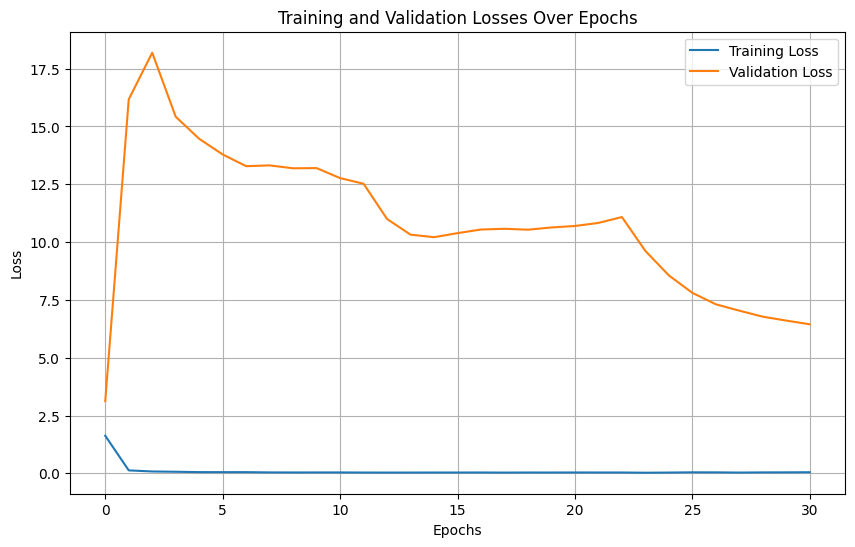

Model weights saved to model.pth


In [ ]:
# train.py

import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Device configuration: Use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data augmentations for training data to enhance model generalization
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Ensure all images are 128x128
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),  # Randomly rotate images by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet means
                         std=[0.229, 0.224, 0.225])   # and standard deviations
])

# Define data transformations for validation and testing data (no augmentations)
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Ensure all images are 128x128
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet means
                         std=[0.229, 0.224, 0.225])   # and standard deviations
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        """
        Custom Dataset class for loading bird images.

        Args:
            image_dir (str): Directory path containing input images.
            allowed_classes (List): List of class names to include.
            transform (callable, optional): Transformation to be applied to images.
            dataset_type (str, optional): Type of dataset split ('Train', 'Test', or None for unlabeled).
        """
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        # List all subdirectories in image_dir
        self.classes = [item for item in os.listdir(self.image_dir)
                       if os.path.isdir(os.path.join(self.image_dir, item))]

        self.samples = []
        for class_name in self.classes:
            if class_name in allowed_classes:
                class_path = os.path.join(self.image_dir, class_name)
                images = os.listdir(class_path)
                for img in images:
                    self.samples.append([img, class_name])

        # Shuffle samples with a fixed seed for reproducibility
        random.seed(87)
        random.shuffle(self.samples)

        # Split the dataset based on dataset_type
        split_ratio = 0.6  # 60% for training, 40% for validation
        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples  # For unlabeled data

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and its corresponding label.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (image tensor, class label)
        """
        image_filename, class_name = self.images[index]
        image_path = os.path.join(self.image_dir, class_name, image_filename)

        # Load the image
        image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        else:
            image = test_transforms(image)

        # Get the class label index
        if class_name != "unlabeled":
            class_id = self.allowed_classes.index(class_name)
        else:
            class_id = -1  # Use -1 for unlabeled data

        return image, class_id

def get_data_loaders(image_dir: str, batch_size: int = 128, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Creates DataLoaders for training, validation, and unlabeled datasets.

    Args:
        image_dir (str): Path to the dataset directory.
        batch_size (int, optional): Number of samples per batch. Defaults to 128.
        num_workers (int, optional): Number of subprocesses for data loading. Defaults to 2.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: (train_loader, val_loader, unlabeled_loader)
    """
    # Define the classes
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    # Initialize datasets
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=train_transforms,
        dataset_type='Train'
    )

    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=test_transforms,
        dataset_type='Test'
    )

    unlabeled_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=["unlabeled"],
        transform=test_transforms,
        dataset_type=None  # None indicates unlabeled
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, unlabeled_loader

def train_semi_supervised(model: nn.Module,
                          labeled_loader: DataLoader,
                          unlabeled_loader: DataLoader,
                          val_loader: DataLoader,
                          num_epochs: int = 100,
                          patience: int = 30,
                          confidence_threshold: float = 0.95) -> Tuple[nn.Module, List[List[float]]]:
    """
    Trains the model using both labeled and unlabeled data through pseudo-labeling.

    Args:
        model (nn.Module): The neural network model to train.
        labeled_loader (DataLoader): DataLoader for labeled data.
        unlabeled_loader (DataLoader): DataLoader for unlabeled data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int, optional): Maximum number of training epochs. Defaults to 100.
        patience (int, optional): Number of epochs to wait for improvement before early stopping. Defaults to 30.
        confidence_threshold (float, optional): Minimum confidence to assign pseudo-labels. Defaults to 0.95.

    Returns:
        Tuple[nn.Module, List[List[float]]]: The trained model and training/validation loss history.
    """
    # Define loss functions
    criterion_supervised = nn.CrossEntropyLoss()  # Supervised loss for labeled data
    criterion_unsupervised = nn.CrossEntropyLoss()  # Unsupervised loss for pseudo-labeled data

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with a learning rate of 0.0001

    # Learning rate scheduler to reduce LR on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    scores = [[], []]  # [training_losses, validation_losses]

    best_val_loss = float('inf')  # Initialize with a large value
    best_model_state = None
    counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over labeled data
        for (inputs, labels) in tqdm(labeled_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training on Labeled Data"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute supervised loss
            loss_supervised = criterion_supervised(outputs, labels)

            # Backward pass and optimization
            loss_supervised.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss_supervised.item() * inputs.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(labeled_loader.dataset)
        scores[0].append(avg_train_loss)

        # Phase 2: Generate pseudo-labels for unlabeled data
        model.eval()  # Set model to evaluation mode
        pseudo_labels = []
        pseudo_inputs = []

        with torch.no_grad():
            for (inputs, _) in tqdm(unlabeled_loader, desc="Generating Pseudo-Labels"):
                inputs = inputs.to(device)
                outputs = model(inputs)
                probabilities = torch.softmax(outputs, dim=1)
                confidences, preds = torch.max(probabilities, dim=1)

                # Select samples with confidence above the threshold
                mask = confidences >= confidence_threshold
                selected_preds = preds[mask]
                selected_inputs = inputs[mask]

                # Append to pseudo-label lists
                pseudo_labels.append(selected_preds.cpu())
                pseudo_inputs.append(selected_inputs.cpu())

        if pseudo_labels:
            # Concatenate all pseudo-labels and inputs
            pseudo_labels = torch.cat(pseudo_labels)
            pseudo_inputs = torch.cat(pseudo_inputs)

            # Create a TensorDataset for pseudo-labeled data
            pseudo_dataset = torch.utils.data.TensorDataset(pseudo_inputs, pseudo_labels)
            pseudo_loader = DataLoader(pseudo_dataset, batch_size=128, shuffle=True, num_workers=2)

            # Iterate over pseudo-labeled data
            for (inputs, labels) in tqdm(pseudo_loader, desc="Training on Pseudo-Labeled Data"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)

                # Compute unsupervised loss
                loss_unsupervised = criterion_unsupervised(outputs, labels)

                # Backward pass and optimization
                loss_unsupervised.backward()
                optimizer.step()

                # Accumulate training loss
                running_loss += loss_unsupervised.item() * inputs.size(0)

            # Update average training loss including pseudo-labeled data
            avg_train_loss = running_loss / (len(labeled_loader.dataset) + len(pseudo_loader.dataset))
            scores[0][-1] = avg_train_loss  # Update the last training loss entry
        else:
            print("No pseudo-labels were generated this epoch.")

        # Evaluation Phase
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for (inputs, labels) in tqdm(val_loader, desc="Validation Phase"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion_supervised(outputs, labels)

                # Accumulate validation loss
                running_val_loss += loss.item() * inputs.size(0)

                # Get predictions
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss for the epoch
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Step the scheduler based on validation loss
        scheduler.step(avg_val_loss)

        # Calculate F1 Score and Accuracy
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0  # Reset counter if improvement occurs
            print("Validation loss improved. Saving best model state.")
        else:
            counter += 1  # Increment counter if no improvement
            print(f"No improvement in validation loss for {counter} epochs.")

        # Early stopping check
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # Load the best model state based on validation loss
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    # Final Evaluation on Validation Set
    model.eval()
    all_preds = []
    all_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for (inputs, labels) in tqdm(val_loader, desc="Final Evaluation on Validation Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion_supervised(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_val_loss = running_val_loss / len(val_loader.dataset)
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    final_accuracy = sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final F1 Score on Validation set: {final_f1:.4f}')
    print(f'Final Accuracy on Validation set: {final_accuracy:.4f}')

    return model, scores

def plot_losses(scores: List[List[float]]):
    """
    Plots the training and validation losses over epochs.

    Args:
        scores (List[List[float]]): A list containing two lists:
                                    [training_losses, validation_losses]
    """
    train_losses, val_losses = scores

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    """
    Main function to execute the training process.
    """
    # Path to the dataset directory
    dataset_path = "/content/Noisy_birds"

    # Get DataLoaders
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=128, num_workers=2)

    # Initialize the model
    from model import Model  # Ensure model.py is in the same directory
    model = Model()
    model.to(device)

    # Train the model using semi-supervised learning
    num_epochs = 100  # Maximum number of epochs
    patience = 30     # Early stopping patience

    trained_model, training_scores = train_semi_supervised(
        model=model,
        labeled_loader=train_loader,
        unlabeled_loader=unlabeled_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience,
        confidence_threshold=0.95  # Only use pseudo-labels with >=95% confidence
    )

    # Plot the training and validation losses
    plot_losses(training_scores)

    # Save the trained model's weights
    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

if __name__ == "__main__":
    main()


In [ ]:
# model.py

import torch
import torch.nn as nn
import torchvision.models as models

class Model(nn.Module):
    def __init__(self):
        """
        Initializes the Model class by setting up the architecture.
        Utilizes a ResNet18 backbone from torchvision without pre-trained weights,
        modifying its final layer to output predictions for four classes: budgie, rubber duck, canary, and duckling.

        عدم استفاده از وزن‌های پیش‌آموزش‌دیده باعث می‌شود که مدل نیازی به دانلود وزن‌ها نداشته باشد.
        """
        super(Model, self).__init__()

        # Load the ResNet18 model without pre-trained weights
        self.backbone = models.resnet18(pretrained=False)

        # Replace the final fully connected layer to match the number of target classes
        num_ftrs = self.backbone.fc.in_features  # Number of input features to the final layer
        self.backbone.fc = nn.Linear(num_ftrs, 4)  # Output layer for 4 classes

        # Add a dropout layer for regularization to prevent overfitting
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): A 4D tensor representing a batch of images.
                              Shape: (batch_size, 3, 128, 128)

        Returns:
            torch.Tensor: The output logits for each class.
                          Shape: (batch_size, 4)
        """
        # Pass the input through the ResNet18 backbone
        x = self.backbone(x)  # Output shape: (batch_size, 4)

        # Apply dropout for regularization
        x = self.dropout(x)

        return x

    def init(self):
        """
        Loads the model weights from a saved state dictionary.

        This method ensures that the model can be initialized with pre-trained weights
        from a file named "model.pth". The model is moved to the appropriate device
        before loading the weights.

        Note:
            - Ensure that "model.pth" exists in the working directory.
            - The weights are loaded with map_location='cpu' to avoid device mismatch issues.
        """
        self.load_state_dict(torch.load("model.pth", map_location='cpu'), strict=True)

#v0.3 : 0.24

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda:0


Epoch 1/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 1/100, Training Loss: 1.6466, Validation Loss: 7.4471
F1 Score on Validation set: 0.1329, Accuracy on Validation set: 0.2500
Validation loss improved. Saving best model state.


Epoch 2/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 2/100, Training Loss: 1.5356, Validation Loss: 4.6389
F1 Score on Validation set: 0.2821, Accuracy on Validation set: 0.3167
Validation loss improved. Saving best model state.


Epoch 3/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch 3/100, Training Loss: 1.3671, Validation Loss: 4.9486
F1 Score on Validation set: 0.3076, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.


Epoch 4/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Epoch 4/100, Training Loss: 1.3155, Validation Loss: 5.0078
F1 Score on Validation set: 0.2156, Accuracy on Validation set: 0.3167
No improvement in validation loss for 2 epochs.


Epoch 5/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 5/100, Training Loss: 0.8961, Validation Loss: 3.7695
F1 Score on Validation set: 0.2519, Accuracy on Validation set: 0.2833
Validation loss improved. Saving best model state.


Epoch 6/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 6/100, Training Loss: 1.2926, Validation Loss: 5.6818
F1 Score on Validation set: 0.2089, Accuracy on Validation set: 0.2833
No improvement in validation loss for 1 epochs.


Epoch 7/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 7/100, Training Loss: 0.9312, Validation Loss: 8.2527
F1 Score on Validation set: 0.1835, Accuracy on Validation set: 0.3000
No improvement in validation loss for 2 epochs.


Epoch 8/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Epoch 8/100, Training Loss: 1.1944, Validation Loss: 11.9372
F1 Score on Validation set: 0.1564, Accuracy on Validation set: 0.3000
No improvement in validation loss for 3 epochs.


Epoch 9/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Epoch 9/100, Training Loss: 1.1813, Validation Loss: 14.6694
F1 Score on Validation set: 0.1590, Accuracy on Validation set: 0.3000
No improvement in validation loss for 4 epochs.


Epoch 10/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 10/100, Training Loss: 1.1806, Validation Loss: 11.7651
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3500
No improvement in validation loss for 5 epochs.


Epoch 11/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Epoch 11/100, Training Loss: 0.7176, Validation Loss: 11.0565
F1 Score on Validation set: 0.2552, Accuracy on Validation set: 0.3333
No improvement in validation loss for 6 epochs.


Epoch 12/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 12/100, Training Loss: 0.8385, Validation Loss: 12.5811
F1 Score on Validation set: 0.2718, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.


Epoch 13/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch 13/100, Training Loss: 0.8177, Validation Loss: 13.7304
F1 Score on Validation set: 0.2504, Accuracy on Validation set: 0.3333
No improvement in validation loss for 8 epochs.


Epoch 14/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch 14/100, Training Loss: 0.7295, Validation Loss: 14.2729
F1 Score on Validation set: 0.2181, Accuracy on Validation set: 0.3167
No improvement in validation loss for 9 epochs.


Epoch 15/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 15/100, Training Loss: 1.0985, Validation Loss: 13.2163
F1 Score on Validation set: 0.2134, Accuracy on Validation set: 0.3167
No improvement in validation loss for 10 epochs.


Epoch 16/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


Epoch 16/100, Training Loss: 0.8024, Validation Loss: 10.4338
F1 Score on Validation set: 0.2499, Accuracy on Validation set: 0.3500
No improvement in validation loss for 11 epochs.


Epoch 17/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch 17/100, Training Loss: 0.6427, Validation Loss: 6.6683
F1 Score on Validation set: 0.3195, Accuracy on Validation set: 0.3833
No improvement in validation loss for 12 epochs.


Epoch 18/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 18/100, Training Loss: 0.6066, Validation Loss: 4.7772
F1 Score on Validation set: 0.3773, Accuracy on Validation set: 0.4167
No improvement in validation loss for 13 epochs.


Epoch 19/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch 19/100, Training Loss: 0.7388, Validation Loss: 3.7687
F1 Score on Validation set: 0.4023, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 20/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch 20/100, Training Loss: 0.6614, Validation Loss: 3.1227
F1 Score on Validation set: 0.4141, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 21/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 21/100, Training Loss: 0.5071, Validation Loss: 2.6801
F1 Score on Validation set: 0.4503, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.


Epoch 22/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 22/100, Training Loss: 0.6160, Validation Loss: 2.3147
F1 Score on Validation set: 0.4385, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.


Epoch 23/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 23/100, Training Loss: 0.6388, Validation Loss: 2.0056
F1 Score on Validation set: 0.5005, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 24/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch 24/100, Training Loss: 0.6246, Validation Loss: 1.8169
F1 Score on Validation set: 0.4916, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 25/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch 25/100, Training Loss: 0.5720, Validation Loss: 1.6946
F1 Score on Validation set: 0.5114, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 26/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch 26/100, Training Loss: 0.6011, Validation Loss: 1.5936
F1 Score on Validation set: 0.5147, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 27/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch 27/100, Training Loss: 0.4632, Validation Loss: 1.5098
F1 Score on Validation set: 0.5114, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 28/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Epoch 28/100, Training Loss: 0.5389, Validation Loss: 1.4414
F1 Score on Validation set: 0.5869, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 29/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch 29/100, Training Loss: 0.4544, Validation Loss: 1.4292
F1 Score on Validation set: 0.5869, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 30/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch 30/100, Training Loss: 0.4309, Validation Loss: 1.4082
F1 Score on Validation set: 0.5869, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 31/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch 31/100, Training Loss: 0.4890, Validation Loss: 1.3749
F1 Score on Validation set: 0.5869, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 32/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 32/100, Training Loss: 0.5505, Validation Loss: 1.3560
F1 Score on Validation set: 0.6244, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 33/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 33/100, Training Loss: 0.5233, Validation Loss: 1.3380
F1 Score on Validation set: 0.6025, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 34/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch 34/100, Training Loss: 0.5666, Validation Loss: 1.3200
F1 Score on Validation set: 0.5994, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 35/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 35/100, Training Loss: 0.4549, Validation Loss: 1.3031
F1 Score on Validation set: 0.5837, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 36/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 36/100, Training Loss: 0.4940, Validation Loss: 1.2892
F1 Score on Validation set: 0.6136, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 37/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


Epoch 37/100, Training Loss: 0.4287, Validation Loss: 1.2697
F1 Score on Validation set: 0.6123, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 38/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 38/100, Training Loss: 0.4159, Validation Loss: 1.2674
F1 Score on Validation set: 0.5798, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 39/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch 39/100, Training Loss: 0.4266, Validation Loss: 1.2561
F1 Score on Validation set: 0.6087, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 40/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch 40/100, Training Loss: 0.4157, Validation Loss: 1.2570
F1 Score on Validation set: 0.5946, Accuracy on Validation set: 0.5833
No improvement in validation loss for 1 epochs.


Epoch 41/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Epoch 41/100, Training Loss: 0.4907, Validation Loss: 1.2523
F1 Score on Validation set: 0.6399, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 42/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch 42/100, Training Loss: 0.4146, Validation Loss: 1.2580
F1 Score on Validation set: 0.6130, Accuracy on Validation set: 0.6000
No improvement in validation loss for 1 epochs.


Epoch 43/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 43/100, Training Loss: 0.5084, Validation Loss: 1.2610
F1 Score on Validation set: 0.5945, Accuracy on Validation set: 0.5833
No improvement in validation loss for 2 epochs.


Epoch 44/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 44/100, Training Loss: 0.4493, Validation Loss: 1.2544
F1 Score on Validation set: 0.5796, Accuracy on Validation set: 0.5667
No improvement in validation loss for 3 epochs.


Epoch 45/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 45/100, Training Loss: 0.5560, Validation Loss: 1.2640
F1 Score on Validation set: 0.5822, Accuracy on Validation set: 0.5667
No improvement in validation loss for 4 epochs.


Epoch 46/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch 46/100, Training Loss: 0.3822, Validation Loss: 1.2626
F1 Score on Validation set: 0.5822, Accuracy on Validation set: 0.5667
No improvement in validation loss for 5 epochs.


Epoch 47/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Epoch 47/100, Training Loss: 0.4897, Validation Loss: 1.2542
F1 Score on Validation set: 0.5939, Accuracy on Validation set: 0.5833
No improvement in validation loss for 6 epochs.


Epoch 48/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch 48/100, Training Loss: 0.4134, Validation Loss: 1.2720
F1 Score on Validation set: 0.5788, Accuracy on Validation set: 0.5667
No improvement in validation loss for 7 epochs.


Epoch 49/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 49/100, Training Loss: 0.4570, Validation Loss: 1.2767
F1 Score on Validation set: 0.5939, Accuracy on Validation set: 0.5833
No improvement in validation loss for 8 epochs.


Epoch 50/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch 50/100, Training Loss: 0.4571, Validation Loss: 1.2744
F1 Score on Validation set: 0.5972, Accuracy on Validation set: 0.5833
No improvement in validation loss for 9 epochs.


Epoch 51/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 51/100, Training Loss: 0.4937, Validation Loss: 1.2715
F1 Score on Validation set: 0.5972, Accuracy on Validation set: 0.5833
No improvement in validation loss for 10 epochs.


Epoch 52/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Epoch 52/100, Training Loss: 0.4954, Validation Loss: 1.2736
F1 Score on Validation set: 0.6148, Accuracy on Validation set: 0.6000
No improvement in validation loss for 11 epochs.


Epoch 53/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch 53/100, Training Loss: 0.4782, Validation Loss: 1.2835
F1 Score on Validation set: 0.5955, Accuracy on Validation set: 0.5833
No improvement in validation loss for 12 epochs.


Epoch 54/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Epoch 54/100, Training Loss: 0.3700, Validation Loss: 1.3096
F1 Score on Validation set: 0.6143, Accuracy on Validation set: 0.6000
No improvement in validation loss for 13 epochs.


Epoch 55/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch 55/100, Training Loss: 0.4301, Validation Loss: 1.3209
F1 Score on Validation set: 0.6317, Accuracy on Validation set: 0.6167
No improvement in validation loss for 14 epochs.


Epoch 56/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 56/100, Training Loss: 0.4111, Validation Loss: 1.3030
F1 Score on Validation set: 0.6122, Accuracy on Validation set: 0.6000
No improvement in validation loss for 15 epochs.


Epoch 57/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 57/100, Training Loss: 0.3483, Validation Loss: 1.3047
F1 Score on Validation set: 0.5953, Accuracy on Validation set: 0.5833
No improvement in validation loss for 16 epochs.


Epoch 58/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 58/100, Training Loss: 0.4896, Validation Loss: 1.2986
F1 Score on Validation set: 0.5953, Accuracy on Validation set: 0.5833
No improvement in validation loss for 17 epochs.


Epoch 59/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Epoch 59/100, Training Loss: 0.4085, Validation Loss: 1.2921
F1 Score on Validation set: 0.5955, Accuracy on Validation set: 0.5833
No improvement in validation loss for 18 epochs.


Epoch 60/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch 60/100, Training Loss: 0.4970, Validation Loss: 1.2878
F1 Score on Validation set: 0.6116, Accuracy on Validation set: 0.6000
No improvement in validation loss for 19 epochs.


Epoch 61/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 61/100, Training Loss: 0.4566, Validation Loss: 1.2884
F1 Score on Validation set: 0.6121, Accuracy on Validation set: 0.6000
No improvement in validation loss for 20 epochs.


Epoch 62/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 62/100, Training Loss: 0.4614, Validation Loss: 1.2860
F1 Score on Validation set: 0.5955, Accuracy on Validation set: 0.5833
No improvement in validation loss for 21 epochs.


Epoch 63/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch 63/100, Training Loss: 0.4599, Validation Loss: 1.2783
F1 Score on Validation set: 0.6121, Accuracy on Validation set: 0.6000
No improvement in validation loss for 22 epochs.


Epoch 64/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Epoch 64/100, Training Loss: 0.3330, Validation Loss: 1.2940
F1 Score on Validation set: 0.6123, Accuracy on Validation set: 0.6000
No improvement in validation loss for 23 epochs.


Epoch 65/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Epoch 65/100, Training Loss: 0.4358, Validation Loss: 1.2882
F1 Score on Validation set: 0.6123, Accuracy on Validation set: 0.6000
No improvement in validation loss for 24 epochs.


Epoch 66/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Epoch 66/100, Training Loss: 0.4183, Validation Loss: 1.3186
F1 Score on Validation set: 0.5952, Accuracy on Validation set: 0.5833
No improvement in validation loss for 25 epochs.


Epoch 67/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


Epoch 67/100, Training Loss: 0.4673, Validation Loss: 1.3085
F1 Score on Validation set: 0.5952, Accuracy on Validation set: 0.5833
No improvement in validation loss for 26 epochs.


Epoch 68/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 68/100, Training Loss: 0.5491, Validation Loss: 1.3158
F1 Score on Validation set: 0.5952, Accuracy on Validation set: 0.5833
No improvement in validation loss for 27 epochs.


Epoch 69/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 69/100, Training Loss: 0.5110, Validation Loss: 1.3101
F1 Score on Validation set: 0.6132, Accuracy on Validation set: 0.6000
No improvement in validation loss for 28 epochs.


Epoch 70/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Epoch 70/100, Training Loss: 0.4374, Validation Loss: 1.3194
F1 Score on Validation set: 0.6290, Accuracy on Validation set: 0.6167
No improvement in validation loss for 29 epochs.


Epoch 71/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch 71/100, Training Loss: 0.3997, Validation Loss: 1.3301
F1 Score on Validation set: 0.6290, Accuracy on Validation set: 0.6167
No improvement in validation loss for 30 epochs.
Early stopping triggered after 71 epochs.
Best model loaded based on validation loss.


Final Evaluation on Validation Set: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Final Validation Loss: 1.2523
Final F1 Score on Validation set: 0.6399
Final Accuracy on Validation set: 0.6333


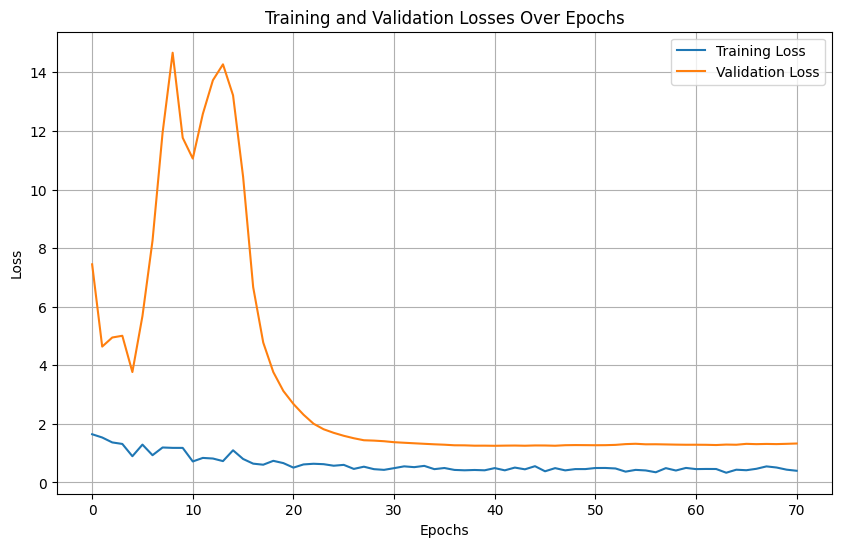

Model weights saved to model.pth


In [ ]:
# train.py

import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تعریف افزونه‌های داده برای داده‌های آموزشی
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # اطمینان از اندازه 128x128
    transforms.RandomHorizontalFlip(),  # چرخش تصادفی افقی
    transforms.RandomRotation(15),  # چرخش تصادفی به اندازه 15 درجه
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # تغییر رنگ تصادفی
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # برش و تغییر اندازه تصادفی
    transforms.ToTensor(),  # تبدیل تصویر PIL به Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # نرمال‌سازی با میانگین ImageNet
                         std=[0.229, 0.224, 0.225])   # و انحراف معیار ImageNet
])

# تعریف افزونه‌های داده برای داده‌های اعتبارسنجی و تست (بدون افزونه)
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # اطمینان از اندازه 128x128
    transforms.ToTensor(),  # تبدیل تصویر PIL به Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # نرمال‌سازی با میانگین ImageNet
                         std=[0.229, 0.224, 0.225])   # و انحراف معیار ImageNet
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        """
        کلاس Dataset سفارشی برای بارگذاری تصاویر پرندگان.

        Args:
            image_dir (str): مسیر دایرکتوری حاوی تصاویر ورودی.
            allowed_classes (List): لیستی از نام کلاس‌هایی که باید شامل شوند.
            transform (callable, optional): تبدیل‌هایی که باید به تصاویر اعمال شوند.
            dataset_type (str, optional): نوع تقسیم‌بندی داده‌ها ('Train', 'Test' یا None برای غیرنظارت‌شده).
        """
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        # لیست تمام زیرشاخه‌ها در image_dir
        self.classes = [item for item in os.listdir(self.image_dir)
                       if os.path.isdir(os.path.join(self.image_dir, item))]

        self.samples = []
        for class_name in self.classes:
            if class_name in allowed_classes:
                class_path = os.path.join(self.image_dir, class_name)
                images = os.listdir(class_path)
                for img in images:
                    self.samples.append([img, class_name])

        # مخلوط کردن نمونه‌ها با استفاده از بذر ثابت برای قابلیت تکرار
        random.seed(87)
        random.shuffle(self.samples)

        # تقسیم‌بندی داده‌ها بر اساس نوع
        split_ratio = 0.6  # 60% برای آموزش، 40% برای اعتبارسنجی
        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples  # برای داده‌های غیرنظارت‌شده

    def __len__(self) -> int:
        """
        بازگشت تعداد کل نمونه‌ها در Dataset.
        """
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        دریافت تصویر و برچسب مربوطه.

        Args:
            index (int): شاخص نمونه‌ای که باید دریافت شود.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (تنسور تصویر، برچسب کلاس)
        """
        image_filename, class_name = self.images[index]
        image_path = os.path.join(self.image_dir, class_name, image_filename)

        # بارگذاری تصویر
        image = Image.open(image_path).convert('RGB')  # اطمینان از فرمت RGB

        # اعمال تبدیل‌ها در صورت مشخص بودن
        if self.transform:
            image = self.transform(image)
        else:
            image = test_transforms(image)

        # دریافت شاخص برچسب کلاس
        if class_name != "unlabeled":
            class_id = self.allowed_classes.index(class_name)
        else:
            class_id = -1  # استفاده از -1 برای داده‌های غیرنظارت‌شده

        return image, class_id

def get_data_loaders(image_dir: str, batch_size: int = 64, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    ایجاد DataLoader برای داده‌های آموزشی، اعتبارسنجی و غیرنظارت‌شده.

    Args:
        image_dir (str): مسیر دایرکتوری مجموعه داده‌ها.
        batch_size (int, optional): تعداد نمونه‌ها در هر بسته. Defaults to 64.
        num_workers (int, optional): تعداد زیرپردازنده‌ها برای بارگذاری داده‌ها. Defaults to 2.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: (train_loader, val_loader, unlabeled_loader)
    """
    # تعریف کلاس‌ها
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    # ایجاد Dataset‌ها
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=train_transforms,
        dataset_type='Train'
    )

    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=test_transforms,
        dataset_type='Test'
    )

    unlabeled_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=["unlabeled"],
        transform=test_transforms,
        dataset_type=None  # None نشان‌دهنده داده‌های غیرنظارت‌شده
    )

    # ایجاد DataLoader‌ها
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, unlabeled_loader

def train_supervised(model: nn.Module,
                    train_loader: DataLoader,
                    val_loader: DataLoader,
                    num_epochs: int = 100,
                    patience: int = 30) -> Tuple[nn.Module, List[List[float]]]:
    """
    آموزش مدل به صورت نظارت‌شده.

    Args:
        model (nn.Module): مدل شبکه عصبی برای آموزش.
        train_loader (DataLoader): DataLoader برای داده‌های آموزشی نظارت‌شده.
        val_loader (DataLoader): DataLoader برای داده‌های اعتبارسنجی.
        num_epochs (int, optional): حداکثر تعداد دوره‌های آموزش. Defaults to 100.
        patience (int, optional): تعداد دوره‌های بدون بهبود قبل از توقف زودهنگام. Defaults to 30.

    Returns:
        Tuple[nn.Module, List[List[float]]]: مدل آموزش‌دیده و تاریخچه ضررهای آموزشی/اعتبارسنجی.
    """
    # تعریف تابع ضرر و بهینه‌ساز
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)  # نرخ یادگیری افزایش یافته

    # Scheduler برای کاهش نرخ یادگیری در صورت عدم بهبود
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    scores = [[], []]  # [training_losses, validation_losses]

    best_val_loss = float('inf')  # مقدار اولیه بزرگ
    best_model_state = None
    counter = 0  # شمارنده برای توقف زودهنگام

    for epoch in range(num_epochs):
        model.train()  # قرار دادن مدل در حالت آموزش
        running_loss = 0.0

        for (inputs, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # صفر کردن گرادیان‌ها
            optimizer.zero_grad()

            # عبور مستقیم
            outputs = model(inputs)

            # محاسبه ضرر
            loss = criterion(outputs, labels)

            # بازگشت گرادیان‌ها و بهینه‌سازی
            loss.backward()
            optimizer.step()

            # جمع‌آوری ضرر آموزشی
            running_loss += loss.item() * inputs.size(0)

        # محاسبه ضرر آموزشی متوسط برای دوره
        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # مرحله اعتبارسنجی
        model.eval()  # قرار دادن مدل در حالت ارزیابی
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for (inputs, labels) in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # جمع‌آوری ضرر اعتبارسنجی
                running_val_loss += loss.item() * inputs.size(0)

                # دریافت پیش‌بینی‌ها
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # محاسبه ضرر اعتبارسنجی متوسط برای دوره
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # محاسبه F1 Score و دقت
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # به‌روزرسانی Scheduler بر اساس ضرر اعتبارسنجی
        scheduler.step(avg_val_loss)

        # بررسی بهبود
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0  # ریست کردن شمارنده در صورت بهبود
            print("Validation loss improved. Saving best model state.")
        else:
            counter += 1  # افزایش شمارنده در صورت عدم بهبود
            print(f"No improvement in validation loss for {counter} epochs.")

        # بررسی توقف زودهنگام
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # بارگذاری بهترین حالت مدل بر اساس ضرر اعتبارسنجی
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    # ارزیابی نهایی بر روی مجموعه اعتبارسنجی
    model.eval()
    all_preds = []
    all_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for (inputs, labels) in tqdm(val_loader, desc="Final Evaluation on Validation Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_val_loss = running_val_loss / len(val_loader.dataset)
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    final_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final F1 Score on Validation set: {final_f1:.4f}')
    print(f'Final Accuracy on Validation set: {final_accuracy:.4f}')

    return model, scores

def plot_losses(scores: List[List[float]]):
    """
    ترسیم ضررهای آموزشی و اعتبارسنجی در طول دوره‌ها.

    Args:
        scores (List[List[float]]): یک لیست حاوی دو لیست:
                                    [training_losses, validation_losses]
    """
    train_losses, val_losses = scores

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    """
    تابع اصلی برای اجرای فرآیند آموزش.
    """
    # مسیر دایرکتوری مجموعه داده‌ها
    dataset_path = "/content/Noisy_birds"

    # دریافت DataLoader‌ها
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=64, num_workers=2)

    # ایجاد نمونه‌ای از مدل
    from model import Model  # اطمینان حاصل کنید که model.py در همان دایرکتوری قرار دارد
    model = Model()
    model.to(device)

    # آموزش مدل به صورت نظارت‌شده
    num_epochs = 100  # حداکثر تعداد دوره‌های آموزش
    patience = 30     # تعداد دوره‌های صبر برای توقف زودهنگام

    trained_model, training_scores = train_supervised(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    # ترسیم ضررهای آموزشی و اعتبارسنجی
    plot_losses(training_scores)

    # ذخیره وزن‌های مدل آموزش‌دیده
    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # در صورت تمایل، می‌توانید پس از آموزش نظارت‌شده، آموزش نیمه‌نظارت‌شده را نیز انجام دهید.
    # به عنوان مثال:
    # trained_model, training_scores = train_semi_supervised(
    #     model=trained_model,
    #     labeled_loader=train_loader,
    #     unlabeled_loader=unlabeled_loader,
    #     val_loader=val_loader,
    #     num_epochs=num_epochs,
    #     patience=patience,
    #     confidence_threshold=0.90  # تنظیم آستانه اعتماد
    # )
    # plot_losses(training_scores)
    # torch.save(trained_model.cpu().state_dict(), model_save_path)

if __name__ == "__main__":
    main()


In [ ]:
# model.py

import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        """
        Initializes the Model class by setting up a custom CNN architecture.
        This architecture is designed to have a small number of parameters to keep the model size below 70MB.

        The architecture consists of several convolutional layers with batch normalization and ReLU activations,
        followed by max pooling layers for spatial reduction. Fully connected layers are used at the end
        to output logits for four classes: budgie, rubber duck, canary, and duckling.

        Dropout is applied for regularization to prevent overfitting.
        """
        super(Model, self).__init__()

        self.features = nn.Sequential(
            # اولین بلوک کانولوشنال
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # ورودی: 3x128x128، خروجی: 32x128x128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # خروجی: 32x64x64

            # دومین بلوک کانولوشنال
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # خروجی: 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # خروجی: 64x32x32

            # سومین بلوک کانولوشنال
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # خروجی: 128x32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # خروجی: 128x16x16

            # چهارمین بلوک کانولوشنال
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # خروجی: 256x16x16
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # خروجی: 256x8x8
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*8*8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 4),  # خروجی: 4 کلاس
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): A 4D tensor representing a batch of images.
                              Shape: (batch_size, 3, 128, 128)

        Returns:
            torch.Tensor: The output logits for each class.
                          Shape: (batch_size, 4)
        """
        x = self.features(x)
        x = x.view(x.size(0), -1)  # صاف‌سازی
        x = self.classifier(x)
        return x

    def init(self):
        """
        Loads the model weights from a saved state dictionary.

        This method ensures that the model can be initialized with pre-trained weights
        from a file named "model.pth". The model is moved to the appropriate device
        before loading the weights.

        Note:
            - Ensure that "model.pth" exists in the working directory.
            - The weights are loaded with `map_location='cpu'` to avoid device mismatch issues.
        """
        self.load_state_dict(torch.load("model.pth", map_location='cpu'), strict=True)


#v0.4 : 0.24

Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 1/100, Training Loss: 1.6962, Validation Loss: 3.5663
F1 Score on Validation set: 0.1810, Accuracy on Validation set: 0.3000
Validation loss improved. Saving best model state.


Epoch 2/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch 2/100, Training Loss: 1.5373, Validation Loss: 7.0327
F1 Score on Validation set: 0.0885, Accuracy on Validation set: 0.2000
No improvement in validation loss for 1 epochs.


Epoch 3/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Epoch 3/100, Training Loss: 1.4279, Validation Loss: 10.3843
F1 Score on Validation set: 0.0576, Accuracy on Validation set: 0.1833
No improvement in validation loss for 2 epochs.


Epoch 4/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Epoch 4/100, Training Loss: 1.4232, Validation Loss: 6.5708
F1 Score on Validation set: 0.2726, Accuracy on Validation set: 0.3167
No improvement in validation loss for 3 epochs.


Epoch 5/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Epoch 5/100, Training Loss: 1.3210, Validation Loss: 3.6812
F1 Score on Validation set: 0.4319, Accuracy on Validation set: 0.4667
No improvement in validation loss for 4 epochs.


Epoch 6/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 6/100, Training Loss: 1.5714, Validation Loss: 4.7230
F1 Score on Validation set: 0.2409, Accuracy on Validation set: 0.3500
No improvement in validation loss for 5 epochs.


Epoch 7/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 7/100, Training Loss: 1.2227, Validation Loss: 3.6542
F1 Score on Validation set: 0.2893, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.


Epoch 8/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch 8/100, Training Loss: 1.2456, Validation Loss: 3.8977
F1 Score on Validation set: 0.2766, Accuracy on Validation set: 0.3833
No improvement in validation loss for 7 epochs.


Epoch 9/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Epoch 9/100, Training Loss: 1.4742, Validation Loss: 5.1216
F1 Score on Validation set: 0.2517, Accuracy on Validation set: 0.3667
No improvement in validation loss for 8 epochs.


Epoch 10/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Epoch 10/100, Training Loss: 1.2135, Validation Loss: 6.2973
F1 Score on Validation set: 0.2233, Accuracy on Validation set: 0.3333
No improvement in validation loss for 9 epochs.


Epoch 11/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch 11/100, Training Loss: 1.0049, Validation Loss: 5.6216
F1 Score on Validation set: 0.2419, Accuracy on Validation set: 0.3333
No improvement in validation loss for 10 epochs.


Epoch 12/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch 12/100, Training Loss: 1.1203, Validation Loss: 5.1458
F1 Score on Validation set: 0.2432, Accuracy on Validation set: 0.3333
No improvement in validation loss for 11 epochs.


Epoch 13/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 13/100, Training Loss: 1.1040, Validation Loss: 3.9230
F1 Score on Validation set: 0.2677, Accuracy on Validation set: 0.3500
No improvement in validation loss for 12 epochs.


Epoch 14/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch 14/100, Training Loss: 1.3433, Validation Loss: 3.1570
F1 Score on Validation set: 0.3137, Accuracy on Validation set: 0.3667
Validation loss improved. Saving best model state.


Epoch 15/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 15/100, Training Loss: 1.1460, Validation Loss: 2.5343
F1 Score on Validation set: 0.4087, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 16/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch 16/100, Training Loss: 1.0550, Validation Loss: 2.1185
F1 Score on Validation set: 0.5319, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.


Epoch 17/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 17/100, Training Loss: 1.0136, Validation Loss: 1.8713
F1 Score on Validation set: 0.5386, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.


Epoch 18/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Epoch 18/100, Training Loss: 0.9344, Validation Loss: 1.6332
F1 Score on Validation set: 0.5745, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 19/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 19/100, Training Loss: 0.8707, Validation Loss: 1.5075
F1 Score on Validation set: 0.5873, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 20/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch 20/100, Training Loss: 0.9935, Validation Loss: 1.4342
F1 Score on Validation set: 0.5873, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 21/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Epoch 21/100, Training Loss: 0.9874, Validation Loss: 1.3486
F1 Score on Validation set: 0.6197, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 22/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Epoch 22/100, Training Loss: 0.8628, Validation Loss: 1.3123
F1 Score on Validation set: 0.5781, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 23/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch 23/100, Training Loss: 0.9287, Validation Loss: 1.2403
F1 Score on Validation set: 0.5962, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 24/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 24/100, Training Loss: 0.9016, Validation Loss: 1.2162
F1 Score on Validation set: 0.5972, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 25/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Epoch 25/100, Training Loss: 0.9063, Validation Loss: 1.1863
F1 Score on Validation set: 0.5784, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 26/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Epoch 26/100, Training Loss: 0.9344, Validation Loss: 1.1633
F1 Score on Validation set: 0.5943, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 27/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Epoch 27/100, Training Loss: 0.8850, Validation Loss: 1.1388
F1 Score on Validation set: 0.6244, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 28/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 28/100, Training Loss: 0.8889, Validation Loss: 1.1353
F1 Score on Validation set: 0.6394, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 29/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Epoch 29/100, Training Loss: 1.0085, Validation Loss: 1.1308
F1 Score on Validation set: 0.6394, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 30/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 30/100, Training Loss: 0.8586, Validation Loss: 1.1138
F1 Score on Validation set: 0.6398, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 31/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Epoch 31/100, Training Loss: 0.9306, Validation Loss: 1.1137
F1 Score on Validation set: 0.6398, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 32/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 32/100, Training Loss: 0.8854, Validation Loss: 1.1015
F1 Score on Validation set: 0.6743, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 33/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Epoch 33/100, Training Loss: 0.8356, Validation Loss: 1.1040
F1 Score on Validation set: 0.6743, Accuracy on Validation set: 0.6833
No improvement in validation loss for 1 epochs.


Epoch 34/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch 34/100, Training Loss: 1.0033, Validation Loss: 1.0848
F1 Score on Validation set: 0.6743, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 35/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 35/100, Training Loss: 0.8789, Validation Loss: 1.0842
F1 Score on Validation set: 0.6743, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 36/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch 36/100, Training Loss: 0.8312, Validation Loss: 1.0728
F1 Score on Validation set: 0.6743, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 37/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 37/100, Training Loss: 0.7593, Validation Loss: 1.0733
F1 Score on Validation set: 0.6937, Accuracy on Validation set: 0.7000
No improvement in validation loss for 1 epochs.


Epoch 38/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Epoch 38/100, Training Loss: 0.8772, Validation Loss: 1.0617
F1 Score on Validation set: 0.6945, Accuracy on Validation set: 0.7000
Validation loss improved. Saving best model state.


Epoch 39/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Epoch 39/100, Training Loss: 0.8532, Validation Loss: 1.0667
F1 Score on Validation set: 0.6779, Accuracy on Validation set: 0.6833
No improvement in validation loss for 1 epochs.


Epoch 40/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch 40/100, Training Loss: 0.7963, Validation Loss: 1.0623
F1 Score on Validation set: 0.6629, Accuracy on Validation set: 0.6667
No improvement in validation loss for 2 epochs.


Epoch 41/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 41/100, Training Loss: 0.7961, Validation Loss: 1.0549
F1 Score on Validation set: 0.6629, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 42/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 42/100, Training Loss: 0.8507, Validation Loss: 1.0548
F1 Score on Validation set: 0.6639, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 43/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 43/100, Training Loss: 0.7962, Validation Loss: 1.0453
F1 Score on Validation set: 0.6639, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 44/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


Epoch 44/100, Training Loss: 0.8120, Validation Loss: 1.0485
F1 Score on Validation set: 0.6639, Accuracy on Validation set: 0.6667
No improvement in validation loss for 1 epochs.


Epoch 45/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Epoch 45/100, Training Loss: 0.7797, Validation Loss: 1.0579
F1 Score on Validation set: 0.6484, Accuracy on Validation set: 0.6500
No improvement in validation loss for 2 epochs.


Epoch 46/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 46/100, Training Loss: 0.8208, Validation Loss: 1.0464
F1 Score on Validation set: 0.6484, Accuracy on Validation set: 0.6500
No improvement in validation loss for 3 epochs.


Epoch 47/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Epoch 47/100, Training Loss: 0.7412, Validation Loss: 1.0480
F1 Score on Validation set: 0.6484, Accuracy on Validation set: 0.6500
No improvement in validation loss for 4 epochs.


Epoch 48/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 48/100, Training Loss: 0.8151, Validation Loss: 1.0426
F1 Score on Validation set: 0.6679, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 49/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Epoch 49/100, Training Loss: 0.8438, Validation Loss: 1.0434
F1 Score on Validation set: 0.6679, Accuracy on Validation set: 0.6667
No improvement in validation loss for 1 epochs.


Epoch 50/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Epoch 50/100, Training Loss: 0.7656, Validation Loss: 1.0488
F1 Score on Validation set: 0.6662, Accuracy on Validation set: 0.6667
No improvement in validation loss for 2 epochs.


Epoch 51/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 51/100, Training Loss: 0.8035, Validation Loss: 1.0402
F1 Score on Validation set: 0.6679, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 52/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Epoch 52/100, Training Loss: 0.7545, Validation Loss: 1.0443
F1 Score on Validation set: 0.6636, Accuracy on Validation set: 0.6667
No improvement in validation loss for 1 epochs.


Epoch 53/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch 53/100, Training Loss: 0.8013, Validation Loss: 1.0385
F1 Score on Validation set: 0.6636, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 54/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Epoch 54/100, Training Loss: 0.7166, Validation Loss: 1.0365
F1 Score on Validation set: 0.6636, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 55/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch 55/100, Training Loss: 0.8059, Validation Loss: 1.0255
F1 Score on Validation set: 0.6636, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 56/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch 56/100, Training Loss: 0.8065, Validation Loss: 1.0152
F1 Score on Validation set: 0.6636, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 57/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 57/100, Training Loss: 0.7116, Validation Loss: 1.0106
F1 Score on Validation set: 0.6636, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 58/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 58/100, Training Loss: 0.8418, Validation Loss: 1.0128
F1 Score on Validation set: 0.6628, Accuracy on Validation set: 0.6667
No improvement in validation loss for 1 epochs.


Epoch 59/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch 59/100, Training Loss: 0.7884, Validation Loss: 1.0079
F1 Score on Validation set: 0.6445, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 60/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 60/100, Training Loss: 0.7744, Validation Loss: 1.0031
F1 Score on Validation set: 0.6445, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 61/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Epoch 61/100, Training Loss: 0.7551, Validation Loss: 0.9997
F1 Score on Validation set: 0.6242, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 62/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Epoch 62/100, Training Loss: 0.7673, Validation Loss: 1.0082
F1 Score on Validation set: 0.6428, Accuracy on Validation set: 0.6500
No improvement in validation loss for 1 epochs.


Epoch 63/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Epoch 63/100, Training Loss: 0.8010, Validation Loss: 1.0083
F1 Score on Validation set: 0.6205, Accuracy on Validation set: 0.6333
No improvement in validation loss for 2 epochs.


Epoch 64/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Epoch 64/100, Training Loss: 0.7481, Validation Loss: 1.0023
F1 Score on Validation set: 0.6214, Accuracy on Validation set: 0.6333
No improvement in validation loss for 3 epochs.


Epoch 65/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch 65/100, Training Loss: 0.6967, Validation Loss: 1.0028
F1 Score on Validation set: 0.6214, Accuracy on Validation set: 0.6333
No improvement in validation loss for 4 epochs.


Epoch 66/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Epoch 66/100, Training Loss: 0.8393, Validation Loss: 1.0066
F1 Score on Validation set: 0.5964, Accuracy on Validation set: 0.6167
No improvement in validation loss for 5 epochs.


Epoch 67/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 67/100, Training Loss: 0.7598, Validation Loss: 1.0092
F1 Score on Validation set: 0.5793, Accuracy on Validation set: 0.6000
No improvement in validation loss for 6 epochs.


Epoch 68/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


Epoch 68/100, Training Loss: 0.7860, Validation Loss: 1.0035
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
No improvement in validation loss for 7 epochs.


Epoch 69/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Epoch 69/100, Training Loss: 0.7561, Validation Loss: 0.9935
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 70/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch 70/100, Training Loss: 0.7037, Validation Loss: 0.9911
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 71/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Epoch 71/100, Training Loss: 0.7929, Validation Loss: 0.9905
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 72/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Epoch 72/100, Training Loss: 0.7301, Validation Loss: 0.9888
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 73/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


Epoch 73/100, Training Loss: 0.7487, Validation Loss: 0.9899
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
No improvement in validation loss for 1 epochs.


Epoch 74/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Epoch 74/100, Training Loss: 0.7748, Validation Loss: 0.9889
F1 Score on Validation set: 0.6229, Accuracy on Validation set: 0.6333
No improvement in validation loss for 2 epochs.


Epoch 75/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Epoch 75/100, Training Loss: 0.8018, Validation Loss: 0.9857
F1 Score on Validation set: 0.6031, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 76/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Epoch 76/100, Training Loss: 0.7584, Validation Loss: 0.9839
F1 Score on Validation set: 0.6076, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 77/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 77/100, Training Loss: 0.7334, Validation Loss: 0.9807
F1 Score on Validation set: 0.6076, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 78/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 78/100, Training Loss: 0.6965, Validation Loss: 0.9823
F1 Score on Validation set: 0.6273, Accuracy on Validation set: 0.6333
No improvement in validation loss for 1 epochs.


Epoch 79/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 79/100, Training Loss: 0.7312, Validation Loss: 0.9795
F1 Score on Validation set: 0.6273, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 80/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 80/100, Training Loss: 0.8217, Validation Loss: 0.9764
F1 Score on Validation set: 0.6273, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 81/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Epoch 81/100, Training Loss: 0.7126, Validation Loss: 0.9771
F1 Score on Validation set: 0.6129, Accuracy on Validation set: 0.6167
No improvement in validation loss for 1 epochs.


Epoch 82/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Epoch 82/100, Training Loss: 0.7689, Validation Loss: 0.9757
F1 Score on Validation set: 0.6129, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 83/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Epoch 83/100, Training Loss: 0.7842, Validation Loss: 0.9808
F1 Score on Validation set: 0.6313, Accuracy on Validation set: 0.6333
No improvement in validation loss for 1 epochs.


Epoch 84/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Epoch 84/100, Training Loss: 0.7451, Validation Loss: 0.9822
F1 Score on Validation set: 0.6669, Accuracy on Validation set: 0.6667
No improvement in validation loss for 2 epochs.


Epoch 85/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 85/100, Training Loss: 0.7730, Validation Loss: 0.9845
F1 Score on Validation set: 0.6519, Accuracy on Validation set: 0.6500
No improvement in validation loss for 3 epochs.


Epoch 86/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 86/100, Training Loss: 0.7384, Validation Loss: 0.9855
F1 Score on Validation set: 0.6698, Accuracy on Validation set: 0.6667
No improvement in validation loss for 4 epochs.


Epoch 87/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Epoch 87/100, Training Loss: 0.7604, Validation Loss: 0.9899
F1 Score on Validation set: 0.6861, Accuracy on Validation set: 0.6833
No improvement in validation loss for 5 epochs.


Epoch 88/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Epoch 88/100, Training Loss: 0.7372, Validation Loss: 0.9875
F1 Score on Validation set: 0.6861, Accuracy on Validation set: 0.6833
No improvement in validation loss for 6 epochs.


Epoch 89/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Epoch 89/100, Training Loss: 0.7472, Validation Loss: 0.9881
F1 Score on Validation set: 0.6852, Accuracy on Validation set: 0.6833
No improvement in validation loss for 7 epochs.


Epoch 90/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Epoch 90/100, Training Loss: 0.7233, Validation Loss: 0.9816
F1 Score on Validation set: 0.7014, Accuracy on Validation set: 0.7000
No improvement in validation loss for 8 epochs.


Epoch 91/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Epoch 91/100, Training Loss: 0.7428, Validation Loss: 0.9797
F1 Score on Validation set: 0.6690, Accuracy on Validation set: 0.6667
No improvement in validation loss for 9 epochs.


Epoch 92/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Epoch 92/100, Training Loss: 0.7485, Validation Loss: 0.9803
F1 Score on Validation set: 0.7031, Accuracy on Validation set: 0.7000
No improvement in validation loss for 10 epochs.


Epoch 93/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch 93/100, Training Loss: 0.7132, Validation Loss: 0.9655
F1 Score on Validation set: 0.6823, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 94/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Epoch 94/100, Training Loss: 0.7663, Validation Loss: 0.9640
F1 Score on Validation set: 0.6824, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 95/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Epoch 95/100, Training Loss: 0.7199, Validation Loss: 0.9632
F1 Score on Validation set: 0.6988, Accuracy on Validation set: 0.7000
Validation loss improved. Saving best model state.


Epoch 96/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


Epoch 96/100, Training Loss: 0.7513, Validation Loss: 0.9609
F1 Score on Validation set: 0.6824, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 97/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Epoch 97/100, Training Loss: 0.7352, Validation Loss: 0.9517
F1 Score on Validation set: 0.6304, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 98/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 98/100, Training Loss: 0.6809, Validation Loss: 0.9480
F1 Score on Validation set: 0.6487, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 99/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 99/100, Training Loss: 0.6913, Validation Loss: 0.9471
F1 Score on Validation set: 0.6487, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.


Epoch 100/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch 100/100, Training Loss: 0.7129, Validation Loss: 0.9394
F1 Score on Validation set: 0.6487, Accuracy on Validation set: 0.6500
Validation loss improved. Saving best model state.
Best model loaded based on validation loss.


Final Evaluation on Validation Set: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Final Validation Loss: 0.9394
Final F1 Score on Validation set: 0.6487
Final Accuracy on Validation set: 0.6500


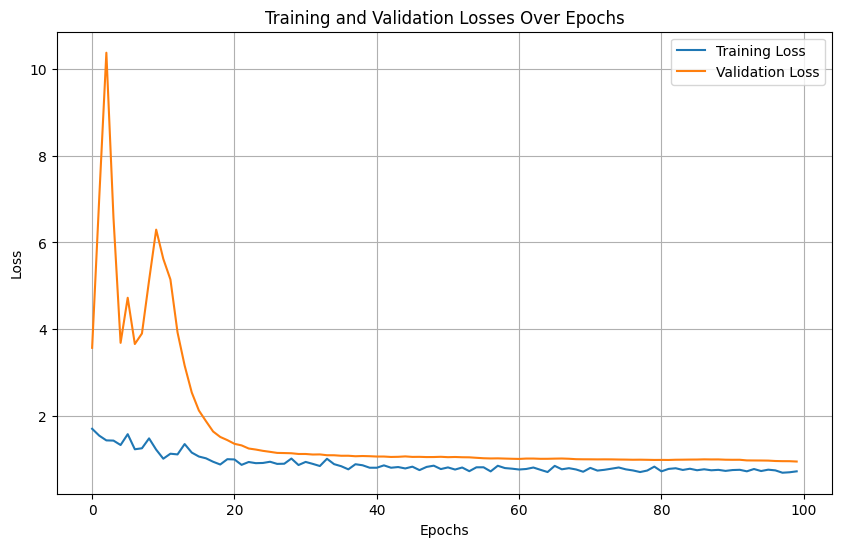

Model weights saved to model.pth


In [ ]:
# train.py

import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model  # اطمینان حاصل کنید که model.py در همان دایرکتوری قرار دارد

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تعریف افزونه‌های داده با RandAugment
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.classes = [item for item in os.listdir(self.image_dir)
                       if os.path.isdir(os.path.join(self.image_dir, item))]

        self.samples = []
        for class_name in self.classes:
            if class_name in allowed_classes:
                class_path = os.path.join(self.image_dir, class_name)
                images = os.listdir(class_path)
                for img in images:
                    self.samples.append([img, class_name])

        random.seed(87)
        random.shuffle(self.samples)

        split_ratio = 0.6
        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_filename, class_name = self.images[index]
        image_path = os.path.join(self.image_dir, class_name, image_filename)

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            image = test_transforms(image)

        if class_name != "unlabeled":
            class_id = self.allowed_classes.index(class_name)
        else:
            class_id = -1

        return image, class_id

def get_data_loaders(image_dir: str, batch_size: int = 64, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=train_transforms,
        dataset_type='Train'
    )

    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=test_transforms,
        dataset_type='Test'
    )

    unlabeled_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=["unlabeled"],
        transform=test_transforms,
        dataset_type=None
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, unlabeled_loader

def train_supervised(model: nn.Module,
                    train_loader: DataLoader,
                    val_loader: DataLoader,
                    num_epochs: int = 100,
                    patience: int = 30) -> Tuple[nn.Module, List[List[float]]]:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    scores = [[], []]

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for (inputs, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for (inputs, labels) in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.")

        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    # Final Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for (inputs, labels) in tqdm(val_loader, desc="Final Evaluation on Validation Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_val_loss = running_val_loss / len(val_loader.dataset)
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    final_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final F1 Score on Validation set: {final_f1:.4f}')
    print(f'Final Accuracy on Validation set: {final_accuracy:.4f}')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"

    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=64, num_workers=2)

    model = Model()
    model.to(device)

    num_epochs = 100
    patience = 30

    trained_model, training_scores = train_supervised(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

if __name__ == "__main__":
    main()


In [ ]:
# model.py

import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # بارگذاری MobileNetV3 Small بدون وزن‌های پیش‌آموزش‌دیده
        self.base_model = models.mobilenet_v3_small(weights=None)

        # تغییر لایه خروجی
        self.base_model.classifier[3] = nn.Linear(self.base_model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

    def init(self):
        self.load_state_dict(torch.load("model.pth", map_location='cpu'), strict=True)


#v0.4 : 0.25

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        self.base_model = models.mobilenet_v3_small(weights=None)
        self.base_model.classifier[3] = nn.Linear(self.base_model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


Epoch 1/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch 1/200, Training Loss: 1.8411, Validation Loss: 1.6728
F1 Score on Validation set: 0.2452, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.


Epoch 2/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch 2/200, Training Loss: 1.6298, Validation Loss: 1.6235
F1 Score on Validation set: 0.2373, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.


Epoch 3/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch 3/200, Training Loss: 1.6678, Validation Loss: 1.5695
F1 Score on Validation set: 0.2483, Accuracy on Validation set: 0.2833
Validation loss improved. Saving best model state.


Epoch 4/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch 4/200, Training Loss: 1.6222, Validation Loss: 1.5240
F1 Score on Validation set: 0.2488, Accuracy on Validation set: 0.2833
Validation loss improved. Saving best model state.


Epoch 5/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 5/200, Training Loss: 1.5278, Validation Loss: 1.4726
F1 Score on Validation set: 0.2734, Accuracy on Validation set: 0.3000
Validation loss improved. Saving best model state.


Epoch 6/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 6/200, Training Loss: 1.3706, Validation Loss: 1.4246
F1 Score on Validation set: 0.2888, Accuracy on Validation set: 0.3167
Validation loss improved. Saving best model state.


Epoch 7/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Epoch 7/200, Training Loss: 1.4517, Validation Loss: 1.3905
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.3500
Validation loss improved. Saving best model state.


Epoch 8/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 8/200, Training Loss: 1.4166, Validation Loss: 1.3600
F1 Score on Validation set: 0.3641, Accuracy on Validation set: 0.3833
Validation loss improved. Saving best model state.


Epoch 9/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch 9/200, Training Loss: 1.3428, Validation Loss: 1.3233
F1 Score on Validation set: 0.4177, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 10/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 10/200, Training Loss: 1.3330, Validation Loss: 1.2888
F1 Score on Validation set: 0.4299, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.


Epoch 11/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 11/200, Training Loss: 1.3217, Validation Loss: 1.2685
F1 Score on Validation set: 0.4554, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.


Epoch 12/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 12/200, Training Loss: 1.3160, Validation Loss: 1.2603
F1 Score on Validation set: 0.4244, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 13/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 13/200, Training Loss: 1.1717, Validation Loss: 1.2625
F1 Score on Validation set: 0.4470, Accuracy on Validation set: 0.4667
No improvement in validation loss for 1 epochs.


Epoch 14/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch 14/200, Training Loss: 1.2261, Validation Loss: 1.2690
F1 Score on Validation set: 0.4267, Accuracy on Validation set: 0.4500
No improvement in validation loss for 2 epochs.


Epoch 15/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 15/200, Training Loss: 1.1490, Validation Loss: 1.2716
F1 Score on Validation set: 0.4439, Accuracy on Validation set: 0.4667
No improvement in validation loss for 3 epochs.


Epoch 16/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch 16/200, Training Loss: 0.8407, Validation Loss: 1.2740
F1 Score on Validation set: 0.4375, Accuracy on Validation set: 0.4667
No improvement in validation loss for 4 epochs.


Epoch 17/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 17/200, Training Loss: 1.1877, Validation Loss: 1.2606
F1 Score on Validation set: 0.4139, Accuracy on Validation set: 0.4500
No improvement in validation loss for 5 epochs.


Epoch 18/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch 18/200, Training Loss: 1.1680, Validation Loss: 1.2525
F1 Score on Validation set: 0.4271, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.


Epoch 19/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Epoch 19/200, Training Loss: 1.0933, Validation Loss: 1.2580
F1 Score on Validation set: 0.4184, Accuracy on Validation set: 0.4333
No improvement in validation loss for 1 epochs.


Epoch 20/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch 20/200, Training Loss: 1.0535, Validation Loss: 1.2474
F1 Score on Validation set: 0.4555, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.


Epoch 21/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 21/200, Training Loss: 0.8673, Validation Loss: 1.2437
F1 Score on Validation set: 0.4406, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.


Epoch 22/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch 22/200, Training Loss: 1.1507, Validation Loss: 1.2345
F1 Score on Validation set: 0.4717, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.


Epoch 23/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch 23/200, Training Loss: 0.9181, Validation Loss: 1.2415
F1 Score on Validation set: 0.4055, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.


Epoch 24/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 24/200, Training Loss: 1.1220, Validation Loss: 1.2304
F1 Score on Validation set: 0.4196, Accuracy on Validation set: 0.4167
Validation loss improved. Saving best model state.


Epoch 25/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Epoch 25/200, Training Loss: 0.9911, Validation Loss: 1.1932
F1 Score on Validation set: 0.4354, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 26/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 26/200, Training Loss: 1.2064, Validation Loss: 1.1799
F1 Score on Validation set: 0.4561, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.


Epoch 27/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch 27/200, Training Loss: 0.8695, Validation Loss: 1.1729
F1 Score on Validation set: 0.4262, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.


Epoch 28/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch 28/200, Training Loss: 1.0815, Validation Loss: 1.2031
F1 Score on Validation set: 0.4300, Accuracy on Validation set: 0.4500
No improvement in validation loss for 1 epochs.


Epoch 29/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch 29/200, Training Loss: 1.2484, Validation Loss: 1.2746
F1 Score on Validation set: 0.4001, Accuracy on Validation set: 0.4000
No improvement in validation loss for 2 epochs.


Epoch 30/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 30/200, Training Loss: 1.3451, Validation Loss: 1.3126
F1 Score on Validation set: 0.3646, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.


Epoch 31/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 31/200, Training Loss: 1.0434, Validation Loss: 1.3635
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.


Epoch 32/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch 32/200, Training Loss: 1.1535, Validation Loss: 1.3442
F1 Score on Validation set: 0.4075, Accuracy on Validation set: 0.4167
No improvement in validation loss for 5 epochs.


Epoch 33/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch 33/200, Training Loss: 1.2738, Validation Loss: 1.2802
F1 Score on Validation set: 0.4854, Accuracy on Validation set: 0.5000
No improvement in validation loss for 6 epochs.


Epoch 34/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 34/200, Training Loss: 1.1289, Validation Loss: 1.1543
F1 Score on Validation set: 0.4765, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 35/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 35/200, Training Loss: 0.9245, Validation Loss: 1.0978
F1 Score on Validation set: 0.4688, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 36/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch 36/200, Training Loss: 1.1750, Validation Loss: 1.0945
F1 Score on Validation set: 0.4951, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 37/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch 37/200, Training Loss: 0.9943, Validation Loss: 1.0371
F1 Score on Validation set: 0.5402, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.


Epoch 38/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch 38/200, Training Loss: 0.9459, Validation Loss: 1.0310
F1 Score on Validation set: 0.5788, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.


Epoch 39/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch 39/200, Training Loss: 1.2764, Validation Loss: 1.1260
F1 Score on Validation set: 0.5159, Accuracy on Validation set: 0.5167
No improvement in validation loss for 1 epochs.


Epoch 40/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch 40/200, Training Loss: 1.1419, Validation Loss: 1.2658
F1 Score on Validation set: 0.4334, Accuracy on Validation set: 0.4500
No improvement in validation loss for 2 epochs.


Epoch 41/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch 41/200, Training Loss: 1.1498, Validation Loss: 1.7440
F1 Score on Validation set: 0.3165, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.


Epoch 42/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Epoch 42/200, Training Loss: 1.2300, Validation Loss: 2.0084
F1 Score on Validation set: 0.2799, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.


Epoch 43/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch 43/200, Training Loss: 1.2302, Validation Loss: 2.4233
F1 Score on Validation set: 0.2126, Accuracy on Validation set: 0.3500
No improvement in validation loss for 5 epochs.


Epoch 44/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch 44/200, Training Loss: 1.1575, Validation Loss: 2.6255
F1 Score on Validation set: 0.2835, Accuracy on Validation set: 0.3500
No improvement in validation loss for 6 epochs.


Epoch 45/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


Epoch 45/200, Training Loss: 1.2111, Validation Loss: 2.0393
F1 Score on Validation set: 0.3659, Accuracy on Validation set: 0.4000
No improvement in validation loss for 7 epochs.


Epoch 46/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 46/200, Training Loss: 1.0058, Validation Loss: 2.0278
F1 Score on Validation set: 0.2804, Accuracy on Validation set: 0.3667
No improvement in validation loss for 8 epochs.


Epoch 47/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 47/200, Training Loss: 1.0548, Validation Loss: 1.6018
F1 Score on Validation set: 0.5464, Accuracy on Validation set: 0.5667
No improvement in validation loss for 9 epochs.


Epoch 48/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch 48/200, Training Loss: 1.4706, Validation Loss: 1.6749
F1 Score on Validation set: 0.4819, Accuracy on Validation set: 0.5000
No improvement in validation loss for 10 epochs.


Epoch 49/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Epoch 49/200, Training Loss: 1.2659, Validation Loss: 2.3401
F1 Score on Validation set: 0.4506, Accuracy on Validation set: 0.5000
No improvement in validation loss for 11 epochs.


Epoch 50/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch 50/200, Training Loss: 1.3527, Validation Loss: 2.4755
F1 Score on Validation set: 0.1643, Accuracy on Validation set: 0.2833
No improvement in validation loss for 12 epochs.


Epoch 51/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 51/200, Training Loss: 1.2945, Validation Loss: 1.9145
F1 Score on Validation set: 0.2782, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.


Epoch 52/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch 52/200, Training Loss: 1.2076, Validation Loss: 1.6223
F1 Score on Validation set: 0.3666, Accuracy on Validation set: 0.4167
No improvement in validation loss for 14 epochs.


Epoch 53/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 53/200, Training Loss: 1.1537, Validation Loss: 1.7004
F1 Score on Validation set: 0.2673, Accuracy on Validation set: 0.3500
No improvement in validation loss for 15 epochs.


Epoch 54/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 54/200, Training Loss: 1.0613, Validation Loss: 1.4666
F1 Score on Validation set: 0.4171, Accuracy on Validation set: 0.4667
No improvement in validation loss for 16 epochs.


Epoch 55/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 55/200, Training Loss: 1.0259, Validation Loss: 1.2215
F1 Score on Validation set: 0.5913, Accuracy on Validation set: 0.6000
No improvement in validation loss for 17 epochs.


Epoch 56/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch 56/200, Training Loss: 0.9423, Validation Loss: 0.9597
F1 Score on Validation set: 0.6069, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 57/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 57/200, Training Loss: 1.1168, Validation Loss: 0.9616
F1 Score on Validation set: 0.5869, Accuracy on Validation set: 0.6167
No improvement in validation loss for 1 epochs.


Epoch 58/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 58/200, Training Loss: 1.1814, Validation Loss: 1.0232
F1 Score on Validation set: 0.5656, Accuracy on Validation set: 0.5833
No improvement in validation loss for 2 epochs.


Epoch 59/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch 59/200, Training Loss: 0.9158, Validation Loss: 1.0351
F1 Score on Validation set: 0.5366, Accuracy on Validation set: 0.5667
No improvement in validation loss for 3 epochs.


Epoch 60/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch 60/200, Training Loss: 1.0719, Validation Loss: 1.1710
F1 Score on Validation set: 0.4839, Accuracy on Validation set: 0.5167
No improvement in validation loss for 4 epochs.


Epoch 61/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch 61/200, Training Loss: 1.1917, Validation Loss: 1.3407
F1 Score on Validation set: 0.4159, Accuracy on Validation set: 0.4667
No improvement in validation loss for 5 epochs.


Epoch 62/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 62/200, Training Loss: 1.3758, Validation Loss: 1.1643
F1 Score on Validation set: 0.4923, Accuracy on Validation set: 0.5167
No improvement in validation loss for 6 epochs.


Epoch 63/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 63/200, Training Loss: 1.1060, Validation Loss: 1.0677
F1 Score on Validation set: 0.5018, Accuracy on Validation set: 0.5333
No improvement in validation loss for 7 epochs.


Epoch 64/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 64/200, Training Loss: 1.2024, Validation Loss: 1.1555
F1 Score on Validation set: 0.4883, Accuracy on Validation set: 0.5000
No improvement in validation loss for 8 epochs.


Epoch 65/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch 65/200, Training Loss: 1.0251, Validation Loss: 1.1037
F1 Score on Validation set: 0.4587, Accuracy on Validation set: 0.4833
No improvement in validation loss for 9 epochs.


Epoch 66/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch 66/200, Training Loss: 0.9360, Validation Loss: 1.1055
F1 Score on Validation set: 0.4902, Accuracy on Validation set: 0.5167
No improvement in validation loss for 10 epochs.


Epoch 67/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch 67/200, Training Loss: 1.0993, Validation Loss: 1.0691
F1 Score on Validation set: 0.4753, Accuracy on Validation set: 0.5167
No improvement in validation loss for 11 epochs.


Epoch 68/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Epoch 68/200, Training Loss: 0.7835, Validation Loss: 1.0669
F1 Score on Validation set: 0.5429, Accuracy on Validation set: 0.5833
No improvement in validation loss for 12 epochs.


Epoch 69/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch 69/200, Training Loss: 1.1505, Validation Loss: 1.1651
F1 Score on Validation set: 0.4871, Accuracy on Validation set: 0.5167
No improvement in validation loss for 13 epochs.


Epoch 70/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch 70/200, Training Loss: 1.1638, Validation Loss: 1.1494
F1 Score on Validation set: 0.4949, Accuracy on Validation set: 0.5000
No improvement in validation loss for 14 epochs.


Epoch 71/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch 71/200, Training Loss: 0.8703, Validation Loss: 1.1157
F1 Score on Validation set: 0.5868, Accuracy on Validation set: 0.5833
No improvement in validation loss for 15 epochs.


Epoch 72/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch 72/200, Training Loss: 0.9824, Validation Loss: 1.0415
F1 Score on Validation set: 0.6055, Accuracy on Validation set: 0.6167
No improvement in validation loss for 16 epochs.


Epoch 73/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch 73/200, Training Loss: 1.0229, Validation Loss: 1.0126
F1 Score on Validation set: 0.6005, Accuracy on Validation set: 0.6167
No improvement in validation loss for 17 epochs.


Epoch 74/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch 74/200, Training Loss: 0.7595, Validation Loss: 0.9909
F1 Score on Validation set: 0.5888, Accuracy on Validation set: 0.6000
No improvement in validation loss for 18 epochs.


Epoch 75/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 75/200, Training Loss: 0.9761, Validation Loss: 0.9750
F1 Score on Validation set: 0.5477, Accuracy on Validation set: 0.5667
No improvement in validation loss for 19 epochs.


Epoch 76/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch 76/200, Training Loss: 0.9296, Validation Loss: 0.9665
F1 Score on Validation set: 0.5599, Accuracy on Validation set: 0.5833
No improvement in validation loss for 20 epochs.


Epoch 77/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 77/200, Training Loss: 1.0166, Validation Loss: 0.9754
F1 Score on Validation set: 0.6104, Accuracy on Validation set: 0.6167
No improvement in validation loss for 21 epochs.


Epoch 78/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 78/200, Training Loss: 0.7102, Validation Loss: 0.9609
F1 Score on Validation set: 0.5896, Accuracy on Validation set: 0.6000
No improvement in validation loss for 22 epochs.


Epoch 79/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 79/200, Training Loss: 0.9165, Validation Loss: 0.9498
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 80/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 80/200, Training Loss: 0.7557, Validation Loss: 0.9332
F1 Score on Validation set: 0.5982, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 81/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch 81/200, Training Loss: 0.7557, Validation Loss: 0.9039
F1 Score on Validation set: 0.6172, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.


Epoch 82/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch 82/200, Training Loss: 0.7836, Validation Loss: 0.8662
F1 Score on Validation set: 0.6841, Accuracy on Validation set: 0.7000
Validation loss improved. Saving best model state.


Epoch 83/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Epoch 83/200, Training Loss: 1.1194, Validation Loss: 0.8477
F1 Score on Validation set: 0.6726, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 84/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch 84/200, Training Loss: 0.8451, Validation Loss: 0.8565
F1 Score on Validation set: 0.6870, Accuracy on Validation set: 0.7000
No improvement in validation loss for 1 epochs.


Epoch 85/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch 85/200, Training Loss: 1.1758, Validation Loss: 0.9130
F1 Score on Validation set: 0.6934, Accuracy on Validation set: 0.7000
No improvement in validation loss for 2 epochs.


Epoch 86/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 86/200, Training Loss: 1.1694, Validation Loss: 1.0564
F1 Score on Validation set: 0.5655, Accuracy on Validation set: 0.5500
No improvement in validation loss for 3 epochs.


Epoch 87/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch 87/200, Training Loss: 1.1131, Validation Loss: 1.1673
F1 Score on Validation set: 0.5078, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.


Epoch 88/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch 88/200, Training Loss: 0.7863, Validation Loss: 1.0149
F1 Score on Validation set: 0.6793, Accuracy on Validation set: 0.6833
No improvement in validation loss for 5 epochs.


Epoch 89/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch 89/200, Training Loss: 1.1019, Validation Loss: 0.9969
F1 Score on Validation set: 0.5968, Accuracy on Validation set: 0.6000
No improvement in validation loss for 6 epochs.


Epoch 90/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch 90/200, Training Loss: 0.7542, Validation Loss: 1.0054
F1 Score on Validation set: 0.6069, Accuracy on Validation set: 0.6167
No improvement in validation loss for 7 epochs.


Epoch 91/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch 91/200, Training Loss: 1.0338, Validation Loss: 0.9986
F1 Score on Validation set: 0.6517, Accuracy on Validation set: 0.6500
No improvement in validation loss for 8 epochs.


Epoch 92/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch 92/200, Training Loss: 1.0571, Validation Loss: 0.9772
F1 Score on Validation set: 0.6555, Accuracy on Validation set: 0.6500
No improvement in validation loss for 9 epochs.


Epoch 93/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch 93/200, Training Loss: 0.9236, Validation Loss: 0.9402
F1 Score on Validation set: 0.6648, Accuracy on Validation set: 0.6667
No improvement in validation loss for 10 epochs.


Epoch 94/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch 94/200, Training Loss: 0.7603, Validation Loss: 0.9290
F1 Score on Validation set: 0.7110, Accuracy on Validation set: 0.7167
No improvement in validation loss for 11 epochs.


Epoch 95/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 95/200, Training Loss: 1.1634, Validation Loss: 0.9128
F1 Score on Validation set: 0.6761, Accuracy on Validation set: 0.6833
No improvement in validation loss for 12 epochs.


Epoch 96/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch 96/200, Training Loss: 1.0285, Validation Loss: 0.9089
F1 Score on Validation set: 0.6761, Accuracy on Validation set: 0.6833
No improvement in validation loss for 13 epochs.


Epoch 97/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch 97/200, Training Loss: 0.7709, Validation Loss: 0.9231
F1 Score on Validation set: 0.6605, Accuracy on Validation set: 0.6667
No improvement in validation loss for 14 epochs.


Epoch 98/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch 98/200, Training Loss: 0.9993, Validation Loss: 0.9429
F1 Score on Validation set: 0.6993, Accuracy on Validation set: 0.7000
No improvement in validation loss for 15 epochs.


Epoch 99/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch 99/200, Training Loss: 1.0726, Validation Loss: 0.9777
F1 Score on Validation set: 0.6496, Accuracy on Validation set: 0.6500
No improvement in validation loss for 16 epochs.


Epoch 100/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 100/200, Training Loss: 0.7938, Validation Loss: 1.0107
F1 Score on Validation set: 0.6364, Accuracy on Validation set: 0.6333
No improvement in validation loss for 17 epochs.


Epoch 101/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch 101/200, Training Loss: 0.8095, Validation Loss: 1.0055
F1 Score on Validation set: 0.6202, Accuracy on Validation set: 0.6167
No improvement in validation loss for 18 epochs.


Epoch 102/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch 102/200, Training Loss: 0.9232, Validation Loss: 0.9598
F1 Score on Validation set: 0.6786, Accuracy on Validation set: 0.6833
No improvement in validation loss for 19 epochs.


Epoch 103/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch 103/200, Training Loss: 1.0454, Validation Loss: 0.9276
F1 Score on Validation set: 0.6659, Accuracy on Validation set: 0.6667
No improvement in validation loss for 20 epochs.


Epoch 104/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


Epoch 104/200, Training Loss: 1.0303, Validation Loss: 0.8967
F1 Score on Validation set: 0.7028, Accuracy on Validation set: 0.7000
No improvement in validation loss for 21 epochs.


Epoch 105/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch 105/200, Training Loss: 1.0111, Validation Loss: 0.8917
F1 Score on Validation set: 0.6719, Accuracy on Validation set: 0.6667
No improvement in validation loss for 22 epochs.


Epoch 106/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 106/200, Training Loss: 0.8611, Validation Loss: 0.8978
F1 Score on Validation set: 0.6680, Accuracy on Validation set: 0.6667
No improvement in validation loss for 23 epochs.


Epoch 107/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 107/200, Training Loss: 0.9122, Validation Loss: 0.9154
F1 Score on Validation set: 0.6956, Accuracy on Validation set: 0.6833
No improvement in validation loss for 24 epochs.


Epoch 108/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch 108/200, Training Loss: 1.0715, Validation Loss: 0.9449
F1 Score on Validation set: 0.6614, Accuracy on Validation set: 0.6500
No improvement in validation loss for 25 epochs.


Epoch 109/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch 109/200, Training Loss: 0.7064, Validation Loss: 0.9461
F1 Score on Validation set: 0.6984, Accuracy on Validation set: 0.6833
No improvement in validation loss for 26 epochs.


Epoch 110/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Epoch 110/200, Training Loss: 1.0988, Validation Loss: 0.9730
F1 Score on Validation set: 0.6807, Accuracy on Validation set: 0.6667
No improvement in validation loss for 27 epochs.


Epoch 111/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch 111/200, Training Loss: 1.0165, Validation Loss: 0.9757
F1 Score on Validation set: 0.6393, Accuracy on Validation set: 0.6333
No improvement in validation loss for 28 epochs.


Epoch 112/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 112/200, Training Loss: 0.7883, Validation Loss: 0.9716
F1 Score on Validation set: 0.6475, Accuracy on Validation set: 0.6333
No improvement in validation loss for 29 epochs.


Epoch 113/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch 113/200, Training Loss: 1.0058, Validation Loss: 0.9708
F1 Score on Validation set: 0.6490, Accuracy on Validation set: 0.6333
No improvement in validation loss for 30 epochs.
Early stopping triggered after 113 epochs.
Best model loaded based on validation loss.


Final Evaluation on Validation Set: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Final Validation Loss: 0.8477
Final F1 Score on Validation set: 0.6726
Final Accuracy on Validation set: 0.6833


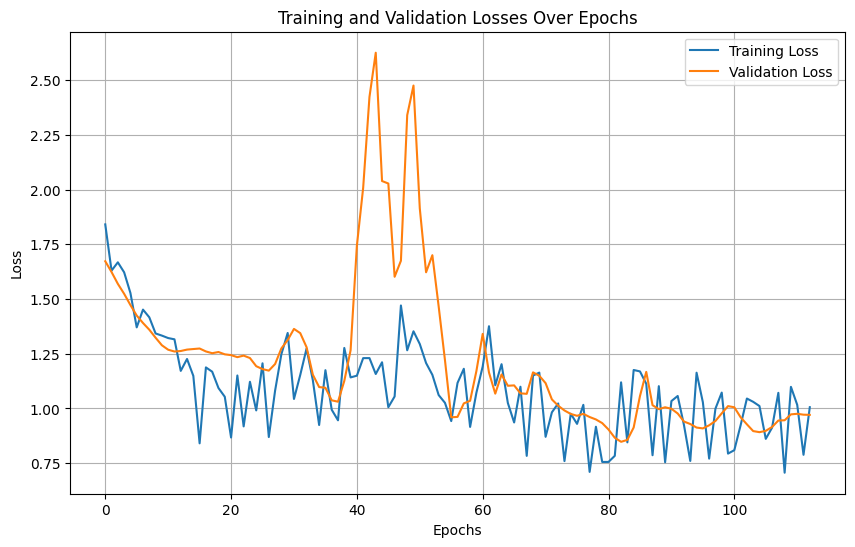

Model weights saved to model.pth


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model  # اطمینان حاصل کنید که model.py در همان دایرکتوری قرار دارد
import numpy as np

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تعریف MixUp به صورت جداگانه
def mixup_data(inputs, targets, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = inputs.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
    targets_a, targets_b = targets, targets[index]
    return mixed_inputs, targets_a, targets_b, lam

# تعریف افزونه‌های داده بدون MixUp
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.classes = [item for item in os.listdir(self.image_dir)
                       if os.path.isdir(os.path.join(self.image_dir, item))]

        self.samples = []
        for class_name in self.classes:
            if class_name in allowed_classes:
                class_path = os.path.join(self.image_dir, class_name)
                images = os.listdir(class_path)
                for img in images:
                    self.samples.append([img, class_name])

        random.seed(87)
        random.shuffle(self.samples)

        split_ratio = 0.6
        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_filename, class_name = self.images[index]
        image_path = os.path.join(self.image_dir, class_name, image_filename)

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        else:
            image = test_transforms(image)

        if class_name != "unlabeled":
            class_id = self.allowed_classes.index(class_name)
        else:
            class_id = -1

        return image, class_id

def get_data_loaders(image_dir: str, batch_size: int = 64, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=train_transforms,
        dataset_type='Train'
    )

    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=classes,
        transform=test_transforms,
        dataset_type='Test'
    )

    unlabeled_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=["unlabeled"],
        transform=test_transforms,
        dataset_type=None
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, unlabeled_loader

def train_supervised(model: nn.Module,
                    train_loader: DataLoader,
                    val_loader: DataLoader,
                    num_epochs: int = 100,
                    patience: int = 30) -> Tuple[nn.Module, List[List[float]]]:
    # تعریف تابع از دست دادن مناسب
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

    scores = [[], []]

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for (inputs, labels) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # اعمال MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=1.0)
            # Convert to Variables (در نسخه‌های جدید PyTorch نیازی به این کار نیست)
            # mixed_inputs, targets_a, targets_b = map(torch.autograd.Variable, (mixed_inputs, targets_a, targets_b))

            optimizer.zero_grad()

            outputs = model(mixed_inputs)
            loss_a = criterion(outputs, targets_a)
            loss_b = criterion(outputs, targets_b)
            loss = lam * loss_a + (1 - lam) * loss_b

            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # اعتبارسنجی
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for (inputs, labels) in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.")

        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    # ارزیابی نهایی
    model.eval()
    all_preds = []
    all_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for (inputs, labels) in tqdm(val_loader, desc="Final Evaluation on Validation Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_val_loss = running_val_loss / len(val_loader.dataset)
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    final_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final F1 Score on Validation set: {final_f1:.4f}')
    print(f'Final Accuracy on Validation set: {final_accuracy:.4f}')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"

    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=64, num_workers=2)

    model = Model()
    model.to(device)

    num_epochs = 200
    patience = 30

    trained_model, training_scores = train_supervised(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

if __name__ == "__main__":
    main()


#v0.5 : 0.25

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        self.base_model = models.mobilenet_v3_small(weights=None)
        self.base_model.classifier[3] = nn.Linear(self.base_model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 1/200, Training Loss: 1.7390, Validation Loss: 1.6477
F1 Score on Validation set: 0.2060, Accuracy on Validation set: 0.2500
Validation loss improved. Saving best model state.


Epoch 2/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 2/200, Training Loss: 1.6195, Validation Loss: 1.6088
F1 Score on Validation set: 0.2016, Accuracy on Validation set: 0.2500
Validation loss improved. Saving best model state.


Epoch 3/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch 3/200, Training Loss: 1.5572, Validation Loss: 1.5835
F1 Score on Validation set: 0.1762, Accuracy on Validation set: 0.2333
Validation loss improved. Saving best model state.


Epoch 4/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 4/200, Training Loss: 1.4244, Validation Loss: 1.5301
F1 Score on Validation set: 0.2552, Accuracy on Validation set: 0.2833
Validation loss improved. Saving best model state.


Epoch 5/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 5/200, Training Loss: 1.6268, Validation Loss: 1.4567
F1 Score on Validation set: 0.2944, Accuracy on Validation set: 0.3167
Validation loss improved. Saving best model state.


Epoch 6/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 6/200, Training Loss: 1.3988, Validation Loss: 1.3837
F1 Score on Validation set: 0.2958, Accuracy on Validation set: 0.3000
Validation loss improved. Saving best model state.


Epoch 7/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 7/200, Training Loss: 1.4524, Validation Loss: 1.3435
F1 Score on Validation set: 0.3825, Accuracy on Validation set: 0.3833
Validation loss improved. Saving best model state.


Epoch 8/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch 8/200, Training Loss: 1.1980, Validation Loss: 1.2952
F1 Score on Validation set: 0.4272, Accuracy on Validation set: 0.4167
Validation loss improved. Saving best model state.


Epoch 9/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch 9/200, Training Loss: 1.4175, Validation Loss: 1.2637
F1 Score on Validation set: 0.4221, Accuracy on Validation set: 0.4167
Validation loss improved. Saving best model state.


Epoch 10/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 10/200, Training Loss: 1.2584, Validation Loss: 1.2458
F1 Score on Validation set: 0.4478, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.


Epoch 11/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch 11/200, Training Loss: 1.0977, Validation Loss: 1.2353
F1 Score on Validation set: 0.4786, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 12/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 12/200, Training Loss: 1.2838, Validation Loss: 1.2398
F1 Score on Validation set: 0.4786, Accuracy on Validation set: 0.4833
No improvement in validation loss for 1 epochs.


Epoch 13/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch 13/200, Training Loss: 1.2715, Validation Loss: 1.2336
F1 Score on Validation set: 0.4724, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 14/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch 14/200, Training Loss: 1.1070, Validation Loss: 1.2260
F1 Score on Validation set: 0.5036, Accuracy on Validation set: 0.5167
Validation loss improved. Saving best model state.


Epoch 15/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch 15/200, Training Loss: 1.1694, Validation Loss: 1.2216
F1 Score on Validation set: 0.4694, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 16/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 16/200, Training Loss: 1.0123, Validation Loss: 1.2126
F1 Score on Validation set: 0.4687, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.


Epoch 17/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch 17/200, Training Loss: 1.1920, Validation Loss: 1.2206
F1 Score on Validation set: 0.4803, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.


Epoch 18/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch 18/200, Training Loss: 0.8541, Validation Loss: 1.2159
F1 Score on Validation set: 0.4706, Accuracy on Validation set: 0.4833
No improvement in validation loss for 2 epochs.


Epoch 19/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch 19/200, Training Loss: 1.1951, Validation Loss: 1.1996
F1 Score on Validation set: 0.5026, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 20/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 20/200, Training Loss: 1.2476, Validation Loss: 1.2041
F1 Score on Validation set: 0.5026, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.


Epoch 21/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch 21/200, Training Loss: 1.2072, Validation Loss: 1.2218
F1 Score on Validation set: 0.5195, Accuracy on Validation set: 0.5167
No improvement in validation loss for 2 epochs.


Epoch 22/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 22/200, Training Loss: 0.7928, Validation Loss: 1.2241
F1 Score on Validation set: 0.5363, Accuracy on Validation set: 0.5333
No improvement in validation loss for 3 epochs.


Epoch 23/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 23/200, Training Loss: 0.8705, Validation Loss: 1.1845
F1 Score on Validation set: 0.5517, Accuracy on Validation set: 0.5500
Validation loss improved. Saving best model state.


Epoch 24/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 24/200, Training Loss: 1.2040, Validation Loss: 1.1561
F1 Score on Validation set: 0.5198, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.


Epoch 25/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 25/200, Training Loss: 0.9618, Validation Loss: 1.1320
F1 Score on Validation set: 0.5842, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.


Epoch 26/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 26/200, Training Loss: 1.1134, Validation Loss: 1.1509
F1 Score on Validation set: 0.5391, Accuracy on Validation set: 0.5667
No improvement in validation loss for 1 epochs.


Epoch 27/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 27/200, Training Loss: 0.7206, Validation Loss: 1.1462
F1 Score on Validation set: 0.5153, Accuracy on Validation set: 0.5500
No improvement in validation loss for 2 epochs.


Epoch 28/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch 28/200, Training Loss: 0.7208, Validation Loss: 1.1405
F1 Score on Validation set: 0.5525, Accuracy on Validation set: 0.5833
No improvement in validation loss for 3 epochs.


Epoch 29/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 29/200, Training Loss: 1.2682, Validation Loss: 1.1698
F1 Score on Validation set: 0.5797, Accuracy on Validation set: 0.6000
No improvement in validation loss for 4 epochs.


Epoch 30/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch 30/200, Training Loss: 1.2615, Validation Loss: 1.1973
F1 Score on Validation set: 0.5468, Accuracy on Validation set: 0.5667
No improvement in validation loss for 5 epochs.


Epoch 31/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch 31/200, Training Loss: 1.0871, Validation Loss: 1.2543
F1 Score on Validation set: 0.4528, Accuracy on Validation set: 0.4667
No improvement in validation loss for 6 epochs.


Epoch 32/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch 32/200, Training Loss: 0.9020, Validation Loss: 1.4137
F1 Score on Validation set: 0.4657, Accuracy on Validation set: 0.4667
No improvement in validation loss for 7 epochs.


Epoch 33/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch 33/200, Training Loss: 0.8614, Validation Loss: 1.6637
F1 Score on Validation set: 0.4372, Accuracy on Validation set: 0.4500
No improvement in validation loss for 8 epochs.


Epoch 34/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch 34/200, Training Loss: 1.4569, Validation Loss: 2.1398
F1 Score on Validation set: 0.3019, Accuracy on Validation set: 0.3500
No improvement in validation loss for 9 epochs.


Epoch 35/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch 35/200, Training Loss: 1.0139, Validation Loss: 2.2272
F1 Score on Validation set: 0.2762, Accuracy on Validation set: 0.3167
No improvement in validation loss for 10 epochs.


Epoch 36/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch 36/200, Training Loss: 1.1001, Validation Loss: 2.0936
F1 Score on Validation set: 0.2985, Accuracy on Validation set: 0.3333
No improvement in validation loss for 11 epochs.


Epoch 37/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 37/200, Training Loss: 1.4091, Validation Loss: 2.2975
F1 Score on Validation set: 0.2480, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.


Epoch 38/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch 38/200, Training Loss: 1.2516, Validation Loss: 2.3876
F1 Score on Validation set: 0.1940, Accuracy on Validation set: 0.2833
No improvement in validation loss for 13 epochs.


Epoch 39/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 39/200, Training Loss: 1.0576, Validation Loss: 2.2454
F1 Score on Validation set: 0.1286, Accuracy on Validation set: 0.2333
No improvement in validation loss for 14 epochs.


Epoch 40/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 40/200, Training Loss: 1.1404, Validation Loss: 1.8283
F1 Score on Validation set: 0.2680, Accuracy on Validation set: 0.2833
No improvement in validation loss for 15 epochs.


Epoch 41/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch 41/200, Training Loss: 1.2608, Validation Loss: 1.8075
F1 Score on Validation set: 0.3116, Accuracy on Validation set: 0.3167
No improvement in validation loss for 16 epochs.


Epoch 42/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch 42/200, Training Loss: 1.4227, Validation Loss: 1.9595
F1 Score on Validation set: 0.3050, Accuracy on Validation set: 0.3167
No improvement in validation loss for 17 epochs.


Epoch 43/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 43/200, Training Loss: 1.2325, Validation Loss: 1.9703
F1 Score on Validation set: 0.3596, Accuracy on Validation set: 0.3500
No improvement in validation loss for 18 epochs.


Epoch 44/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch 44/200, Training Loss: 1.1425, Validation Loss: 1.7603
F1 Score on Validation set: 0.3255, Accuracy on Validation set: 0.3500
No improvement in validation loss for 19 epochs.


Epoch 45/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch 45/200, Training Loss: 1.4636, Validation Loss: 1.6271
F1 Score on Validation set: 0.4476, Accuracy on Validation set: 0.4500
No improvement in validation loss for 20 epochs.


Epoch 46/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 46/200, Training Loss: 1.2492, Validation Loss: 1.7509
F1 Score on Validation set: 0.4110, Accuracy on Validation set: 0.4000
No improvement in validation loss for 21 epochs.


Epoch 47/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 47/200, Training Loss: 1.5348, Validation Loss: 1.7974
F1 Score on Validation set: 0.3518, Accuracy on Validation set: 0.4000
No improvement in validation loss for 22 epochs.


Epoch 48/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch 48/200, Training Loss: 1.1042, Validation Loss: 2.1216
F1 Score on Validation set: 0.3514, Accuracy on Validation set: 0.4167
No improvement in validation loss for 23 epochs.


Epoch 49/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch 49/200, Training Loss: 1.5623, Validation Loss: 1.7266
F1 Score on Validation set: 0.3500, Accuracy on Validation set: 0.4000
No improvement in validation loss for 24 epochs.


Epoch 50/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch 50/200, Training Loss: 1.5601, Validation Loss: 1.9128
F1 Score on Validation set: 0.3894, Accuracy on Validation set: 0.4167
No improvement in validation loss for 25 epochs.


Epoch 51/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch 51/200, Training Loss: 1.2889, Validation Loss: 1.8550
F1 Score on Validation set: 0.3229, Accuracy on Validation set: 0.3833
No improvement in validation loss for 26 epochs.


Epoch 52/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 52/200, Training Loss: 1.1430, Validation Loss: 1.3463
F1 Score on Validation set: 0.4487, Accuracy on Validation set: 0.4833
No improvement in validation loss for 27 epochs.


Epoch 53/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch 53/200, Training Loss: 1.0891, Validation Loss: 1.4137
F1 Score on Validation set: 0.3760, Accuracy on Validation set: 0.3833
No improvement in validation loss for 28 epochs.


Epoch 54/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 54/200, Training Loss: 1.3393, Validation Loss: 1.5750
F1 Score on Validation set: 0.2921, Accuracy on Validation set: 0.3167
No improvement in validation loss for 29 epochs.


Epoch 55/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch 55/200, Training Loss: 1.2188, Validation Loss: 1.4997
F1 Score on Validation set: 0.2381, Accuracy on Validation set: 0.2667
No improvement in validation loss for 30 epochs.


Epoch 56/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 56/200, Training Loss: 1.1626, Validation Loss: 1.4242
F1 Score on Validation set: 0.3730, Accuracy on Validation set: 0.3833
No improvement in validation loss for 31 epochs.


Epoch 57/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Epoch 57/200, Training Loss: 0.8318, Validation Loss: 1.3655
F1 Score on Validation set: 0.3253, Accuracy on Validation set: 0.3500
No improvement in validation loss for 32 epochs.


Epoch 58/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch 58/200, Training Loss: 1.0758, Validation Loss: 1.1039
F1 Score on Validation set: 0.4708, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.


Epoch 59/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch 59/200, Training Loss: 1.1980, Validation Loss: 0.9484
F1 Score on Validation set: 0.5827, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 60/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 60/200, Training Loss: 1.1387, Validation Loss: 0.9505
F1 Score on Validation set: 0.5822, Accuracy on Validation set: 0.5833
No improvement in validation loss for 1 epochs.


Epoch 61/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 61/200, Training Loss: 0.8818, Validation Loss: 0.9487
F1 Score on Validation set: 0.5875, Accuracy on Validation set: 0.5833
No improvement in validation loss for 2 epochs.


Epoch 62/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 62/200, Training Loss: 1.3503, Validation Loss: 1.0350
F1 Score on Validation set: 0.5575, Accuracy on Validation set: 0.5500
No improvement in validation loss for 3 epochs.


Epoch 63/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 63/200, Training Loss: 1.2501, Validation Loss: 1.1905
F1 Score on Validation set: 0.4726, Accuracy on Validation set: 0.4667
No improvement in validation loss for 4 epochs.


Epoch 64/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 64/200, Training Loss: 1.1767, Validation Loss: 1.3101
F1 Score on Validation set: 0.3549, Accuracy on Validation set: 0.3833
No improvement in validation loss for 5 epochs.


Epoch 65/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 65/200, Training Loss: 1.1493, Validation Loss: 1.1910
F1 Score on Validation set: 0.4263, Accuracy on Validation set: 0.4333
No improvement in validation loss for 6 epochs.


Epoch 66/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 66/200, Training Loss: 1.0215, Validation Loss: 0.9950
F1 Score on Validation set: 0.5671, Accuracy on Validation set: 0.5833
No improvement in validation loss for 7 epochs.


Epoch 67/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 67/200, Training Loss: 1.0669, Validation Loss: 0.9210
F1 Score on Validation set: 0.6838, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.


Epoch 68/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 68/200, Training Loss: 0.9816, Validation Loss: 0.9229
F1 Score on Validation set: 0.6806, Accuracy on Validation set: 0.6667
No improvement in validation loss for 1 epochs.


Epoch 69/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch 69/200, Training Loss: 0.9969, Validation Loss: 0.9580
F1 Score on Validation set: 0.6464, Accuracy on Validation set: 0.6500
No improvement in validation loss for 2 epochs.


Epoch 70/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch 70/200, Training Loss: 0.9493, Validation Loss: 0.9428
F1 Score on Validation set: 0.6511, Accuracy on Validation set: 0.6667
No improvement in validation loss for 3 epochs.


Epoch 71/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 71/200, Training Loss: 0.7777, Validation Loss: 1.0048
F1 Score on Validation set: 0.5852, Accuracy on Validation set: 0.6167
No improvement in validation loss for 4 epochs.


Epoch 72/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch 72/200, Training Loss: 0.9969, Validation Loss: 1.0962
F1 Score on Validation set: 0.5676, Accuracy on Validation set: 0.6167
No improvement in validation loss for 5 epochs.


Epoch 73/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch 73/200, Training Loss: 1.0440, Validation Loss: 1.1537
F1 Score on Validation set: 0.5568, Accuracy on Validation set: 0.6000
No improvement in validation loss for 6 epochs.


Epoch 74/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 74/200, Training Loss: 1.1282, Validation Loss: 1.1752
F1 Score on Validation set: 0.4846, Accuracy on Validation set: 0.5500
No improvement in validation loss for 7 epochs.


Epoch 75/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch 75/200, Training Loss: 1.1999, Validation Loss: 1.1870
F1 Score on Validation set: 0.5058, Accuracy on Validation set: 0.5500
No improvement in validation loss for 8 epochs.


Epoch 76/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 76/200, Training Loss: 1.1013, Validation Loss: 1.0973
F1 Score on Validation set: 0.4960, Accuracy on Validation set: 0.5000
No improvement in validation loss for 9 epochs.


Epoch 77/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 77/200, Training Loss: 1.0511, Validation Loss: 1.0179
F1 Score on Validation set: 0.5041, Accuracy on Validation set: 0.5000
No improvement in validation loss for 10 epochs.


Epoch 78/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Epoch 78/200, Training Loss: 0.7936, Validation Loss: 1.0204
F1 Score on Validation set: 0.5439, Accuracy on Validation set: 0.5500
No improvement in validation loss for 11 epochs.


Epoch 79/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch 79/200, Training Loss: 0.7861, Validation Loss: 1.0142
F1 Score on Validation set: 0.5585, Accuracy on Validation set: 0.5667
No improvement in validation loss for 12 epochs.


Epoch 80/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch 80/200, Training Loss: 0.9532, Validation Loss: 0.9708
F1 Score on Validation set: 0.5662, Accuracy on Validation set: 0.5833
No improvement in validation loss for 13 epochs.


Epoch 81/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch 81/200, Training Loss: 1.2020, Validation Loss: 0.9988
F1 Score on Validation set: 0.4817, Accuracy on Validation set: 0.5167
No improvement in validation loss for 14 epochs.


Epoch 82/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch 82/200, Training Loss: 0.9703, Validation Loss: 1.0180
F1 Score on Validation set: 0.4908, Accuracy on Validation set: 0.5333
No improvement in validation loss for 15 epochs.


Epoch 83/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 83/200, Training Loss: 1.0452, Validation Loss: 1.0290
F1 Score on Validation set: 0.5366, Accuracy on Validation set: 0.5667
No improvement in validation loss for 16 epochs.


Epoch 84/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 84/200, Training Loss: 0.7392, Validation Loss: 0.9706
F1 Score on Validation set: 0.5503, Accuracy on Validation set: 0.5833
No improvement in validation loss for 17 epochs.


Epoch 85/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 85/200, Training Loss: 1.1848, Validation Loss: 0.9803
F1 Score on Validation set: 0.5761, Accuracy on Validation set: 0.6167
No improvement in validation loss for 18 epochs.


Epoch 86/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 86/200, Training Loss: 1.2021, Validation Loss: 1.0466
F1 Score on Validation set: 0.4730, Accuracy on Validation set: 0.5167
No improvement in validation loss for 19 epochs.


Epoch 87/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch 87/200, Training Loss: 0.8348, Validation Loss: 1.0507
F1 Score on Validation set: 0.4988, Accuracy on Validation set: 0.5167
No improvement in validation loss for 20 epochs.


Epoch 88/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 88/200, Training Loss: 0.8214, Validation Loss: 1.0231
F1 Score on Validation set: 0.5237, Accuracy on Validation set: 0.5500
No improvement in validation loss for 21 epochs.


Epoch 89/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 89/200, Training Loss: 1.1142, Validation Loss: 0.9632
F1 Score on Validation set: 0.5207, Accuracy on Validation set: 0.5333
No improvement in validation loss for 22 epochs.


Epoch 90/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch 90/200, Training Loss: 0.7595, Validation Loss: 0.9190
F1 Score on Validation set: 0.5833, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.


Epoch 91/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch 91/200, Training Loss: 0.7982, Validation Loss: 0.8894
F1 Score on Validation set: 0.6134, Accuracy on Validation set: 0.6167
Validation loss improved. Saving best model state.


Epoch 92/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 92/200, Training Loss: 1.0777, Validation Loss: 0.8697
F1 Score on Validation set: 0.6891, Accuracy on Validation set: 0.6833
Validation loss improved. Saving best model state.


Epoch 93/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch 93/200, Training Loss: 0.7858, Validation Loss: 0.8699
F1 Score on Validation set: 0.7208, Accuracy on Validation set: 0.7167
No improvement in validation loss for 1 epochs.


Epoch 94/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch 94/200, Training Loss: 1.0339, Validation Loss: 0.8811
F1 Score on Validation set: 0.7036, Accuracy on Validation set: 0.7000
No improvement in validation loss for 2 epochs.


Epoch 95/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 95/200, Training Loss: 1.0563, Validation Loss: 0.8861
F1 Score on Validation set: 0.7094, Accuracy on Validation set: 0.7000
No improvement in validation loss for 3 epochs.


Epoch 96/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch 96/200, Training Loss: 0.8999, Validation Loss: 0.8766
F1 Score on Validation set: 0.6658, Accuracy on Validation set: 0.6667
No improvement in validation loss for 4 epochs.


Epoch 97/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch 97/200, Training Loss: 0.9439, Validation Loss: 0.8946
F1 Score on Validation set: 0.6964, Accuracy on Validation set: 0.7000
No improvement in validation loss for 5 epochs.


Epoch 98/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch 98/200, Training Loss: 0.7918, Validation Loss: 0.8909
F1 Score on Validation set: 0.6488, Accuracy on Validation set: 0.6500
No improvement in validation loss for 6 epochs.


Epoch 99/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch 99/200, Training Loss: 1.1357, Validation Loss: 0.8917
F1 Score on Validation set: 0.6712, Accuracy on Validation set: 0.6667
No improvement in validation loss for 7 epochs.


Epoch 100/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch 100/200, Training Loss: 0.7681, Validation Loss: 0.9009
F1 Score on Validation set: 0.6597, Accuracy on Validation set: 0.6500
No improvement in validation loss for 8 epochs.


Epoch 101/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 101/200, Training Loss: 0.8337, Validation Loss: 0.9334
F1 Score on Validation set: 0.6311, Accuracy on Validation set: 0.6167
No improvement in validation loss for 9 epochs.


Epoch 102/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch 102/200, Training Loss: 0.9792, Validation Loss: 0.9559
F1 Score on Validation set: 0.5996, Accuracy on Validation set: 0.5833
No improvement in validation loss for 10 epochs.


Epoch 103/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch 103/200, Training Loss: 1.0513, Validation Loss: 0.9646
F1 Score on Validation set: 0.5986, Accuracy on Validation set: 0.5833
No improvement in validation loss for 11 epochs.


Epoch 104/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch 104/200, Training Loss: 0.7354, Validation Loss: 0.9497
F1 Score on Validation set: 0.6392, Accuracy on Validation set: 0.6333
No improvement in validation loss for 12 epochs.


Epoch 105/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch 105/200, Training Loss: 0.9525, Validation Loss: 0.9569
F1 Score on Validation set: 0.6403, Accuracy on Validation set: 0.6333
No improvement in validation loss for 13 epochs.


Epoch 106/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 106/200, Training Loss: 1.0783, Validation Loss: 0.9464
F1 Score on Validation set: 0.6369, Accuracy on Validation set: 0.6333
No improvement in validation loss for 14 epochs.


Epoch 107/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 107/200, Training Loss: 0.8760, Validation Loss: 0.9336
F1 Score on Validation set: 0.6369, Accuracy on Validation set: 0.6333
No improvement in validation loss for 15 epochs.


Epoch 108/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch 108/200, Training Loss: 1.0437, Validation Loss: 0.9281
F1 Score on Validation set: 0.6535, Accuracy on Validation set: 0.6500
No improvement in validation loss for 16 epochs.


Epoch 109/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch 109/200, Training Loss: 1.0469, Validation Loss: 0.9465
F1 Score on Validation set: 0.6502, Accuracy on Validation set: 0.6500
No improvement in validation loss for 17 epochs.


Epoch 110/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch 110/200, Training Loss: 1.0133, Validation Loss: 0.9723
F1 Score on Validation set: 0.6527, Accuracy on Validation set: 0.6500
No improvement in validation loss for 18 epochs.


Epoch 111/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Epoch 111/200, Training Loss: 1.0233, Validation Loss: 1.0140
F1 Score on Validation set: 0.6708, Accuracy on Validation set: 0.6667
No improvement in validation loss for 19 epochs.


Epoch 112/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 112/200, Training Loss: 1.0925, Validation Loss: 1.0181
F1 Score on Validation set: 0.6325, Accuracy on Validation set: 0.6333
No improvement in validation loss for 20 epochs.


Epoch 113/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 113/200, Training Loss: 1.0959, Validation Loss: 0.9863
F1 Score on Validation set: 0.6252, Accuracy on Validation set: 0.6333
No improvement in validation loss for 21 epochs.


Epoch 114/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch 114/200, Training Loss: 1.1005, Validation Loss: 0.9290
F1 Score on Validation set: 0.6525, Accuracy on Validation set: 0.6667
No improvement in validation loss for 22 epochs.


Epoch 115/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch 115/200, Training Loss: 0.9282, Validation Loss: 0.9045
F1 Score on Validation set: 0.6556, Accuracy on Validation set: 0.6667
No improvement in validation loss for 23 epochs.


Epoch 116/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch 116/200, Training Loss: 1.0686, Validation Loss: 0.8930
F1 Score on Validation set: 0.6776, Accuracy on Validation set: 0.6833
No improvement in validation loss for 24 epochs.


Epoch 117/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch 117/200, Training Loss: 0.9905, Validation Loss: 0.8939
F1 Score on Validation set: 0.6631, Accuracy on Validation set: 0.6667
No improvement in validation loss for 25 epochs.


Epoch 118/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 118/200, Training Loss: 0.8118, Validation Loss: 0.8911
F1 Score on Validation set: 0.7037, Accuracy on Validation set: 0.7000
No improvement in validation loss for 26 epochs.


Epoch 119/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch 119/200, Training Loss: 0.9007, Validation Loss: 0.8871
F1 Score on Validation set: 0.7037, Accuracy on Validation set: 0.7000
No improvement in validation loss for 27 epochs.


Epoch 120/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch 120/200, Training Loss: 0.9125, Validation Loss: 0.8864
F1 Score on Validation set: 0.7203, Accuracy on Validation set: 0.7167
No improvement in validation loss for 28 epochs.


Epoch 121/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch 121/200, Training Loss: 0.9136, Validation Loss: 0.9000
F1 Score on Validation set: 0.7368, Accuracy on Validation set: 0.7333
No improvement in validation loss for 29 epochs.


Epoch 122/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch 122/200, Training Loss: 0.9309, Validation Loss: 0.8985
F1 Score on Validation set: 0.7375, Accuracy on Validation set: 0.7333
No improvement in validation loss for 30 epochs.


Epoch 123/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch 123/200, Training Loss: 0.6584, Validation Loss: 0.9105
F1 Score on Validation set: 0.7284, Accuracy on Validation set: 0.7167
No improvement in validation loss for 31 epochs.


Epoch 124/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 124/200, Training Loss: 0.8661, Validation Loss: 0.9131
F1 Score on Validation set: 0.6801, Accuracy on Validation set: 0.6667
No improvement in validation loss for 32 epochs.


Epoch 125/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch 125/200, Training Loss: 0.9201, Validation Loss: 0.9191
F1 Score on Validation set: 0.6645, Accuracy on Validation set: 0.6500
No improvement in validation loss for 33 epochs.


Epoch 126/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 126/200, Training Loss: 0.8541, Validation Loss: 0.9304
F1 Score on Validation set: 0.6674, Accuracy on Validation set: 0.6500
No improvement in validation loss for 34 epochs.


Epoch 127/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 127/200, Training Loss: 0.5725, Validation Loss: 0.9590
F1 Score on Validation set: 0.6144, Accuracy on Validation set: 0.6000
No improvement in validation loss for 35 epochs.


Epoch 128/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 128/200, Training Loss: 0.5137, Validation Loss: 0.9857
F1 Score on Validation set: 0.6003, Accuracy on Validation set: 0.5833
No improvement in validation loss for 36 epochs.


Epoch 129/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch 129/200, Training Loss: 1.0976, Validation Loss: 1.0124
F1 Score on Validation set: 0.6003, Accuracy on Validation set: 0.5833
No improvement in validation loss for 37 epochs.


Epoch 130/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch 130/200, Training Loss: 0.6668, Validation Loss: 1.0262
F1 Score on Validation set: 0.5794, Accuracy on Validation set: 0.5667
No improvement in validation loss for 38 epochs.


Epoch 131/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch 131/200, Training Loss: 0.9379, Validation Loss: 1.0505
F1 Score on Validation set: 0.5645, Accuracy on Validation set: 0.5500
No improvement in validation loss for 39 epochs.


Epoch 132/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch 132/200, Training Loss: 1.1116, Validation Loss: 1.0833
F1 Score on Validation set: 0.5584, Accuracy on Validation set: 0.5500
No improvement in validation loss for 40 epochs.


Epoch 133/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch 133/200, Training Loss: 0.9770, Validation Loss: 1.0524
F1 Score on Validation set: 0.5542, Accuracy on Validation set: 0.5500
No improvement in validation loss for 41 epochs.


Epoch 134/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch 134/200, Training Loss: 0.9409, Validation Loss: 1.0108
F1 Score on Validation set: 0.6136, Accuracy on Validation set: 0.6167
No improvement in validation loss for 42 epochs.


Epoch 135/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Epoch 135/200, Training Loss: 1.1579, Validation Loss: 0.9874
F1 Score on Validation set: 0.6564, Accuracy on Validation set: 0.6500
No improvement in validation loss for 43 epochs.


Epoch 136/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 136/200, Training Loss: 0.9544, Validation Loss: 0.9609
F1 Score on Validation set: 0.6434, Accuracy on Validation set: 0.6333
No improvement in validation loss for 44 epochs.


Epoch 137/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch 137/200, Training Loss: 1.0318, Validation Loss: 0.9550
F1 Score on Validation set: 0.6613, Accuracy on Validation set: 0.6500
No improvement in validation loss for 45 epochs.


Epoch 138/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch 138/200, Training Loss: 0.9954, Validation Loss: 0.9483
F1 Score on Validation set: 0.6613, Accuracy on Validation set: 0.6500
No improvement in validation loss for 46 epochs.


Epoch 139/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch 139/200, Training Loss: 0.9510, Validation Loss: 0.9541
F1 Score on Validation set: 0.6614, Accuracy on Validation set: 0.6500
No improvement in validation loss for 47 epochs.


Epoch 140/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Epoch 140/200, Training Loss: 1.0797, Validation Loss: 0.9656
F1 Score on Validation set: 0.6614, Accuracy on Validation set: 0.6500
No improvement in validation loss for 48 epochs.


Epoch 141/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 141/200, Training Loss: 0.8679, Validation Loss: 0.9601
F1 Score on Validation set: 0.6614, Accuracy on Validation set: 0.6500
No improvement in validation loss for 49 epochs.


Epoch 142/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch 142/200, Training Loss: 0.8807, Validation Loss: 0.9540
F1 Score on Validation set: 0.6614, Accuracy on Validation set: 0.6500
No improvement in validation loss for 50 epochs.


Epoch 143/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch 143/200, Training Loss: 0.6909, Validation Loss: 0.9417
F1 Score on Validation set: 0.6574, Accuracy on Validation set: 0.6500
No improvement in validation loss for 51 epochs.


Epoch 144/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch 144/200, Training Loss: 0.7601, Validation Loss: 0.9417
F1 Score on Validation set: 0.6574, Accuracy on Validation set: 0.6500
No improvement in validation loss for 52 epochs.


Epoch 145/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 145/200, Training Loss: 0.8215, Validation Loss: 0.9373
F1 Score on Validation set: 0.6165, Accuracy on Validation set: 0.6167
No improvement in validation loss for 53 epochs.


Epoch 146/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch 146/200, Training Loss: 0.9931, Validation Loss: 0.9424
F1 Score on Validation set: 0.6165, Accuracy on Validation set: 0.6167
No improvement in validation loss for 54 epochs.


Epoch 147/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 147/200, Training Loss: 1.0040, Validation Loss: 0.9438
F1 Score on Validation set: 0.6309, Accuracy on Validation set: 0.6333
No improvement in validation loss for 55 epochs.


Epoch 148/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 148/200, Training Loss: 0.9280, Validation Loss: 0.9450
F1 Score on Validation set: 0.6603, Accuracy on Validation set: 0.6667
No improvement in validation loss for 56 epochs.


Epoch 149/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch 149/200, Training Loss: 0.9847, Validation Loss: 0.9477
F1 Score on Validation set: 0.6572, Accuracy on Validation set: 0.6667
No improvement in validation loss for 57 epochs.


Epoch 150/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch 150/200, Training Loss: 0.5403, Validation Loss: 0.9444
F1 Score on Validation set: 0.6538, Accuracy on Validation set: 0.6667
No improvement in validation loss for 58 epochs.


Epoch 151/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch 151/200, Training Loss: 0.9613, Validation Loss: 0.9468
F1 Score on Validation set: 0.6538, Accuracy on Validation set: 0.6667
No improvement in validation loss for 59 epochs.


Epoch 152/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch 152/200, Training Loss: 0.9516, Validation Loss: 0.9506
F1 Score on Validation set: 0.6538, Accuracy on Validation set: 0.6667
No improvement in validation loss for 60 epochs.


Epoch 153/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch 153/200, Training Loss: 1.0309, Validation Loss: 0.9563
F1 Score on Validation set: 0.6538, Accuracy on Validation set: 0.6667
No improvement in validation loss for 61 epochs.


Epoch 154/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch 154/200, Training Loss: 1.1442, Validation Loss: 0.9549
F1 Score on Validation set: 0.6395, Accuracy on Validation set: 0.6500
No improvement in validation loss for 62 epochs.


Epoch 155/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch 155/200, Training Loss: 1.0777, Validation Loss: 0.9495
F1 Score on Validation set: 0.6256, Accuracy on Validation set: 0.6333
No improvement in validation loss for 63 epochs.


Epoch 156/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch 156/200, Training Loss: 0.9047, Validation Loss: 0.9481
F1 Score on Validation set: 0.6256, Accuracy on Validation set: 0.6333
No improvement in validation loss for 64 epochs.


Epoch 157/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 157/200, Training Loss: 1.0162, Validation Loss: 0.9530
F1 Score on Validation set: 0.6481, Accuracy on Validation set: 0.6500
No improvement in validation loss for 65 epochs.


Epoch 158/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch 158/200, Training Loss: 1.0437, Validation Loss: 0.9552
F1 Score on Validation set: 0.6481, Accuracy on Validation set: 0.6500
No improvement in validation loss for 66 epochs.


Epoch 159/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch 159/200, Training Loss: 0.9008, Validation Loss: 0.9521
F1 Score on Validation set: 0.6481, Accuracy on Validation set: 0.6500
No improvement in validation loss for 67 epochs.


Epoch 160/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch 160/200, Training Loss: 0.7524, Validation Loss: 0.9476
F1 Score on Validation set: 0.6669, Accuracy on Validation set: 0.6667
No improvement in validation loss for 68 epochs.


Epoch 161/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch 161/200, Training Loss: 0.9626, Validation Loss: 0.9508
F1 Score on Validation set: 0.6669, Accuracy on Validation set: 0.6667
No improvement in validation loss for 69 epochs.


Epoch 162/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 162/200, Training Loss: 0.6165, Validation Loss: 0.9498
F1 Score on Validation set: 0.6819, Accuracy on Validation set: 0.6833
No improvement in validation loss for 70 epochs.


Epoch 163/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch 163/200, Training Loss: 0.9376, Validation Loss: 0.9480
F1 Score on Validation set: 0.6819, Accuracy on Validation set: 0.6833
No improvement in validation loss for 71 epochs.


Epoch 164/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 164/200, Training Loss: 1.0181, Validation Loss: 0.9465
F1 Score on Validation set: 0.6626, Accuracy on Validation set: 0.6667
No improvement in validation loss for 72 epochs.


Epoch 165/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 165/200, Training Loss: 0.8643, Validation Loss: 0.9478
F1 Score on Validation set: 0.6626, Accuracy on Validation set: 0.6667
No improvement in validation loss for 73 epochs.


Epoch 166/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 166/200, Training Loss: 0.8512, Validation Loss: 0.9504
F1 Score on Validation set: 0.6395, Accuracy on Validation set: 0.6500
No improvement in validation loss for 74 epochs.


Epoch 167/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 167/200, Training Loss: 0.8859, Validation Loss: 0.9539
F1 Score on Validation set: 0.6420, Accuracy on Validation set: 0.6500
No improvement in validation loss for 75 epochs.


Epoch 168/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 168/200, Training Loss: 0.8541, Validation Loss: 0.9536
F1 Score on Validation set: 0.6277, Accuracy on Validation set: 0.6333
No improvement in validation loss for 76 epochs.


Epoch 169/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 169/200, Training Loss: 0.9408, Validation Loss: 0.9541
F1 Score on Validation set: 0.6395, Accuracy on Validation set: 0.6500
No improvement in validation loss for 77 epochs.


Epoch 170/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch 170/200, Training Loss: 0.8647, Validation Loss: 0.9564
F1 Score on Validation set: 0.6451, Accuracy on Validation set: 0.6500
No improvement in validation loss for 78 epochs.


Epoch 171/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 171/200, Training Loss: 0.6172, Validation Loss: 0.9540
F1 Score on Validation set: 0.6689, Accuracy on Validation set: 0.6667
No improvement in validation loss for 79 epochs.


Epoch 172/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch 172/200, Training Loss: 0.7788, Validation Loss: 0.9496
F1 Score on Validation set: 0.7054, Accuracy on Validation set: 0.7000
No improvement in validation loss for 80 epochs.


Epoch 173/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch 173/200, Training Loss: 0.8601, Validation Loss: 0.9486
F1 Score on Validation set: 0.7054, Accuracy on Validation set: 0.7000
No improvement in validation loss for 81 epochs.


Epoch 174/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch 174/200, Training Loss: 0.9771, Validation Loss: 0.9519
F1 Score on Validation set: 0.6689, Accuracy on Validation set: 0.6667
No improvement in validation loss for 82 epochs.


Epoch 175/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch 175/200, Training Loss: 0.7846, Validation Loss: 0.9595
F1 Score on Validation set: 0.6592, Accuracy on Validation set: 0.6500
No improvement in validation loss for 83 epochs.


Epoch 176/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch 176/200, Training Loss: 0.7819, Validation Loss: 0.9669
F1 Score on Validation set: 0.6631, Accuracy on Validation set: 0.6500
No improvement in validation loss for 84 epochs.


Epoch 177/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch 177/200, Training Loss: 0.9948, Validation Loss: 0.9652
F1 Score on Validation set: 0.6631, Accuracy on Validation set: 0.6500
No improvement in validation loss for 85 epochs.


Epoch 178/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch 178/200, Training Loss: 0.9605, Validation Loss: 0.9595
F1 Score on Validation set: 0.6631, Accuracy on Validation set: 0.6500
No improvement in validation loss for 86 epochs.


Epoch 179/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 179/200, Training Loss: 0.9663, Validation Loss: 0.9638
F1 Score on Validation set: 0.6631, Accuracy on Validation set: 0.6500
No improvement in validation loss for 87 epochs.


Epoch 180/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 180/200, Training Loss: 0.9052, Validation Loss: 0.9607
F1 Score on Validation set: 0.6631, Accuracy on Validation set: 0.6500
No improvement in validation loss for 88 epochs.


Epoch 181/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 181/200, Training Loss: 0.9347, Validation Loss: 0.9554
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 89 epochs.


Epoch 182/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch 182/200, Training Loss: 0.9465, Validation Loss: 0.9562
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 90 epochs.


Epoch 183/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch 183/200, Training Loss: 0.9384, Validation Loss: 0.9555
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 91 epochs.


Epoch 184/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 184/200, Training Loss: 1.0651, Validation Loss: 0.9567
F1 Score on Validation set: 0.6769, Accuracy on Validation set: 0.6667
No improvement in validation loss for 92 epochs.


Epoch 185/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch 185/200, Training Loss: 0.9702, Validation Loss: 0.9572
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 93 epochs.


Epoch 186/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch 186/200, Training Loss: 0.8522, Validation Loss: 0.9532
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 94 epochs.


Epoch 187/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 187/200, Training Loss: 0.9080, Validation Loss: 0.9522
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 95 epochs.


Epoch 188/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 188/200, Training Loss: 0.8354, Validation Loss: 0.9490
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 96 epochs.


Epoch 189/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 189/200, Training Loss: 0.8816, Validation Loss: 0.9498
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 97 epochs.


Epoch 190/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch 190/200, Training Loss: 0.7765, Validation Loss: 0.9418
F1 Score on Validation set: 0.6877, Accuracy on Validation set: 0.6833
No improvement in validation loss for 98 epochs.


Epoch 191/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch 191/200, Training Loss: 0.8175, Validation Loss: 0.9502
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 99 epochs.


Epoch 192/200 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch 192/200, Training Loss: 0.7204, Validation Loss: 0.9502
F1 Score on Validation set: 0.6916, Accuracy on Validation set: 0.6833
No improvement in validation loss for 100 epochs.
Early stopping triggered after 192 epochs.
Best model loaded based on validation loss.


Final Evaluation on Validation Set: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Final Validation Loss: 0.8697
Final F1 Score on Validation set: 0.6891
Final Accuracy on Validation set: 0.6833


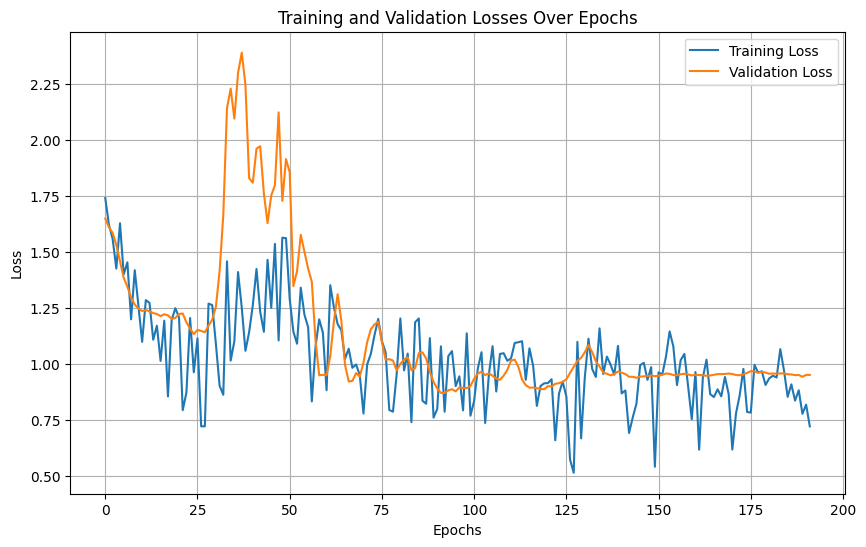

Model weights saved to model.pth


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np

# Set up device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def mixup_data(inputs, targets, alpha=1.0):
    '''MixUp data augmentation'''
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = inputs.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
    targets_a, targets_b = targets, targets[index]
    return mixed_inputs, targets_a, targets_b, lam

# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.classes = [item for item in os.listdir(self.image_dir)
                        if os.path.isdir(os.path.join(self.image_dir, item))]

        self.samples = [
            [img, class_name]
            for class_name in self.classes
            if class_name in allowed_classes
            for img in os.listdir(os.path.join(self.image_dir, class_name))
        ]

        random.seed(87)
        random.shuffle(self.samples)

        split_ratio = 0.6
        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_filename, class_name = self.images[index]
        image_path = os.path.join(self.image_dir, class_name, image_filename)

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image) if self.transform else test_transforms(image)

        class_id = self.allowed_classes.index(class_name) if class_name != "unlabeled" else -1

        return image, class_id

def get_data_loaders(image_dir: str, batch_size: int = 64, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    datasets = {
        'train': Birddataset(image_dir, classes, train_transforms, 'Train'),
        'val': Birddataset(image_dir, classes, test_transforms, 'Test'),
        'unlabeled': Birddataset(image_dir, ["unlabeled"], test_transforms, None)
    }

    loaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
        'unlabeled': DataLoader(datasets['unlabeled'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

    return loaders['train'], loaders['val'], loaders['unlabeled']

def train_supervised(model: nn.Module,
                     train_loader: DataLoader,
                     val_loader: DataLoader,
                     num_epochs: int = 100,
                     patience: int = 30) -> Tuple[nn.Module, List[List[float]]]:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

    scores = [[], []]
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=1.0)

            optimizer.zero_grad()
            outputs = model(mixed_inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.")

        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.')

    # Final evaluation
    model.eval()
    all_preds, all_labels = [], []
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Final Evaluation on Validation Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_val_loss = running_val_loss / len(val_loader.dataset)
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    final_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final F1 Score on Validation set: {final_f1:.4f}')
    print(f'Final Accuracy on Validation set: {final_accuracy:.4f}')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=64, num_workers=2)

    model = Model().to(device)
    num_epochs, patience = 200, 100

    trained_model, training_scores = train_supervised(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

if __name__ == "__main__":
    main()


#v0.7 claude : 0.2400

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        self.base_model = models.mobilenet_v3_small(weights=None)
        self.base_model.classifier[3] = nn.Linear(self.base_model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 1/300, Training Loss: 1.2339, Validation Loss: 1.5083
F1 Score on Validation set: 0.2517, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.



Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

Epoch 2/300, Training Loss: 1.0484, Validation Loss: 1.4758
F1 Score on Validation set: 0.2811, Accuracy on Validation set: 0.2833
Validation loss improved. Saving best model state.




Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

Epoch 3/300, Training Loss: 0.9999, Validation Loss: 1.4464
F1 Score on Validation set: 0.2373, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.




Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Epoch 4/300, Training Loss: 0.9485, Validation Loss: 1.4236
F1 Score on Validation set: 0.2750, Accuracy on Validation set: 0.3000
Validation loss improved. Saving best model state.




Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

Epoch 5/300, Training Loss: 0.9084, Validation Loss: 1.4092
F1 Score on Validation set: 0.2671, Accuracy on Validation set: 0.3167
Validation loss improved. Saving best model state.




Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Epoch 6/300, Training Loss: 0.8118, Validation Loss: 1.3951
F1 Score on Validation set: 0.2762, Accuracy on Validation set: 0.3333
Validation loss improved. Saving best model state.




Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Epoch 7/300, Training Loss: 0.8132, Validation Loss: 1.3880
F1 Score on Validation set: 0.3030, Accuracy on Validation set: 0.3667
Validation loss improved. Saving best model state.




Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 8/300, Training Loss: 0.7424, Validation Loss: 1.3755
F1 Score on Validation set: 0.2921, Accuracy on Validation set: 0.3500
Validation loss improved. Saving best model state.




Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

Epoch 9/300, Training Loss: 0.7399, Validation Loss: 1.3652
F1 Score on Validation set: 0.2921, Accuracy on Validation set: 0.3500
Validation loss improved. Saving best model state.




Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Epoch 10/300, Training Loss: 0.7075, Validation Loss: 1.3564
F1 Score on Validation set: 0.3221, Accuracy on Validation set: 0.3667
Validation loss improved. Saving best model state.




Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Epoch 11/300, Training Loss: 0.6334, Validation Loss: 1.3417
F1 Score on Validation set: 0.3365, Accuracy on Validation set: 0.3833
Validation loss improved. Saving best model state.




Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

Epoch 12/300, Training Loss: 0.5512, Validation Loss: 1.3277
F1 Score on Validation set: 0.3619, Accuracy on Validation set: 0.4000
Validation loss improved. Saving best model state.




Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 13/300, Training Loss: 0.6472, Validation Loss: 1.3159
F1 Score on Validation set: 0.3786, Accuracy on Validation set: 0.4167
Validation loss improved. Saving best model state.




Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Epoch 14/300, Training Loss: 0.6378, Validation Loss: 1.3043
F1 Score on Validation set: 0.3959, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.




Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

Epoch 15/300, Training Loss: 0.6407, Validation Loss: 1.2952
F1 Score on Validation set: 0.3895, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.




Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

Epoch 16/300, Training Loss: 0.6118, Validation Loss: 1.2802
F1 Score on Validation set: 0.3882, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.




Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

Epoch 17/300, Training Loss: 0.5637, Validation Loss: 1.2712
F1 Score on Validation set: 0.3885, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.




Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Epoch 18/300, Training Loss: 0.5957, Validation Loss: 1.2539
F1 Score on Validation set: 0.4148, Accuracy on Validation set: 0.4500
Validation loss improved. Saving best model state.




Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

Epoch 19/300, Training Loss: 0.5788, Validation Loss: 1.2438
F1 Score on Validation set: 0.4372, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.




Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch 20/300, Training Loss: 0.5891, Validation Loss: 1.2402
F1 Score on Validation set: 0.4598, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.



Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Epoch 21/300, Training Loss: 0.5615, Validation Loss: 1.2314
F1 Score on Validation set: 0.4587, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.




Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch 22/300, Training Loss: 0.5344, Validation Loss: 1.2193
F1 Score on Validation set: 0.4587, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.



Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Epoch 23/300, Training Loss: 0.5659, Validation Loss: 1.2107
F1 Score on Validation set: 0.4700, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.



Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Epoch 24/300, Training Loss: 0.5854, Validation Loss: 1.2066
F1 Score on Validation set: 0.4686, Accuracy on Validation set: 0.4833
Validation loss improved. Saving best model state.




Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

Epoch 25/300, Training Loss: 0.6044, Validation Loss: 1.1972
F1 Score on Validation set: 0.4884, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.




Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Epoch 26/300, Training Loss: 0.5562, Validation Loss: 1.1942
F1 Score on Validation set: 0.5079, Accuracy on Validation set: 0.5167
Validation loss improved. Saving best model state.




Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch 27/300, Training Loss: 0.5703, Validation Loss: 1.1915
F1 Score on Validation set: 0.5281, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.




Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Epoch 28/300, Training Loss: 0.5613, Validation Loss: 1.1923
F1 Score on Validation set: 0.5310, Accuracy on Validation set: 0.5333
No improvement in validation loss for 1 epochs.




Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Epoch 29/300, Training Loss: 0.5182, Validation Loss: 1.1919
F1 Score on Validation set: 0.5310, Accuracy on Validation set: 0.5333
No improvement in validation loss for 2 epochs.




Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Epoch 30/300, Training Loss: 0.5183, Validation Loss: 1.1891
F1 Score on Validation set: 0.5310, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.




Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Epoch 31/300, Training Loss: 0.5388, Validation Loss: 1.1910
F1 Score on Validation set: 0.5481, Accuracy on Validation set: 0.5500
No improvement in validation loss for 1 epochs.




Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

Epoch 32/300, Training Loss: 0.5739, Validation Loss: 1.1882
F1 Score on Validation set: 0.5648, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.




Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

Epoch 33/300, Training Loss: 0.5962, Validation Loss: 1.1947
F1 Score on Validation set: 0.5827, Accuracy on Validation set: 0.5833
No improvement in validation loss for 1 epochs.




Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

Epoch 34/300, Training Loss: 0.5846, Validation Loss: 1.1986
F1 Score on Validation set: 0.5586, Accuracy on Validation set: 0.5667
No improvement in validation loss for 2 epochs.




Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Epoch 35/300, Training Loss: 0.5316, Validation Loss: 1.1900
F1 Score on Validation set: 0.5269, Accuracy on Validation set: 0.5333
No improvement in validation loss for 3 epochs.




Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Epoch 36/300, Training Loss: 0.5727, Validation Loss: 1.1870
F1 Score on Validation set: 0.5581, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.




Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

Epoch 37/300, Training Loss: 0.5316, Validation Loss: 1.1840
F1 Score on Validation set: 0.5863, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.




Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Epoch 38/300, Training Loss: 0.5521, Validation Loss: 1.1834
F1 Score on Validation set: 0.5809, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.




Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

Epoch 39/300, Training Loss: 0.5382, Validation Loss: 1.1784
F1 Score on Validation set: 0.5663, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.




Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

Epoch 40/300, Training Loss: 0.5387, Validation Loss: 1.1760
F1 Score on Validation set: 0.5487, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.




Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Epoch 41/300, Training Loss: 0.5047, Validation Loss: 1.1726
F1 Score on Validation set: 0.5695, Accuracy on Validation set: 0.5833
Validation loss improved. Saving best model state.




Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

Epoch 42/300, Training Loss: 0.5803, Validation Loss: 1.1775
F1 Score on Validation set: 0.5711, Accuracy on Validation set: 0.5833
No improvement in validation loss for 1 epochs.




Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

Epoch 43/300, Training Loss: 0.5554, Validation Loss: 1.1750
F1 Score on Validation set: 0.5541, Accuracy on Validation set: 0.5667
No improvement in validation loss for 2 epochs.




Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

Epoch 44/300, Training Loss: 0.5736, Validation Loss: 1.1734
F1 Score on Validation set: 0.5846, Accuracy on Validation set: 0.6000
No improvement in validation loss for 3 epochs.




Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 45/300, Training Loss: 0.5784, Validation Loss: 1.1832
F1 Score on Validation set: 0.5418, Accuracy on Validation set: 0.5500
No improvement in validation loss for 4 epochs.




Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

Epoch 46/300, Training Loss: 0.5599, Validation Loss: 1.1879
F1 Score on Validation set: 0.5428, Accuracy on Validation set: 0.5500
No improvement in validation loss for 5 epochs.




Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 47/300, Training Loss: 0.5738, Validation Loss: 1.1930
F1 Score on Validation set: 0.5061, Accuracy on Validation set: 0.5000
No improvement in validation loss for 6 epochs.




Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 48/300, Training Loss: 0.6134, Validation Loss: 1.1877
F1 Score on Validation set: 0.4901, Accuracy on Validation set: 0.5000
No improvement in validation loss for 7 epochs.




Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 49/300, Training Loss: 0.5761, Validation Loss: 1.1736
F1 Score on Validation set: 0.4867, Accuracy on Validation set: 0.5000
No improvement in validation loss for 8 epochs.




Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 50/300, Training Loss: 0.6504, Validation Loss: 1.1947
F1 Score on Validation set: 0.4784, Accuracy on Validation set: 0.5000
No improvement in validation loss for 9 epochs.




Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 51/300, Training Loss: 0.5404, Validation Loss: 1.2389
F1 Score on Validation set: 0.4297, Accuracy on Validation set: 0.4667
No improvement in validation loss for 10 epochs.




Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 52/300, Training Loss: 0.4424, Validation Loss: 1.2631
F1 Score on Validation set: 0.4300, Accuracy on Validation set: 0.4667
No improvement in validation loss for 11 epochs.




Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Epoch 53/300, Training Loss: 0.5697, Validation Loss: 1.2781
F1 Score on Validation set: 0.4306, Accuracy on Validation set: 0.4667
No improvement in validation loss for 12 epochs.




Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Epoch 54/300, Training Loss: 0.5983, Validation Loss: 1.2862
F1 Score on Validation set: 0.4098, Accuracy on Validation set: 0.4500
No improvement in validation loss for 13 epochs.




Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Epoch 55/300, Training Loss: 0.5718, Validation Loss: 1.2645
F1 Score on Validation set: 0.4291, Accuracy on Validation set: 0.4667
No improvement in validation loss for 14 epochs.




Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

Epoch 56/300, Training Loss: 0.5471, Validation Loss: 1.2624
F1 Score on Validation set: 0.4462, Accuracy on Validation set: 0.4833
No improvement in validation loss for 15 epochs.




Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

Epoch 57/300, Training Loss: 0.5789, Validation Loss: 1.2634
F1 Score on Validation set: 0.4413, Accuracy on Validation set: 0.4833
No improvement in validation loss for 16 epochs.




Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch 58/300, Training Loss: 0.5488, Validation Loss: 1.2406
F1 Score on Validation set: 0.4689, Accuracy on Validation set: 0.5000
No improvement in validation loss for 17 epochs.




Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Epoch 59/300, Training Loss: 0.5786, Validation Loss: 1.1555
F1 Score on Validation set: 0.4657, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.




Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Epoch 60/300, Training Loss: 0.5905, Validation Loss: 1.1290
F1 Score on Validation set: 0.5280, Accuracy on Validation set: 0.5500
Validation loss improved. Saving best model state.




Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Epoch 61/300, Training Loss: 0.6291, Validation Loss: 1.0895
F1 Score on Validation set: 0.5269, Accuracy on Validation set: 0.5500
Validation loss improved. Saving best model state.




Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Epoch 62/300, Training Loss: 0.5693, Validation Loss: 1.0523
F1 Score on Validation set: 0.5483, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.




Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Epoch 63/300, Training Loss: 0.6727, Validation Loss: 1.1217
F1 Score on Validation set: 0.5219, Accuracy on Validation set: 0.5500
No improvement in validation loss for 1 epochs.




Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Epoch 64/300, Training Loss: 0.4987, Validation Loss: 1.2897
F1 Score on Validation set: 0.4621, Accuracy on Validation set: 0.4833
No improvement in validation loss for 2 epochs.




Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Epoch 65/300, Training Loss: 0.5762, Validation Loss: 1.4203
F1 Score on Validation set: 0.4877, Accuracy on Validation set: 0.5167
No improvement in validation loss for 3 epochs.




Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

Epoch 66/300, Training Loss: 0.6436, Validation Loss: 1.4762
F1 Score on Validation set: 0.4611, Accuracy on Validation set: 0.5167
No improvement in validation loss for 4 epochs.




Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

Epoch 67/300, Training Loss: 0.6217, Validation Loss: 1.5618
F1 Score on Validation set: 0.5229, Accuracy on Validation set: 0.5833
No improvement in validation loss for 5 epochs.




Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 68/300, Training Loss: 0.6796, Validation Loss: 1.4696
F1 Score on Validation set: 0.5429, Accuracy on Validation set: 0.6000
No improvement in validation loss for 6 epochs.




Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Epoch 69/300, Training Loss: 0.6438, Validation Loss: 1.4223
F1 Score on Validation set: 0.5633, Accuracy on Validation set: 0.6000
No improvement in validation loss for 7 epochs.




Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

Epoch 70/300, Training Loss: 0.6733, Validation Loss: 1.6118
F1 Score on Validation set: 0.5202, Accuracy on Validation set: 0.5333
No improvement in validation loss for 8 epochs.




Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

Epoch 71/300, Training Loss: 0.8084, Validation Loss: 1.7171
F1 Score on Validation set: 0.5197, Accuracy on Validation set: 0.5333
No improvement in validation loss for 9 epochs.




Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 72/300, Training Loss: 0.6637, Validation Loss: 1.9805
F1 Score on Validation set: 0.5069, Accuracy on Validation set: 0.5167
No improvement in validation loss for 10 epochs.




Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

Epoch 73/300, Training Loss: 0.8152, Validation Loss: 2.1170
F1 Score on Validation set: 0.4644, Accuracy on Validation set: 0.4833
No improvement in validation loss for 11 epochs.




Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Epoch 74/300, Training Loss: 0.5739, Validation Loss: 2.2079
F1 Score on Validation set: 0.3946, Accuracy on Validation set: 0.4167
No improvement in validation loss for 12 epochs.




Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

Epoch 75/300, Training Loss: 0.7108, Validation Loss: 2.3496
F1 Score on Validation set: 0.3669, Accuracy on Validation set: 0.4167
No improvement in validation loss for 13 epochs.




Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Epoch 76/300, Training Loss: 0.6300, Validation Loss: 2.9393
F1 Score on Validation set: 0.3516, Accuracy on Validation set: 0.4167
No improvement in validation loss for 14 epochs.




Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

Epoch 77/300, Training Loss: 0.7069, Validation Loss: 3.9673
F1 Score on Validation set: 0.2434, Accuracy on Validation set: 0.3500
No improvement in validation loss for 15 epochs.




Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

Epoch 78/300, Training Loss: 0.6824, Validation Loss: 4.4992
F1 Score on Validation set: 0.2722, Accuracy on Validation set: 0.3500
No improvement in validation loss for 16 epochs.




Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

Epoch 79/300, Training Loss: 0.6197, Validation Loss: 4.7333
F1 Score on Validation set: 0.3206, Accuracy on Validation set: 0.4000
No improvement in validation loss for 17 epochs.




Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 80/300, Training Loss: 0.6191, Validation Loss: 3.4895
F1 Score on Validation set: 0.4037, Accuracy on Validation set: 0.4667
No improvement in validation loss for 18 epochs.




Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Epoch 81/300, Training Loss: 0.6630, Validation Loss: 3.3503
F1 Score on Validation set: 0.4169, Accuracy on Validation set: 0.4833
No improvement in validation loss for 19 epochs.




Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 82/300, Training Loss: 0.5865, Validation Loss: 3.4376
F1 Score on Validation set: 0.3992, Accuracy on Validation set: 0.4833
No improvement in validation loss for 20 epochs.




Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Epoch 83/300, Training Loss: 0.6757, Validation Loss: 3.3039
F1 Score on Validation set: 0.3593, Accuracy on Validation set: 0.4500
No improvement in validation loss for 21 epochs.




Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

Epoch 84/300, Training Loss: 0.6556, Validation Loss: 2.6865
F1 Score on Validation set: 0.3925, Accuracy on Validation set: 0.4500
No improvement in validation loss for 22 epochs.




Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Epoch 85/300, Training Loss: 0.7247, Validation Loss: 2.7132
F1 Score on Validation set: 0.4405, Accuracy on Validation set: 0.4500
No improvement in validation loss for 23 epochs.




Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

Epoch 86/300, Training Loss: 0.9828, Validation Loss: 3.0638
F1 Score on Validation set: 0.3077, Accuracy on Validation set: 0.3500
No improvement in validation loss for 24 epochs.




Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Epoch 87/300, Training Loss: 0.6168, Validation Loss: 2.7467
F1 Score on Validation set: 0.4767, Accuracy on Validation set: 0.5000
No improvement in validation loss for 25 epochs.




Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Epoch 88/300, Training Loss: 0.6828, Validation Loss: 2.9266
F1 Score on Validation set: 0.4951, Accuracy on Validation set: 0.5167
No improvement in validation loss for 26 epochs.




Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Epoch 89/300, Training Loss: 0.6436, Validation Loss: 3.7248
F1 Score on Validation set: 0.4746, Accuracy on Validation set: 0.5167
No improvement in validation loss for 27 epochs.




Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Epoch 90/300, Training Loss: 0.6695, Validation Loss: 3.6751
F1 Score on Validation set: 0.4745, Accuracy on Validation set: 0.5000
No improvement in validation loss for 28 epochs.




Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

Epoch 91/300, Training Loss: 0.6399, Validation Loss: 3.6162
F1 Score on Validation set: 0.4779, Accuracy on Validation set: 0.5000
No improvement in validation loss for 29 epochs.




Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

Epoch 92/300, Training Loss: 0.6150, Validation Loss: 3.1169
F1 Score on Validation set: 0.4277, Accuracy on Validation set: 0.4500
No improvement in validation loss for 30 epochs.




Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

Epoch 93/300, Training Loss: 0.6543, Validation Loss: 2.5495
F1 Score on Validation set: 0.3740, Accuracy on Validation set: 0.4167
No improvement in validation loss for 31 epochs.




Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Epoch 94/300, Training Loss: 0.5675, Validation Loss: 2.2277
F1 Score on Validation set: 0.3791, Accuracy on Validation set: 0.4333
No improvement in validation loss for 32 epochs.




Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Epoch 95/300, Training Loss: 0.6769, Validation Loss: 2.5229
F1 Score on Validation set: 0.2937, Accuracy on Validation set: 0.3833
No improvement in validation loss for 33 epochs.




Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

Epoch 96/300, Training Loss: 0.5648, Validation Loss: 2.2999
F1 Score on Validation set: 0.3290, Accuracy on Validation set: 0.4000
No improvement in validation loss for 34 epochs.




Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Epoch 97/300, Training Loss: 0.5487, Validation Loss: 2.0691
F1 Score on Validation set: 0.3651, Accuracy on Validation set: 0.4500
No improvement in validation loss for 35 epochs.




Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

Epoch 98/300, Training Loss: 0.5566, Validation Loss: 1.6475
F1 Score on Validation set: 0.5231, Accuracy on Validation set: 0.5833
No improvement in validation loss for 36 epochs.




Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

Epoch 99/300, Training Loss: 0.5350, Validation Loss: 1.3678
F1 Score on Validation set: 0.5617, Accuracy on Validation set: 0.6000
No improvement in validation loss for 37 epochs.




Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

Epoch 100/300, Training Loss: 0.6534, Validation Loss: 1.1412
F1 Score on Validation set: 0.6468, Accuracy on Validation set: 0.6667
No improvement in validation loss for 38 epochs.




Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

Epoch 101/300, Training Loss: 0.5404, Validation Loss: 1.1353
F1 Score on Validation set: 0.6227, Accuracy on Validation set: 0.6333
No improvement in validation loss for 39 epochs.




Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

Epoch 102/300, Training Loss: 0.5949, Validation Loss: 1.1792
F1 Score on Validation set: 0.6305, Accuracy on Validation set: 0.6333
No improvement in validation loss for 40 epochs.




Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Epoch 103/300, Training Loss: 0.6306, Validation Loss: 1.2333
F1 Score on Validation set: 0.6182, Accuracy on Validation set: 0.6167
No improvement in validation loss for 41 epochs.




Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 104/300, Training Loss: 0.5717, Validation Loss: 1.2591
F1 Score on Validation set: 0.6222, Accuracy on Validation set: 0.6167
No improvement in validation loss for 42 epochs.




Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Epoch 105/300, Training Loss: 0.5086, Validation Loss: 1.2484
F1 Score on Validation set: 0.5770, Accuracy on Validation set: 0.5667
No improvement in validation loss for 43 epochs.




Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Epoch 106/300, Training Loss: 0.5704, Validation Loss: 1.2624
F1 Score on Validation set: 0.6132, Accuracy on Validation set: 0.6000
No improvement in validation loss for 44 epochs.




Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Epoch 107/300, Training Loss: 0.6073, Validation Loss: 1.2425
F1 Score on Validation set: 0.6102, Accuracy on Validation set: 0.6000
No improvement in validation loss for 45 epochs.




Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

Epoch 108/300, Training Loss: 0.5420, Validation Loss: 1.2494
F1 Score on Validation set: 0.6220, Accuracy on Validation set: 0.6167
No improvement in validation loss for 46 epochs.




Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

Epoch 109/300, Training Loss: 0.5382, Validation Loss: 1.2181
F1 Score on Validation set: 0.6035, Accuracy on Validation set: 0.6000
No improvement in validation loss for 47 epochs.




Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

Epoch 110/300, Training Loss: 0.5411, Validation Loss: 1.1735
F1 Score on Validation set: 0.5876, Accuracy on Validation set: 0.5833
No improvement in validation loss for 48 epochs.




Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

Epoch 111/300, Training Loss: 0.5703, Validation Loss: 1.0896
F1 Score on Validation set: 0.6500, Accuracy on Validation set: 0.6500
No improvement in validation loss for 49 epochs.




Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Epoch 112/300, Training Loss: 0.5712, Validation Loss: 1.0369
F1 Score on Validation set: 0.6896, Accuracy on Validation set: 0.7000
Validation loss improved. Saving best model state.




Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Epoch 113/300, Training Loss: 0.5655, Validation Loss: 1.0227
F1 Score on Validation set: 0.6868, Accuracy on Validation set: 0.7000
Validation loss improved. Saving best model state.




Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 114/300, Training Loss: 0.6130, Validation Loss: 1.0474
F1 Score on Validation set: 0.6249, Accuracy on Validation set: 0.6333
No improvement in validation loss for 1 epochs.




Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

Epoch 115/300, Training Loss: 0.5732, Validation Loss: 1.0467
F1 Score on Validation set: 0.6445, Accuracy on Validation set: 0.6500
No improvement in validation loss for 2 epochs.




Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Epoch 116/300, Training Loss: 0.5925, Validation Loss: 1.0435
F1 Score on Validation set: 0.6649, Accuracy on Validation set: 0.6667
No improvement in validation loss for 3 epochs.




Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Epoch 117/300, Training Loss: 0.5482, Validation Loss: 1.0023
F1 Score on Validation set: 0.6649, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.




Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

Epoch 118/300, Training Loss: 0.6764, Validation Loss: 0.9179
F1 Score on Validation set: 0.7466, Accuracy on Validation set: 0.7500
Validation loss improved. Saving best model state.




Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Epoch 119/300, Training Loss: 0.5652, Validation Loss: 0.9069
F1 Score on Validation set: 0.7124, Accuracy on Validation set: 0.7167
Validation loss improved. Saving best model state.




Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

Epoch 120/300, Training Loss: 0.5952, Validation Loss: 0.9122
F1 Score on Validation set: 0.6842, Accuracy on Validation set: 0.7000
No improvement in validation loss for 1 epochs.




Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

Epoch 121/300, Training Loss: 0.5295, Validation Loss: 0.9161
F1 Score on Validation set: 0.6813, Accuracy on Validation set: 0.7000
No improvement in validation loss for 2 epochs.




Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Epoch 122/300, Training Loss: 0.5779, Validation Loss: 0.9275
F1 Score on Validation set: 0.6734, Accuracy on Validation set: 0.6833
No improvement in validation loss for 3 epochs.




Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Epoch 123/300, Training Loss: 0.5198, Validation Loss: 0.9433
F1 Score on Validation set: 0.6593, Accuracy on Validation set: 0.6667
No improvement in validation loss for 4 epochs.




Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 124/300, Training Loss: 0.5505, Validation Loss: 0.9666
F1 Score on Validation set: 0.6471, Accuracy on Validation set: 0.6500
No improvement in validation loss for 5 epochs.




Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

Epoch 125/300, Training Loss: 0.4741, Validation Loss: 0.9851
F1 Score on Validation set: 0.6471, Accuracy on Validation set: 0.6500
No improvement in validation loss for 6 epochs.




Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Epoch 126/300, Training Loss: 0.5848, Validation Loss: 0.9977
F1 Score on Validation set: 0.6670, Accuracy on Validation set: 0.6667
No improvement in validation loss for 7 epochs.




Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

Epoch 127/300, Training Loss: 0.4790, Validation Loss: 0.9893
F1 Score on Validation set: 0.6500, Accuracy on Validation set: 0.6500
No improvement in validation loss for 8 epochs.




Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

Epoch 128/300, Training Loss: 0.5042, Validation Loss: 0.9627
F1 Score on Validation set: 0.7048, Accuracy on Validation set: 0.7000
No improvement in validation loss for 9 epochs.




Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

Epoch 129/300, Training Loss: 0.4597, Validation Loss: 0.9738
F1 Score on Validation set: 0.6919, Accuracy on Validation set: 0.6833
No improvement in validation loss for 10 epochs.




Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

Epoch 130/300, Training Loss: 0.5382, Validation Loss: 0.9874
F1 Score on Validation set: 0.6874, Accuracy on Validation set: 0.6833
No improvement in validation loss for 11 epochs.




Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 131/300, Training Loss: 0.5375, Validation Loss: 0.9579
F1 Score on Validation set: 0.7175, Accuracy on Validation set: 0.7167
No improvement in validation loss for 12 epochs.




Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Epoch 132/300, Training Loss: 0.6348, Validation Loss: 0.9173
F1 Score on Validation set: 0.7422, Accuracy on Validation set: 0.7333
No improvement in validation loss for 13 epochs.




Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Epoch 133/300, Training Loss: 0.5864, Validation Loss: 0.9008
F1 Score on Validation set: 0.7422, Accuracy on Validation set: 0.7333
Validation loss improved. Saving best model state.




Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

Epoch 134/300, Training Loss: 0.5661, Validation Loss: 0.9009
F1 Score on Validation set: 0.7428, Accuracy on Validation set: 0.7333
No improvement in validation loss for 1 epochs.




Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Epoch 135/300, Training Loss: 0.5902, Validation Loss: 0.8887
F1 Score on Validation set: 0.7266, Accuracy on Validation set: 0.7167
Validation loss improved. Saving best model state.




Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Epoch 136/300, Training Loss: 0.6380, Validation Loss: 0.8756
F1 Score on Validation set: 0.7266, Accuracy on Validation set: 0.7167
Validation loss improved. Saving best model state.




Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Epoch 137/300, Training Loss: 0.6681, Validation Loss: 0.8706
F1 Score on Validation set: 0.7275, Accuracy on Validation set: 0.7167
Validation loss improved. Saving best model state.




Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

Epoch 138/300, Training Loss: 0.5308, Validation Loss: 0.8703
F1 Score on Validation set: 0.7393, Accuracy on Validation set: 0.7333
Validation loss improved. Saving best model state.




Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Epoch 139/300, Training Loss: 0.5692, Validation Loss: 0.8593
F1 Score on Validation set: 0.7552, Accuracy on Validation set: 0.7500
Validation loss improved. Saving best model state.




Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

Epoch 140/300, Training Loss: 0.5406, Validation Loss: 0.8459
F1 Score on Validation set: 0.7533, Accuracy on Validation set: 0.7500
Validation loss improved. Saving best model state.




Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Epoch 141/300, Training Loss: 0.5796, Validation Loss: 0.8285
F1 Score on Validation set: 0.7679, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

Epoch 142/300, Training Loss: 0.5158, Validation Loss: 0.8215
F1 Score on Validation set: 0.7679, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Epoch 143/300, Training Loss: 0.5536, Validation Loss: 0.8047
F1 Score on Validation set: 0.7702, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Epoch 144/300, Training Loss: 0.5891, Validation Loss: 0.7969
F1 Score on Validation set: 0.7896, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

Epoch 145/300, Training Loss: 0.5396, Validation Loss: 0.7920
F1 Score on Validation set: 0.7858, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Epoch 146/300, Training Loss: 0.5705, Validation Loss: 0.7855
F1 Score on Validation set: 0.7858, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Epoch 147/300, Training Loss: 0.6304, Validation Loss: 0.7854
F1 Score on Validation set: 0.7858, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Epoch 148/300, Training Loss: 0.5480, Validation Loss: 0.7774
F1 Score on Validation set: 0.7870, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

Epoch 149/300, Training Loss: 0.5504, Validation Loss: 0.7715
F1 Score on Validation set: 0.8027, Accuracy on Validation set: 0.8000
Validation loss improved. Saving best model state.




Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Epoch 150/300, Training Loss: 0.5880, Validation Loss: 0.7688
F1 Score on Validation set: 0.7705, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

Epoch 151/300, Training Loss: 0.5249, Validation Loss: 0.7695
F1 Score on Validation set: 0.7550, Accuracy on Validation set: 0.7500
No improvement in validation loss for 1 epochs.




Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 152/300, Training Loss: 0.5014, Validation Loss: 0.7682
F1 Score on Validation set: 0.7550, Accuracy on Validation set: 0.7500
Validation loss improved. Saving best model state.




Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Epoch 153/300, Training Loss: 0.5226, Validation Loss: 0.7695
F1 Score on Validation set: 0.7550, Accuracy on Validation set: 0.7500
No improvement in validation loss for 1 epochs.




Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Epoch 154/300, Training Loss: 0.5757, Validation Loss: 0.7666
F1 Score on Validation set: 0.7704, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Epoch 155/300, Training Loss: 0.6366, Validation Loss: 0.7714
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 1 epochs.




Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

Epoch 156/300, Training Loss: 0.5731, Validation Loss: 0.7762
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 2 epochs.




Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

Epoch 157/300, Training Loss: 0.4890, Validation Loss: 0.7792
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 3 epochs.




Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

Epoch 158/300, Training Loss: 0.5735, Validation Loss: 0.7797
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 4 epochs.




Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 159/300, Training Loss: 0.6007, Validation Loss: 0.7881
F1 Score on Validation set: 0.7883, Accuracy on Validation set: 0.7833
No improvement in validation loss for 5 epochs.




Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

Epoch 160/300, Training Loss: 0.6217, Validation Loss: 0.7859
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 6 epochs.




Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Epoch 161/300, Training Loss: 0.5280, Validation Loss: 0.7850
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 7 epochs.




Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

Epoch 162/300, Training Loss: 0.5520, Validation Loss: 0.7869
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 8 epochs.




Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Epoch 163/300, Training Loss: 0.5609, Validation Loss: 0.7897
F1 Score on Validation set: 0.7682, Accuracy on Validation set: 0.7667
No improvement in validation loss for 9 epochs.




Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

Epoch 164/300, Training Loss: 0.5273, Validation Loss: 0.7994
F1 Score on Validation set: 0.7693, Accuracy on Validation set: 0.7667
No improvement in validation loss for 10 epochs.




Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

Epoch 165/300, Training Loss: 0.5457, Validation Loss: 0.8074
F1 Score on Validation set: 0.7380, Accuracy on Validation set: 0.7333
No improvement in validation loss for 11 epochs.




Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

Epoch 166/300, Training Loss: 0.5484, Validation Loss: 0.8055
F1 Score on Validation set: 0.7522, Accuracy on Validation set: 0.7500
No improvement in validation loss for 12 epochs.




Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

Epoch 167/300, Training Loss: 0.5263, Validation Loss: 0.8063
F1 Score on Validation set: 0.7538, Accuracy on Validation set: 0.7500
No improvement in validation loss for 13 epochs.




Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Epoch 168/300, Training Loss: 0.5307, Validation Loss: 0.8017
F1 Score on Validation set: 0.7682, Accuracy on Validation set: 0.7667
No improvement in validation loss for 14 epochs.




Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

Epoch 169/300, Training Loss: 0.5403, Validation Loss: 0.8062
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 15 epochs.




Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

Epoch 170/300, Training Loss: 0.4850, Validation Loss: 0.8049
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 16 epochs.




Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Epoch 171/300, Training Loss: 0.6133, Validation Loss: 0.8051
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 17 epochs.




Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Epoch 172/300, Training Loss: 0.5471, Validation Loss: 0.8025
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 18 epochs.




Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Epoch 173/300, Training Loss: 0.6166, Validation Loss: 0.8077
F1 Score on Validation set: 0.7713, Accuracy on Validation set: 0.7667
No improvement in validation loss for 19 epochs.




Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

Epoch 174/300, Training Loss: 0.5775, Validation Loss: 0.8056
F1 Score on Validation set: 0.7871, Accuracy on Validation set: 0.7833
No improvement in validation loss for 20 epochs.




Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Epoch 175/300, Training Loss: 0.5684, Validation Loss: 0.8106
F1 Score on Validation set: 0.7871, Accuracy on Validation set: 0.7833
No improvement in validation loss for 21 epochs.




Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 176/300, Training Loss: 0.5682, Validation Loss: 0.8089
F1 Score on Validation set: 0.7871, Accuracy on Validation set: 0.7833
No improvement in validation loss for 22 epochs.




Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch 177/300, Training Loss: 0.5960, Validation Loss: 0.8068
F1 Score on Validation set: 0.8016, Accuracy on Validation set: 0.8000
No improvement in validation loss for 23 epochs.




Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

Epoch 178/300, Training Loss: 0.5698, Validation Loss: 0.8025
F1 Score on Validation set: 0.8016, Accuracy on Validation set: 0.8000
No improvement in validation loss for 24 epochs.




Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

Epoch 179/300, Training Loss: 0.5358, Validation Loss: 0.7987
F1 Score on Validation set: 0.7694, Accuracy on Validation set: 0.7667
No improvement in validation loss for 25 epochs.




Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

Epoch 180/300, Training Loss: 0.6008, Validation Loss: 0.7908
F1 Score on Validation set: 0.7506, Accuracy on Validation set: 0.7500
No improvement in validation loss for 26 epochs.




Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 181/300, Training Loss: 0.5042, Validation Loss: 0.7908
F1 Score on Validation set: 0.7694, Accuracy on Validation set: 0.7667
No improvement in validation loss for 27 epochs.




Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

Epoch 182/300, Training Loss: 0.5340, Validation Loss: 0.7851
F1 Score on Validation set: 0.7501, Accuracy on Validation set: 0.7500
No improvement in validation loss for 28 epochs.




Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Epoch 183/300, Training Loss: 0.5574, Validation Loss: 0.7817
F1 Score on Validation set: 0.7672, Accuracy on Validation set: 0.7667
No improvement in validation loss for 29 epochs.




Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Epoch 184/300, Training Loss: 0.5110, Validation Loss: 0.7801
F1 Score on Validation set: 0.7672, Accuracy on Validation set: 0.7667
No improvement in validation loss for 30 epochs.




Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

Epoch 185/300, Training Loss: 0.5091, Validation Loss: 0.7774
F1 Score on Validation set: 0.7506, Accuracy on Validation set: 0.7500
No improvement in validation loss for 31 epochs.




Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch 186/300, Training Loss: 0.5859, Validation Loss: 0.7771
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 32 epochs.




Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

Epoch 187/300, Training Loss: 0.5215, Validation Loss: 0.7771
F1 Score on Validation set: 0.7479, Accuracy on Validation set: 0.7500
No improvement in validation loss for 33 epochs.




Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Epoch 188/300, Training Loss: 0.5524, Validation Loss: 0.7833
F1 Score on Validation set: 0.7492, Accuracy on Validation set: 0.7500
No improvement in validation loss for 34 epochs.




Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

Epoch 189/300, Training Loss: 0.5419, Validation Loss: 0.7892
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 35 epochs.




Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

Epoch 190/300, Training Loss: 0.5518, Validation Loss: 0.7912
F1 Score on Validation set: 0.7479, Accuracy on Validation set: 0.7500
No improvement in validation loss for 36 epochs.




Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Epoch 191/300, Training Loss: 0.5970, Validation Loss: 0.7913
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 37 epochs.




Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Epoch 192/300, Training Loss: 0.6371, Validation Loss: 0.7914
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 38 epochs.




Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

Epoch 193/300, Training Loss: 0.4700, Validation Loss: 0.7960
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 39 epochs.




Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

Epoch 194/300, Training Loss: 0.5435, Validation Loss: 0.7948
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 40 epochs.




Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Epoch 195/300, Training Loss: 0.5318, Validation Loss: 0.7957
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 41 epochs.




Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Epoch 196/300, Training Loss: 0.5854, Validation Loss: 0.8004
F1 Score on Validation set: 0.7328, Accuracy on Validation set: 0.7333
No improvement in validation loss for 42 epochs.




Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

Epoch 197/300, Training Loss: 0.4784, Validation Loss: 0.8038
F1 Score on Validation set: 0.7156, Accuracy on Validation set: 0.7167
No improvement in validation loss for 43 epochs.




Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

Epoch 198/300, Training Loss: 0.5765, Validation Loss: 0.8040
F1 Score on Validation set: 0.7176, Accuracy on Validation set: 0.7167
No improvement in validation loss for 44 epochs.




Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Epoch 199/300, Training Loss: 0.5216, Validation Loss: 0.8062
F1 Score on Validation set: 0.7352, Accuracy on Validation set: 0.7333
No improvement in validation loss for 45 epochs.




Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

Epoch 200/300, Training Loss: 0.4994, Validation Loss: 0.8087
F1 Score on Validation set: 0.7352, Accuracy on Validation set: 0.7333
No improvement in validation loss for 46 epochs.




Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Epoch 201/300, Training Loss: 0.5029, Validation Loss: 0.8102
F1 Score on Validation set: 0.7352, Accuracy on Validation set: 0.7333
No improvement in validation loss for 47 epochs.




Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

Epoch 202/300, Training Loss: 0.5377, Validation Loss: 0.8080
F1 Score on Validation set: 0.7352, Accuracy on Validation set: 0.7333
No improvement in validation loss for 48 epochs.




Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Epoch 203/300, Training Loss: 0.5831, Validation Loss: 0.8063
F1 Score on Validation set: 0.7352, Accuracy on Validation set: 0.7333
No improvement in validation loss for 49 epochs.




Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

Epoch 204/300, Training Loss: 0.5568, Validation Loss: 0.8065
F1 Score on Validation set: 0.7179, Accuracy on Validation set: 0.7167
No improvement in validation loss for 50 epochs.




Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 205/300, Training Loss: 0.4962, Validation Loss: 0.8090
F1 Score on Validation set: 0.7179, Accuracy on Validation set: 0.7167
No improvement in validation loss for 51 epochs.




Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Epoch 206/300, Training Loss: 0.5518, Validation Loss: 0.8142
F1 Score on Validation set: 0.7179, Accuracy on Validation set: 0.7167
No improvement in validation loss for 52 epochs.




Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

Epoch 207/300, Training Loss: 0.4886, Validation Loss: 0.8162
F1 Score on Validation set: 0.7179, Accuracy on Validation set: 0.7167
No improvement in validation loss for 53 epochs.




Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Epoch 208/300, Training Loss: 0.5026, Validation Loss: 0.8177
F1 Score on Validation set: 0.7345, Accuracy on Validation set: 0.7333
No improvement in validation loss for 54 epochs.




Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Epoch 209/300, Training Loss: 0.5786, Validation Loss: 0.8195
F1 Score on Validation set: 0.7345, Accuracy on Validation set: 0.7333
No improvement in validation loss for 55 epochs.




Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Epoch 210/300, Training Loss: 0.6180, Validation Loss: 0.8192
F1 Score on Validation set: 0.7345, Accuracy on Validation set: 0.7333
No improvement in validation loss for 56 epochs.




Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Epoch 211/300, Training Loss: 0.5421, Validation Loss: 0.8201
F1 Score on Validation set: 0.7345, Accuracy on Validation set: 0.7333
No improvement in validation loss for 57 epochs.




Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

Epoch 212/300, Training Loss: 0.5344, Validation Loss: 0.8180
F1 Score on Validation set: 0.7345, Accuracy on Validation set: 0.7333
No improvement in validation loss for 58 epochs.




Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

Epoch 213/300, Training Loss: 0.5414, Validation Loss: 0.8206
F1 Score on Validation set: 0.7345, Accuracy on Validation set: 0.7333
No improvement in validation loss for 59 epochs.




Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Epoch 214/300, Training Loss: 0.5389, Validation Loss: 0.8199
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 60 epochs.




Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

Epoch 215/300, Training Loss: 0.5863, Validation Loss: 0.8204
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 61 epochs.




Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Epoch 216/300, Training Loss: 0.6132, Validation Loss: 0.8196
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 62 epochs.




Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Epoch 217/300, Training Loss: 0.5086, Validation Loss: 0.8179
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 63 epochs.




Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Epoch 218/300, Training Loss: 0.5511, Validation Loss: 0.8145
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 64 epochs.




Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 219/300, Training Loss: 0.5591, Validation Loss: 0.8107
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 65 epochs.




Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Epoch 220/300, Training Loss: 0.5253, Validation Loss: 0.8047
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 66 epochs.




Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Epoch 221/300, Training Loss: 0.5644, Validation Loss: 0.7998
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 67 epochs.




Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 222/300, Training Loss: 0.5384, Validation Loss: 0.7935
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 68 epochs.




Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Epoch 223/300, Training Loss: 0.5311, Validation Loss: 0.7892
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 69 epochs.




Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

Epoch 224/300, Training Loss: 0.4576, Validation Loss: 0.7860
F1 Score on Validation set: 0.7491, Accuracy on Validation set: 0.7500
No improvement in validation loss for 70 epochs.




Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Epoch 225/300, Training Loss: 0.5460, Validation Loss: 0.7846
F1 Score on Validation set: 0.7640, Accuracy on Validation set: 0.7667
No improvement in validation loss for 71 epochs.




Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

Epoch 226/300, Training Loss: 0.5399, Validation Loss: 0.7812
F1 Score on Validation set: 0.7655, Accuracy on Validation set: 0.7667
No improvement in validation loss for 72 epochs.




Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

Epoch 227/300, Training Loss: 0.5352, Validation Loss: 0.7772
F1 Score on Validation set: 0.7676, Accuracy on Validation set: 0.7667
No improvement in validation loss for 73 epochs.




Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

Epoch 228/300, Training Loss: 0.4596, Validation Loss: 0.7746
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
No improvement in validation loss for 74 epochs.




Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

Epoch 229/300, Training Loss: 0.5539, Validation Loss: 0.7712
F1 Score on Validation set: 0.7682, Accuracy on Validation set: 0.7667
No improvement in validation loss for 75 epochs.




Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

Epoch 230/300, Training Loss: 0.5418, Validation Loss: 0.7719
F1 Score on Validation set: 0.7682, Accuracy on Validation set: 0.7667
No improvement in validation loss for 76 epochs.




Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

Epoch 231/300, Training Loss: 0.5538, Validation Loss: 0.7697
F1 Score on Validation set: 0.7841, Accuracy on Validation set: 0.7833
No improvement in validation loss for 77 epochs.




Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Epoch 232/300, Training Loss: 0.5074, Validation Loss: 0.7685
F1 Score on Validation set: 0.7682, Accuracy on Validation set: 0.7667
No improvement in validation loss for 78 epochs.




Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

Epoch 233/300, Training Loss: 0.6193, Validation Loss: 0.7634
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Epoch 234/300, Training Loss: 0.5838, Validation Loss: 0.7589
F1 Score on Validation set: 0.7682, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Epoch 235/300, Training Loss: 0.5796, Validation Loss: 0.7561
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

Epoch 236/300, Training Loss: 0.4791, Validation Loss: 0.7538
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

Epoch 237/300, Training Loss: 0.5491, Validation Loss: 0.7526
F1 Score on Validation set: 0.7988, Accuracy on Validation set: 0.8000
Validation loss improved. Saving best model state.




Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Epoch 238/300, Training Loss: 0.5281, Validation Loss: 0.7530
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
No improvement in validation loss for 1 epochs.




Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Epoch 239/300, Training Loss: 0.6145, Validation Loss: 0.7511
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Epoch 240/300, Training Loss: 0.5636, Validation Loss: 0.7524
F1 Score on Validation set: 0.7865, Accuracy on Validation set: 0.7833
No improvement in validation loss for 1 epochs.




Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

Epoch 241/300, Training Loss: 0.5054, Validation Loss: 0.7508
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

Epoch 242/300, Training Loss: 0.4732, Validation Loss: 0.7459
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

Epoch 243/300, Training Loss: 0.5834, Validation Loss: 0.7456
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

Epoch 244/300, Training Loss: 0.5990, Validation Loss: 0.7439
F1 Score on Validation set: 0.7835, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 245/300, Training Loss: 0.5721, Validation Loss: 0.7427
F1 Score on Validation set: 0.7865, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Epoch 246/300, Training Loss: 0.5636, Validation Loss: 0.7409
F1 Score on Validation set: 0.8013, Accuracy on Validation set: 0.8000
Validation loss improved. Saving best model state.




Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 247/300, Training Loss: 0.5597, Validation Loss: 0.7408
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 248/300, Training Loss: 0.5689, Validation Loss: 0.7454
F1 Score on Validation set: 0.8013, Accuracy on Validation set: 0.8000
No improvement in validation loss for 1 epochs.




Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Epoch 249/300, Training Loss: 0.5149, Validation Loss: 0.7412
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 2 epochs.




Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

Epoch 250/300, Training Loss: 0.5864, Validation Loss: 0.7415
F1 Score on Validation set: 0.7703, Accuracy on Validation set: 0.7667
No improvement in validation loss for 3 epochs.




Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 251/300, Training Loss: 0.5384, Validation Loss: 0.7416
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 4 epochs.




Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

Epoch 252/300, Training Loss: 0.4876, Validation Loss: 0.7400
F1 Score on Validation set: 0.7833, Accuracy on Validation set: 0.7833
Validation loss improved. Saving best model state.




Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Epoch 253/300, Training Loss: 0.6081, Validation Loss: 0.7364
F1 Score on Validation set: 0.7703, Accuracy on Validation set: 0.7667
Validation loss improved. Saving best model state.




Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Epoch 254/300, Training Loss: 0.5947, Validation Loss: 0.7354
F1 Score on Validation set: 0.8008, Accuracy on Validation set: 0.8000
Validation loss improved. Saving best model state.




Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

Epoch 255/300, Training Loss: 0.5442, Validation Loss: 0.7355
F1 Score on Validation set: 0.7703, Accuracy on Validation set: 0.7667
No improvement in validation loss for 1 epochs.




Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

Epoch 256/300, Training Loss: 0.5153, Validation Loss: 0.7365
F1 Score on Validation set: 0.8008, Accuracy on Validation set: 0.8000
No improvement in validation loss for 2 epochs.




Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Epoch 257/300, Training Loss: 0.5874, Validation Loss: 0.7378
F1 Score on Validation set: 0.8008, Accuracy on Validation set: 0.8000
No improvement in validation loss for 3 epochs.




Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Epoch 258/300, Training Loss: 0.5244, Validation Loss: 0.7425
F1 Score on Validation set: 0.8008, Accuracy on Validation set: 0.8000
No improvement in validation loss for 4 epochs.




Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 259/300, Training Loss: 0.6151, Validation Loss: 0.7474
F1 Score on Validation set: 0.8002, Accuracy on Validation set: 0.8000
No improvement in validation loss for 5 epochs.




Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Epoch 260/300, Training Loss: 0.5255, Validation Loss: 0.7471
F1 Score on Validation set: 0.8168, Accuracy on Validation set: 0.8167
No improvement in validation loss for 6 epochs.




Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

Epoch 261/300, Training Loss: 0.6309, Validation Loss: 0.7498
F1 Score on Validation set: 0.8168, Accuracy on Validation set: 0.8167
No improvement in validation loss for 7 epochs.




Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

Epoch 262/300, Training Loss: 0.4953, Validation Loss: 0.7472
F1 Score on Validation set: 0.8002, Accuracy on Validation set: 0.8000
No improvement in validation loss for 8 epochs.




Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

Epoch 263/300, Training Loss: 0.5415, Validation Loss: 0.7411
F1 Score on Validation set: 0.8002, Accuracy on Validation set: 0.8000
No improvement in validation loss for 9 epochs.




Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

Epoch 264/300, Training Loss: 0.6481, Validation Loss: 0.7393
F1 Score on Validation set: 0.7842, Accuracy on Validation set: 0.7833
No improvement in validation loss for 10 epochs.




Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

Epoch 265/300, Training Loss: 0.6090, Validation Loss: 0.7404
F1 Score on Validation set: 0.7842, Accuracy on Validation set: 0.7833
No improvement in validation loss for 11 epochs.




Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

Epoch 266/300, Training Loss: 0.5154, Validation Loss: 0.7430
F1 Score on Validation set: 0.7848, Accuracy on Validation set: 0.7833
No improvement in validation loss for 12 epochs.




Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Epoch 267/300, Training Loss: 0.4769, Validation Loss: 0.7439
F1 Score on Validation set: 0.7848, Accuracy on Validation set: 0.7833
No improvement in validation loss for 13 epochs.




Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Epoch 268/300, Training Loss: 0.5236, Validation Loss: 0.7489
F1 Score on Validation set: 0.7848, Accuracy on Validation set: 0.7833
No improvement in validation loss for 14 epochs.




Epoch 269/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

Epoch 269/300, Training Loss: 0.4866, Validation Loss: 0.7486
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 15 epochs.




Epoch 270/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 270/300, Training Loss: 0.5365, Validation Loss: 0.7504
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 16 epochs.




Epoch 271/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Epoch 271/300, Training Loss: 0.5530, Validation Loss: 0.7440
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 17 epochs.




Epoch 272/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Epoch 272/300, Training Loss: 0.5591, Validation Loss: 0.7444
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 18 epochs.




Epoch 273/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Epoch 273/300, Training Loss: 0.5039, Validation Loss: 0.7495
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 19 epochs.




Epoch 274/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Epoch 274/300, Training Loss: 0.5344, Validation Loss: 0.7521
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 20 epochs.




Epoch 275/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

Epoch 275/300, Training Loss: 0.4988, Validation Loss: 0.7502
F1 Score on Validation set: 0.7841, Accuracy on Validation set: 0.7833
No improvement in validation loss for 21 epochs.




Epoch 276/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

Epoch 276/300, Training Loss: 0.5405, Validation Loss: 0.7468
F1 Score on Validation set: 0.7684, Accuracy on Validation set: 0.7667
No improvement in validation loss for 22 epochs.




Epoch 277/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

Epoch 277/300, Training Loss: 0.5784, Validation Loss: 0.7467
F1 Score on Validation set: 0.7841, Accuracy on Validation set: 0.7833
No improvement in validation loss for 23 epochs.




Epoch 278/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

Epoch 278/300, Training Loss: 0.5930, Validation Loss: 0.7449
F1 Score on Validation set: 0.7841, Accuracy on Validation set: 0.7833
No improvement in validation loss for 24 epochs.




Epoch 279/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

Epoch 279/300, Training Loss: 0.5950, Validation Loss: 0.7446
F1 Score on Validation set: 0.7737, Accuracy on Validation set: 0.7667
No improvement in validation loss for 25 epochs.




Epoch 280/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

Epoch 280/300, Training Loss: 0.5744, Validation Loss: 0.7432
F1 Score on Validation set: 0.8010, Accuracy on Validation set: 0.8000
No improvement in validation loss for 26 epochs.




Epoch 281/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

Epoch 281/300, Training Loss: 0.5463, Validation Loss: 0.7402
F1 Score on Validation set: 0.7689, Accuracy on Validation set: 0.7667
No improvement in validation loss for 27 epochs.




Epoch 282/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Epoch 282/300, Training Loss: 0.5271, Validation Loss: 0.7414
F1 Score on Validation set: 0.7849, Accuracy on Validation set: 0.7833
No improvement in validation loss for 28 epochs.




Epoch 283/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

Epoch 283/300, Training Loss: 0.6038, Validation Loss: 0.7392
F1 Score on Validation set: 0.8027, Accuracy on Validation set: 0.8000
No improvement in validation loss for 29 epochs.




Epoch 284/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

Epoch 284/300, Training Loss: 0.5233, Validation Loss: 0.7402
F1 Score on Validation set: 0.8008, Accuracy on Validation set: 0.8000
No improvement in validation loss for 30 epochs.




Epoch 285/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Epoch 285/300, Training Loss: 0.5576, Validation Loss: 0.7406
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 31 epochs.




Epoch 286/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

Epoch 286/300, Training Loss: 0.7183, Validation Loss: 0.7402
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 32 epochs.




Epoch 287/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

Epoch 287/300, Training Loss: 0.5136, Validation Loss: 0.7418
F1 Score on Validation set: 0.7703, Accuracy on Validation set: 0.7667
No improvement in validation loss for 33 epochs.




Epoch 288/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

Epoch 288/300, Training Loss: 0.5895, Validation Loss: 0.7423
F1 Score on Validation set: 0.7703, Accuracy on Validation set: 0.7667
No improvement in validation loss for 34 epochs.




Epoch 289/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

Epoch 289/300, Training Loss: 0.5935, Validation Loss: 0.7432
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 35 epochs.




Epoch 290/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

Epoch 290/300, Training Loss: 0.6034, Validation Loss: 0.7428
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 36 epochs.




Epoch 291/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

Epoch 291/300, Training Loss: 0.5196, Validation Loss: 0.7425
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 37 epochs.




Epoch 292/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

Epoch 292/300, Training Loss: 0.6095, Validation Loss: 0.7447
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 38 epochs.




Epoch 293/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Epoch 293/300, Training Loss: 0.5497, Validation Loss: 0.7466
F1 Score on Validation set: 0.7673, Accuracy on Validation set: 0.7667
No improvement in validation loss for 39 epochs.




Epoch 294/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Epoch 294/300, Training Loss: 0.5158, Validation Loss: 0.7498
F1 Score on Validation set: 0.8002, Accuracy on Validation set: 0.8000
No improvement in validation loss for 40 epochs.




Epoch 295/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Epoch 295/300, Training Loss: 0.5066, Validation Loss: 0.7450
F1 Score on Validation set: 0.8008, Accuracy on Validation set: 0.8000
No improvement in validation loss for 41 epochs.




Epoch 296/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

Epoch 296/300, Training Loss: 0.5741, Validation Loss: 0.7439
F1 Score on Validation set: 0.7860, Accuracy on Validation set: 0.7833
No improvement in validation loss for 42 epochs.




Epoch 297/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Epoch 297/300, Training Loss: 0.6020, Validation Loss: 0.7412
F1 Score on Validation set: 0.8038, Accuracy on Validation set: 0.8000
No improvement in validation loss for 43 epochs.




Epoch 298/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

Epoch 298/300, Training Loss: 0.5781, Validation Loss: 0.7484
F1 Score on Validation set: 0.7697, Accuracy on Validation set: 0.7667
No improvement in validation loss for 44 epochs.




Epoch 299/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

Epoch 299/300, Training Loss: 0.5222, Validation Loss: 0.7530
F1 Score on Validation set: 0.7878, Accuracy on Validation set: 0.7833
No improvement in validation loss for 45 epochs.




Epoch 300/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

Epoch 300/300, Training Loss: 0.6036, Validation Loss: 0.7639
F1 Score on Validation set: 0.8034, Accuracy on Validation set: 0.8000
No improvement in validation loss for 46 epochs.

Best model loaded based on validation loss.



SWA model updated and loaded.



Final Evaluation on Validation Set: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Final Validation Loss: 0.8687
Final F1 Score on Validation set: 0.6935
Final Accuracy on Validation set: 0.7000


Expected Calibration Error (ECE) on Validation set: 0.1677


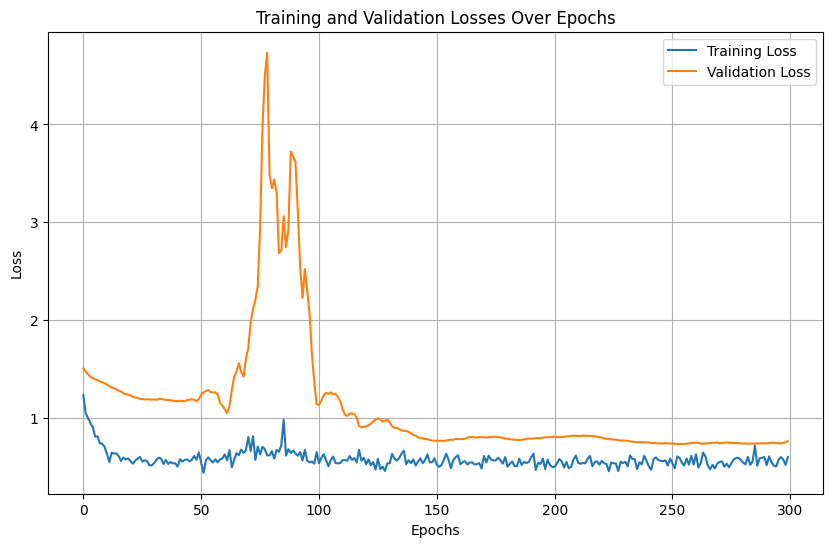

Model weights saved to model.pth


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# Set up device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mean and std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation and normalization
weak_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

strong_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List, transform=None, dataset_type: str = None):
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.classes = [item for item in os.listdir(self.image_dir)
                        if os.path.isdir(os.path.join(self.image_dir, item))]

        self.samples = [
            [img, class_name]
            for class_name in self.classes
            if class_name in allowed_classes
            for img in os.listdir(os.path.join(self.image_dir, class_name))
        ]

        random.seed(87)
        random.shuffle(self.samples)

        split_ratio = 0.6
        if dataset_type == 'Train':
            self.images = self.samples[:int(len(self.samples)*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.samples[int(len(self.samples)*split_ratio):]
        else:
            self.images = self.samples

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_filename, class_name = self.images[index]
        image_path = os.path.join(self.image_dir, class_name, image_filename)

        image = Image.open(image_path).convert('RGB')
        image = self.transform(image) if self.transform else test_transforms(image)

        class_id = self.allowed_classes.index(class_name) if class_name != "unlabeled" else -1

        return image, class_id

class UnlabeledDataset(Dataset):
    def __init__(self, image_dir: str, transform_weak=None, transform_strong=None):
        self.image_dir = image_dir
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

        self.samples = []
        unlabeled_path = os.path.join(self.image_dir, "unlabeled")
        if os.path.isdir(unlabeled_path):
            for img_name in os.listdir(unlabeled_path):
                self.samples.append(os.path.join(unlabeled_path, img_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        image_path = self.samples[index]
        image = Image.open(image_path).convert('RGB')

        weak_image = self.transform_weak(image) if self.transform_weak else image
        strong_image = self.transform_strong(image) if self.transform_strong else image

        return weak_image, strong_image

def get_data_loaders(image_dir: str, batch_size: int = 64, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    datasets = {
        'train': Birddataset(image_dir, classes, weak_transform, 'Train'),
        'val': Birddataset(image_dir, classes, test_transforms, 'Test'),
        'unlabeled': UnlabeledDataset(image_dir, transform_weak=weak_transform, transform_strong=strong_transform)
    }

    loaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True),
        'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
        'unlabeled': DataLoader(datasets['unlabeled'], batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    }

    return loaders['train'], loaders['val'], loaders['unlabeled']

def train_semi_supervised(model: nn.Module,
                          train_loader: DataLoader,
                          unlabeled_loader: DataLoader,
                          val_loader: DataLoader,
                          num_epochs: int = 100,
                          patience: int = 30) -> Tuple[nn.Module, List[List[float]]]:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_model.to(device)  # Move swa_model to GPU
    swa_start = num_epochs - 10
    swa_scheduler = SWALR(optimizer, swa_lr=1e-3)

    scores = [[], []]
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    lambda_u = 1.0
    threshold = 0.95

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        labeled_loader_iter = iter(train_loader)
        unlabeled_loader_iter = iter(unlabeled_loader)

        for _ in range(len(train_loader)):
            try:
                inputs_x, targets_x = next(labeled_loader_iter)
            except StopIteration:
                labeled_loader_iter = iter(train_loader)
                inputs_x, targets_x = next(labeled_loader_iter)

            try:
                inputs_u_w, inputs_u_s = next(unlabeled_loader_iter)
            except StopIteration:
                unlabeled_loader_iter = iter(unlabeled_loader)
                inputs_u_w, inputs_u_s = next(unlabeled_loader_iter)

            # Move data to device
            inputs_x, targets_x = inputs_x.to(device), targets_x.to(device)
            inputs_u_w, inputs_u_s = inputs_u_w.to(device), inputs_u_s.to(device)

            # Compute the pseudo-labels
            with torch.no_grad():
                outputs_u_w = model(inputs_u_w)
                pseudo_labels = torch.softmax(outputs_u_w, dim=-1)
                max_probs, targets_u = torch.max(pseudo_labels, dim=-1)
                mask = max_probs.ge(threshold).float()

            # Concatenate inputs and targets
            all_inputs = torch.cat([inputs_x, inputs_u_s], dim=0)
            all_targets = torch.cat([targets_x, targets_u], dim=0)

            # Get model outputs
            all_outputs = model(all_inputs)
            logits_x = all_outputs[:inputs_x.size(0)]
            logits_u = all_outputs[inputs_x.size(0):]

            # Compute losses
            Lx = criterion(logits_x, targets_x)
            Lu = (F.cross_entropy(logits_u, targets_u, reduction='none') * mask).mean()

            loss = Lx + lambda_u * Lu

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch >= swa_start:
                swa_model.update_parameters(model)
                swa_scheduler.step()
            else:
                scheduler.step()

            running_loss += loss.item() * inputs_x.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")

        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # Load best model and update BN for SWA
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    if num_epochs >= swa_start:
        update_bn(train_loader, swa_model, device=device)  # Ensure data is moved to device
        swa_model.eval()
        model = swa_model
        print('SWA model updated and loaded.\n')

    # Final evaluation
    model.eval()
    all_preds, all_labels = [], []
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Final Evaluation on Validation Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    final_val_loss = running_val_loss / len(val_loader.dataset)
    final_f1 = f1_score(all_labels, all_preds, average='weighted')
    final_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final F1 Score on Validation set: {final_f1:.4f}')
    print(f'Final Accuracy on Validation set: {final_accuracy:.4f}')

    # Compute ECE
    ece = compute_ece(model, val_loader)
    print(f'Expected Calibration Error (ECE) on Validation set: {ece:.4f}')

    return model, scores

def compute_ece(model, data_loader, n_bins=15):
    model.eval()
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            logits_list.append(logits.cpu())
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)

    bins = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]
    ece = torch.zeros(1)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"  # Update this path to your dataset
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=64, num_workers=2)

    model = Model().to(device)
    num_epochs, patience = 300, 100

    trained_model, training_scores = train_semi_supervised(
        model=model,
        train_loader=train_loader,
        unlabeled_loader=unlabeled_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

if __name__ == "__main__":
    main()


#v0.8 claude : 0.24

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # Load ResNet18 with pre-trained weights
        self.base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # Replace the final fully connected layer
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]



Epoch 1/300, Training Loss: 1.5525, Validation Loss: 0.3574
F1 Score on Validation set: 0.0667, Accuracy on Validation set: 0.2000
Validation loss improved. Saving best model state.



Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



Epoch 2/300, Training Loss: 1.4059, Validation Loss: 0.3295
F1 Score on Validation set: 0.0667, Accuracy on Validation set: 0.2000
Validation loss improved. Saving best model state.



Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 3/300, Training Loss: 1.0985, Validation Loss: 0.2898
F1 Score on Validation set: 0.2236, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.



Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch 4/300, Training Loss: 1.0396, Validation Loss: 0.2632
F1 Score on Validation set: 0.3255, Accuracy on Validation set: 0.3667
Validation loss improved. Saving best model state.



Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 5/300, Training Loss: 0.8599, Validation Loss: 0.2547
F1 Score on Validation set: 0.3839, Accuracy on Validation set: 0.4000
Validation loss improved. Saving best model state.



Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 6/300, Training Loss: 0.9417, Validation Loss: 0.2472
F1 Score on Validation set: 0.4791, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]



Epoch 7/300, Training Loss: 0.9353, Validation Loss: 0.2503
F1 Score on Validation set: 0.3798, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]



Epoch 8/300, Training Loss: 0.8308, Validation Loss: 0.2365
F1 Score on Validation set: 0.4722, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]



Epoch 9/300, Training Loss: 0.8825, Validation Loss: 0.2295
F1 Score on Validation set: 0.5042, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.



Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 10/300, Training Loss: 0.8794, Validation Loss: 0.2387
F1 Score on Validation set: 0.3344, Accuracy on Validation set: 0.3667
No improvement in validation loss for 1 epochs.



Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 11/300, Training Loss: 0.9777, Validation Loss: 0.2301
F1 Score on Validation set: 0.5075, Accuracy on Validation set: 0.5333
No improvement in validation loss for 2 epochs.



Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch 12/300, Training Loss: 0.8869, Validation Loss: 0.2186
F1 Score on Validation set: 0.5756, Accuracy on Validation set: 0.6000
Validation loss improved. Saving best model state.



Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]



Epoch 13/300, Training Loss: 0.7499, Validation Loss: 0.2288
F1 Score on Validation set: 0.5360, Accuracy on Validation set: 0.5667
No improvement in validation loss for 1 epochs.



Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]



Epoch 14/300, Training Loss: 0.8071, Validation Loss: 0.2434
F1 Score on Validation set: 0.4821, Accuracy on Validation set: 0.5667
No improvement in validation loss for 2 epochs.



Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



Epoch 15/300, Training Loss: 0.8378, Validation Loss: 0.2215
F1 Score on Validation set: 0.5507, Accuracy on Validation set: 0.5667
No improvement in validation loss for 3 epochs.



Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]



Epoch 16/300, Training Loss: 0.7151, Validation Loss: 0.2165
F1 Score on Validation set: 0.5401, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.



Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 17/300, Training Loss: 0.7634, Validation Loss: 0.2282
F1 Score on Validation set: 0.5574, Accuracy on Validation set: 0.5667
No improvement in validation loss for 1 epochs.



Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch 18/300, Training Loss: 0.8237, Validation Loss: 0.2198
F1 Score on Validation set: 0.6443, Accuracy on Validation set: 0.6667
No improvement in validation loss for 2 epochs.



Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 19/300, Training Loss: 0.9292, Validation Loss: 0.2167
F1 Score on Validation set: 0.6386, Accuracy on Validation set: 0.6667
No improvement in validation loss for 3 epochs.



Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 20/300, Training Loss: 0.7993, Validation Loss: 0.2199
F1 Score on Validation set: 0.4980, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 21/300, Training Loss: 0.6648, Validation Loss: 0.2137
F1 Score on Validation set: 0.6629, Accuracy on Validation set: 0.6667
Validation loss improved. Saving best model state.



Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 22/300, Training Loss: 0.9450, Validation Loss: 0.2226
F1 Score on Validation set: 0.5447, Accuracy on Validation set: 0.5667
No improvement in validation loss for 1 epochs.



Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]



Epoch 23/300, Training Loss: 0.6614, Validation Loss: 0.2167
F1 Score on Validation set: 0.6130, Accuracy on Validation set: 0.6333
No improvement in validation loss for 2 epochs.



Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]



Epoch 24/300, Training Loss: 0.8643, Validation Loss: 0.2335
F1 Score on Validation set: 0.5528, Accuracy on Validation set: 0.5667
No improvement in validation loss for 3 epochs.



Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 25/300, Training Loss: 0.7302, Validation Loss: 0.2187
F1 Score on Validation set: 0.6640, Accuracy on Validation set: 0.6667
No improvement in validation loss for 4 epochs.



Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 26/300, Training Loss: 0.6632, Validation Loss: 0.2053
F1 Score on Validation set: 0.6270, Accuracy on Validation set: 0.6333
Validation loss improved. Saving best model state.



Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 27/300, Training Loss: 0.8237, Validation Loss: 0.2291
F1 Score on Validation set: 0.5740, Accuracy on Validation set: 0.6000
No improvement in validation loss for 1 epochs.



Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 28/300, Training Loss: 0.7284, Validation Loss: 0.2118
F1 Score on Validation set: 0.5641, Accuracy on Validation set: 0.5667
No improvement in validation loss for 2 epochs.



Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 29/300, Training Loss: 0.6336, Validation Loss: 0.2261
F1 Score on Validation set: 0.5987, Accuracy on Validation set: 0.6000
No improvement in validation loss for 3 epochs.



Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 30/300, Training Loss: 0.6628, Validation Loss: 0.2152
F1 Score on Validation set: 0.6556, Accuracy on Validation set: 0.6667
No improvement in validation loss for 4 epochs.



Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]



Epoch 31/300, Training Loss: 0.6956, Validation Loss: 0.2077
F1 Score on Validation set: 0.6750, Accuracy on Validation set: 0.7000
No improvement in validation loss for 5 epochs.



Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]



Epoch 32/300, Training Loss: 0.7805, Validation Loss: 0.2237
F1 Score on Validation set: 0.6334, Accuracy on Validation set: 0.6333
No improvement in validation loss for 6 epochs.



Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 33/300, Training Loss: 0.6617, Validation Loss: 0.2365
F1 Score on Validation set: 0.5504, Accuracy on Validation set: 0.5667
No improvement in validation loss for 7 epochs.



Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 34/300, Training Loss: 0.7379, Validation Loss: 0.2132
F1 Score on Validation set: 0.6556, Accuracy on Validation set: 0.6667
No improvement in validation loss for 8 epochs.



Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 35/300, Training Loss: 0.8236, Validation Loss: 0.2244
F1 Score on Validation set: 0.5246, Accuracy on Validation set: 0.5667
No improvement in validation loss for 9 epochs.



Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 36/300, Training Loss: 0.7609, Validation Loss: 0.2058
F1 Score on Validation set: 0.6705, Accuracy on Validation set: 0.7000
No improvement in validation loss for 10 epochs.



Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 37/300, Training Loss: 0.7514, Validation Loss: 0.2249
F1 Score on Validation set: 0.5267, Accuracy on Validation set: 0.5667
No improvement in validation loss for 11 epochs.



Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]



Epoch 38/300, Training Loss: 0.7548, Validation Loss: 0.2149
F1 Score on Validation set: 0.7094, Accuracy on Validation set: 0.7333
No improvement in validation loss for 12 epochs.



Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]



Epoch 39/300, Training Loss: 0.7980, Validation Loss: 0.1963
F1 Score on Validation set: 0.7202, Accuracy on Validation set: 0.7333
Validation loss improved. Saving best model state.



Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



Epoch 40/300, Training Loss: 0.7344, Validation Loss: 0.2097
F1 Score on Validation set: 0.6917, Accuracy on Validation set: 0.7333
No improvement in validation loss for 1 epochs.



Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]



Epoch 41/300, Training Loss: 0.7132, Validation Loss: 0.2125
F1 Score on Validation set: 0.6584, Accuracy on Validation set: 0.6667
No improvement in validation loss for 2 epochs.



Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 42/300, Training Loss: 0.7088, Validation Loss: 0.2140
F1 Score on Validation set: 0.6887, Accuracy on Validation set: 0.7000
No improvement in validation loss for 3 epochs.



Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 43/300, Training Loss: 0.7213, Validation Loss: 0.1981
F1 Score on Validation set: 0.8017, Accuracy on Validation set: 0.8000
No improvement in validation loss for 4 epochs.



Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]



Epoch 44/300, Training Loss: 0.8066, Validation Loss: 0.2098
F1 Score on Validation set: 0.5629, Accuracy on Validation set: 0.5667
No improvement in validation loss for 5 epochs.



Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 45/300, Training Loss: 0.8957, Validation Loss: 0.2235
F1 Score on Validation set: 0.6653, Accuracy on Validation set: 0.6667
No improvement in validation loss for 6 epochs.



Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



Epoch 46/300, Training Loss: 0.7429, Validation Loss: 0.2162
F1 Score on Validation set: 0.5903, Accuracy on Validation set: 0.6000
No improvement in validation loss for 7 epochs.



Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]



Epoch 47/300, Training Loss: 0.7788, Validation Loss: 0.2100
F1 Score on Validation set: 0.6517, Accuracy on Validation set: 0.6667
No improvement in validation loss for 8 epochs.



Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]



Epoch 48/300, Training Loss: 0.7428, Validation Loss: 0.2110
F1 Score on Validation set: 0.5689, Accuracy on Validation set: 0.5667
No improvement in validation loss for 9 epochs.



Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 49/300, Training Loss: 0.8023, Validation Loss: 0.2096
F1 Score on Validation set: 0.6568, Accuracy on Validation set: 0.6667
No improvement in validation loss for 10 epochs.



Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 50/300, Training Loss: 0.7234, Validation Loss: 0.2002
F1 Score on Validation set: 0.7317, Accuracy on Validation set: 0.7333
No improvement in validation loss for 11 epochs.



Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 51/300, Training Loss: 0.6406, Validation Loss: 0.2081
F1 Score on Validation set: 0.5622, Accuracy on Validation set: 0.5667
No improvement in validation loss for 12 epochs.



Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]



Epoch 52/300, Training Loss: 0.8386, Validation Loss: 0.2110
F1 Score on Validation set: 0.6955, Accuracy on Validation set: 0.7000
No improvement in validation loss for 13 epochs.



Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



Epoch 53/300, Training Loss: 0.7083, Validation Loss: 0.2103
F1 Score on Validation set: 0.6251, Accuracy on Validation set: 0.6333
No improvement in validation loss for 14 epochs.



Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



Epoch 54/300, Training Loss: 0.6311, Validation Loss: 0.2117
F1 Score on Validation set: 0.6324, Accuracy on Validation set: 0.6333
No improvement in validation loss for 15 epochs.



Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]



Epoch 55/300, Training Loss: 0.6191, Validation Loss: 0.2049
F1 Score on Validation set: 0.6575, Accuracy on Validation set: 0.6667
No improvement in validation loss for 16 epochs.



Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 56/300, Training Loss: 0.9245, Validation Loss: 0.2134
F1 Score on Validation set: 0.5524, Accuracy on Validation set: 0.5667
No improvement in validation loss for 17 epochs.



Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 57/300, Training Loss: 0.6954, Validation Loss: 0.2000
F1 Score on Validation set: 0.6165, Accuracy on Validation set: 0.6333
No improvement in validation loss for 18 epochs.



Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 58/300, Training Loss: 0.7609, Validation Loss: 0.2119
F1 Score on Validation set: 0.5116, Accuracy on Validation set: 0.5333
No improvement in validation loss for 19 epochs.



Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 59/300, Training Loss: 0.8059, Validation Loss: 0.2093
F1 Score on Validation set: 0.6852, Accuracy on Validation set: 0.7000
No improvement in validation loss for 20 epochs.



Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 60/300, Training Loss: 0.7857, Validation Loss: 0.2144
F1 Score on Validation set: 0.6558, Accuracy on Validation set: 0.6667
No improvement in validation loss for 21 epochs.



Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]



Epoch 61/300, Training Loss: 0.6693, Validation Loss: 0.2091
F1 Score on Validation set: 0.6332, Accuracy on Validation set: 0.6333
No improvement in validation loss for 22 epochs.



Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]



Epoch 62/300, Training Loss: 0.7881, Validation Loss: 0.2144
F1 Score on Validation set: 0.6668, Accuracy on Validation set: 0.6667
No improvement in validation loss for 23 epochs.



Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 63/300, Training Loss: 0.7658, Validation Loss: 0.2196
F1 Score on Validation set: 0.5354, Accuracy on Validation set: 0.5667
No improvement in validation loss for 24 epochs.



Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 64/300, Training Loss: 0.7907, Validation Loss: 0.2073
F1 Score on Validation set: 0.6405, Accuracy on Validation set: 0.6667
No improvement in validation loss for 25 epochs.



Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 65/300, Training Loss: 0.8328, Validation Loss: 0.2055
F1 Score on Validation set: 0.6488, Accuracy on Validation set: 0.6667
No improvement in validation loss for 26 epochs.



Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]



Epoch 66/300, Training Loss: 0.7782, Validation Loss: 0.2088
F1 Score on Validation set: 0.6144, Accuracy on Validation set: 0.6333
No improvement in validation loss for 27 epochs.



Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 67/300, Training Loss: 0.7680, Validation Loss: 0.2201
F1 Score on Validation set: 0.5991, Accuracy on Validation set: 0.6000
No improvement in validation loss for 28 epochs.



Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 68/300, Training Loss: 0.7227, Validation Loss: 0.2198
F1 Score on Validation set: 0.5383, Accuracy on Validation set: 0.5667
No improvement in validation loss for 29 epochs.



Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]



Epoch 69/300, Training Loss: 0.7710, Validation Loss: 0.2043
F1 Score on Validation set: 0.6672, Accuracy on Validation set: 0.6667
No improvement in validation loss for 30 epochs.



Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]



Epoch 70/300, Training Loss: 0.7713, Validation Loss: 0.2304
F1 Score on Validation set: 0.5353, Accuracy on Validation set: 0.5333
No improvement in validation loss for 31 epochs.



Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 71/300, Training Loss: 0.7510, Validation Loss: 0.2120
F1 Score on Validation set: 0.5286, Accuracy on Validation set: 0.5333
No improvement in validation loss for 32 epochs.



Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]



Epoch 72/300, Training Loss: 0.7239, Validation Loss: 0.2093
F1 Score on Validation set: 0.7323, Accuracy on Validation set: 0.7333
No improvement in validation loss for 33 epochs.



Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 73/300, Training Loss: 0.8611, Validation Loss: 0.2194
F1 Score on Validation set: 0.6175, Accuracy on Validation set: 0.6333
No improvement in validation loss for 34 epochs.



Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 74/300, Training Loss: 0.9199, Validation Loss: 0.2216
F1 Score on Validation set: 0.4802, Accuracy on Validation set: 0.5000
No improvement in validation loss for 35 epochs.



Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 75/300, Training Loss: 0.7695, Validation Loss: 0.2294
F1 Score on Validation set: 0.5737, Accuracy on Validation set: 0.6000
No improvement in validation loss for 36 epochs.



Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 76/300, Training Loss: 0.7003, Validation Loss: 0.2317
F1 Score on Validation set: 0.6251, Accuracy on Validation set: 0.6333
No improvement in validation loss for 37 epochs.



Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]



Epoch 77/300, Training Loss: 0.7185, Validation Loss: 0.2172
F1 Score on Validation set: 0.5804, Accuracy on Validation set: 0.6000
No improvement in validation loss for 38 epochs.



Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



Epoch 78/300, Training Loss: 0.6944, Validation Loss: 0.2088
F1 Score on Validation set: 0.6782, Accuracy on Validation set: 0.7000
No improvement in validation loss for 39 epochs.



Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 79/300, Training Loss: 0.7992, Validation Loss: 0.2130
F1 Score on Validation set: 0.6062, Accuracy on Validation set: 0.6333
No improvement in validation loss for 40 epochs.



Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 80/300, Training Loss: 0.7620, Validation Loss: 0.2093
F1 Score on Validation set: 0.6847, Accuracy on Validation set: 0.7000
No improvement in validation loss for 41 epochs.



Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 81/300, Training Loss: 0.8522, Validation Loss: 0.2052
F1 Score on Validation set: 0.7330, Accuracy on Validation set: 0.7333
No improvement in validation loss for 42 epochs.



Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 82/300, Training Loss: 0.7165, Validation Loss: 0.2227
F1 Score on Validation set: 0.6112, Accuracy on Validation set: 0.6333
No improvement in validation loss for 43 epochs.



Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 83/300, Training Loss: 0.8291, Validation Loss: 0.2150
F1 Score on Validation set: 0.5983, Accuracy on Validation set: 0.6000
No improvement in validation loss for 44 epochs.



Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 84/300, Training Loss: 0.7688, Validation Loss: 0.2082
F1 Score on Validation set: 0.6980, Accuracy on Validation set: 0.7000
No improvement in validation loss for 45 epochs.



Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]



Epoch 85/300, Training Loss: 0.6890, Validation Loss: 0.2215
F1 Score on Validation set: 0.5873, Accuracy on Validation set: 0.6000
No improvement in validation loss for 46 epochs.



Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]



Epoch 86/300, Training Loss: 0.6705, Validation Loss: 0.2084
F1 Score on Validation set: 0.5891, Accuracy on Validation set: 0.6000
No improvement in validation loss for 47 epochs.



Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 87/300, Training Loss: 0.8561, Validation Loss: 0.2233
F1 Score on Validation set: 0.4905, Accuracy on Validation set: 0.5333
No improvement in validation loss for 48 epochs.



Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 88/300, Training Loss: 0.6165, Validation Loss: 0.2215
F1 Score on Validation set: 0.4804, Accuracy on Validation set: 0.5000
No improvement in validation loss for 49 epochs.



Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]



Epoch 89/300, Training Loss: 0.8141, Validation Loss: 0.2367
F1 Score on Validation set: 0.4513, Accuracy on Validation set: 0.5000
No improvement in validation loss for 50 epochs.



Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 90/300, Training Loss: 0.6988, Validation Loss: 0.2207
F1 Score on Validation set: 0.5553, Accuracy on Validation set: 0.5667
No improvement in validation loss for 51 epochs.



Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 91/300, Training Loss: 0.8281, Validation Loss: 0.2248
F1 Score on Validation set: 0.5917, Accuracy on Validation set: 0.6000
No improvement in validation loss for 52 epochs.



Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 92/300, Training Loss: 0.7107, Validation Loss: 0.2219
F1 Score on Validation set: 0.5330, Accuracy on Validation set: 0.5667
No improvement in validation loss for 53 epochs.



Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



Epoch 93/300, Training Loss: 0.5190, Validation Loss: 0.2084
F1 Score on Validation set: 0.6945, Accuracy on Validation set: 0.7000
No improvement in validation loss for 54 epochs.



Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]



Epoch 94/300, Training Loss: 0.8566, Validation Loss: 0.2210
F1 Score on Validation set: 0.5923, Accuracy on Validation set: 0.6000
No improvement in validation loss for 55 epochs.



Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 95/300, Training Loss: 0.6716, Validation Loss: 0.2038
F1 Score on Validation set: 0.5464, Accuracy on Validation set: 0.5667
No improvement in validation loss for 56 epochs.



Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 96/300, Training Loss: 0.7314, Validation Loss: 0.2012
F1 Score on Validation set: 0.6212, Accuracy on Validation set: 0.6333
No improvement in validation loss for 57 epochs.



Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



Epoch 97/300, Training Loss: 0.7850, Validation Loss: 0.2071
F1 Score on Validation set: 0.5529, Accuracy on Validation set: 0.5667
No improvement in validation loss for 58 epochs.



Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]



Epoch 98/300, Training Loss: 0.6290, Validation Loss: 0.2135
F1 Score on Validation set: 0.5492, Accuracy on Validation set: 0.5667
No improvement in validation loss for 59 epochs.



Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 99/300, Training Loss: 0.7833, Validation Loss: 0.2209
F1 Score on Validation set: 0.6175, Accuracy on Validation set: 0.6333
No improvement in validation loss for 60 epochs.



Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 100/300, Training Loss: 0.6938, Validation Loss: 0.2173
F1 Score on Validation set: 0.6527, Accuracy on Validation set: 0.6667
No improvement in validation loss for 61 epochs.



Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]



Epoch 101/300, Training Loss: 0.7293, Validation Loss: 0.2270
F1 Score on Validation set: 0.5875, Accuracy on Validation set: 0.6000
No improvement in validation loss for 62 epochs.



Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]



Epoch 102/300, Training Loss: 0.7697, Validation Loss: 0.2130
F1 Score on Validation set: 0.5429, Accuracy on Validation set: 0.5667
No improvement in validation loss for 63 epochs.



Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 103/300, Training Loss: 0.7069, Validation Loss: 0.2101
F1 Score on Validation set: 0.6295, Accuracy on Validation set: 0.6333
No improvement in validation loss for 64 epochs.



Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]



Epoch 104/300, Training Loss: 0.7787, Validation Loss: 0.2148
F1 Score on Validation set: 0.6494, Accuracy on Validation set: 0.6667
No improvement in validation loss for 65 epochs.



Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch 105/300, Training Loss: 0.6395, Validation Loss: 0.2134
F1 Score on Validation set: 0.6093, Accuracy on Validation set: 0.6333
No improvement in validation loss for 66 epochs.



Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 106/300, Training Loss: 0.8119, Validation Loss: 0.2055
F1 Score on Validation set: 0.6198, Accuracy on Validation set: 0.6333
No improvement in validation loss for 67 epochs.



Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 107/300, Training Loss: 0.7596, Validation Loss: 0.2054
F1 Score on Validation set: 0.6070, Accuracy on Validation set: 0.6333
No improvement in validation loss for 68 epochs.



Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



Epoch 108/300, Training Loss: 0.7436, Validation Loss: 0.2144
F1 Score on Validation set: 0.6839, Accuracy on Validation set: 0.7000
No improvement in validation loss for 69 epochs.



Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



Epoch 109/300, Training Loss: 0.8056, Validation Loss: 0.2084
F1 Score on Validation set: 0.6165, Accuracy on Validation set: 0.6333
No improvement in validation loss for 70 epochs.



Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



Epoch 110/300, Training Loss: 0.6634, Validation Loss: 0.2072
F1 Score on Validation set: 0.6263, Accuracy on Validation set: 0.6333
No improvement in validation loss for 71 epochs.



Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch 111/300, Training Loss: 0.7454, Validation Loss: 0.1951
F1 Score on Validation set: 0.7260, Accuracy on Validation set: 0.7333
Validation loss improved. Saving best model state.



Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 112/300, Training Loss: 0.8009, Validation Loss: 0.2087
F1 Score on Validation set: 0.6628, Accuracy on Validation set: 0.6667
No improvement in validation loss for 1 epochs.



Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 113/300, Training Loss: 0.7970, Validation Loss: 0.2013
F1 Score on Validation set: 0.6295, Accuracy on Validation set: 0.6333
No improvement in validation loss for 2 epochs.



Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]



Epoch 114/300, Training Loss: 0.7049, Validation Loss: 0.2057
F1 Score on Validation set: 0.6256, Accuracy on Validation set: 0.6333
No improvement in validation loss for 3 epochs.



Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 115/300, Training Loss: 0.7483, Validation Loss: 0.2079
F1 Score on Validation set: 0.6267, Accuracy on Validation set: 0.6333
No improvement in validation loss for 4 epochs.



Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



Epoch 116/300, Training Loss: 0.8398, Validation Loss: 0.2180
F1 Score on Validation set: 0.6386, Accuracy on Validation set: 0.6333
No improvement in validation loss for 5 epochs.



Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]



Epoch 117/300, Training Loss: 0.7322, Validation Loss: 0.2044
F1 Score on Validation set: 0.6528, Accuracy on Validation set: 0.6667
No improvement in validation loss for 6 epochs.



Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 118/300, Training Loss: 0.7456, Validation Loss: 0.2173
F1 Score on Validation set: 0.5927, Accuracy on Validation set: 0.6000
No improvement in validation loss for 7 epochs.



Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 119/300, Training Loss: 0.8230, Validation Loss: 0.2094
F1 Score on Validation set: 0.6233, Accuracy on Validation set: 0.6333
No improvement in validation loss for 8 epochs.



Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 120/300, Training Loss: 0.7657, Validation Loss: 0.2117
F1 Score on Validation set: 0.6341, Accuracy on Validation set: 0.6667
No improvement in validation loss for 9 epochs.



Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 121/300, Training Loss: 0.8072, Validation Loss: 0.2064
F1 Score on Validation set: 0.6256, Accuracy on Validation set: 0.6333
No improvement in validation loss for 10 epochs.



Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 122/300, Training Loss: 0.7572, Validation Loss: 0.2175
F1 Score on Validation set: 0.5874, Accuracy on Validation set: 0.6000
No improvement in validation loss for 11 epochs.



Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 123/300, Training Loss: 0.8867, Validation Loss: 0.2240
F1 Score on Validation set: 0.5283, Accuracy on Validation set: 0.5333
No improvement in validation loss for 12 epochs.



Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]



Epoch 124/300, Training Loss: 0.6859, Validation Loss: 0.2080
F1 Score on Validation set: 0.5860, Accuracy on Validation set: 0.6000
No improvement in validation loss for 13 epochs.



Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]



Epoch 125/300, Training Loss: 0.7138, Validation Loss: 0.2178
F1 Score on Validation set: 0.5583, Accuracy on Validation set: 0.5667
No improvement in validation loss for 14 epochs.



Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 126/300, Training Loss: 0.9336, Validation Loss: 0.2103
F1 Score on Validation set: 0.6210, Accuracy on Validation set: 0.6333
No improvement in validation loss for 15 epochs.



Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]



Epoch 127/300, Training Loss: 0.7704, Validation Loss: 0.2101
F1 Score on Validation set: 0.7196, Accuracy on Validation set: 0.7333
No improvement in validation loss for 16 epochs.



Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 128/300, Training Loss: 0.8088, Validation Loss: 0.2183
F1 Score on Validation set: 0.5972, Accuracy on Validation set: 0.6000
No improvement in validation loss for 17 epochs.



Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 129/300, Training Loss: 0.6293, Validation Loss: 0.2235
F1 Score on Validation set: 0.5155, Accuracy on Validation set: 0.5333
No improvement in validation loss for 18 epochs.



Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 130/300, Training Loss: 0.6837, Validation Loss: 0.2142
F1 Score on Validation set: 0.6100, Accuracy on Validation set: 0.6333
No improvement in validation loss for 19 epochs.



Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 131/300, Training Loss: 0.7333, Validation Loss: 0.2313
F1 Score on Validation set: 0.6234, Accuracy on Validation set: 0.6333
No improvement in validation loss for 20 epochs.



Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]



Epoch 132/300, Training Loss: 0.8263, Validation Loss: 0.2153
F1 Score on Validation set: 0.6467, Accuracy on Validation set: 0.6667
No improvement in validation loss for 21 epochs.



Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



Epoch 133/300, Training Loss: 0.7182, Validation Loss: 0.2161
F1 Score on Validation set: 0.6596, Accuracy on Validation set: 0.6667
No improvement in validation loss for 22 epochs.



Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]



Epoch 134/300, Training Loss: 0.7150, Validation Loss: 0.2155
F1 Score on Validation set: 0.6638, Accuracy on Validation set: 0.6667
No improvement in validation loss for 23 epochs.



Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 135/300, Training Loss: 0.8636, Validation Loss: 0.2148
F1 Score on Validation set: 0.6463, Accuracy on Validation set: 0.6667
No improvement in validation loss for 24 epochs.



Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



Epoch 136/300, Training Loss: 0.7257, Validation Loss: 0.2191
F1 Score on Validation set: 0.5236, Accuracy on Validation set: 0.5667
No improvement in validation loss for 25 epochs.



Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]



Epoch 137/300, Training Loss: 0.8259, Validation Loss: 0.2096
F1 Score on Validation set: 0.7627, Accuracy on Validation set: 0.7667
No improvement in validation loss for 26 epochs.



Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]



Epoch 138/300, Training Loss: 0.7824, Validation Loss: 0.2250
F1 Score on Validation set: 0.5891, Accuracy on Validation set: 0.6000
No improvement in validation loss for 27 epochs.



Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]



Epoch 139/300, Training Loss: 0.6589, Validation Loss: 0.2057
F1 Score on Validation set: 0.6592, Accuracy on Validation set: 0.6667
No improvement in validation loss for 28 epochs.



Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]



Epoch 140/300, Training Loss: 0.8039, Validation Loss: 0.2083
F1 Score on Validation set: 0.6997, Accuracy on Validation set: 0.7000
No improvement in validation loss for 29 epochs.



Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 141/300, Training Loss: 0.7216, Validation Loss: 0.2110
F1 Score on Validation set: 0.5614, Accuracy on Validation set: 0.5667
No improvement in validation loss for 30 epochs.



Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 142/300, Training Loss: 0.6793, Validation Loss: 0.2140
F1 Score on Validation set: 0.6543, Accuracy on Validation set: 0.6667
No improvement in validation loss for 31 epochs.



Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]



Epoch 143/300, Training Loss: 0.7770, Validation Loss: 0.2094
F1 Score on Validation set: 0.6250, Accuracy on Validation set: 0.6333
No improvement in validation loss for 32 epochs.



Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]



Epoch 144/300, Training Loss: 0.6985, Validation Loss: 0.2164
F1 Score on Validation set: 0.5546, Accuracy on Validation set: 0.5667
No improvement in validation loss for 33 epochs.



Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



Epoch 145/300, Training Loss: 0.7398, Validation Loss: 0.2270
F1 Score on Validation set: 0.5218, Accuracy on Validation set: 0.5333
No improvement in validation loss for 34 epochs.



Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 146/300, Training Loss: 0.6486, Validation Loss: 0.2066
F1 Score on Validation set: 0.6049, Accuracy on Validation set: 0.6333
No improvement in validation loss for 35 epochs.



Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 147/300, Training Loss: 0.7091, Validation Loss: 0.2189
F1 Score on Validation set: 0.6208, Accuracy on Validation set: 0.6333
No improvement in validation loss for 36 epochs.



Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 148/300, Training Loss: 0.7316, Validation Loss: 0.2149
F1 Score on Validation set: 0.6295, Accuracy on Validation set: 0.6333
No improvement in validation loss for 37 epochs.



Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



Epoch 149/300, Training Loss: 0.8122, Validation Loss: 0.2069
F1 Score on Validation set: 0.6169, Accuracy on Validation set: 0.6333
No improvement in validation loss for 38 epochs.



Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 150/300, Training Loss: 0.7992, Validation Loss: 0.2074
F1 Score on Validation set: 0.6136, Accuracy on Validation set: 0.6333
No improvement in validation loss for 39 epochs.



Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 151/300, Training Loss: 0.8954, Validation Loss: 0.2101
F1 Score on Validation set: 0.7161, Accuracy on Validation set: 0.7333
No improvement in validation loss for 40 epochs.



Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]



Epoch 152/300, Training Loss: 0.8566, Validation Loss: 0.2052
F1 Score on Validation set: 0.6730, Accuracy on Validation set: 0.6667
No improvement in validation loss for 41 epochs.



Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]



Epoch 153/300, Training Loss: 0.6789, Validation Loss: 0.2058
F1 Score on Validation set: 0.6070, Accuracy on Validation set: 0.6000
No improvement in validation loss for 42 epochs.



Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 154/300, Training Loss: 0.7276, Validation Loss: 0.2084
F1 Score on Validation set: 0.6527, Accuracy on Validation set: 0.6667
No improvement in validation loss for 43 epochs.



Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]



Epoch 155/300, Training Loss: 0.6784, Validation Loss: 0.1999
F1 Score on Validation set: 0.6544, Accuracy on Validation set: 0.6667
No improvement in validation loss for 44 epochs.



Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 156/300, Training Loss: 0.7315, Validation Loss: 0.2037
F1 Score on Validation set: 0.6643, Accuracy on Validation set: 0.6667
No improvement in validation loss for 45 epochs.



Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]



Epoch 157/300, Training Loss: 0.7465, Validation Loss: 0.2112
F1 Score on Validation set: 0.6579, Accuracy on Validation set: 0.6667
No improvement in validation loss for 46 epochs.



Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 158/300, Training Loss: 0.8034, Validation Loss: 0.2124
F1 Score on Validation set: 0.6757, Accuracy on Validation set: 0.7000
No improvement in validation loss for 47 epochs.



Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 159/300, Training Loss: 0.7716, Validation Loss: 0.2185
F1 Score on Validation set: 0.5803, Accuracy on Validation set: 0.6000
No improvement in validation loss for 48 epochs.



Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]



Epoch 160/300, Training Loss: 0.7977, Validation Loss: 0.2127
F1 Score on Validation set: 0.5878, Accuracy on Validation set: 0.6333
No improvement in validation loss for 49 epochs.



Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]



Epoch 161/300, Training Loss: 0.7525, Validation Loss: 0.2131
F1 Score on Validation set: 0.6227, Accuracy on Validation set: 0.6333
No improvement in validation loss for 50 epochs.



Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 162/300, Training Loss: 0.7083, Validation Loss: 0.2357
F1 Score on Validation set: 0.5907, Accuracy on Validation set: 0.6333
No improvement in validation loss for 51 epochs.



Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 163/300, Training Loss: 0.7199, Validation Loss: 0.2136
F1 Score on Validation set: 0.6229, Accuracy on Validation set: 0.6333
No improvement in validation loss for 52 epochs.



Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 164/300, Training Loss: 0.7335, Validation Loss: 0.2182
F1 Score on Validation set: 0.6394, Accuracy on Validation set: 0.6333
No improvement in validation loss for 53 epochs.



Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 165/300, Training Loss: 0.7650, Validation Loss: 0.2139
F1 Score on Validation set: 0.6153, Accuracy on Validation set: 0.6000
No improvement in validation loss for 54 epochs.



Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 166/300, Training Loss: 0.8014, Validation Loss: 0.2167
F1 Score on Validation set: 0.5670, Accuracy on Validation set: 0.5667
No improvement in validation loss for 55 epochs.



Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 167/300, Training Loss: 0.7335, Validation Loss: 0.2143
F1 Score on Validation set: 0.6543, Accuracy on Validation set: 0.6667
No improvement in validation loss for 56 epochs.



Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



Epoch 168/300, Training Loss: 0.6695, Validation Loss: 0.2138
F1 Score on Validation set: 0.5902, Accuracy on Validation set: 0.6000
No improvement in validation loss for 57 epochs.



Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]



Epoch 169/300, Training Loss: 0.7288, Validation Loss: 0.2127
F1 Score on Validation set: 0.5793, Accuracy on Validation set: 0.6000
No improvement in validation loss for 58 epochs.



Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]



Epoch 170/300, Training Loss: 0.6050, Validation Loss: 0.2244
F1 Score on Validation set: 0.5091, Accuracy on Validation set: 0.5333
No improvement in validation loss for 59 epochs.



Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]



Epoch 171/300, Training Loss: 0.7053, Validation Loss: 0.2192
F1 Score on Validation set: 0.6074, Accuracy on Validation set: 0.6333
No improvement in validation loss for 60 epochs.



Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 172/300, Training Loss: 0.7128, Validation Loss: 0.2168
F1 Score on Validation set: 0.6534, Accuracy on Validation set: 0.6667
No improvement in validation loss for 61 epochs.



Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]



Epoch 173/300, Training Loss: 0.7740, Validation Loss: 0.2120
F1 Score on Validation set: 0.5301, Accuracy on Validation set: 0.5333
No improvement in validation loss for 62 epochs.



Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 174/300, Training Loss: 0.7753, Validation Loss: 0.2029
F1 Score on Validation set: 0.6402, Accuracy on Validation set: 0.6333
No improvement in validation loss for 63 epochs.



Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]



Epoch 175/300, Training Loss: 0.6737, Validation Loss: 0.2161
F1 Score on Validation set: 0.5873, Accuracy on Validation set: 0.6000
No improvement in validation loss for 64 epochs.



Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]



Epoch 176/300, Training Loss: 0.7303, Validation Loss: 0.2077
F1 Score on Validation set: 0.6606, Accuracy on Validation set: 0.6667
No improvement in validation loss for 65 epochs.



Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 177/300, Training Loss: 0.7478, Validation Loss: 0.2097
F1 Score on Validation set: 0.6503, Accuracy on Validation set: 0.6667
No improvement in validation loss for 66 epochs.



Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 178/300, Training Loss: 0.7432, Validation Loss: 0.1975
F1 Score on Validation set: 0.6592, Accuracy on Validation set: 0.6667
No improvement in validation loss for 67 epochs.



Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]



Epoch 179/300, Training Loss: 0.8134, Validation Loss: 0.2055
F1 Score on Validation set: 0.6258, Accuracy on Validation set: 0.6333
No improvement in validation loss for 68 epochs.



Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]



Epoch 180/300, Training Loss: 0.8469, Validation Loss: 0.2080
F1 Score on Validation set: 0.6270, Accuracy on Validation set: 0.6333
No improvement in validation loss for 69 epochs.



Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 181/300, Training Loss: 0.8506, Validation Loss: 0.1993
F1 Score on Validation set: 0.7285, Accuracy on Validation set: 0.7333
No improvement in validation loss for 70 epochs.



Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch 182/300, Training Loss: 0.7222, Validation Loss: 0.2014
F1 Score on Validation set: 0.6272, Accuracy on Validation set: 0.6333
No improvement in validation loss for 71 epochs.



Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]



Epoch 183/300, Training Loss: 0.8459, Validation Loss: 0.2127
F1 Score on Validation set: 0.5861, Accuracy on Validation set: 0.6000
No improvement in validation loss for 72 epochs.



Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]



Epoch 184/300, Training Loss: 0.6956, Validation Loss: 0.2088
F1 Score on Validation set: 0.6966, Accuracy on Validation set: 0.7000
No improvement in validation loss for 73 epochs.



Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 185/300, Training Loss: 0.6614, Validation Loss: 0.2121
F1 Score on Validation set: 0.5974, Accuracy on Validation set: 0.6000
No improvement in validation loss for 74 epochs.



Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 186/300, Training Loss: 0.6234, Validation Loss: 0.2149
F1 Score on Validation set: 0.6338, Accuracy on Validation set: 0.6333
No improvement in validation loss for 75 epochs.



Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]



Epoch 187/300, Training Loss: 0.7861, Validation Loss: 0.2126
F1 Score on Validation set: 0.5916, Accuracy on Validation set: 0.6000
No improvement in validation loss for 76 epochs.



Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]



Epoch 188/300, Training Loss: 0.6856, Validation Loss: 0.2133
F1 Score on Validation set: 0.6247, Accuracy on Validation set: 0.6333
No improvement in validation loss for 77 epochs.



Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 189/300, Training Loss: 0.7572, Validation Loss: 0.2112
F1 Score on Validation set: 0.6035, Accuracy on Validation set: 0.6000
No improvement in validation loss for 78 epochs.



Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]



Epoch 190/300, Training Loss: 0.7273, Validation Loss: 0.2064
F1 Score on Validation set: 0.6615, Accuracy on Validation set: 0.6667
No improvement in validation loss for 79 epochs.



Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



Epoch 191/300, Training Loss: 0.6766, Validation Loss: 0.2231
F1 Score on Validation set: 0.6312, Accuracy on Validation set: 0.6333
No improvement in validation loss for 80 epochs.



Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]



Epoch 192/300, Training Loss: 0.8042, Validation Loss: 0.2153
F1 Score on Validation set: 0.6282, Accuracy on Validation set: 0.6333
No improvement in validation loss for 81 epochs.



Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 193/300, Training Loss: 0.7297, Validation Loss: 0.2095
F1 Score on Validation set: 0.6214, Accuracy on Validation set: 0.6333
No improvement in validation loss for 82 epochs.



Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 194/300, Training Loss: 0.6706, Validation Loss: 0.2198
F1 Score on Validation set: 0.6310, Accuracy on Validation set: 0.6333
No improvement in validation loss for 83 epochs.



Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]



Epoch 195/300, Training Loss: 0.8086, Validation Loss: 0.2088
F1 Score on Validation set: 0.6615, Accuracy on Validation set: 0.6667
No improvement in validation loss for 84 epochs.



Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]



Epoch 196/300, Training Loss: 0.6573, Validation Loss: 0.2049
F1 Score on Validation set: 0.7282, Accuracy on Validation set: 0.7333
No improvement in validation loss for 85 epochs.



Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Epoch 197/300, Training Loss: 0.7625, Validation Loss: 0.2138
F1 Score on Validation set: 0.6304, Accuracy on Validation set: 0.6667
No improvement in validation loss for 86 epochs.



Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]



Epoch 198/300, Training Loss: 0.7387, Validation Loss: 0.2075
F1 Score on Validation set: 0.6830, Accuracy on Validation set: 0.7000
No improvement in validation loss for 87 epochs.



Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]



Epoch 199/300, Training Loss: 0.8182, Validation Loss: 0.2162
F1 Score on Validation set: 0.6569, Accuracy on Validation set: 0.6667
No improvement in validation loss for 88 epochs.



Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



Epoch 200/300, Training Loss: 0.7555, Validation Loss: 0.2235
F1 Score on Validation set: 0.5779, Accuracy on Validation set: 0.6000
No improvement in validation loss for 89 epochs.



Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]



Epoch 201/300, Training Loss: 0.6798, Validation Loss: 0.2266
F1 Score on Validation set: 0.6463, Accuracy on Validation set: 0.6667
No improvement in validation loss for 90 epochs.



Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch 202/300, Training Loss: 0.7373, Validation Loss: 0.2205
F1 Score on Validation set: 0.5768, Accuracy on Validation set: 0.6000
No improvement in validation loss for 91 epochs.



Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]



Epoch 203/300, Training Loss: 0.7526, Validation Loss: 0.2055
F1 Score on Validation set: 0.7000, Accuracy on Validation set: 0.7000
No improvement in validation loss for 92 epochs.



Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 204/300, Training Loss: 0.7776, Validation Loss: 0.2073
F1 Score on Validation set: 0.6239, Accuracy on Validation set: 0.6333
No improvement in validation loss for 93 epochs.



Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch 205/300, Training Loss: 0.7597, Validation Loss: 0.2045
F1 Score on Validation set: 0.6704, Accuracy on Validation set: 0.6667
No improvement in validation loss for 94 epochs.



Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]



Epoch 206/300, Training Loss: 0.7362, Validation Loss: 0.2092
F1 Score on Validation set: 0.5721, Accuracy on Validation set: 0.5667
No improvement in validation loss for 95 epochs.



Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]



Epoch 207/300, Training Loss: 0.7441, Validation Loss: 0.2064
F1 Score on Validation set: 0.6626, Accuracy on Validation set: 0.6667
No improvement in validation loss for 96 epochs.



Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 208/300, Training Loss: 0.7459, Validation Loss: 0.1992
F1 Score on Validation set: 0.7298, Accuracy on Validation set: 0.7333
No improvement in validation loss for 97 epochs.



Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch 209/300, Training Loss: 0.6246, Validation Loss: 0.2052
F1 Score on Validation set: 0.6556, Accuracy on Validation set: 0.6667
No improvement in validation loss for 98 epochs.



Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch 210/300, Training Loss: 0.7119, Validation Loss: 0.2022
F1 Score on Validation set: 0.6962, Accuracy on Validation set: 0.7000
No improvement in validation loss for 99 epochs.



Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]



Epoch 211/300, Training Loss: 0.7752, Validation Loss: 0.1999
F1 Score on Validation set: 0.6748, Accuracy on Validation set: 0.7000
No improvement in validation loss for 100 epochs.

Early stopping triggered after 211 epochs.

Best model loaded based on validation loss.



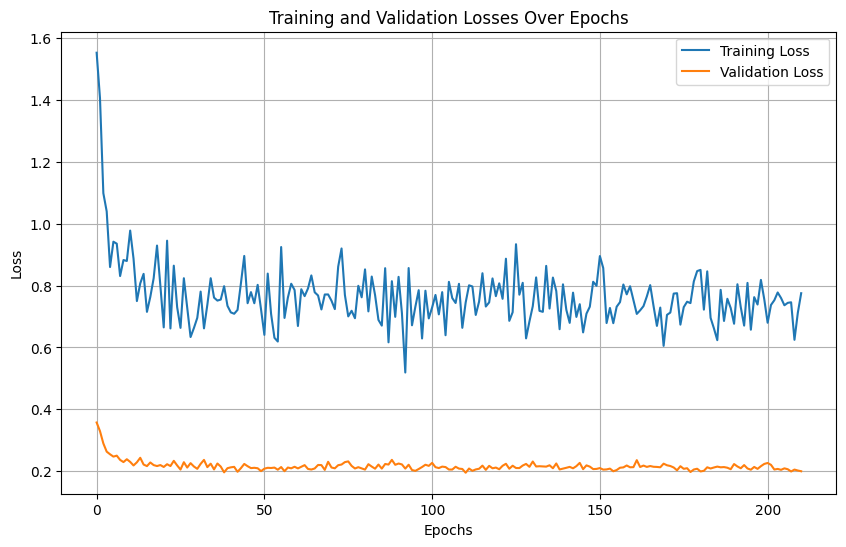

Model weights saved to model.pth


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler

# Set up device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mean and std for normalization (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class BirdDataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.allowed_classes = allowed_classes

        self.samples = []
        for class_idx, class_name in enumerate(allowed_classes):
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2):
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    dataset = BirdDataset(image_dir=image_dir, allowed_classes=classes, transform=train_transform)

    # Creating data indices for training and validation splits
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    random.seed(42)
    random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

    return train_loader, val_loader

def mixup_data(x, y, alpha=1.0):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    scores = [[], []]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"  # Update this path to your dataset
    train_loader, val_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=2)

    model = Model().to(device)
    num_epochs, patience = 300, 100

    trained_model, training_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

if __name__ == "__main__":
    main()




---



In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # Load ResNet18 without pre-trained weights
        self.base_model = models.resnet18(weights=None)
        # Replace the final fully connected layer
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]



Epoch 1/300, Training Loss: 1.1855, Validation Loss: 0.2774
F1 Score on Validation set: 0.1963, Accuracy on Validation set: 0.3000
Validation loss improved. Saving best model state.



Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 2/300, Training Loss: 1.1260, Validation Loss: 0.2828
F1 Score on Validation set: 0.0667, Accuracy on Validation set: 0.2000
No improvement in validation loss for 1 epochs.



Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 3/300, Training Loss: 1.1107, Validation Loss: 0.2907
F1 Score on Validation set: 0.1025, Accuracy on Validation set: 0.2000
No improvement in validation loss for 2 epochs.



Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 4/300, Training Loss: 1.0736, Validation Loss: 0.2796
F1 Score on Validation set: 0.2822, Accuracy on Validation set: 0.3333
No improvement in validation loss for 3 epochs.



Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 5/300, Training Loss: 1.1059, Validation Loss: 0.2825
F1 Score on Validation set: 0.1931, Accuracy on Validation set: 0.2333
No improvement in validation loss for 4 epochs.



Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 6/300, Training Loss: 1.0931, Validation Loss: 0.2819
F1 Score on Validation set: 0.2462, Accuracy on Validation set: 0.2333
No improvement in validation loss for 5 epochs.



Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 7/300, Training Loss: 1.0872, Validation Loss: 0.2837
F1 Score on Validation set: 0.0711, Accuracy on Validation set: 0.0667
No improvement in validation loss for 6 epochs.



Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 8/300, Training Loss: 1.0830, Validation Loss: 0.2844
F1 Score on Validation set: 0.2899, Accuracy on Validation set: 0.3000
No improvement in validation loss for 7 epochs.



Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]



Epoch 9/300, Training Loss: 1.0567, Validation Loss: 0.2756
F1 Score on Validation set: 0.1273, Accuracy on Validation set: 0.2333
Validation loss improved. Saving best model state.



Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]



Epoch 10/300, Training Loss: 1.0671, Validation Loss: 0.3194
F1 Score on Validation set: 0.2378, Accuracy on Validation set: 0.2667
No improvement in validation loss for 1 epochs.



Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 11/300, Training Loss: 1.0362, Validation Loss: 0.2805
F1 Score on Validation set: 0.2770, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]



Epoch 12/300, Training Loss: 1.0643, Validation Loss: 0.2656
F1 Score on Validation set: 0.2221, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.



Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]



Epoch 13/300, Training Loss: 1.0379, Validation Loss: 0.2895
F1 Score on Validation set: 0.1264, Accuracy on Validation set: 0.1667
No improvement in validation loss for 1 epochs.



Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]



Epoch 14/300, Training Loss: 1.0404, Validation Loss: 0.3084
F1 Score on Validation set: 0.1569, Accuracy on Validation set: 0.2333
No improvement in validation loss for 2 epochs.



Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]



Epoch 15/300, Training Loss: 1.0222, Validation Loss: 0.2983
F1 Score on Validation set: 0.1153, Accuracy on Validation set: 0.1667
No improvement in validation loss for 3 epochs.



Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]



Epoch 16/300, Training Loss: 1.0100, Validation Loss: 0.2915
F1 Score on Validation set: 0.2042, Accuracy on Validation set: 0.3000
No improvement in validation loss for 4 epochs.



Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 17/300, Training Loss: 1.0770, Validation Loss: 0.3025
F1 Score on Validation set: 0.1194, Accuracy on Validation set: 0.1667
No improvement in validation loss for 5 epochs.



Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



Epoch 18/300, Training Loss: 1.0114, Validation Loss: 0.2857
F1 Score on Validation set: 0.2688, Accuracy on Validation set: 0.3000
No improvement in validation loss for 6 epochs.



Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]



Epoch 19/300, Training Loss: 0.9608, Validation Loss: 0.2789
F1 Score on Validation set: 0.2855, Accuracy on Validation set: 0.3000
No improvement in validation loss for 7 epochs.



Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 20/300, Training Loss: 0.9697, Validation Loss: 0.2833
F1 Score on Validation set: 0.2269, Accuracy on Validation set: 0.2667
No improvement in validation loss for 8 epochs.



Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 21/300, Training Loss: 0.9631, Validation Loss: 0.2916
F1 Score on Validation set: 0.1071, Accuracy on Validation set: 0.1667
No improvement in validation loss for 9 epochs.



Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]



Epoch 22/300, Training Loss: 0.9786, Validation Loss: 0.2851
F1 Score on Validation set: 0.2847, Accuracy on Validation set: 0.2667
No improvement in validation loss for 10 epochs.



Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]



Epoch 23/300, Training Loss: 0.9802, Validation Loss: 0.2843
F1 Score on Validation set: 0.2634, Accuracy on Validation set: 0.2667
No improvement in validation loss for 11 epochs.



Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]



Epoch 24/300, Training Loss: 0.9771, Validation Loss: 0.2660
F1 Score on Validation set: 0.2389, Accuracy on Validation set: 0.2667
No improvement in validation loss for 12 epochs.



Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



Epoch 25/300, Training Loss: 0.9947, Validation Loss: 0.2787
F1 Score on Validation set: 0.3327, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 26/300, Training Loss: 0.9484, Validation Loss: 0.2750
F1 Score on Validation set: 0.5256, Accuracy on Validation set: 0.5333
No improvement in validation loss for 14 epochs.



Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]



Epoch 27/300, Training Loss: 0.9597, Validation Loss: 0.3184
F1 Score on Validation set: 0.3241, Accuracy on Validation set: 0.4000
No improvement in validation loss for 15 epochs.



Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]



Epoch 28/300, Training Loss: 0.9656, Validation Loss: 0.3051
F1 Score on Validation set: 0.2786, Accuracy on Validation set: 0.3667
No improvement in validation loss for 16 epochs.



Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]



Epoch 29/300, Training Loss: 0.9529, Validation Loss: 0.2913
F1 Score on Validation set: 0.3539, Accuracy on Validation set: 0.3667
No improvement in validation loss for 17 epochs.



Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]



Epoch 30/300, Training Loss: 0.9479, Validation Loss: 0.3281
F1 Score on Validation set: 0.3161, Accuracy on Validation set: 0.3333
No improvement in validation loss for 18 epochs.



Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



Epoch 31/300, Training Loss: 0.9397, Validation Loss: 0.2847
F1 Score on Validation set: 0.3667, Accuracy on Validation set: 0.4000
No improvement in validation loss for 19 epochs.



Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]



Epoch 32/300, Training Loss: 0.9370, Validation Loss: 0.2748
F1 Score on Validation set: 0.3984, Accuracy on Validation set: 0.4000
No improvement in validation loss for 20 epochs.



Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]



Epoch 33/300, Training Loss: 0.8974, Validation Loss: 0.3206
F1 Score on Validation set: 0.2971, Accuracy on Validation set: 0.3667
No improvement in validation loss for 21 epochs.



Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch 34/300, Training Loss: 0.8263, Validation Loss: 0.3424
F1 Score on Validation set: 0.1805, Accuracy on Validation set: 0.2333
No improvement in validation loss for 22 epochs.



Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 35/300, Training Loss: 0.9869, Validation Loss: 0.3132
F1 Score on Validation set: 0.3055, Accuracy on Validation set: 0.3000
No improvement in validation loss for 23 epochs.



Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 36/300, Training Loss: 0.9229, Validation Loss: 0.3071
F1 Score on Validation set: 0.3214, Accuracy on Validation set: 0.3333
No improvement in validation loss for 24 epochs.



Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 37/300, Training Loss: 0.8688, Validation Loss: 0.2934
F1 Score on Validation set: 0.2772, Accuracy on Validation set: 0.3000
No improvement in validation loss for 25 epochs.



Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 38/300, Training Loss: 0.9660, Validation Loss: 0.3463
F1 Score on Validation set: 0.2421, Accuracy on Validation set: 0.3000
No improvement in validation loss for 26 epochs.



Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 39/300, Training Loss: 0.9826, Validation Loss: 0.3599
F1 Score on Validation set: 0.2164, Accuracy on Validation set: 0.2667
No improvement in validation loss for 27 epochs.



Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 40/300, Training Loss: 0.8930, Validation Loss: 0.3012
F1 Score on Validation set: 0.2751, Accuracy on Validation set: 0.3000
No improvement in validation loss for 28 epochs.



Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 41/300, Training Loss: 0.8178, Validation Loss: 0.2739
F1 Score on Validation set: 0.2714, Accuracy on Validation set: 0.3000
No improvement in validation loss for 29 epochs.



Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 42/300, Training Loss: 0.8148, Validation Loss: 0.3272
F1 Score on Validation set: 0.2608, Accuracy on Validation set: 0.2667
No improvement in validation loss for 30 epochs.



Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 43/300, Training Loss: 0.9090, Validation Loss: 0.3053
F1 Score on Validation set: 0.3020, Accuracy on Validation set: 0.3667
No improvement in validation loss for 31 epochs.



Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]



Epoch 44/300, Training Loss: 0.8212, Validation Loss: 0.2650
F1 Score on Validation set: 0.4244, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 45/300, Training Loss: 0.9104, Validation Loss: 0.2698
F1 Score on Validation set: 0.3896, Accuracy on Validation set: 0.4333
No improvement in validation loss for 1 epochs.



Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 46/300, Training Loss: 0.8757, Validation Loss: 0.2984
F1 Score on Validation set: 0.3298, Accuracy on Validation set: 0.3667
No improvement in validation loss for 2 epochs.



Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 47/300, Training Loss: 0.8204, Validation Loss: 0.2738
F1 Score on Validation set: 0.3893, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.



Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 48/300, Training Loss: 0.8240, Validation Loss: 0.2792
F1 Score on Validation set: 0.3416, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 49/300, Training Loss: 0.7852, Validation Loss: 0.2832
F1 Score on Validation set: 0.4467, Accuracy on Validation set: 0.4667
No improvement in validation loss for 5 epochs.



Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 50/300, Training Loss: 0.8491, Validation Loss: 0.2497
F1 Score on Validation set: 0.3179, Accuracy on Validation set: 0.3667
Validation loss improved. Saving best model state.



Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 51/300, Training Loss: 0.8476, Validation Loss: 0.2974
F1 Score on Validation set: 0.3977, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 52/300, Training Loss: 0.8541, Validation Loss: 0.2576
F1 Score on Validation set: 0.3494, Accuracy on Validation set: 0.3667
No improvement in validation loss for 2 epochs.



Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Epoch 53/300, Training Loss: 0.8550, Validation Loss: 0.2561
F1 Score on Validation set: 0.4533, Accuracy on Validation set: 0.4667
No improvement in validation loss for 3 epochs.



Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 54/300, Training Loss: 0.7871, Validation Loss: 0.2798
F1 Score on Validation set: 0.2926, Accuracy on Validation set: 0.3000
No improvement in validation loss for 4 epochs.



Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 55/300, Training Loss: 0.7862, Validation Loss: 0.2888
F1 Score on Validation set: 0.2460, Accuracy on Validation set: 0.2667
No improvement in validation loss for 5 epochs.



Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Epoch 56/300, Training Loss: 0.8068, Validation Loss: 0.2658
F1 Score on Validation set: 0.2697, Accuracy on Validation set: 0.3000
No improvement in validation loss for 6 epochs.



Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]



Epoch 57/300, Training Loss: 0.8843, Validation Loss: 0.3347
F1 Score on Validation set: 0.2882, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.



Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 58/300, Training Loss: 0.8090, Validation Loss: 0.3233
F1 Score on Validation set: 0.1959, Accuracy on Validation set: 0.2667
No improvement in validation loss for 8 epochs.



Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



Epoch 59/300, Training Loss: 0.7419, Validation Loss: 0.2986
F1 Score on Validation set: 0.4371, Accuracy on Validation set: 0.4333
No improvement in validation loss for 9 epochs.



Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 60/300, Training Loss: 0.8682, Validation Loss: 0.3235
F1 Score on Validation set: 0.2116, Accuracy on Validation set: 0.2667
No improvement in validation loss for 10 epochs.



Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]



Epoch 61/300, Training Loss: 0.7118, Validation Loss: 0.3322
F1 Score on Validation set: 0.2225, Accuracy on Validation set: 0.3000
No improvement in validation loss for 11 epochs.



Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 62/300, Training Loss: 0.9305, Validation Loss: 0.3825
F1 Score on Validation set: 0.2043, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 63/300, Training Loss: 0.8587, Validation Loss: 0.2911
F1 Score on Validation set: 0.2771, Accuracy on Validation set: 0.3667
No improvement in validation loss for 13 epochs.



Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 64/300, Training Loss: 0.8500, Validation Loss: 0.2681
F1 Score on Validation set: 0.3540, Accuracy on Validation set: 0.3667
No improvement in validation loss for 14 epochs.



Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 65/300, Training Loss: 0.8133, Validation Loss: 0.2783
F1 Score on Validation set: 0.2490, Accuracy on Validation set: 0.2333
No improvement in validation loss for 15 epochs.



Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 66/300, Training Loss: 0.9478, Validation Loss: 0.2935
F1 Score on Validation set: 0.3115, Accuracy on Validation set: 0.3333
No improvement in validation loss for 16 epochs.



Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 67/300, Training Loss: 0.8595, Validation Loss: 0.3056
F1 Score on Validation set: 0.1960, Accuracy on Validation set: 0.2667
No improvement in validation loss for 17 epochs.



Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Epoch 68/300, Training Loss: 0.8072, Validation Loss: 0.2957
F1 Score on Validation set: 0.3286, Accuracy on Validation set: 0.4000
No improvement in validation loss for 18 epochs.



Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 69/300, Training Loss: 0.7820, Validation Loss: 0.3101
F1 Score on Validation set: 0.2968, Accuracy on Validation set: 0.3333
No improvement in validation loss for 19 epochs.



Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 70/300, Training Loss: 0.7634, Validation Loss: 0.2686
F1 Score on Validation set: 0.3687, Accuracy on Validation set: 0.4000
No improvement in validation loss for 20 epochs.



Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 71/300, Training Loss: 0.8635, Validation Loss: 0.2947
F1 Score on Validation set: 0.2850, Accuracy on Validation set: 0.3333
No improvement in validation loss for 21 epochs.



Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 72/300, Training Loss: 0.8117, Validation Loss: 0.2908
F1 Score on Validation set: 0.3458, Accuracy on Validation set: 0.3667
No improvement in validation loss for 22 epochs.



Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]



Epoch 73/300, Training Loss: 0.6880, Validation Loss: 0.2870
F1 Score on Validation set: 0.3047, Accuracy on Validation set: 0.3000
No improvement in validation loss for 23 epochs.



Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 74/300, Training Loss: 0.7260, Validation Loss: 0.2876
F1 Score on Validation set: 0.4428, Accuracy on Validation set: 0.4667
No improvement in validation loss for 24 epochs.



Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]



Epoch 75/300, Training Loss: 0.8497, Validation Loss: 0.3122
F1 Score on Validation set: 0.3782, Accuracy on Validation set: 0.4000
No improvement in validation loss for 25 epochs.



Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 76/300, Training Loss: 0.7902, Validation Loss: 0.3328
F1 Score on Validation set: 0.2640, Accuracy on Validation set: 0.3333
No improvement in validation loss for 26 epochs.



Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 77/300, Training Loss: 0.7411, Validation Loss: 0.3746
F1 Score on Validation set: 0.2212, Accuracy on Validation set: 0.2667
No improvement in validation loss for 27 epochs.



Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 78/300, Training Loss: 0.8755, Validation Loss: 0.2651
F1 Score on Validation set: 0.4032, Accuracy on Validation set: 0.4333
No improvement in validation loss for 28 epochs.



Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 79/300, Training Loss: 0.8119, Validation Loss: 0.3029
F1 Score on Validation set: 0.1813, Accuracy on Validation set: 0.1667
No improvement in validation loss for 29 epochs.



Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 80/300, Training Loss: 0.8530, Validation Loss: 0.3093
F1 Score on Validation set: 0.2567, Accuracy on Validation set: 0.2667
No improvement in validation loss for 30 epochs.



Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 81/300, Training Loss: 0.7675, Validation Loss: 0.3123
F1 Score on Validation set: 0.2436, Accuracy on Validation set: 0.2667
No improvement in validation loss for 31 epochs.



Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 82/300, Training Loss: 0.7933, Validation Loss: 0.2539
F1 Score on Validation set: 0.3263, Accuracy on Validation set: 0.3333
No improvement in validation loss for 32 epochs.



Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 83/300, Training Loss: 0.7011, Validation Loss: 0.2832
F1 Score on Validation set: 0.2745, Accuracy on Validation set: 0.2667
No improvement in validation loss for 33 epochs.



Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 84/300, Training Loss: 0.7864, Validation Loss: 0.2691
F1 Score on Validation set: 0.4037, Accuracy on Validation set: 0.4000
No improvement in validation loss for 34 epochs.



Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 85/300, Training Loss: 0.7619, Validation Loss: 0.2933
F1 Score on Validation set: 0.3205, Accuracy on Validation set: 0.3333
No improvement in validation loss for 35 epochs.



Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 86/300, Training Loss: 0.7234, Validation Loss: 0.3100
F1 Score on Validation set: 0.4399, Accuracy on Validation set: 0.5000
No improvement in validation loss for 36 epochs.



Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 87/300, Training Loss: 0.6884, Validation Loss: 0.3173
F1 Score on Validation set: 0.3116, Accuracy on Validation set: 0.3333
No improvement in validation loss for 37 epochs.



Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 88/300, Training Loss: 0.6518, Validation Loss: 0.2705
F1 Score on Validation set: 0.3880, Accuracy on Validation set: 0.4333
No improvement in validation loss for 38 epochs.



Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 89/300, Training Loss: 0.7682, Validation Loss: 0.2848
F1 Score on Validation set: 0.3735, Accuracy on Validation set: 0.4000
No improvement in validation loss for 39 epochs.



Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 90/300, Training Loss: 0.8615, Validation Loss: 0.2853
F1 Score on Validation set: 0.3754, Accuracy on Validation set: 0.4000
No improvement in validation loss for 40 epochs.



Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]



Epoch 91/300, Training Loss: 0.5816, Validation Loss: 0.3119
F1 Score on Validation set: 0.4070, Accuracy on Validation set: 0.4000
No improvement in validation loss for 41 epochs.



Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 92/300, Training Loss: 0.7085, Validation Loss: 0.2777
F1 Score on Validation set: 0.3528, Accuracy on Validation set: 0.4000
No improvement in validation loss for 42 epochs.



Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 93/300, Training Loss: 0.7196, Validation Loss: 0.2751
F1 Score on Validation set: 0.3969, Accuracy on Validation set: 0.4333
No improvement in validation loss for 43 epochs.



Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 94/300, Training Loss: 0.7870, Validation Loss: 0.3244
F1 Score on Validation set: 0.2838, Accuracy on Validation set: 0.3333
No improvement in validation loss for 44 epochs.



Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 95/300, Training Loss: 0.7448, Validation Loss: 0.2812
F1 Score on Validation set: 0.3510, Accuracy on Validation set: 0.3667
No improvement in validation loss for 45 epochs.



Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 96/300, Training Loss: 0.6937, Validation Loss: 0.2785
F1 Score on Validation set: 0.4878, Accuracy on Validation set: 0.5000
No improvement in validation loss for 46 epochs.



Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 97/300, Training Loss: 0.7348, Validation Loss: 0.2933
F1 Score on Validation set: 0.2660, Accuracy on Validation set: 0.2667
No improvement in validation loss for 47 epochs.



Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 98/300, Training Loss: 0.6301, Validation Loss: 0.3080
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4000
No improvement in validation loss for 48 epochs.



Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 99/300, Training Loss: 0.7438, Validation Loss: 0.2633
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4333
No improvement in validation loss for 49 epochs.



Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 100/300, Training Loss: 0.5566, Validation Loss: 0.2692
F1 Score on Validation set: 0.2956, Accuracy on Validation set: 0.3000
No improvement in validation loss for 50 epochs.



Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 101/300, Training Loss: 0.6169, Validation Loss: 0.3090
F1 Score on Validation set: 0.2253, Accuracy on Validation set: 0.2333
No improvement in validation loss for 51 epochs.



Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 102/300, Training Loss: 0.6750, Validation Loss: 0.3213
F1 Score on Validation set: 0.3110, Accuracy on Validation set: 0.3333
No improvement in validation loss for 52 epochs.



Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 103/300, Training Loss: 0.6803, Validation Loss: 0.2722
F1 Score on Validation set: 0.2870, Accuracy on Validation set: 0.3000
No improvement in validation loss for 53 epochs.



Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 104/300, Training Loss: 0.6814, Validation Loss: 0.3114
F1 Score on Validation set: 0.3105, Accuracy on Validation set: 0.3000
No improvement in validation loss for 54 epochs.



Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 105/300, Training Loss: 0.6438, Validation Loss: 0.2513
F1 Score on Validation set: 0.4444, Accuracy on Validation set: 0.4333
No improvement in validation loss for 55 epochs.



Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 106/300, Training Loss: 0.7477, Validation Loss: 0.2712
F1 Score on Validation set: 0.4280, Accuracy on Validation set: 0.4333
No improvement in validation loss for 56 epochs.



Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 107/300, Training Loss: 0.5987, Validation Loss: 0.2950
F1 Score on Validation set: 0.3358, Accuracy on Validation set: 0.3333
No improvement in validation loss for 57 epochs.



Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 108/300, Training Loss: 0.7660, Validation Loss: 0.3161
F1 Score on Validation set: 0.2582, Accuracy on Validation set: 0.2667
No improvement in validation loss for 58 epochs.



Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 109/300, Training Loss: 0.6959, Validation Loss: 0.3051
F1 Score on Validation set: 0.3241, Accuracy on Validation set: 0.3333
No improvement in validation loss for 59 epochs.



Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 110/300, Training Loss: 0.6839, Validation Loss: 0.2881
F1 Score on Validation set: 0.3377, Accuracy on Validation set: 0.3333
No improvement in validation loss for 60 epochs.



Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 111/300, Training Loss: 0.8170, Validation Loss: 0.2668
F1 Score on Validation set: 0.4761, Accuracy on Validation set: 0.5000
No improvement in validation loss for 61 epochs.



Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 112/300, Training Loss: 0.7390, Validation Loss: 0.3019
F1 Score on Validation set: 0.2977, Accuracy on Validation set: 0.3333
No improvement in validation loss for 62 epochs.



Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 113/300, Training Loss: 0.6133, Validation Loss: 0.2810
F1 Score on Validation set: 0.4275, Accuracy on Validation set: 0.4333
No improvement in validation loss for 63 epochs.



Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 114/300, Training Loss: 0.6253, Validation Loss: 0.2746
F1 Score on Validation set: 0.3426, Accuracy on Validation set: 0.3667
No improvement in validation loss for 64 epochs.



Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 115/300, Training Loss: 0.7379, Validation Loss: 0.2672
F1 Score on Validation set: 0.4098, Accuracy on Validation set: 0.4333
No improvement in validation loss for 65 epochs.



Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 116/300, Training Loss: 0.6485, Validation Loss: 0.3169
F1 Score on Validation set: 0.2548, Accuracy on Validation set: 0.3000
No improvement in validation loss for 66 epochs.



Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 117/300, Training Loss: 0.7030, Validation Loss: 0.3186
F1 Score on Validation set: 0.2032, Accuracy on Validation set: 0.2333
No improvement in validation loss for 67 epochs.



Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 118/300, Training Loss: 0.5968, Validation Loss: 0.2963
F1 Score on Validation set: 0.3943, Accuracy on Validation set: 0.4000
No improvement in validation loss for 68 epochs.



Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 119/300, Training Loss: 0.8056, Validation Loss: 0.2826
F1 Score on Validation set: 0.3859, Accuracy on Validation set: 0.3667
No improvement in validation loss for 69 epochs.



Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]



Epoch 120/300, Training Loss: 0.7274, Validation Loss: 0.2996
F1 Score on Validation set: 0.3190, Accuracy on Validation set: 0.3333
No improvement in validation loss for 70 epochs.



Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



Epoch 121/300, Training Loss: 0.7885, Validation Loss: 0.3189
F1 Score on Validation set: 0.2491, Accuracy on Validation set: 0.3000
No improvement in validation loss for 71 epochs.



Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 122/300, Training Loss: 0.6768, Validation Loss: 0.3100
F1 Score on Validation set: 0.1950, Accuracy on Validation set: 0.2000
No improvement in validation loss for 72 epochs.



Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 123/300, Training Loss: 0.6233, Validation Loss: 0.3133
F1 Score on Validation set: 0.2689, Accuracy on Validation set: 0.3333
No improvement in validation loss for 73 epochs.



Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 124/300, Training Loss: 0.7551, Validation Loss: 0.2727
F1 Score on Validation set: 0.4154, Accuracy on Validation set: 0.4667
No improvement in validation loss for 74 epochs.



Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 125/300, Training Loss: 0.7965, Validation Loss: 0.2930
F1 Score on Validation set: 0.2603, Accuracy on Validation set: 0.3000
No improvement in validation loss for 75 epochs.



Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 126/300, Training Loss: 0.7050, Validation Loss: 0.2959
F1 Score on Validation set: 0.3987, Accuracy on Validation set: 0.4333
No improvement in validation loss for 76 epochs.



Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 127/300, Training Loss: 0.8041, Validation Loss: 0.2972
F1 Score on Validation set: 0.3695, Accuracy on Validation set: 0.4000
No improvement in validation loss for 77 epochs.



Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 128/300, Training Loss: 0.7478, Validation Loss: 0.2381
F1 Score on Validation set: 0.4749, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 129/300, Training Loss: 0.6628, Validation Loss: 0.3672
F1 Score on Validation set: 0.3162, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 130/300, Training Loss: 0.6621, Validation Loss: 0.3337
F1 Score on Validation set: 0.3241, Accuracy on Validation set: 0.3667
No improvement in validation loss for 2 epochs.



Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]



Epoch 131/300, Training Loss: 0.6509, Validation Loss: 0.3193
F1 Score on Validation set: 0.2477, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.



Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 132/300, Training Loss: 0.8189, Validation Loss: 0.3099
F1 Score on Validation set: 0.2884, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 133/300, Training Loss: 0.7055, Validation Loss: 0.2779
F1 Score on Validation set: 0.3163, Accuracy on Validation set: 0.4000
No improvement in validation loss for 5 epochs.



Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]



Epoch 134/300, Training Loss: 0.7970, Validation Loss: 0.2971
F1 Score on Validation set: 0.3517, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 135/300, Training Loss: 0.6817, Validation Loss: 0.2527
F1 Score on Validation set: 0.5095, Accuracy on Validation set: 0.5667
No improvement in validation loss for 7 epochs.



Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



Epoch 136/300, Training Loss: 0.5909, Validation Loss: 0.2579
F1 Score on Validation set: 0.3047, Accuracy on Validation set: 0.3333
No improvement in validation loss for 8 epochs.



Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 137/300, Training Loss: 0.7403, Validation Loss: 0.2811
F1 Score on Validation set: 0.4140, Accuracy on Validation set: 0.4333
No improvement in validation loss for 9 epochs.



Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 138/300, Training Loss: 0.4859, Validation Loss: 0.3001
F1 Score on Validation set: 0.2519, Accuracy on Validation set: 0.2667
No improvement in validation loss for 10 epochs.



Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 139/300, Training Loss: 0.8277, Validation Loss: 0.3162
F1 Score on Validation set: 0.2992, Accuracy on Validation set: 0.3000
No improvement in validation loss for 11 epochs.



Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 140/300, Training Loss: 0.6244, Validation Loss: 0.2784
F1 Score on Validation set: 0.3967, Accuracy on Validation set: 0.4333
No improvement in validation loss for 12 epochs.



Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Epoch 141/300, Training Loss: 0.5616, Validation Loss: 0.2797
F1 Score on Validation set: 0.4467, Accuracy on Validation set: 0.4667
No improvement in validation loss for 13 epochs.



Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 142/300, Training Loss: 0.7278, Validation Loss: 0.2345
F1 Score on Validation set: 0.5443, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.



Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 143/300, Training Loss: 0.7254, Validation Loss: 0.3113
F1 Score on Validation set: 0.2702, Accuracy on Validation set: 0.3000
No improvement in validation loss for 1 epochs.



Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 144/300, Training Loss: 0.6937, Validation Loss: 0.3045
F1 Score on Validation set: 0.3505, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 145/300, Training Loss: 0.7470, Validation Loss: 0.3026
F1 Score on Validation set: 0.2750, Accuracy on Validation set: 0.3000
No improvement in validation loss for 3 epochs.



Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 146/300, Training Loss: 0.7106, Validation Loss: 0.3180
F1 Score on Validation set: 0.2115, Accuracy on Validation set: 0.2667
No improvement in validation loss for 4 epochs.



Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 147/300, Training Loss: 0.8688, Validation Loss: 0.2799
F1 Score on Validation set: 0.4344, Accuracy on Validation set: 0.4333
No improvement in validation loss for 5 epochs.



Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 148/300, Training Loss: 0.6003, Validation Loss: 0.2422
F1 Score on Validation set: 0.5580, Accuracy on Validation set: 0.5667
No improvement in validation loss for 6 epochs.



Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 149/300, Training Loss: 0.6178, Validation Loss: 0.3277
F1 Score on Validation set: 0.1636, Accuracy on Validation set: 0.2667
No improvement in validation loss for 7 epochs.



Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]



Epoch 150/300, Training Loss: 0.7363, Validation Loss: 0.2862
F1 Score on Validation set: 0.3510, Accuracy on Validation set: 0.4333
No improvement in validation loss for 8 epochs.



Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



Epoch 151/300, Training Loss: 0.8486, Validation Loss: 0.2977
F1 Score on Validation set: 0.2906, Accuracy on Validation set: 0.3000
No improvement in validation loss for 9 epochs.



Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]



Epoch 152/300, Training Loss: 0.7930, Validation Loss: 0.2948
F1 Score on Validation set: 0.2714, Accuracy on Validation set: 0.3000
No improvement in validation loss for 10 epochs.



Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 153/300, Training Loss: 0.5261, Validation Loss: 0.3009
F1 Score on Validation set: 0.2740, Accuracy on Validation set: 0.3000
No improvement in validation loss for 11 epochs.



Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 154/300, Training Loss: 0.6512, Validation Loss: 0.2920
F1 Score on Validation set: 0.3171, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 155/300, Training Loss: 0.7058, Validation Loss: 0.2917
F1 Score on Validation set: 0.2824, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 156/300, Training Loss: 0.5967, Validation Loss: 0.2795
F1 Score on Validation set: 0.4649, Accuracy on Validation set: 0.4667
No improvement in validation loss for 14 epochs.



Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 157/300, Training Loss: 0.7764, Validation Loss: 0.2873
F1 Score on Validation set: 0.3397, Accuracy on Validation set: 0.3667
No improvement in validation loss for 15 epochs.



Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 158/300, Training Loss: 0.8001, Validation Loss: 0.3168
F1 Score on Validation set: 0.2873, Accuracy on Validation set: 0.2667
No improvement in validation loss for 16 epochs.



Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 159/300, Training Loss: 0.7462, Validation Loss: 0.2807
F1 Score on Validation set: 0.4250, Accuracy on Validation set: 0.4333
No improvement in validation loss for 17 epochs.



Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 160/300, Training Loss: 0.5636, Validation Loss: 0.3308
F1 Score on Validation set: 0.3516, Accuracy on Validation set: 0.3667
No improvement in validation loss for 18 epochs.



Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 161/300, Training Loss: 0.6983, Validation Loss: 0.2368
F1 Score on Validation set: 0.4310, Accuracy on Validation set: 0.4333
No improvement in validation loss for 19 epochs.



Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 162/300, Training Loss: 0.6495, Validation Loss: 0.3045
F1 Score on Validation set: 0.4037, Accuracy on Validation set: 0.4000
No improvement in validation loss for 20 epochs.



Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 163/300, Training Loss: 0.6918, Validation Loss: 0.2740
F1 Score on Validation set: 0.4251, Accuracy on Validation set: 0.4667
No improvement in validation loss for 21 epochs.



Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 164/300, Training Loss: 0.6176, Validation Loss: 0.3113
F1 Score on Validation set: 0.3010, Accuracy on Validation set: 0.3333
No improvement in validation loss for 22 epochs.



Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



Epoch 165/300, Training Loss: 0.5144, Validation Loss: 0.3449
F1 Score on Validation set: 0.3471, Accuracy on Validation set: 0.4000
No improvement in validation loss for 23 epochs.



Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 166/300, Training Loss: 0.6122, Validation Loss: 0.2597
F1 Score on Validation set: 0.4187, Accuracy on Validation set: 0.4667
No improvement in validation loss for 24 epochs.



Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]



Epoch 167/300, Training Loss: 0.6938, Validation Loss: 0.2950
F1 Score on Validation set: 0.4750, Accuracy on Validation set: 0.4667
No improvement in validation loss for 25 epochs.



Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]



Epoch 168/300, Training Loss: 0.7007, Validation Loss: 0.2712
F1 Score on Validation set: 0.4000, Accuracy on Validation set: 0.4333
No improvement in validation loss for 26 epochs.



Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 169/300, Training Loss: 0.5756, Validation Loss: 0.2909
F1 Score on Validation set: 0.3167, Accuracy on Validation set: 0.3333
No improvement in validation loss for 27 epochs.



Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 170/300, Training Loss: 0.5497, Validation Loss: 0.2776
F1 Score on Validation set: 0.2708, Accuracy on Validation set: 0.2667
No improvement in validation loss for 28 epochs.



Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 171/300, Training Loss: 0.6635, Validation Loss: 0.2692
F1 Score on Validation set: 0.3150, Accuracy on Validation set: 0.3333
No improvement in validation loss for 29 epochs.



Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 172/300, Training Loss: 0.6075, Validation Loss: 0.2912
F1 Score on Validation set: 0.3467, Accuracy on Validation set: 0.3333
No improvement in validation loss for 30 epochs.



Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 173/300, Training Loss: 0.8328, Validation Loss: 0.2801
F1 Score on Validation set: 0.3365, Accuracy on Validation set: 0.3667
No improvement in validation loss for 31 epochs.



Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 174/300, Training Loss: 0.5622, Validation Loss: 0.3198
F1 Score on Validation set: 0.3593, Accuracy on Validation set: 0.4000
No improvement in validation loss for 32 epochs.



Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 175/300, Training Loss: 0.7084, Validation Loss: 0.2990
F1 Score on Validation set: 0.4297, Accuracy on Validation set: 0.4667
No improvement in validation loss for 33 epochs.



Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 176/300, Training Loss: 0.6547, Validation Loss: 0.3206
F1 Score on Validation set: 0.2424, Accuracy on Validation set: 0.3000
No improvement in validation loss for 34 epochs.



Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 177/300, Training Loss: 0.6767, Validation Loss: 0.2887
F1 Score on Validation set: 0.2141, Accuracy on Validation set: 0.2667
No improvement in validation loss for 35 epochs.



Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 178/300, Training Loss: 0.6446, Validation Loss: 0.2364
F1 Score on Validation set: 0.4515, Accuracy on Validation set: 0.4667
No improvement in validation loss for 36 epochs.



Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 179/300, Training Loss: 0.7214, Validation Loss: 0.2760
F1 Score on Validation set: 0.4233, Accuracy on Validation set: 0.4667
No improvement in validation loss for 37 epochs.



Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 180/300, Training Loss: 0.4503, Validation Loss: 0.2709
F1 Score on Validation set: 0.3680, Accuracy on Validation set: 0.4333
No improvement in validation loss for 38 epochs.



Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 181/300, Training Loss: 0.6573, Validation Loss: 0.2685
F1 Score on Validation set: 0.4220, Accuracy on Validation set: 0.4333
No improvement in validation loss for 39 epochs.



Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]



Epoch 182/300, Training Loss: 0.6185, Validation Loss: 0.2801
F1 Score on Validation set: 0.4156, Accuracy on Validation set: 0.4333
No improvement in validation loss for 40 epochs.



Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 183/300, Training Loss: 0.5290, Validation Loss: 0.2787
F1 Score on Validation set: 0.4419, Accuracy on Validation set: 0.4333
No improvement in validation loss for 41 epochs.



Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 184/300, Training Loss: 0.5372, Validation Loss: 0.2443
F1 Score on Validation set: 0.4351, Accuracy on Validation set: 0.4333
No improvement in validation loss for 42 epochs.



Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 185/300, Training Loss: 0.6771, Validation Loss: 0.2812
F1 Score on Validation set: 0.4377, Accuracy on Validation set: 0.5000
No improvement in validation loss for 43 epochs.



Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 186/300, Training Loss: 0.7542, Validation Loss: 0.2809
F1 Score on Validation set: 0.4449, Accuracy on Validation set: 0.4333
No improvement in validation loss for 44 epochs.



Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 187/300, Training Loss: 0.6828, Validation Loss: 0.3000
F1 Score on Validation set: 0.3524, Accuracy on Validation set: 0.4000
No improvement in validation loss for 45 epochs.



Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 188/300, Training Loss: 0.6527, Validation Loss: 0.2904
F1 Score on Validation set: 0.3897, Accuracy on Validation set: 0.4667
No improvement in validation loss for 46 epochs.



Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 189/300, Training Loss: 0.8757, Validation Loss: 0.2847
F1 Score on Validation set: 0.4238, Accuracy on Validation set: 0.4667
No improvement in validation loss for 47 epochs.



Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Epoch 190/300, Training Loss: 0.5366, Validation Loss: 0.2511
F1 Score on Validation set: 0.4653, Accuracy on Validation set: 0.4667
No improvement in validation loss for 48 epochs.



Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 191/300, Training Loss: 0.6419, Validation Loss: 0.2842
F1 Score on Validation set: 0.3303, Accuracy on Validation set: 0.3333
No improvement in validation loss for 49 epochs.



Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 192/300, Training Loss: 0.5751, Validation Loss: 0.2608
F1 Score on Validation set: 0.4442, Accuracy on Validation set: 0.5000
No improvement in validation loss for 50 epochs.



Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 193/300, Training Loss: 0.6133, Validation Loss: 0.2292
F1 Score on Validation set: 0.5295, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.



Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 194/300, Training Loss: 0.6017, Validation Loss: 0.2681
F1 Score on Validation set: 0.3636, Accuracy on Validation set: 0.3667
No improvement in validation loss for 1 epochs.



Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 195/300, Training Loss: 0.5299, Validation Loss: 0.2551
F1 Score on Validation set: 0.3954, Accuracy on Validation set: 0.4000
No improvement in validation loss for 2 epochs.



Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]



Epoch 196/300, Training Loss: 0.6653, Validation Loss: 0.2408
F1 Score on Validation set: 0.5903, Accuracy on Validation set: 0.6000
No improvement in validation loss for 3 epochs.



Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 197/300, Training Loss: 0.6072, Validation Loss: 0.2518
F1 Score on Validation set: 0.4433, Accuracy on Validation set: 0.4667
No improvement in validation loss for 4 epochs.



Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]



Epoch 198/300, Training Loss: 0.8407, Validation Loss: 0.2538
F1 Score on Validation set: 0.2965, Accuracy on Validation set: 0.3667
No improvement in validation loss for 5 epochs.



Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 199/300, Training Loss: 0.7877, Validation Loss: 0.2599
F1 Score on Validation set: 0.4403, Accuracy on Validation set: 0.4667
No improvement in validation loss for 6 epochs.



Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 200/300, Training Loss: 0.6778, Validation Loss: 0.3045
F1 Score on Validation set: 0.4023, Accuracy on Validation set: 0.4333
No improvement in validation loss for 7 epochs.



Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 201/300, Training Loss: 0.6682, Validation Loss: 0.2877
F1 Score on Validation set: 0.3715, Accuracy on Validation set: 0.3667
No improvement in validation loss for 8 epochs.



Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 202/300, Training Loss: 0.7342, Validation Loss: 0.2807
F1 Score on Validation set: 0.4555, Accuracy on Validation set: 0.4667
No improvement in validation loss for 9 epochs.



Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 203/300, Training Loss: 0.6517, Validation Loss: 0.2727
F1 Score on Validation set: 0.4083, Accuracy on Validation set: 0.4000
No improvement in validation loss for 10 epochs.



Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 204/300, Training Loss: 0.5482, Validation Loss: 0.2402
F1 Score on Validation set: 0.4825, Accuracy on Validation set: 0.5000
No improvement in validation loss for 11 epochs.



Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 205/300, Training Loss: 0.5813, Validation Loss: 0.2595
F1 Score on Validation set: 0.4895, Accuracy on Validation set: 0.5000
No improvement in validation loss for 12 epochs.



Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 206/300, Training Loss: 0.7389, Validation Loss: 0.2547
F1 Score on Validation set: 0.4176, Accuracy on Validation set: 0.4333
No improvement in validation loss for 13 epochs.



Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 207/300, Training Loss: 0.7163, Validation Loss: 0.2355
F1 Score on Validation set: 0.5300, Accuracy on Validation set: 0.5333
No improvement in validation loss for 14 epochs.



Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 208/300, Training Loss: 0.6397, Validation Loss: 0.2640
F1 Score on Validation set: 0.3928, Accuracy on Validation set: 0.4000
No improvement in validation loss for 15 epochs.



Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 209/300, Training Loss: 0.4474, Validation Loss: 0.2620
F1 Score on Validation set: 0.4030, Accuracy on Validation set: 0.4333
No improvement in validation loss for 16 epochs.



Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 210/300, Training Loss: 0.5060, Validation Loss: 0.2323
F1 Score on Validation set: 0.5241, Accuracy on Validation set: 0.5667
No improvement in validation loss for 17 epochs.



Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 211/300, Training Loss: 0.6642, Validation Loss: 0.2429
F1 Score on Validation set: 0.4579, Accuracy on Validation set: 0.4667
No improvement in validation loss for 18 epochs.



Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 212/300, Training Loss: 0.5926, Validation Loss: 0.2527
F1 Score on Validation set: 0.3764, Accuracy on Validation set: 0.4000
No improvement in validation loss for 19 epochs.



Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 213/300, Training Loss: 0.4889, Validation Loss: 0.2489
F1 Score on Validation set: 0.4439, Accuracy on Validation set: 0.4333
No improvement in validation loss for 20 epochs.



Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 214/300, Training Loss: 0.7118, Validation Loss: 0.2514
F1 Score on Validation set: 0.4909, Accuracy on Validation set: 0.5000
No improvement in validation loss for 21 epochs.



Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 215/300, Training Loss: 0.4883, Validation Loss: 0.2443
F1 Score on Validation set: 0.4270, Accuracy on Validation set: 0.4333
No improvement in validation loss for 22 epochs.



Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 216/300, Training Loss: 0.5456, Validation Loss: 0.2769
F1 Score on Validation set: 0.3919, Accuracy on Validation set: 0.4000
No improvement in validation loss for 23 epochs.



Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 217/300, Training Loss: 0.5879, Validation Loss: 0.2614
F1 Score on Validation set: 0.4548, Accuracy on Validation set: 0.4667
No improvement in validation loss for 24 epochs.



Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 218/300, Training Loss: 0.6901, Validation Loss: 0.2442
F1 Score on Validation set: 0.4720, Accuracy on Validation set: 0.5000
No improvement in validation loss for 25 epochs.



Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 219/300, Training Loss: 0.6286, Validation Loss: 0.2369
F1 Score on Validation set: 0.4939, Accuracy on Validation set: 0.5000
No improvement in validation loss for 26 epochs.



Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 220/300, Training Loss: 0.5086, Validation Loss: 0.2561
F1 Score on Validation set: 0.4377, Accuracy on Validation set: 0.4333
No improvement in validation loss for 27 epochs.



Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 221/300, Training Loss: 0.5939, Validation Loss: 0.2705
F1 Score on Validation set: 0.3194, Accuracy on Validation set: 0.3333
No improvement in validation loss for 28 epochs.



Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 222/300, Training Loss: 0.7010, Validation Loss: 0.2694
F1 Score on Validation set: 0.4025, Accuracy on Validation set: 0.4000
No improvement in validation loss for 29 epochs.



Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 223/300, Training Loss: 0.5543, Validation Loss: 0.2448
F1 Score on Validation set: 0.4321, Accuracy on Validation set: 0.4333
No improvement in validation loss for 30 epochs.



Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 224/300, Training Loss: 0.5776, Validation Loss: 0.2605
F1 Score on Validation set: 0.3731, Accuracy on Validation set: 0.4000
No improvement in validation loss for 31 epochs.



Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



Epoch 225/300, Training Loss: 0.5187, Validation Loss: 0.2823
F1 Score on Validation set: 0.4774, Accuracy on Validation set: 0.4667
No improvement in validation loss for 32 epochs.



Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]



Epoch 226/300, Training Loss: 0.6112, Validation Loss: 0.2508
F1 Score on Validation set: 0.5833, Accuracy on Validation set: 0.6000
No improvement in validation loss for 33 epochs.



Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 227/300, Training Loss: 0.4786, Validation Loss: 0.2231
F1 Score on Validation set: 0.5818, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.



Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]



Epoch 228/300, Training Loss: 0.6197, Validation Loss: 0.2976
F1 Score on Validation set: 0.1664, Accuracy on Validation set: 0.1667
No improvement in validation loss for 1 epochs.



Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 229/300, Training Loss: 0.5605, Validation Loss: 0.2747
F1 Score on Validation set: 0.3998, Accuracy on Validation set: 0.4000
No improvement in validation loss for 2 epochs.



Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 230/300, Training Loss: 0.7009, Validation Loss: 0.2556
F1 Score on Validation set: 0.3990, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.



Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 231/300, Training Loss: 0.5382, Validation Loss: 0.2541
F1 Score on Validation set: 0.4125, Accuracy on Validation set: 0.4333
No improvement in validation loss for 4 epochs.



Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 232/300, Training Loss: 0.6512, Validation Loss: 0.2408
F1 Score on Validation set: 0.4192, Accuracy on Validation set: 0.4333
No improvement in validation loss for 5 epochs.



Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 233/300, Training Loss: 0.5760, Validation Loss: 0.2667
F1 Score on Validation set: 0.4000, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 234/300, Training Loss: 0.4916, Validation Loss: 0.2839
F1 Score on Validation set: 0.3618, Accuracy on Validation set: 0.3667
No improvement in validation loss for 7 epochs.



Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 235/300, Training Loss: 0.6180, Validation Loss: 0.2346
F1 Score on Validation set: 0.5372, Accuracy on Validation set: 0.5333
No improvement in validation loss for 8 epochs.



Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 236/300, Training Loss: 0.5167, Validation Loss: 0.2881
F1 Score on Validation set: 0.3300, Accuracy on Validation set: 0.3333
No improvement in validation loss for 9 epochs.



Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 237/300, Training Loss: 0.4297, Validation Loss: 0.2801
F1 Score on Validation set: 0.3722, Accuracy on Validation set: 0.4000
No improvement in validation loss for 10 epochs.



Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 238/300, Training Loss: 0.7220, Validation Loss: 0.2546
F1 Score on Validation set: 0.4970, Accuracy on Validation set: 0.5000
No improvement in validation loss for 11 epochs.



Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 239/300, Training Loss: 0.6370, Validation Loss: 0.2810
F1 Score on Validation set: 0.3843, Accuracy on Validation set: 0.4000
No improvement in validation loss for 12 epochs.



Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 240/300, Training Loss: 0.8167, Validation Loss: 0.2459
F1 Score on Validation set: 0.4138, Accuracy on Validation set: 0.4333
No improvement in validation loss for 13 epochs.



Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 241/300, Training Loss: 0.7154, Validation Loss: 0.2754
F1 Score on Validation set: 0.3122, Accuracy on Validation set: 0.3000
No improvement in validation loss for 14 epochs.



Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]



Epoch 242/300, Training Loss: 0.5515, Validation Loss: 0.2809
F1 Score on Validation set: 0.3705, Accuracy on Validation set: 0.3667
No improvement in validation loss for 15 epochs.



Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 243/300, Training Loss: 0.5302, Validation Loss: 0.2555
F1 Score on Validation set: 0.4354, Accuracy on Validation set: 0.4333
No improvement in validation loss for 16 epochs.



Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 244/300, Training Loss: 0.5871, Validation Loss: 0.2524
F1 Score on Validation set: 0.4280, Accuracy on Validation set: 0.4333
No improvement in validation loss for 17 epochs.



Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 245/300, Training Loss: 0.7800, Validation Loss: 0.2376
F1 Score on Validation set: 0.4982, Accuracy on Validation set: 0.5333
No improvement in validation loss for 18 epochs.



Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 246/300, Training Loss: 0.6681, Validation Loss: 0.2947
F1 Score on Validation set: 0.3131, Accuracy on Validation set: 0.3000
No improvement in validation loss for 19 epochs.



Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 247/300, Training Loss: 0.7108, Validation Loss: 0.2799
F1 Score on Validation set: 0.4019, Accuracy on Validation set: 0.4333
No improvement in validation loss for 20 epochs.



Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 248/300, Training Loss: 0.6034, Validation Loss: 0.2330
F1 Score on Validation set: 0.5206, Accuracy on Validation set: 0.5333
No improvement in validation loss for 21 epochs.



Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 249/300, Training Loss: 0.5395, Validation Loss: 0.2922
F1 Score on Validation set: 0.2640, Accuracy on Validation set: 0.3000
No improvement in validation loss for 22 epochs.



Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 250/300, Training Loss: 0.7355, Validation Loss: 0.2685
F1 Score on Validation set: 0.4114, Accuracy on Validation set: 0.4000
No improvement in validation loss for 23 epochs.



Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 251/300, Training Loss: 0.8659, Validation Loss: 0.2649
F1 Score on Validation set: 0.3813, Accuracy on Validation set: 0.4000
No improvement in validation loss for 24 epochs.



Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 252/300, Training Loss: 0.6604, Validation Loss: 0.3181
F1 Score on Validation set: 0.3796, Accuracy on Validation set: 0.3667
No improvement in validation loss for 25 epochs.



Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 253/300, Training Loss: 0.5547, Validation Loss: 0.2967
F1 Score on Validation set: 0.2435, Accuracy on Validation set: 0.2667
No improvement in validation loss for 26 epochs.



Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 254/300, Training Loss: 0.6322, Validation Loss: 0.2503
F1 Score on Validation set: 0.4506, Accuracy on Validation set: 0.4667
No improvement in validation loss for 27 epochs.



Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 255/300, Training Loss: 0.6740, Validation Loss: 0.2539
F1 Score on Validation set: 0.4286, Accuracy on Validation set: 0.4333
No improvement in validation loss for 28 epochs.



Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 256/300, Training Loss: 0.6847, Validation Loss: 0.2547
F1 Score on Validation set: 0.4024, Accuracy on Validation set: 0.4000
No improvement in validation loss for 29 epochs.



Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]



Epoch 257/300, Training Loss: 0.5938, Validation Loss: 0.2815
F1 Score on Validation set: 0.2919, Accuracy on Validation set: 0.3000
No improvement in validation loss for 30 epochs.



Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 258/300, Training Loss: 0.4957, Validation Loss: 0.2850
F1 Score on Validation set: 0.3638, Accuracy on Validation set: 0.3667
No improvement in validation loss for 31 epochs.



Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 259/300, Training Loss: 0.6163, Validation Loss: 0.2938
F1 Score on Validation set: 0.4393, Accuracy on Validation set: 0.4667
No improvement in validation loss for 32 epochs.



Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 260/300, Training Loss: 0.6490, Validation Loss: 0.2722
F1 Score on Validation set: 0.3692, Accuracy on Validation set: 0.4000
No improvement in validation loss for 33 epochs.



Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 261/300, Training Loss: 0.6679, Validation Loss: 0.2710
F1 Score on Validation set: 0.3372, Accuracy on Validation set: 0.4000
No improvement in validation loss for 34 epochs.



Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 262/300, Training Loss: 0.8059, Validation Loss: 0.2868
F1 Score on Validation set: 0.3336, Accuracy on Validation set: 0.3667
No improvement in validation loss for 35 epochs.



Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 263/300, Training Loss: 0.6020, Validation Loss: 0.3010
F1 Score on Validation set: 0.3514, Accuracy on Validation set: 0.3667
No improvement in validation loss for 36 epochs.



Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 264/300, Training Loss: 0.6857, Validation Loss: 0.2333
F1 Score on Validation set: 0.5496, Accuracy on Validation set: 0.5667
No improvement in validation loss for 37 epochs.



Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 265/300, Training Loss: 0.5268, Validation Loss: 0.2905
F1 Score on Validation set: 0.2991, Accuracy on Validation set: 0.3667
No improvement in validation loss for 38 epochs.



Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 266/300, Training Loss: 0.4856, Validation Loss: 0.2553
F1 Score on Validation set: 0.3641, Accuracy on Validation set: 0.3667
No improvement in validation loss for 39 epochs.



Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 267/300, Training Loss: 0.7389, Validation Loss: 0.2414
F1 Score on Validation set: 0.5164, Accuracy on Validation set: 0.5333
No improvement in validation loss for 40 epochs.



Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 268/300, Training Loss: 0.5259, Validation Loss: 0.2859
F1 Score on Validation set: 0.3261, Accuracy on Validation set: 0.3333
No improvement in validation loss for 41 epochs.



Epoch 269/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]



Epoch 269/300, Training Loss: 0.6428, Validation Loss: 0.2640
F1 Score on Validation set: 0.4370, Accuracy on Validation set: 0.4333
No improvement in validation loss for 42 epochs.



Epoch 270/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]



Epoch 270/300, Training Loss: 0.4752, Validation Loss: 0.2569
F1 Score on Validation set: 0.4667, Accuracy on Validation set: 0.4667
No improvement in validation loss for 43 epochs.



Epoch 271/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



Epoch 271/300, Training Loss: 0.4517, Validation Loss: 0.3252
F1 Score on Validation set: 0.3109, Accuracy on Validation set: 0.3667
No improvement in validation loss for 44 epochs.



Epoch 272/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 272/300, Training Loss: 0.6096, Validation Loss: 0.2923
F1 Score on Validation set: 0.3424, Accuracy on Validation set: 0.3667
No improvement in validation loss for 45 epochs.



Epoch 273/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 273/300, Training Loss: 0.7118, Validation Loss: 0.3173
F1 Score on Validation set: 0.3256, Accuracy on Validation set: 0.3333
No improvement in validation loss for 46 epochs.



Epoch 274/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 274/300, Training Loss: 0.6530, Validation Loss: 0.2835
F1 Score on Validation set: 0.3342, Accuracy on Validation set: 0.3333
No improvement in validation loss for 47 epochs.



Epoch 275/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 275/300, Training Loss: 0.5437, Validation Loss: 0.2619
F1 Score on Validation set: 0.4831, Accuracy on Validation set: 0.5000
No improvement in validation loss for 48 epochs.



Epoch 276/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 276/300, Training Loss: 0.6167, Validation Loss: 0.3180
F1 Score on Validation set: 0.3908, Accuracy on Validation set: 0.4667
No improvement in validation loss for 49 epochs.



Epoch 277/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 277/300, Training Loss: 0.7320, Validation Loss: 0.2671
F1 Score on Validation set: 0.3545, Accuracy on Validation set: 0.3333
No improvement in validation loss for 50 epochs.



Epoch 278/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 278/300, Training Loss: 0.6775, Validation Loss: 0.2685
F1 Score on Validation set: 0.3286, Accuracy on Validation set: 0.3333
No improvement in validation loss for 51 epochs.



Epoch 279/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 279/300, Training Loss: 0.6244, Validation Loss: 0.2563
F1 Score on Validation set: 0.4448, Accuracy on Validation set: 0.4667
No improvement in validation loss for 52 epochs.



Epoch 280/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 280/300, Training Loss: 0.7024, Validation Loss: 0.2600
F1 Score on Validation set: 0.4340, Accuracy on Validation set: 0.4333
No improvement in validation loss for 53 epochs.



Epoch 281/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 281/300, Training Loss: 0.6065, Validation Loss: 0.2547
F1 Score on Validation set: 0.4025, Accuracy on Validation set: 0.4333
No improvement in validation loss for 54 epochs.



Epoch 282/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 282/300, Training Loss: 0.5063, Validation Loss: 0.2625
F1 Score on Validation set: 0.3413, Accuracy on Validation set: 0.4000
No improvement in validation loss for 55 epochs.



Epoch 283/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 283/300, Training Loss: 0.6932, Validation Loss: 0.2554
F1 Score on Validation set: 0.3866, Accuracy on Validation set: 0.3667
No improvement in validation loss for 56 epochs.



Epoch 284/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 284/300, Training Loss: 0.6935, Validation Loss: 0.2666
F1 Score on Validation set: 0.3876, Accuracy on Validation set: 0.4000
No improvement in validation loss for 57 epochs.



Epoch 285/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 285/300, Training Loss: 0.5135, Validation Loss: 0.2311
F1 Score on Validation set: 0.4716, Accuracy on Validation set: 0.4667
No improvement in validation loss for 58 epochs.



Epoch 286/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 286/300, Training Loss: 0.6837, Validation Loss: 0.2848
F1 Score on Validation set: 0.3287, Accuracy on Validation set: 0.3667
No improvement in validation loss for 59 epochs.



Epoch 287/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 287/300, Training Loss: 0.5820, Validation Loss: 0.2745
F1 Score on Validation set: 0.3737, Accuracy on Validation set: 0.4000
No improvement in validation loss for 60 epochs.



Epoch 288/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 288/300, Training Loss: 0.7064, Validation Loss: 0.2563
F1 Score on Validation set: 0.4267, Accuracy on Validation set: 0.4667
No improvement in validation loss for 61 epochs.



Epoch 289/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 289/300, Training Loss: 0.6434, Validation Loss: 0.2490
F1 Score on Validation set: 0.5457, Accuracy on Validation set: 0.5667
No improvement in validation loss for 62 epochs.



Epoch 290/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 290/300, Training Loss: 0.6665, Validation Loss: 0.2630
F1 Score on Validation set: 0.4197, Accuracy on Validation set: 0.4333
No improvement in validation loss for 63 epochs.



Epoch 291/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 291/300, Training Loss: 0.5461, Validation Loss: 0.3027
F1 Score on Validation set: 0.2859, Accuracy on Validation set: 0.3333
No improvement in validation loss for 64 epochs.



Epoch 292/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 292/300, Training Loss: 0.8120, Validation Loss: 0.2385
F1 Score on Validation set: 0.4297, Accuracy on Validation set: 0.4333
No improvement in validation loss for 65 epochs.



Epoch 293/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 293/300, Training Loss: 0.5322, Validation Loss: 0.3155
F1 Score on Validation set: 0.3030, Accuracy on Validation set: 0.3667
No improvement in validation loss for 66 epochs.



Epoch 294/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 294/300, Training Loss: 0.6734, Validation Loss: 0.2478
F1 Score on Validation set: 0.4250, Accuracy on Validation set: 0.4667
No improvement in validation loss for 67 epochs.



Epoch 295/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 295/300, Training Loss: 0.5317, Validation Loss: 0.2847
F1 Score on Validation set: 0.3935, Accuracy on Validation set: 0.4000
No improvement in validation loss for 68 epochs.



Epoch 296/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 296/300, Training Loss: 0.4986, Validation Loss: 0.2664
F1 Score on Validation set: 0.4273, Accuracy on Validation set: 0.4333
No improvement in validation loss for 69 epochs.



Epoch 297/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 297/300, Training Loss: 0.7592, Validation Loss: 0.2912
F1 Score on Validation set: 0.3356, Accuracy on Validation set: 0.3333
No improvement in validation loss for 70 epochs.



Epoch 298/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 298/300, Training Loss: 0.6326, Validation Loss: 0.3173
F1 Score on Validation set: 0.3068, Accuracy on Validation set: 0.3333
No improvement in validation loss for 71 epochs.



Epoch 299/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 299/300, Training Loss: 0.6057, Validation Loss: 0.2851
F1 Score on Validation set: 0.3944, Accuracy on Validation set: 0.4000
No improvement in validation loss for 72 epochs.



Epoch 300/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 300/300, Training Loss: 0.6218, Validation Loss: 0.2459
F1 Score on Validation set: 0.4073, Accuracy on Validation set: 0.4000
No improvement in validation loss for 73 epochs.

Best model loaded based on validation loss.



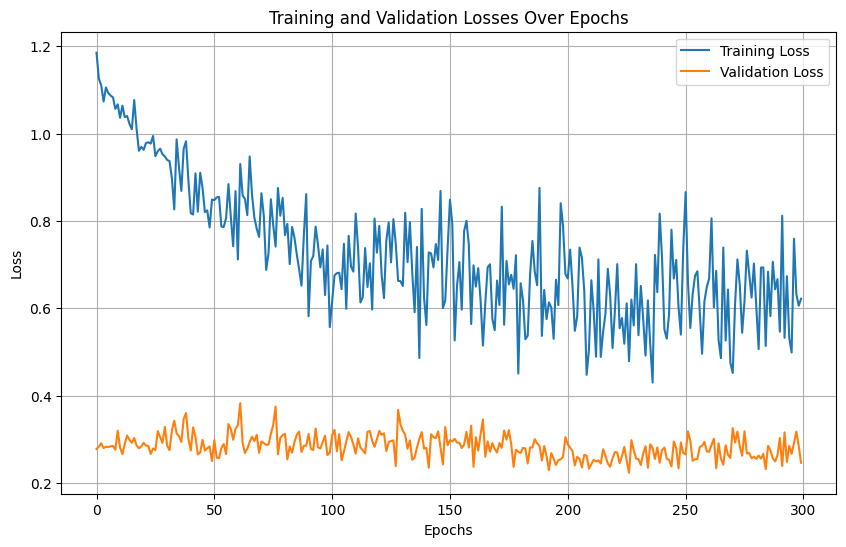

Model weights saved to model.pth
Model size: 42.71 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler

# Set up device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mean and std for normalization (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # تغییر ابعاد ورودی به 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),  # افزونه RandAugment برای افزایش تنوع داده‌ها
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # تغییر ابعاد ورودی به 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class BirdDataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.allowed_classes = allowed_classes

        self.samples = []
        for class_idx, class_name in enumerate(allowed_classes):
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, class_idx))

        random.seed(42)  # استفاده از دانه ثابت برای بازتولید نتایج
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2):
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    dataset = BirdDataset(image_dir=image_dir, allowed_classes=classes, transform=train_transform)

    # Creating data indices for training and validation splits
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

    return train_loader, val_loader

def mixup_data(x, y, alpha=1.0):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # استفاده از Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    scores = [[], []]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(train_loader))

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"  # Update this path to your dataset
    train_loader, val_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=2)

    model = Model(num_classes=4).to(device)
    num_epochs, patience = 300, 100  # You can adjust these values as needed

    trained_model, training_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.cpu().state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


# V10

# with imagenet weight

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # بارگذاری ResNet18 بدون وزن‌های پیش‌آموزش‌شده
        self.base_model = models.resnet18(weights=None)
        # جایگزینی لایه Fully Connected نهایی با یک لایه جدید با تعداد کلاس‌های مورد نظر
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]



Epoch 1/300, Training Loss: 1.1571, Validation Loss: 0.2725
F1 Score on Validation set: 0.2032, Accuracy on Validation set: 0.2667
Validation loss improved. Saving best model state.



Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]



Epoch 2/300, Training Loss: 1.1353, Validation Loss: 0.2788
F1 Score on Validation set: 0.2398, Accuracy on Validation set: 0.3000
No improvement in validation loss for 1 epochs.



Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 3/300, Training Loss: 1.1081, Validation Loss: 0.2815
F1 Score on Validation set: 0.1242, Accuracy on Validation set: 0.1667
No improvement in validation loss for 2 epochs.



Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 4/300, Training Loss: 1.0816, Validation Loss: 0.2843
F1 Score on Validation set: 0.2139, Accuracy on Validation set: 0.2667
No improvement in validation loss for 3 epochs.



Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Epoch 5/300, Training Loss: 1.0702, Validation Loss: 0.2852
F1 Score on Validation set: 0.1059, Accuracy on Validation set: 0.2000
No improvement in validation loss for 4 epochs.



Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 6/300, Training Loss: 1.1088, Validation Loss: 0.2752
F1 Score on Validation set: 0.1871, Accuracy on Validation set: 0.3000
No improvement in validation loss for 5 epochs.



Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 7/300, Training Loss: 1.0851, Validation Loss: 0.2827
F1 Score on Validation set: 0.2011, Accuracy on Validation set: 0.2667
No improvement in validation loss for 6 epochs.



Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 8/300, Training Loss: 1.0767, Validation Loss: 0.2784
F1 Score on Validation set: 0.3681, Accuracy on Validation set: 0.3667
No improvement in validation loss for 7 epochs.



Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 9/300, Training Loss: 1.0441, Validation Loss: 0.3001
F1 Score on Validation set: 0.1239, Accuracy on Validation set: 0.1667
No improvement in validation loss for 8 epochs.



Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 10/300, Training Loss: 1.0542, Validation Loss: 0.2862
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2000
No improvement in validation loss for 9 epochs.



Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 11/300, Training Loss: 1.0788, Validation Loss: 0.2967
F1 Score on Validation set: 0.2466, Accuracy on Validation set: 0.3000
No improvement in validation loss for 10 epochs.



Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 12/300, Training Loss: 1.0515, Validation Loss: 0.3031
F1 Score on Validation set: 0.1505, Accuracy on Validation set: 0.1667
No improvement in validation loss for 11 epochs.



Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 13/300, Training Loss: 1.0528, Validation Loss: 0.2772
F1 Score on Validation set: 0.1491, Accuracy on Validation set: 0.2333
No improvement in validation loss for 12 epochs.



Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 14/300, Training Loss: 1.0511, Validation Loss: 0.2826
F1 Score on Validation set: 0.2064, Accuracy on Validation set: 0.2667
No improvement in validation loss for 13 epochs.



Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 15/300, Training Loss: 1.0342, Validation Loss: 0.2816
F1 Score on Validation set: 0.2227, Accuracy on Validation set: 0.3333
No improvement in validation loss for 14 epochs.



Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 16/300, Training Loss: 1.0118, Validation Loss: 0.3218
F1 Score on Validation set: 0.1733, Accuracy on Validation set: 0.2667
No improvement in validation loss for 15 epochs.



Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



Epoch 17/300, Training Loss: 1.0026, Validation Loss: 0.2905
F1 Score on Validation set: 0.2090, Accuracy on Validation set: 0.3000
No improvement in validation loss for 16 epochs.



Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 18/300, Training Loss: 0.9897, Validation Loss: 0.3041
F1 Score on Validation set: 0.1930, Accuracy on Validation set: 0.2000
No improvement in validation loss for 17 epochs.



Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 19/300, Training Loss: 1.0229, Validation Loss: 0.2809
F1 Score on Validation set: 0.3811, Accuracy on Validation set: 0.4000
No improvement in validation loss for 18 epochs.



Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 20/300, Training Loss: 1.0567, Validation Loss: 0.2866
F1 Score on Validation set: 0.4582, Accuracy on Validation set: 0.4667
No improvement in validation loss for 19 epochs.



Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 21/300, Training Loss: 0.9559, Validation Loss: 0.3049
F1 Score on Validation set: 0.3432, Accuracy on Validation set: 0.3333
No improvement in validation loss for 20 epochs.



Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 22/300, Training Loss: 0.9753, Validation Loss: 0.3000
F1 Score on Validation set: 0.2839, Accuracy on Validation set: 0.3000
No improvement in validation loss for 21 epochs.



Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 23/300, Training Loss: 0.9653, Validation Loss: 0.2888
F1 Score on Validation set: 0.1990, Accuracy on Validation set: 0.2000
No improvement in validation loss for 22 epochs.



Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 24/300, Training Loss: 1.0044, Validation Loss: 0.2903
F1 Score on Validation set: 0.2933, Accuracy on Validation set: 0.3000
No improvement in validation loss for 23 epochs.



Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 25/300, Training Loss: 1.0328, Validation Loss: 0.2953
F1 Score on Validation set: 0.3276, Accuracy on Validation set: 0.4000
No improvement in validation loss for 24 epochs.



Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 26/300, Training Loss: 1.0193, Validation Loss: 0.3070
F1 Score on Validation set: 0.2750, Accuracy on Validation set: 0.3333
No improvement in validation loss for 25 epochs.



Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]



Epoch 27/300, Training Loss: 1.0046, Validation Loss: 0.3608
F1 Score on Validation set: 0.1886, Accuracy on Validation set: 0.3333
No improvement in validation loss for 26 epochs.



Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 28/300, Training Loss: 0.9372, Validation Loss: 0.4203
F1 Score on Validation set: 0.1333, Accuracy on Validation set: 0.2333
No improvement in validation loss for 27 epochs.



Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 29/300, Training Loss: 1.0104, Validation Loss: 0.3537
F1 Score on Validation set: 0.1306, Accuracy on Validation set: 0.2333
No improvement in validation loss for 28 epochs.



Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 30/300, Training Loss: 0.9686, Validation Loss: 0.2802
F1 Score on Validation set: 0.3218, Accuracy on Validation set: 0.3333
No improvement in validation loss for 29 epochs.



Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 31/300, Training Loss: 0.9549, Validation Loss: 0.2987
F1 Score on Validation set: 0.1700, Accuracy on Validation set: 0.2333
No improvement in validation loss for 30 epochs.



Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch 32/300, Training Loss: 0.9465, Validation Loss: 0.2869
F1 Score on Validation set: 0.2149, Accuracy on Validation set: 0.3333
No improvement in validation loss for 31 epochs.



Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch 33/300, Training Loss: 0.8625, Validation Loss: 0.2768
F1 Score on Validation set: 0.2629, Accuracy on Validation set: 0.3000
No improvement in validation loss for 32 epochs.



Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]



Epoch 34/300, Training Loss: 0.8944, Validation Loss: 0.2945
F1 Score on Validation set: 0.3355, Accuracy on Validation set: 0.3333
No improvement in validation loss for 33 epochs.



Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 35/300, Training Loss: 0.9623, Validation Loss: 0.3109
F1 Score on Validation set: 0.2496, Accuracy on Validation set: 0.3000
No improvement in validation loss for 34 epochs.



Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 36/300, Training Loss: 0.9495, Validation Loss: 0.3561
F1 Score on Validation set: 0.1750, Accuracy on Validation set: 0.2333
No improvement in validation loss for 35 epochs.



Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 37/300, Training Loss: 0.8520, Validation Loss: 0.3168
F1 Score on Validation set: 0.2506, Accuracy on Validation set: 0.3000
No improvement in validation loss for 36 epochs.



Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 38/300, Training Loss: 0.9190, Validation Loss: 0.2938
F1 Score on Validation set: 0.3480, Accuracy on Validation set: 0.4333
No improvement in validation loss for 37 epochs.



Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 39/300, Training Loss: 0.8776, Validation Loss: 0.3033
F1 Score on Validation set: 0.2212, Accuracy on Validation set: 0.2667
No improvement in validation loss for 38 epochs.



Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 40/300, Training Loss: 0.9089, Validation Loss: 0.2966
F1 Score on Validation set: 0.3047, Accuracy on Validation set: 0.3667
No improvement in validation loss for 39 epochs.



Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 41/300, Training Loss: 0.9381, Validation Loss: 0.3050
F1 Score on Validation set: 0.2767, Accuracy on Validation set: 0.3000
No improvement in validation loss for 40 epochs.



Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 42/300, Training Loss: 0.8931, Validation Loss: 0.2809
F1 Score on Validation set: 0.3714, Accuracy on Validation set: 0.4000
No improvement in validation loss for 41 epochs.



Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 43/300, Training Loss: 0.8471, Validation Loss: 0.2942
F1 Score on Validation set: 0.3125, Accuracy on Validation set: 0.3667
No improvement in validation loss for 42 epochs.



Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 44/300, Training Loss: 0.8286, Validation Loss: 0.2977
F1 Score on Validation set: 0.2897, Accuracy on Validation set: 0.3000
No improvement in validation loss for 43 epochs.



Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 45/300, Training Loss: 0.9009, Validation Loss: 0.2816
F1 Score on Validation set: 0.3299, Accuracy on Validation set: 0.3333
No improvement in validation loss for 44 epochs.



Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 46/300, Training Loss: 0.9148, Validation Loss: 0.3216
F1 Score on Validation set: 0.1746, Accuracy on Validation set: 0.2000
No improvement in validation loss for 45 epochs.



Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



Epoch 47/300, Training Loss: 0.9245, Validation Loss: 0.2713
F1 Score on Validation set: 0.4790, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 48/300, Training Loss: 0.8145, Validation Loss: 0.3202
F1 Score on Validation set: 0.2055, Accuracy on Validation set: 0.2333
No improvement in validation loss for 1 epochs.



Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 49/300, Training Loss: 0.8473, Validation Loss: 0.3075
F1 Score on Validation set: 0.3338, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 50/300, Training Loss: 0.8935, Validation Loss: 0.2726
F1 Score on Validation set: 0.4643, Accuracy on Validation set: 0.4667
No improvement in validation loss for 3 epochs.



Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 51/300, Training Loss: 0.8299, Validation Loss: 0.2806
F1 Score on Validation set: 0.3563, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 52/300, Training Loss: 0.8734, Validation Loss: 0.2665
F1 Score on Validation set: 0.4421, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.



Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 53/300, Training Loss: 0.7879, Validation Loss: 0.2890
F1 Score on Validation set: 0.3919, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 54/300, Training Loss: 0.7552, Validation Loss: 0.2939
F1 Score on Validation set: 0.3578, Accuracy on Validation set: 0.3667
No improvement in validation loss for 2 epochs.



Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 55/300, Training Loss: 0.8106, Validation Loss: 0.3002
F1 Score on Validation set: 0.2323, Accuracy on Validation set: 0.2333
No improvement in validation loss for 3 epochs.



Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 56/300, Training Loss: 0.8290, Validation Loss: 0.2711
F1 Score on Validation set: 0.4112, Accuracy on Validation set: 0.4000
No improvement in validation loss for 4 epochs.



Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]



Epoch 57/300, Training Loss: 0.8980, Validation Loss: 0.3083
F1 Score on Validation set: 0.3916, Accuracy on Validation set: 0.4000
No improvement in validation loss for 5 epochs.



Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 58/300, Training Loss: 0.8317, Validation Loss: 0.3135
F1 Score on Validation set: 0.1200, Accuracy on Validation set: 0.2000
No improvement in validation loss for 6 epochs.



Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 59/300, Training Loss: 0.9525, Validation Loss: 0.3151
F1 Score on Validation set: 0.3402, Accuracy on Validation set: 0.3667
No improvement in validation loss for 7 epochs.



Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 60/300, Training Loss: 0.8219, Validation Loss: 0.2821
F1 Score on Validation set: 0.4458, Accuracy on Validation set: 0.4667
No improvement in validation loss for 8 epochs.



Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 61/300, Training Loss: 0.9006, Validation Loss: 0.3335
F1 Score on Validation set: 0.2445, Accuracy on Validation set: 0.3000
No improvement in validation loss for 9 epochs.



Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 62/300, Training Loss: 0.8861, Validation Loss: 0.3517
F1 Score on Validation set: 0.1360, Accuracy on Validation set: 0.1667
No improvement in validation loss for 10 epochs.



Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



Epoch 63/300, Training Loss: 0.8976, Validation Loss: 0.3182
F1 Score on Validation set: 0.1957, Accuracy on Validation set: 0.2000
No improvement in validation loss for 11 epochs.



Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]



Epoch 64/300, Training Loss: 0.8294, Validation Loss: 0.3123
F1 Score on Validation set: 0.2341, Accuracy on Validation set: 0.3000
No improvement in validation loss for 12 epochs.



Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 65/300, Training Loss: 0.8034, Validation Loss: 0.3258
F1 Score on Validation set: 0.2403, Accuracy on Validation set: 0.2333
No improvement in validation loss for 13 epochs.



Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 66/300, Training Loss: 0.7553, Validation Loss: 0.3044
F1 Score on Validation set: 0.2826, Accuracy on Validation set: 0.3333
No improvement in validation loss for 14 epochs.



Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 67/300, Training Loss: 0.8351, Validation Loss: 0.3433
F1 Score on Validation set: 0.3429, Accuracy on Validation set: 0.3667
No improvement in validation loss for 15 epochs.



Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 68/300, Training Loss: 0.8288, Validation Loss: 0.2659
F1 Score on Validation set: 0.4723, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 69/300, Training Loss: 0.7189, Validation Loss: 0.3374
F1 Score on Validation set: 0.1718, Accuracy on Validation set: 0.2000
No improvement in validation loss for 1 epochs.



Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 70/300, Training Loss: 0.7468, Validation Loss: 0.3393
F1 Score on Validation set: 0.2653, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 71/300, Training Loss: 0.9553, Validation Loss: 0.3217
F1 Score on Validation set: 0.3842, Accuracy on Validation set: 0.4333
No improvement in validation loss for 3 epochs.



Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 72/300, Training Loss: 0.7225, Validation Loss: 0.3245
F1 Score on Validation set: 0.3658, Accuracy on Validation set: 0.4000
No improvement in validation loss for 4 epochs.



Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 73/300, Training Loss: 0.8368, Validation Loss: 0.2601
F1 Score on Validation set: 0.5179, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.



Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 74/300, Training Loss: 0.8015, Validation Loss: 0.3426
F1 Score on Validation set: 0.1860, Accuracy on Validation set: 0.2000
No improvement in validation loss for 1 epochs.



Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 75/300, Training Loss: 0.8667, Validation Loss: 0.3524
F1 Score on Validation set: 0.2564, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 76/300, Training Loss: 0.8073, Validation Loss: 0.3081
F1 Score on Validation set: 0.3147, Accuracy on Validation set: 0.3333
No improvement in validation loss for 3 epochs.



Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



Epoch 77/300, Training Loss: 0.8143, Validation Loss: 0.3785
F1 Score on Validation set: 0.2200, Accuracy on Validation set: 0.3000
No improvement in validation loss for 4 epochs.



Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]



Epoch 78/300, Training Loss: 0.8047, Validation Loss: 0.3413
F1 Score on Validation set: 0.2735, Accuracy on Validation set: 0.3333
No improvement in validation loss for 5 epochs.



Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 79/300, Training Loss: 0.7742, Validation Loss: 0.3195
F1 Score on Validation set: 0.2444, Accuracy on Validation set: 0.2667
No improvement in validation loss for 6 epochs.



Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 80/300, Training Loss: 0.7912, Validation Loss: 0.3421
F1 Score on Validation set: 0.3344, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.



Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 81/300, Training Loss: 0.7109, Validation Loss: 0.3146
F1 Score on Validation set: 0.3728, Accuracy on Validation set: 0.3667
No improvement in validation loss for 8 epochs.



Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 82/300, Training Loss: 0.8465, Validation Loss: 0.3250
F1 Score on Validation set: 0.2459, Accuracy on Validation set: 0.3000
No improvement in validation loss for 9 epochs.



Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 83/300, Training Loss: 0.6881, Validation Loss: 0.2954
F1 Score on Validation set: 0.3195, Accuracy on Validation set: 0.3333
No improvement in validation loss for 10 epochs.



Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 84/300, Training Loss: 0.8115, Validation Loss: 0.3252
F1 Score on Validation set: 0.2733, Accuracy on Validation set: 0.3000
No improvement in validation loss for 11 epochs.



Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 85/300, Training Loss: 0.7377, Validation Loss: 0.3288
F1 Score on Validation set: 0.1938, Accuracy on Validation set: 0.2000
No improvement in validation loss for 12 epochs.



Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 86/300, Training Loss: 0.8273, Validation Loss: 0.3107
F1 Score on Validation set: 0.3937, Accuracy on Validation set: 0.4000
No improvement in validation loss for 13 epochs.



Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 87/300, Training Loss: 0.7326, Validation Loss: 0.2945
F1 Score on Validation set: 0.3211, Accuracy on Validation set: 0.3333
No improvement in validation loss for 14 epochs.



Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 88/300, Training Loss: 0.8565, Validation Loss: 0.3083
F1 Score on Validation set: 0.3539, Accuracy on Validation set: 0.3667
No improvement in validation loss for 15 epochs.



Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 89/300, Training Loss: 0.7573, Validation Loss: 0.2900
F1 Score on Validation set: 0.2827, Accuracy on Validation set: 0.3000
No improvement in validation loss for 16 epochs.



Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 90/300, Training Loss: 0.6913, Validation Loss: 0.2959
F1 Score on Validation set: 0.2833, Accuracy on Validation set: 0.3000
No improvement in validation loss for 17 epochs.



Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 91/300, Training Loss: 0.7738, Validation Loss: 0.3058
F1 Score on Validation set: 0.4359, Accuracy on Validation set: 0.4333
No improvement in validation loss for 18 epochs.



Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]



Epoch 92/300, Training Loss: 0.6510, Validation Loss: 0.2892
F1 Score on Validation set: 0.3646, Accuracy on Validation set: 0.3667
No improvement in validation loss for 19 epochs.



Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



Epoch 93/300, Training Loss: 0.6975, Validation Loss: 0.3095
F1 Score on Validation set: 0.3629, Accuracy on Validation set: 0.4000
No improvement in validation loss for 20 epochs.



Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 94/300, Training Loss: 0.7099, Validation Loss: 0.2917
F1 Score on Validation set: 0.4111, Accuracy on Validation set: 0.4667
No improvement in validation loss for 21 epochs.



Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 95/300, Training Loss: 0.6169, Validation Loss: 0.3049
F1 Score on Validation set: 0.2415, Accuracy on Validation set: 0.2667
No improvement in validation loss for 22 epochs.



Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 96/300, Training Loss: 0.6446, Validation Loss: 0.2889
F1 Score on Validation set: 0.4489, Accuracy on Validation set: 0.4667
No improvement in validation loss for 23 epochs.



Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 97/300, Training Loss: 0.6431, Validation Loss: 0.2916
F1 Score on Validation set: 0.4065, Accuracy on Validation set: 0.4000
No improvement in validation loss for 24 epochs.



Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 98/300, Training Loss: 0.7055, Validation Loss: 0.2966
F1 Score on Validation set: 0.2395, Accuracy on Validation set: 0.2667
No improvement in validation loss for 25 epochs.



Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 99/300, Training Loss: 0.8403, Validation Loss: 0.3254
F1 Score on Validation set: 0.3162, Accuracy on Validation set: 0.3333
No improvement in validation loss for 26 epochs.



Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 100/300, Training Loss: 0.6671, Validation Loss: 0.3400
F1 Score on Validation set: 0.2700, Accuracy on Validation set: 0.2667
No improvement in validation loss for 27 epochs.



Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 101/300, Training Loss: 0.8076, Validation Loss: 0.3371
F1 Score on Validation set: 0.2507, Accuracy on Validation set: 0.2667
No improvement in validation loss for 28 epochs.



Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 102/300, Training Loss: 0.6938, Validation Loss: 0.2879
F1 Score on Validation set: 0.2891, Accuracy on Validation set: 0.3000
No improvement in validation loss for 29 epochs.



Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 103/300, Training Loss: 0.8605, Validation Loss: 0.3037
F1 Score on Validation set: 0.4208, Accuracy on Validation set: 0.4333
No improvement in validation loss for 30 epochs.



Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 104/300, Training Loss: 0.6658, Validation Loss: 0.3246
F1 Score on Validation set: 0.2760, Accuracy on Validation set: 0.3333
No improvement in validation loss for 31 epochs.



Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 105/300, Training Loss: 0.7512, Validation Loss: 0.3527
F1 Score on Validation set: 0.2547, Accuracy on Validation set: 0.2667
No improvement in validation loss for 32 epochs.



Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 106/300, Training Loss: 0.5840, Validation Loss: 0.3153
F1 Score on Validation set: 0.1758, Accuracy on Validation set: 0.2000
No improvement in validation loss for 33 epochs.



Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 107/300, Training Loss: 0.6814, Validation Loss: 0.2639
F1 Score on Validation set: 0.3115, Accuracy on Validation set: 0.3000
No improvement in validation loss for 34 epochs.



Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 108/300, Training Loss: 0.6480, Validation Loss: 0.3066
F1 Score on Validation set: 0.2153, Accuracy on Validation set: 0.2333
No improvement in validation loss for 35 epochs.



Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 109/300, Training Loss: 0.6153, Validation Loss: 0.2891
F1 Score on Validation set: 0.3594, Accuracy on Validation set: 0.3667
No improvement in validation loss for 36 epochs.



Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 110/300, Training Loss: 0.7865, Validation Loss: 0.2769
F1 Score on Validation set: 0.3907, Accuracy on Validation set: 0.4000
No improvement in validation loss for 37 epochs.



Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 111/300, Training Loss: 0.6477, Validation Loss: 0.3065
F1 Score on Validation set: 0.2741, Accuracy on Validation set: 0.2667
No improvement in validation loss for 38 epochs.



Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 112/300, Training Loss: 0.7370, Validation Loss: 0.2722
F1 Score on Validation set: 0.4067, Accuracy on Validation set: 0.4000
No improvement in validation loss for 39 epochs.



Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 113/300, Training Loss: 0.6453, Validation Loss: 0.3058
F1 Score on Validation set: 0.2519, Accuracy on Validation set: 0.2667
No improvement in validation loss for 40 epochs.



Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 114/300, Training Loss: 0.6281, Validation Loss: 0.2530
F1 Score on Validation set: 0.4841, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 115/300, Training Loss: 0.6897, Validation Loss: 0.2788
F1 Score on Validation set: 0.2152, Accuracy on Validation set: 0.2333
No improvement in validation loss for 1 epochs.



Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 116/300, Training Loss: 0.7144, Validation Loss: 0.3486
F1 Score on Validation set: 0.2764, Accuracy on Validation set: 0.3000
No improvement in validation loss for 2 epochs.



Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 117/300, Training Loss: 0.7102, Validation Loss: 0.2703
F1 Score on Validation set: 0.3352, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.



Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 118/300, Training Loss: 0.7148, Validation Loss: 0.3103
F1 Score on Validation set: 0.3696, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 119/300, Training Loss: 0.6357, Validation Loss: 0.2373
F1 Score on Validation set: 0.5292, Accuracy on Validation set: 0.5333
Validation loss improved. Saving best model state.



Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 120/300, Training Loss: 0.7638, Validation Loss: 0.2900
F1 Score on Validation set: 0.4300, Accuracy on Validation set: 0.4333
No improvement in validation loss for 1 epochs.



Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]



Epoch 121/300, Training Loss: 0.7842, Validation Loss: 0.3601
F1 Score on Validation set: 0.2036, Accuracy on Validation set: 0.2667
No improvement in validation loss for 2 epochs.



Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 122/300, Training Loss: 0.6973, Validation Loss: 0.3305
F1 Score on Validation set: 0.4337, Accuracy on Validation set: 0.4333
No improvement in validation loss for 3 epochs.



Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 123/300, Training Loss: 0.7598, Validation Loss: 0.2919
F1 Score on Validation set: 0.3692, Accuracy on Validation set: 0.4000
No improvement in validation loss for 4 epochs.



Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 124/300, Training Loss: 0.7955, Validation Loss: 0.3529
F1 Score on Validation set: 0.2152, Accuracy on Validation set: 0.2667
No improvement in validation loss for 5 epochs.



Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 125/300, Training Loss: 0.6040, Validation Loss: 0.3023
F1 Score on Validation set: 0.3111, Accuracy on Validation set: 0.3333
No improvement in validation loss for 6 epochs.



Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 126/300, Training Loss: 0.7707, Validation Loss: 0.2932
F1 Score on Validation set: 0.4465, Accuracy on Validation set: 0.4333
No improvement in validation loss for 7 epochs.



Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 127/300, Training Loss: 0.6635, Validation Loss: 0.2803
F1 Score on Validation set: 0.4769, Accuracy on Validation set: 0.4667
No improvement in validation loss for 8 epochs.



Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 128/300, Training Loss: 0.8256, Validation Loss: 0.2872
F1 Score on Validation set: 0.3441, Accuracy on Validation set: 0.4000
No improvement in validation loss for 9 epochs.



Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 129/300, Training Loss: 0.7902, Validation Loss: 0.2798
F1 Score on Validation set: 0.4345, Accuracy on Validation set: 0.4667
No improvement in validation loss for 10 epochs.



Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 130/300, Training Loss: 0.7965, Validation Loss: 0.3416
F1 Score on Validation set: 0.2018, Accuracy on Validation set: 0.2667
No improvement in validation loss for 11 epochs.



Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 131/300, Training Loss: 0.6666, Validation Loss: 0.3222
F1 Score on Validation set: 0.3261, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 132/300, Training Loss: 0.8267, Validation Loss: 0.3031
F1 Score on Validation set: 0.3598, Accuracy on Validation set: 0.3667
No improvement in validation loss for 13 epochs.



Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 133/300, Training Loss: 0.6968, Validation Loss: 0.3339
F1 Score on Validation set: 0.2841, Accuracy on Validation set: 0.3000
No improvement in validation loss for 14 epochs.



Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 134/300, Training Loss: 0.7492, Validation Loss: 0.2744
F1 Score on Validation set: 0.4092, Accuracy on Validation set: 0.4667
No improvement in validation loss for 15 epochs.



Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 135/300, Training Loss: 0.6747, Validation Loss: 0.2849
F1 Score on Validation set: 0.2833, Accuracy on Validation set: 0.3333
No improvement in validation loss for 16 epochs.



Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 136/300, Training Loss: 0.7150, Validation Loss: 0.3254
F1 Score on Validation set: 0.3600, Accuracy on Validation set: 0.3667
No improvement in validation loss for 17 epochs.



Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



Epoch 137/300, Training Loss: 0.7229, Validation Loss: 0.3233
F1 Score on Validation set: 0.2808, Accuracy on Validation set: 0.3333
No improvement in validation loss for 18 epochs.



Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 138/300, Training Loss: 0.7407, Validation Loss: 0.3452
F1 Score on Validation set: 0.3503, Accuracy on Validation set: 0.4000
No improvement in validation loss for 19 epochs.



Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 139/300, Training Loss: 0.7377, Validation Loss: 0.3137
F1 Score on Validation set: 0.2614, Accuracy on Validation set: 0.3333
No improvement in validation loss for 20 epochs.



Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 140/300, Training Loss: 0.7163, Validation Loss: 0.3165
F1 Score on Validation set: 0.3215, Accuracy on Validation set: 0.3667
No improvement in validation loss for 21 epochs.



Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 141/300, Training Loss: 0.8361, Validation Loss: 0.3011
F1 Score on Validation set: 0.4339, Accuracy on Validation set: 0.4333
No improvement in validation loss for 22 epochs.



Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 142/300, Training Loss: 0.6118, Validation Loss: 0.2961
F1 Score on Validation set: 0.2378, Accuracy on Validation set: 0.2333
No improvement in validation loss for 23 epochs.



Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 143/300, Training Loss: 0.7452, Validation Loss: 0.3198
F1 Score on Validation set: 0.2937, Accuracy on Validation set: 0.3000
No improvement in validation loss for 24 epochs.



Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 144/300, Training Loss: 0.5924, Validation Loss: 0.2986
F1 Score on Validation set: 0.3682, Accuracy on Validation set: 0.4000
No improvement in validation loss for 25 epochs.



Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 145/300, Training Loss: 0.8175, Validation Loss: 0.2747
F1 Score on Validation set: 0.3840, Accuracy on Validation set: 0.3667
No improvement in validation loss for 26 epochs.



Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 146/300, Training Loss: 0.7719, Validation Loss: 0.2672
F1 Score on Validation set: 0.4539, Accuracy on Validation set: 0.4667
No improvement in validation loss for 27 epochs.



Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 147/300, Training Loss: 0.6848, Validation Loss: 0.3259
F1 Score on Validation set: 0.2940, Accuracy on Validation set: 0.3000
No improvement in validation loss for 28 epochs.



Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 148/300, Training Loss: 0.7354, Validation Loss: 0.3171
F1 Score on Validation set: 0.2652, Accuracy on Validation set: 0.3000
No improvement in validation loss for 29 epochs.



Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 149/300, Training Loss: 0.6462, Validation Loss: 0.3081
F1 Score on Validation set: 0.3391, Accuracy on Validation set: 0.3667
No improvement in validation loss for 30 epochs.



Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 150/300, Training Loss: 0.6677, Validation Loss: 0.2702
F1 Score on Validation set: 0.4210, Accuracy on Validation set: 0.4333
No improvement in validation loss for 31 epochs.



Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 151/300, Training Loss: 0.5740, Validation Loss: 0.3104
F1 Score on Validation set: 0.3101, Accuracy on Validation set: 0.3333
No improvement in validation loss for 32 epochs.



Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



Epoch 152/300, Training Loss: 0.5249, Validation Loss: 0.2829
F1 Score on Validation set: 0.3450, Accuracy on Validation set: 0.3333
No improvement in validation loss for 33 epochs.



Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 153/300, Training Loss: 0.7248, Validation Loss: 0.3166
F1 Score on Validation set: 0.2271, Accuracy on Validation set: 0.2333
No improvement in validation loss for 34 epochs.



Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 154/300, Training Loss: 0.6510, Validation Loss: 0.2936
F1 Score on Validation set: 0.2946, Accuracy on Validation set: 0.3000
No improvement in validation loss for 35 epochs.



Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 155/300, Training Loss: 0.6104, Validation Loss: 0.3519
F1 Score on Validation set: 0.2264, Accuracy on Validation set: 0.2667
No improvement in validation loss for 36 epochs.



Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 156/300, Training Loss: 0.5635, Validation Loss: 0.3181
F1 Score on Validation set: 0.3498, Accuracy on Validation set: 0.4000
No improvement in validation loss for 37 epochs.



Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 157/300, Training Loss: 0.6897, Validation Loss: 0.2523
F1 Score on Validation set: 0.3200, Accuracy on Validation set: 0.3333
No improvement in validation loss for 38 epochs.



Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 158/300, Training Loss: 0.6789, Validation Loss: 0.2987
F1 Score on Validation set: 0.4010, Accuracy on Validation set: 0.4000
No improvement in validation loss for 39 epochs.



Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 159/300, Training Loss: 0.6817, Validation Loss: 0.2912
F1 Score on Validation set: 0.3889, Accuracy on Validation set: 0.4000
No improvement in validation loss for 40 epochs.



Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 160/300, Training Loss: 0.6864, Validation Loss: 0.3065
F1 Score on Validation set: 0.2759, Accuracy on Validation set: 0.3000
No improvement in validation loss for 41 epochs.



Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 161/300, Training Loss: 0.7138, Validation Loss: 0.2754
F1 Score on Validation set: 0.4337, Accuracy on Validation set: 0.4333
No improvement in validation loss for 42 epochs.



Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 162/300, Training Loss: 0.6244, Validation Loss: 0.2827
F1 Score on Validation set: 0.4162, Accuracy on Validation set: 0.4000
No improvement in validation loss for 43 epochs.



Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 163/300, Training Loss: 0.6286, Validation Loss: 0.2549
F1 Score on Validation set: 0.5010, Accuracy on Validation set: 0.5000
No improvement in validation loss for 44 epochs.



Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 164/300, Training Loss: 0.6859, Validation Loss: 0.3174
F1 Score on Validation set: 0.3381, Accuracy on Validation set: 0.3667
No improvement in validation loss for 45 epochs.



Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 165/300, Training Loss: 0.5637, Validation Loss: 0.2860
F1 Score on Validation set: 0.3558, Accuracy on Validation set: 0.4000
No improvement in validation loss for 46 epochs.



Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]



Epoch 166/300, Training Loss: 0.7023, Validation Loss: 0.2772
F1 Score on Validation set: 0.4078, Accuracy on Validation set: 0.4333
No improvement in validation loss for 47 epochs.



Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 167/300, Training Loss: 0.6127, Validation Loss: 0.2558
F1 Score on Validation set: 0.4468, Accuracy on Validation set: 0.4667
No improvement in validation loss for 48 epochs.



Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



Epoch 168/300, Training Loss: 0.6733, Validation Loss: 0.2307
F1 Score on Validation set: 0.4894, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 169/300, Training Loss: 0.7142, Validation Loss: 0.2694
F1 Score on Validation set: 0.4839, Accuracy on Validation set: 0.4667
No improvement in validation loss for 1 epochs.



Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 170/300, Training Loss: 0.7586, Validation Loss: 0.2326
F1 Score on Validation set: 0.5262, Accuracy on Validation set: 0.5333
No improvement in validation loss for 2 epochs.



Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 171/300, Training Loss: 0.7017, Validation Loss: 0.2986
F1 Score on Validation set: 0.3491, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.



Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 172/300, Training Loss: 0.4915, Validation Loss: 0.3098
F1 Score on Validation set: 0.1238, Accuracy on Validation set: 0.1333
No improvement in validation loss for 4 epochs.



Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 173/300, Training Loss: 0.7370, Validation Loss: 0.2719
F1 Score on Validation set: 0.4433, Accuracy on Validation set: 0.4333
No improvement in validation loss for 5 epochs.



Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 174/300, Training Loss: 0.5782, Validation Loss: 0.2922
F1 Score on Validation set: 0.3092, Accuracy on Validation set: 0.3333
No improvement in validation loss for 6 epochs.



Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 175/300, Training Loss: 0.7242, Validation Loss: 0.2908
F1 Score on Validation set: 0.4117, Accuracy on Validation set: 0.4667
No improvement in validation loss for 7 epochs.



Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 176/300, Training Loss: 0.7560, Validation Loss: 0.3190
F1 Score on Validation set: 0.3154, Accuracy on Validation set: 0.3333
No improvement in validation loss for 8 epochs.



Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 177/300, Training Loss: 0.5905, Validation Loss: 0.3170
F1 Score on Validation set: 0.2009, Accuracy on Validation set: 0.2333
No improvement in validation loss for 9 epochs.



Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 178/300, Training Loss: 0.5018, Validation Loss: 0.2881
F1 Score on Validation set: 0.4434, Accuracy on Validation set: 0.4667
No improvement in validation loss for 10 epochs.



Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 179/300, Training Loss: 0.7091, Validation Loss: 0.2906
F1 Score on Validation set: 0.3361, Accuracy on Validation set: 0.3333
No improvement in validation loss for 11 epochs.



Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 180/300, Training Loss: 0.5227, Validation Loss: 0.2945
F1 Score on Validation set: 0.3578, Accuracy on Validation set: 0.3667
No improvement in validation loss for 12 epochs.



Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



Epoch 181/300, Training Loss: 0.7769, Validation Loss: 0.2917
F1 Score on Validation set: 0.3194, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



Epoch 182/300, Training Loss: 0.4431, Validation Loss: 0.2598
F1 Score on Validation set: 0.4014, Accuracy on Validation set: 0.4333
No improvement in validation loss for 14 epochs.



Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 183/300, Training Loss: 0.6366, Validation Loss: 0.2376
F1 Score on Validation set: 0.6754, Accuracy on Validation set: 0.6667
No improvement in validation loss for 15 epochs.



Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]



Epoch 184/300, Training Loss: 0.7126, Validation Loss: 0.3068
F1 Score on Validation set: 0.5062, Accuracy on Validation set: 0.5000
No improvement in validation loss for 16 epochs.



Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 185/300, Training Loss: 0.5729, Validation Loss: 0.2523
F1 Score on Validation set: 0.3933, Accuracy on Validation set: 0.4000
No improvement in validation loss for 17 epochs.



Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 186/300, Training Loss: 0.5496, Validation Loss: 0.2618
F1 Score on Validation set: 0.3230, Accuracy on Validation set: 0.3333
No improvement in validation loss for 18 epochs.



Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 187/300, Training Loss: 0.7583, Validation Loss: 0.2948
F1 Score on Validation set: 0.4340, Accuracy on Validation set: 0.4333
No improvement in validation loss for 19 epochs.



Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 188/300, Training Loss: 0.7271, Validation Loss: 0.2751
F1 Score on Validation set: 0.3678, Accuracy on Validation set: 0.3667
No improvement in validation loss for 20 epochs.



Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 189/300, Training Loss: 0.5245, Validation Loss: 0.2592
F1 Score on Validation set: 0.4419, Accuracy on Validation set: 0.4667
No improvement in validation loss for 21 epochs.



Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 190/300, Training Loss: 0.6231, Validation Loss: 0.2969
F1 Score on Validation set: 0.3426, Accuracy on Validation set: 0.4000
No improvement in validation loss for 22 epochs.



Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 191/300, Training Loss: 0.6420, Validation Loss: 0.2527
F1 Score on Validation set: 0.4241, Accuracy on Validation set: 0.5000
No improvement in validation loss for 23 epochs.



Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 192/300, Training Loss: 0.6008, Validation Loss: 0.2621
F1 Score on Validation set: 0.3282, Accuracy on Validation set: 0.3667
No improvement in validation loss for 24 epochs.



Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 193/300, Training Loss: 0.5737, Validation Loss: 0.2599
F1 Score on Validation set: 0.4890, Accuracy on Validation set: 0.5000
No improvement in validation loss for 25 epochs.



Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 194/300, Training Loss: 0.7595, Validation Loss: 0.2901
F1 Score on Validation set: 0.4775, Accuracy on Validation set: 0.5333
No improvement in validation loss for 26 epochs.



Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 195/300, Training Loss: 0.7147, Validation Loss: 0.3077
F1 Score on Validation set: 0.3307, Accuracy on Validation set: 0.3667
No improvement in validation loss for 27 epochs.



Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



Epoch 196/300, Training Loss: 0.5785, Validation Loss: 0.2873
F1 Score on Validation set: 0.4876, Accuracy on Validation set: 0.5000
No improvement in validation loss for 28 epochs.



Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



Epoch 197/300, Training Loss: 0.8720, Validation Loss: 0.2768
F1 Score on Validation set: 0.3303, Accuracy on Validation set: 0.3333
No improvement in validation loss for 29 epochs.



Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



Epoch 198/300, Training Loss: 0.5432, Validation Loss: 0.2827
F1 Score on Validation set: 0.4056, Accuracy on Validation set: 0.4333
No improvement in validation loss for 30 epochs.



Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 199/300, Training Loss: 0.7380, Validation Loss: 0.2544
F1 Score on Validation set: 0.3190, Accuracy on Validation set: 0.3333
No improvement in validation loss for 31 epochs.



Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 200/300, Training Loss: 0.5230, Validation Loss: 0.2833
F1 Score on Validation set: 0.3500, Accuracy on Validation set: 0.4000
No improvement in validation loss for 32 epochs.



Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 201/300, Training Loss: 0.5523, Validation Loss: 0.2659
F1 Score on Validation set: 0.2703, Accuracy on Validation set: 0.3000
No improvement in validation loss for 33 epochs.



Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 202/300, Training Loss: 0.7633, Validation Loss: 0.2522
F1 Score on Validation set: 0.4538, Accuracy on Validation set: 0.4667
No improvement in validation loss for 34 epochs.



Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 203/300, Training Loss: 0.6348, Validation Loss: 0.2612
F1 Score on Validation set: 0.3040, Accuracy on Validation set: 0.3333
No improvement in validation loss for 35 epochs.



Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 204/300, Training Loss: 0.6128, Validation Loss: 0.2968
F1 Score on Validation set: 0.3933, Accuracy on Validation set: 0.4333
No improvement in validation loss for 36 epochs.



Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 205/300, Training Loss: 0.5650, Validation Loss: 0.2554
F1 Score on Validation set: 0.3740, Accuracy on Validation set: 0.4000
No improvement in validation loss for 37 epochs.



Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 206/300, Training Loss: 0.7285, Validation Loss: 0.2499
F1 Score on Validation set: 0.4217, Accuracy on Validation set: 0.4333
No improvement in validation loss for 38 epochs.



Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 207/300, Training Loss: 0.5718, Validation Loss: 0.2930
F1 Score on Validation set: 0.3354, Accuracy on Validation set: 0.3667
No improvement in validation loss for 39 epochs.



Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 208/300, Training Loss: 0.4835, Validation Loss: 0.2422
F1 Score on Validation set: 0.5258, Accuracy on Validation set: 0.5333
No improvement in validation loss for 40 epochs.



Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 209/300, Training Loss: 0.6205, Validation Loss: 0.2800
F1 Score on Validation set: 0.3706, Accuracy on Validation set: 0.3667
No improvement in validation loss for 41 epochs.



Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 210/300, Training Loss: 0.8261, Validation Loss: 0.2799
F1 Score on Validation set: 0.3625, Accuracy on Validation set: 0.4000
No improvement in validation loss for 42 epochs.



Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 211/300, Training Loss: 0.5917, Validation Loss: 0.2598
F1 Score on Validation set: 0.5111, Accuracy on Validation set: 0.5333
No improvement in validation loss for 43 epochs.



Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 212/300, Training Loss: 0.5515, Validation Loss: 0.2485
F1 Score on Validation set: 0.5087, Accuracy on Validation set: 0.5667
No improvement in validation loss for 44 epochs.



Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 213/300, Training Loss: 0.5814, Validation Loss: 0.2567
F1 Score on Validation set: 0.4689, Accuracy on Validation set: 0.4667
No improvement in validation loss for 45 epochs.



Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 214/300, Training Loss: 0.7556, Validation Loss: 0.2672
F1 Score on Validation set: 0.3733, Accuracy on Validation set: 0.4000
No improvement in validation loss for 46 epochs.



Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 215/300, Training Loss: 0.7066, Validation Loss: 0.2608
F1 Score on Validation set: 0.5442, Accuracy on Validation set: 0.5333
No improvement in validation loss for 47 epochs.



Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 216/300, Training Loss: 0.6509, Validation Loss: 0.2591
F1 Score on Validation set: 0.4457, Accuracy on Validation set: 0.4667
No improvement in validation loss for 48 epochs.



Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 217/300, Training Loss: 0.6913, Validation Loss: 0.2786
F1 Score on Validation set: 0.4394, Accuracy on Validation set: 0.4333
No improvement in validation loss for 49 epochs.



Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 218/300, Training Loss: 0.6379, Validation Loss: 0.2710
F1 Score on Validation set: 0.3613, Accuracy on Validation set: 0.4000
No improvement in validation loss for 50 epochs.



Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 219/300, Training Loss: 0.6509, Validation Loss: 0.2739
F1 Score on Validation set: 0.4930, Accuracy on Validation set: 0.5000
No improvement in validation loss for 51 epochs.



Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 220/300, Training Loss: 0.6425, Validation Loss: 0.2749
F1 Score on Validation set: 0.3471, Accuracy on Validation set: 0.3667
No improvement in validation loss for 52 epochs.



Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 221/300, Training Loss: 0.5989, Validation Loss: 0.2907
F1 Score on Validation set: 0.3337, Accuracy on Validation set: 0.3333
No improvement in validation loss for 53 epochs.



Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 222/300, Training Loss: 0.4935, Validation Loss: 0.2699
F1 Score on Validation set: 0.4440, Accuracy on Validation set: 0.4667
No improvement in validation loss for 54 epochs.



Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 223/300, Training Loss: 0.6272, Validation Loss: 0.2650
F1 Score on Validation set: 0.4416, Accuracy on Validation set: 0.4333
No improvement in validation loss for 55 epochs.



Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 224/300, Training Loss: 0.4670, Validation Loss: 0.2426
F1 Score on Validation set: 0.5183, Accuracy on Validation set: 0.5333
No improvement in validation loss for 56 epochs.



Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 225/300, Training Loss: 0.6297, Validation Loss: 0.2573
F1 Score on Validation set: 0.4706, Accuracy on Validation set: 0.4667
No improvement in validation loss for 57 epochs.



Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 226/300, Training Loss: 0.6355, Validation Loss: 0.2790
F1 Score on Validation set: 0.3652, Accuracy on Validation set: 0.3667
No improvement in validation loss for 58 epochs.



Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 227/300, Training Loss: 0.5085, Validation Loss: 0.2493
F1 Score on Validation set: 0.5326, Accuracy on Validation set: 0.5333
No improvement in validation loss for 59 epochs.



Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 228/300, Training Loss: 0.6737, Validation Loss: 0.2601
F1 Score on Validation set: 0.4184, Accuracy on Validation set: 0.4333
No improvement in validation loss for 60 epochs.



Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 229/300, Training Loss: 0.4629, Validation Loss: 0.2749
F1 Score on Validation set: 0.2718, Accuracy on Validation set: 0.3000
No improvement in validation loss for 61 epochs.



Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 230/300, Training Loss: 0.5490, Validation Loss: 0.2560
F1 Score on Validation set: 0.4566, Accuracy on Validation set: 0.5000
No improvement in validation loss for 62 epochs.



Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 231/300, Training Loss: 0.5073, Validation Loss: 0.2503
F1 Score on Validation set: 0.4928, Accuracy on Validation set: 0.5000
No improvement in validation loss for 63 epochs.



Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 232/300, Training Loss: 0.6212, Validation Loss: 0.2435
F1 Score on Validation set: 0.5078, Accuracy on Validation set: 0.5000
No improvement in validation loss for 64 epochs.



Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 233/300, Training Loss: 0.6090, Validation Loss: 0.2818
F1 Score on Validation set: 0.4399, Accuracy on Validation set: 0.4667
No improvement in validation loss for 65 epochs.



Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 234/300, Training Loss: 0.4939, Validation Loss: 0.2346
F1 Score on Validation set: 0.5622, Accuracy on Validation set: 0.5667
No improvement in validation loss for 66 epochs.



Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 235/300, Training Loss: 0.4955, Validation Loss: 0.2518
F1 Score on Validation set: 0.4000, Accuracy on Validation set: 0.4000
No improvement in validation loss for 67 epochs.



Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 236/300, Training Loss: 0.6047, Validation Loss: 0.2626
F1 Score on Validation set: 0.4202, Accuracy on Validation set: 0.4333
No improvement in validation loss for 68 epochs.



Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 237/300, Training Loss: 0.5224, Validation Loss: 0.2690
F1 Score on Validation set: 0.3431, Accuracy on Validation set: 0.3667
No improvement in validation loss for 69 epochs.



Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 238/300, Training Loss: 0.5315, Validation Loss: 0.2689
F1 Score on Validation set: 0.2868, Accuracy on Validation set: 0.3333
No improvement in validation loss for 70 epochs.



Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 239/300, Training Loss: 0.5994, Validation Loss: 0.2488
F1 Score on Validation set: 0.5367, Accuracy on Validation set: 0.5333
No improvement in validation loss for 71 epochs.



Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]



Epoch 240/300, Training Loss: 0.6308, Validation Loss: 0.2490
F1 Score on Validation set: 0.4901, Accuracy on Validation set: 0.5000
No improvement in validation loss for 72 epochs.



Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



Epoch 241/300, Training Loss: 0.5995, Validation Loss: 0.2765
F1 Score on Validation set: 0.3827, Accuracy on Validation set: 0.4000
No improvement in validation loss for 73 epochs.



Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



Epoch 242/300, Training Loss: 0.7230, Validation Loss: 0.2437
F1 Score on Validation set: 0.5556, Accuracy on Validation set: 0.5667
No improvement in validation loss for 74 epochs.



Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]



Epoch 243/300, Training Loss: 0.5097, Validation Loss: 0.2882
F1 Score on Validation set: 0.5537, Accuracy on Validation set: 0.5667
No improvement in validation loss for 75 epochs.



Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 244/300, Training Loss: 0.5157, Validation Loss: 0.2679
F1 Score on Validation set: 0.3059, Accuracy on Validation set: 0.3333
No improvement in validation loss for 76 epochs.



Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 245/300, Training Loss: 0.5074, Validation Loss: 0.2581
F1 Score on Validation set: 0.4348, Accuracy on Validation set: 0.4333
No improvement in validation loss for 77 epochs.



Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 246/300, Training Loss: 0.6471, Validation Loss: 0.2459
F1 Score on Validation set: 0.4170, Accuracy on Validation set: 0.4333
No improvement in validation loss for 78 epochs.



Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 247/300, Training Loss: 0.5642, Validation Loss: 0.2576
F1 Score on Validation set: 0.4163, Accuracy on Validation set: 0.4333
No improvement in validation loss for 79 epochs.



Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 248/300, Training Loss: 0.6142, Validation Loss: 0.2505
F1 Score on Validation set: 0.3920, Accuracy on Validation set: 0.4000
No improvement in validation loss for 80 epochs.



Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 249/300, Training Loss: 0.5629, Validation Loss: 0.3164
F1 Score on Validation set: 0.4174, Accuracy on Validation set: 0.4667
No improvement in validation loss for 81 epochs.



Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 250/300, Training Loss: 0.7229, Validation Loss: 0.2871
F1 Score on Validation set: 0.3403, Accuracy on Validation set: 0.4000
No improvement in validation loss for 82 epochs.



Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 251/300, Training Loss: 0.4907, Validation Loss: 0.2750
F1 Score on Validation set: 0.3741, Accuracy on Validation set: 0.4000
No improvement in validation loss for 83 epochs.



Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 252/300, Training Loss: 0.8242, Validation Loss: 0.2855
F1 Score on Validation set: 0.4027, Accuracy on Validation set: 0.4000
No improvement in validation loss for 84 epochs.



Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 253/300, Training Loss: 0.6993, Validation Loss: 0.2698
F1 Score on Validation set: 0.4551, Accuracy on Validation set: 0.5000
No improvement in validation loss for 85 epochs.



Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 254/300, Training Loss: 0.6683, Validation Loss: 0.2978
F1 Score on Validation set: 0.3333, Accuracy on Validation set: 0.4333
No improvement in validation loss for 86 epochs.



Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 255/300, Training Loss: 0.7452, Validation Loss: 0.2881
F1 Score on Validation set: 0.4648, Accuracy on Validation set: 0.5000
No improvement in validation loss for 87 epochs.



Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 256/300, Training Loss: 0.5109, Validation Loss: 0.3804
F1 Score on Validation set: 0.1342, Accuracy on Validation set: 0.1667
No improvement in validation loss for 88 epochs.



Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 257/300, Training Loss: 0.5843, Validation Loss: 0.3326
F1 Score on Validation set: 0.2349, Accuracy on Validation set: 0.3000
No improvement in validation loss for 89 epochs.



Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]



Epoch 258/300, Training Loss: 0.7043, Validation Loss: 0.3114
F1 Score on Validation set: 0.2841, Accuracy on Validation set: 0.3000
No improvement in validation loss for 90 epochs.



Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 259/300, Training Loss: 0.6151, Validation Loss: 0.2949
F1 Score on Validation set: 0.3526, Accuracy on Validation set: 0.3667
No improvement in validation loss for 91 epochs.



Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 260/300, Training Loss: 0.5554, Validation Loss: 0.2724
F1 Score on Validation set: 0.4748, Accuracy on Validation set: 0.5000
No improvement in validation loss for 92 epochs.



Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 261/300, Training Loss: 0.6306, Validation Loss: 0.2728
F1 Score on Validation set: 0.3079, Accuracy on Validation set: 0.3333
No improvement in validation loss for 93 epochs.



Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 262/300, Training Loss: 0.7498, Validation Loss: 0.2685
F1 Score on Validation set: 0.3902, Accuracy on Validation set: 0.4333
No improvement in validation loss for 94 epochs.



Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]



Epoch 263/300, Training Loss: 0.6611, Validation Loss: 0.2586
F1 Score on Validation set: 0.4323, Accuracy on Validation set: 0.4333
No improvement in validation loss for 95 epochs.



Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 264/300, Training Loss: 0.6062, Validation Loss: 0.2792
F1 Score on Validation set: 0.3511, Accuracy on Validation set: 0.4000
No improvement in validation loss for 96 epochs.



Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 265/300, Training Loss: 0.6248, Validation Loss: 0.2763
F1 Score on Validation set: 0.3545, Accuracy on Validation set: 0.4333
No improvement in validation loss for 97 epochs.



Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 266/300, Training Loss: 0.8018, Validation Loss: 0.2477
F1 Score on Validation set: 0.4821, Accuracy on Validation set: 0.5000
No improvement in validation loss for 98 epochs.



Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 267/300, Training Loss: 0.6688, Validation Loss: 0.2728
F1 Score on Validation set: 0.3430, Accuracy on Validation set: 0.3667
No improvement in validation loss for 99 epochs.



Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 268/300, Training Loss: 0.5450, Validation Loss: 0.3013
F1 Score on Validation set: 0.4266, Accuracy on Validation set: 0.4667
No improvement in validation loss for 100 epochs.

Early stopping triggered after 268 epochs.

Best model loaded based on validation loss.



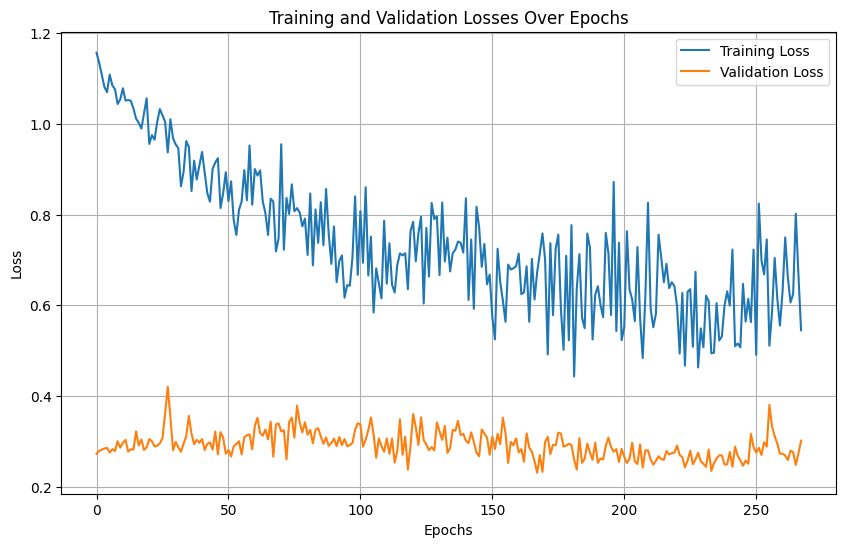

Model weights saved to model.pth
Model size: 42.71 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# میانگین و انحراف معیار برای نرمال‌سازی (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# افزایش تنوع داده‌ها و نرمال‌سازی
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # تغییر ابعاد ورودی به 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),  # افزونه RandAugment برای افزایش تنوع داده‌ها
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # تغییر ابعاد ورودی به 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class BirdDataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.allowed_classes = allowed_classes

        self.samples = []
        for class_idx, class_name in enumerate(allowed_classes):
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, class_idx))

        random.seed(42)  # استفاده از دانه ثابت برای بازتولید نتایج
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2):
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    dataset = BirdDataset(image_dir=image_dir, allowed_classes=classes, transform=train_transform)

    # ایجاد شاخص‌های داده‌ها برای تقسیم‌بندی آموزش و اعتبارسنجی
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

    return train_loader, val_loader

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # استفاده از Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    scores = [[], []]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # اعمال MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(train_loader))

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # اعتبارسنجی
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # بارگذاری بهترین مدل
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"  # مسیر به مجموعه داده خود را به‌روز کنید
    train_loader, val_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=2)

    model = Model(num_classes=4).to(device)

    # بارگذاری وزن‌های پیش‌آموزش‌شده ResNet18 به صورت محلی
    pretrained_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    pretrained_dict = pretrained_model.state_dict()
    model_dict = model.state_dict()

    # فیلتر کردن لایه‌های غیر از لایه‌ی Fully Connected نهایی
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and not k.startswith('base_model.fc.')}

    # به‌روزرسانی state_dict مدل با وزن‌های پیش‌آموزش‌شده
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    num_epochs, patience = 300, 100  # می‌توانید این مقادیر را تنظیم کنید

    trained_model, training_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


# V0.11

In [ ]:
# model_efficientnet.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # Load EfficientNetB0 without pre-trained weights
        self.base_model = models.efficientnet_b0(weights=None)
        # Replace the classifier with a new one for 4 classes
        num_ftrs = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 65.4MB/s]
Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 1/300, Training Loss: 1.1679, Validation Loss: 0.2783
F1 Score on Validation set: 0.1251, Accuracy on Validation set: 0.2333
Validation loss improved. Saving best model state.



Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 2/300, Training Loss: 1.1246, Validation Loss: 0.2791
F1 Score on Validation set: 0.1513, Accuracy on Validation set: 0.2000
No improvement in validation loss for 1 epochs.



Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 3/300, Training Loss: 1.1135, Validation Loss: 0.2911
F1 Score on Validation set: 0.1286, Accuracy on Validation set: 0.2333
No improvement in validation loss for 2 epochs.



Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 4/300, Training Loss: 1.0892, Validation Loss: 0.2911
F1 Score on Validation set: 0.0813, Accuracy on Validation set: 0.1333
No improvement in validation loss for 3 epochs.



Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 5/300, Training Loss: 1.0710, Validation Loss: 0.2901
F1 Score on Validation set: 0.0630, Accuracy on Validation set: 0.1000
No improvement in validation loss for 4 epochs.



Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 6/300, Training Loss: 1.0869, Validation Loss: 0.2808
F1 Score on Validation set: 0.3133, Accuracy on Validation set: 0.3333
No improvement in validation loss for 5 epochs.



Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 7/300, Training Loss: 1.0651, Validation Loss: 0.2752
F1 Score on Validation set: 0.2692, Accuracy on Validation set: 0.3333
Validation loss improved. Saving best model state.



Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 8/300, Training Loss: 1.0926, Validation Loss: 0.2863
F1 Score on Validation set: 0.2096, Accuracy on Validation set: 0.2333
No improvement in validation loss for 1 epochs.



Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 9/300, Training Loss: 1.0588, Validation Loss: 0.3081
F1 Score on Validation set: 0.1125, Accuracy on Validation set: 0.2000
No improvement in validation loss for 2 epochs.



Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 10/300, Training Loss: 1.0691, Validation Loss: 0.2915
F1 Score on Validation set: 0.1116, Accuracy on Validation set: 0.1667
No improvement in validation loss for 3 epochs.



Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



Epoch 11/300, Training Loss: 1.0802, Validation Loss: 0.2827
F1 Score on Validation set: 0.2029, Accuracy on Validation set: 0.2333
No improvement in validation loss for 4 epochs.



Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



Epoch 12/300, Training Loss: 1.0472, Validation Loss: 0.2897
F1 Score on Validation set: 0.2139, Accuracy on Validation set: 0.3333
No improvement in validation loss for 5 epochs.



Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 13/300, Training Loss: 1.0315, Validation Loss: 0.2838
F1 Score on Validation set: 0.3355, Accuracy on Validation set: 0.3667
No improvement in validation loss for 6 epochs.



Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 14/300, Training Loss: 1.0272, Validation Loss: 0.2760
F1 Score on Validation set: 0.3510, Accuracy on Validation set: 0.4000
No improvement in validation loss for 7 epochs.



Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 15/300, Training Loss: 1.0098, Validation Loss: 0.2648
F1 Score on Validation set: 0.4675, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 16/300, Training Loss: 1.0296, Validation Loss: 0.3107
F1 Score on Validation set: 0.2041, Accuracy on Validation set: 0.2667
No improvement in validation loss for 1 epochs.



Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 17/300, Training Loss: 0.9930, Validation Loss: 0.2874
F1 Score on Validation set: 0.1362, Accuracy on Validation set: 0.2000
No improvement in validation loss for 2 epochs.



Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]



Epoch 18/300, Training Loss: 1.0425, Validation Loss: 0.2754
F1 Score on Validation set: 0.3581, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.



Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 19/300, Training Loss: 0.9938, Validation Loss: 0.3009
F1 Score on Validation set: 0.2303, Accuracy on Validation set: 0.2667
No improvement in validation loss for 4 epochs.



Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 20/300, Training Loss: 0.9927, Validation Loss: 0.2739
F1 Score on Validation set: 0.2778, Accuracy on Validation set: 0.3000
No improvement in validation loss for 5 epochs.



Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 21/300, Training Loss: 0.9720, Validation Loss: 0.2984
F1 Score on Validation set: 0.3102, Accuracy on Validation set: 0.3333
No improvement in validation loss for 6 epochs.



Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 22/300, Training Loss: 1.0046, Validation Loss: 0.2831
F1 Score on Validation set: 0.3027, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.



Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 23/300, Training Loss: 0.9549, Validation Loss: 0.2760
F1 Score on Validation set: 0.3311, Accuracy on Validation set: 0.3333
No improvement in validation loss for 8 epochs.



Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 24/300, Training Loss: 0.9812, Validation Loss: 0.2673
F1 Score on Validation set: 0.3067, Accuracy on Validation set: 0.3000
No improvement in validation loss for 9 epochs.



Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 25/300, Training Loss: 0.9921, Validation Loss: 0.2723
F1 Score on Validation set: 0.3233, Accuracy on Validation set: 0.3333
No improvement in validation loss for 10 epochs.



Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



Epoch 26/300, Training Loss: 0.9854, Validation Loss: 0.3098
F1 Score on Validation set: 0.1543, Accuracy on Validation set: 0.1667
No improvement in validation loss for 11 epochs.



Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 27/300, Training Loss: 1.0106, Validation Loss: 0.2979
F1 Score on Validation set: 0.2917, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 28/300, Training Loss: 1.0221, Validation Loss: 0.2759
F1 Score on Validation set: 0.2971, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 29/300, Training Loss: 0.9519, Validation Loss: 0.2895
F1 Score on Validation set: 0.2111, Accuracy on Validation set: 0.2667
No improvement in validation loss for 14 epochs.



Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 30/300, Training Loss: 0.9565, Validation Loss: 0.3243
F1 Score on Validation set: 0.1916, Accuracy on Validation set: 0.3000
No improvement in validation loss for 15 epochs.



Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 31/300, Training Loss: 0.9528, Validation Loss: 0.3411
F1 Score on Validation set: 0.1615, Accuracy on Validation set: 0.2333
No improvement in validation loss for 16 epochs.



Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 32/300, Training Loss: 0.8932, Validation Loss: 0.3272
F1 Score on Validation set: 0.0997, Accuracy on Validation set: 0.2000
No improvement in validation loss for 17 epochs.



Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 33/300, Training Loss: 0.9061, Validation Loss: 0.3270
F1 Score on Validation set: 0.2124, Accuracy on Validation set: 0.2667
No improvement in validation loss for 18 epochs.



Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 34/300, Training Loss: 0.8665, Validation Loss: 0.2920
F1 Score on Validation set: 0.2262, Accuracy on Validation set: 0.2333
No improvement in validation loss for 19 epochs.



Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 35/300, Training Loss: 0.8986, Validation Loss: 0.3393
F1 Score on Validation set: 0.2236, Accuracy on Validation set: 0.2667
No improvement in validation loss for 20 epochs.



Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 36/300, Training Loss: 0.8608, Validation Loss: 0.2945
F1 Score on Validation set: 0.2700, Accuracy on Validation set: 0.3333
No improvement in validation loss for 21 epochs.



Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 37/300, Training Loss: 0.8986, Validation Loss: 0.3130
F1 Score on Validation set: 0.2585, Accuracy on Validation set: 0.2667
No improvement in validation loss for 22 epochs.



Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



Epoch 38/300, Training Loss: 0.9423, Validation Loss: 0.3100
F1 Score on Validation set: 0.3652, Accuracy on Validation set: 0.3667
No improvement in validation loss for 23 epochs.



Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 39/300, Training Loss: 0.8654, Validation Loss: 0.3085
F1 Score on Validation set: 0.2375, Accuracy on Validation set: 0.2667
No improvement in validation loss for 24 epochs.



Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 40/300, Training Loss: 0.8905, Validation Loss: 0.3149
F1 Score on Validation set: 0.4107, Accuracy on Validation set: 0.4333
No improvement in validation loss for 25 epochs.



Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 41/300, Training Loss: 0.8284, Validation Loss: 0.2729
F1 Score on Validation set: 0.3076, Accuracy on Validation set: 0.3333
No improvement in validation loss for 26 epochs.



Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



Epoch 42/300, Training Loss: 0.8795, Validation Loss: 0.3014
F1 Score on Validation set: 0.3254, Accuracy on Validation set: 0.3333
No improvement in validation loss for 27 epochs.



Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 43/300, Training Loss: 0.8401, Validation Loss: 0.2857
F1 Score on Validation set: 0.2919, Accuracy on Validation set: 0.3000
No improvement in validation loss for 28 epochs.



Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 44/300, Training Loss: 0.8129, Validation Loss: 0.2763
F1 Score on Validation set: 0.3615, Accuracy on Validation set: 0.3667
No improvement in validation loss for 29 epochs.



Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 45/300, Training Loss: 0.7578, Validation Loss: 0.2815
F1 Score on Validation set: 0.3582, Accuracy on Validation set: 0.3667
No improvement in validation loss for 30 epochs.



Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 46/300, Training Loss: 0.8248, Validation Loss: 0.2590
F1 Score on Validation set: 0.4707, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 47/300, Training Loss: 0.8705, Validation Loss: 0.2766
F1 Score on Validation set: 0.3731, Accuracy on Validation set: 0.3667
No improvement in validation loss for 1 epochs.



Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 48/300, Training Loss: 0.8653, Validation Loss: 0.2595
F1 Score on Validation set: 0.3175, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 49/300, Training Loss: 0.7363, Validation Loss: 0.2660
F1 Score on Validation set: 0.3504, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.



Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 50/300, Training Loss: 0.8405, Validation Loss: 0.2744
F1 Score on Validation set: 0.3206, Accuracy on Validation set: 0.3333
No improvement in validation loss for 4 epochs.



Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 51/300, Training Loss: 0.7770, Validation Loss: 0.3117
F1 Score on Validation set: 0.2336, Accuracy on Validation set: 0.2333
No improvement in validation loss for 5 epochs.



Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 52/300, Training Loss: 0.8386, Validation Loss: 0.2686
F1 Score on Validation set: 0.3955, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 53/300, Training Loss: 0.8395, Validation Loss: 0.2826
F1 Score on Validation set: 0.3878, Accuracy on Validation set: 0.4000
No improvement in validation loss for 7 epochs.



Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 54/300, Training Loss: 0.6892, Validation Loss: 0.3106
F1 Score on Validation set: 0.2377, Accuracy on Validation set: 0.2667
No improvement in validation loss for 8 epochs.



Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



Epoch 55/300, Training Loss: 0.8323, Validation Loss: 0.2745
F1 Score on Validation set: 0.3338, Accuracy on Validation set: 0.3333
No improvement in validation loss for 9 epochs.



Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



Epoch 56/300, Training Loss: 0.8438, Validation Loss: 0.3008
F1 Score on Validation set: 0.3085, Accuracy on Validation set: 0.3000
No improvement in validation loss for 10 epochs.



Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 57/300, Training Loss: 0.9273, Validation Loss: 0.3332
F1 Score on Validation set: 0.1467, Accuracy on Validation set: 0.2333
No improvement in validation loss for 11 epochs.



Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 58/300, Training Loss: 0.7776, Validation Loss: 0.3082
F1 Score on Validation set: 0.2614, Accuracy on Validation set: 0.3000
No improvement in validation loss for 12 epochs.



Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 59/300, Training Loss: 0.8502, Validation Loss: 0.3139
F1 Score on Validation set: 0.1657, Accuracy on Validation set: 0.2000
No improvement in validation loss for 13 epochs.



Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 60/300, Training Loss: 0.8713, Validation Loss: 0.3393
F1 Score on Validation set: 0.2311, Accuracy on Validation set: 0.3333
No improvement in validation loss for 14 epochs.



Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 61/300, Training Loss: 0.7700, Validation Loss: 0.2958
F1 Score on Validation set: 0.4818, Accuracy on Validation set: 0.5000
No improvement in validation loss for 15 epochs.



Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 62/300, Training Loss: 0.7405, Validation Loss: 0.3159
F1 Score on Validation set: 0.2255, Accuracy on Validation set: 0.3333
No improvement in validation loss for 16 epochs.



Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 63/300, Training Loss: 0.7961, Validation Loss: 0.3806
F1 Score on Validation set: 0.3448, Accuracy on Validation set: 0.4333
No improvement in validation loss for 17 epochs.



Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 64/300, Training Loss: 0.7970, Validation Loss: 0.3380
F1 Score on Validation set: 0.2224, Accuracy on Validation set: 0.2333
No improvement in validation loss for 18 epochs.



Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 65/300, Training Loss: 0.8405, Validation Loss: 0.2990
F1 Score on Validation set: 0.4547, Accuracy on Validation set: 0.4667
No improvement in validation loss for 19 epochs.



Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 66/300, Training Loss: 0.8183, Validation Loss: 0.3454
F1 Score on Validation set: 0.2914, Accuracy on Validation set: 0.3333
No improvement in validation loss for 20 epochs.



Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 67/300, Training Loss: 0.7772, Validation Loss: 0.3500
F1 Score on Validation set: 0.2894, Accuracy on Validation set: 0.3333
No improvement in validation loss for 21 epochs.



Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 68/300, Training Loss: 0.7807, Validation Loss: 0.2717
F1 Score on Validation set: 0.3450, Accuracy on Validation set: 0.4333
No improvement in validation loss for 22 epochs.



Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]



Epoch 69/300, Training Loss: 0.8617, Validation Loss: 0.2513
F1 Score on Validation set: 0.3967, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.



Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 70/300, Training Loss: 0.6844, Validation Loss: 0.2770
F1 Score on Validation set: 0.3214, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



Epoch 71/300, Training Loss: 0.8506, Validation Loss: 0.2947
F1 Score on Validation set: 0.3620, Accuracy on Validation set: 0.4000
No improvement in validation loss for 2 epochs.



Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]



Epoch 72/300, Training Loss: 0.7192, Validation Loss: 0.3016
F1 Score on Validation set: 0.2725, Accuracy on Validation set: 0.2667
No improvement in validation loss for 3 epochs.



Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 73/300, Training Loss: 0.8664, Validation Loss: 0.3072
F1 Score on Validation set: 0.2943, Accuracy on Validation set: 0.3333
No improvement in validation loss for 4 epochs.



Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 74/300, Training Loss: 0.7306, Validation Loss: 0.3435
F1 Score on Validation set: 0.3507, Accuracy on Validation set: 0.4000
No improvement in validation loss for 5 epochs.



Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 75/300, Training Loss: 0.8752, Validation Loss: 0.3158
F1 Score on Validation set: 0.4109, Accuracy on Validation set: 0.4667
No improvement in validation loss for 6 epochs.



Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 76/300, Training Loss: 0.7798, Validation Loss: 0.2852
F1 Score on Validation set: 0.2962, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.



Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 77/300, Training Loss: 0.8220, Validation Loss: 0.3765
F1 Score on Validation set: 0.1781, Accuracy on Validation set: 0.2667
No improvement in validation loss for 8 epochs.



Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 78/300, Training Loss: 0.6669, Validation Loss: 0.3123
F1 Score on Validation set: 0.3114, Accuracy on Validation set: 0.3333
No improvement in validation loss for 9 epochs.



Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 79/300, Training Loss: 0.7264, Validation Loss: 0.2770
F1 Score on Validation set: 0.4287, Accuracy on Validation set: 0.4333
No improvement in validation loss for 10 epochs.



Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 80/300, Training Loss: 0.8119, Validation Loss: 0.3337
F1 Score on Validation set: 0.2708, Accuracy on Validation set: 0.3000
No improvement in validation loss for 11 epochs.



Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 81/300, Training Loss: 0.7679, Validation Loss: 0.2882
F1 Score on Validation set: 0.3525, Accuracy on Validation set: 0.3667
No improvement in validation loss for 12 epochs.



Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 82/300, Training Loss: 0.7629, Validation Loss: 0.2666
F1 Score on Validation set: 0.4128, Accuracy on Validation set: 0.4333
No improvement in validation loss for 13 epochs.



Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 83/300, Training Loss: 0.7410, Validation Loss: 0.2629
F1 Score on Validation set: 0.3934, Accuracy on Validation set: 0.4333
No improvement in validation loss for 14 epochs.



Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 84/300, Training Loss: 0.7436, Validation Loss: 0.2817
F1 Score on Validation set: 0.3746, Accuracy on Validation set: 0.4000
No improvement in validation loss for 15 epochs.



Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



Epoch 85/300, Training Loss: 0.7153, Validation Loss: 0.2894
F1 Score on Validation set: 0.4570, Accuracy on Validation set: 0.4333
No improvement in validation loss for 16 epochs.



Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



Epoch 86/300, Training Loss: 0.6082, Validation Loss: 0.2709
F1 Score on Validation set: 0.4625, Accuracy on Validation set: 0.4667
No improvement in validation loss for 17 epochs.



Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 87/300, Training Loss: 0.7404, Validation Loss: 0.2821
F1 Score on Validation set: 0.3193, Accuracy on Validation set: 0.3333
No improvement in validation loss for 18 epochs.



Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 88/300, Training Loss: 0.7524, Validation Loss: 0.2682
F1 Score on Validation set: 0.4104, Accuracy on Validation set: 0.4000
No improvement in validation loss for 19 epochs.



Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 89/300, Training Loss: 0.6920, Validation Loss: 0.3002
F1 Score on Validation set: 0.1919, Accuracy on Validation set: 0.2333
No improvement in validation loss for 20 epochs.



Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 90/300, Training Loss: 0.7364, Validation Loss: 0.2973
F1 Score on Validation set: 0.3210, Accuracy on Validation set: 0.3667
No improvement in validation loss for 21 epochs.



Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 91/300, Training Loss: 0.6213, Validation Loss: 0.2701
F1 Score on Validation set: 0.4045, Accuracy on Validation set: 0.4000
No improvement in validation loss for 22 epochs.



Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 92/300, Training Loss: 0.7015, Validation Loss: 0.2880
F1 Score on Validation set: 0.4571, Accuracy on Validation set: 0.4667
No improvement in validation loss for 23 epochs.



Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 93/300, Training Loss: 0.6737, Validation Loss: 0.2906
F1 Score on Validation set: 0.4150, Accuracy on Validation set: 0.4333
No improvement in validation loss for 24 epochs.



Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 94/300, Training Loss: 0.6946, Validation Loss: 0.3004
F1 Score on Validation set: 0.3537, Accuracy on Validation set: 0.3667
No improvement in validation loss for 25 epochs.



Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]



Epoch 95/300, Training Loss: 0.6360, Validation Loss: 0.2809
F1 Score on Validation set: 0.4778, Accuracy on Validation set: 0.5000
No improvement in validation loss for 26 epochs.



Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 96/300, Training Loss: 0.8134, Validation Loss: 0.2852
F1 Score on Validation set: 0.2797, Accuracy on Validation set: 0.3333
No improvement in validation loss for 27 epochs.



Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 97/300, Training Loss: 0.5966, Validation Loss: 0.3154
F1 Score on Validation set: 0.3279, Accuracy on Validation set: 0.3333
No improvement in validation loss for 28 epochs.



Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 98/300, Training Loss: 0.6537, Validation Loss: 0.3087
F1 Score on Validation set: 0.2000, Accuracy on Validation set: 0.3000
No improvement in validation loss for 29 epochs.



Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



Epoch 99/300, Training Loss: 0.8715, Validation Loss: 0.2766
F1 Score on Validation set: 0.4890, Accuracy on Validation set: 0.5000
No improvement in validation loss for 30 epochs.



Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



Epoch 100/300, Training Loss: 0.6844, Validation Loss: 0.2859
F1 Score on Validation set: 0.3855, Accuracy on Validation set: 0.4000
No improvement in validation loss for 31 epochs.



Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 101/300, Training Loss: 0.7631, Validation Loss: 0.2714
F1 Score on Validation set: 0.4583, Accuracy on Validation set: 0.4667
No improvement in validation loss for 32 epochs.



Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 102/300, Training Loss: 0.7447, Validation Loss: 0.2813
F1 Score on Validation set: 0.2967, Accuracy on Validation set: 0.3000
No improvement in validation loss for 33 epochs.



Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 103/300, Training Loss: 0.6528, Validation Loss: 0.2905
F1 Score on Validation set: 0.2600, Accuracy on Validation set: 0.2667
No improvement in validation loss for 34 epochs.



Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 104/300, Training Loss: 0.6956, Validation Loss: 0.2922
F1 Score on Validation set: 0.3406, Accuracy on Validation set: 0.3667
No improvement in validation loss for 35 epochs.



Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 105/300, Training Loss: 0.7830, Validation Loss: 0.2828
F1 Score on Validation set: 0.2999, Accuracy on Validation set: 0.3000
No improvement in validation loss for 36 epochs.



Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 106/300, Training Loss: 0.6742, Validation Loss: 0.2440
F1 Score on Validation set: 0.4729, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 107/300, Training Loss: 0.7833, Validation Loss: 0.2775
F1 Score on Validation set: 0.3959, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 108/300, Training Loss: 0.7048, Validation Loss: 0.2637
F1 Score on Validation set: 0.3875, Accuracy on Validation set: 0.4000
No improvement in validation loss for 2 epochs.



Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



Epoch 109/300, Training Loss: 0.6346, Validation Loss: 0.2835
F1 Score on Validation set: 0.3656, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.



Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 110/300, Training Loss: 0.8160, Validation Loss: 0.2790
F1 Score on Validation set: 0.4167, Accuracy on Validation set: 0.4333
No improvement in validation loss for 4 epochs.



Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 111/300, Training Loss: 0.6710, Validation Loss: 0.2547
F1 Score on Validation set: 0.4040, Accuracy on Validation set: 0.4333
No improvement in validation loss for 5 epochs.



Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 112/300, Training Loss: 0.7014, Validation Loss: 0.2695
F1 Score on Validation set: 0.3885, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



Epoch 113/300, Training Loss: 0.7057, Validation Loss: 0.2984
F1 Score on Validation set: 0.2793, Accuracy on Validation set: 0.3000
No improvement in validation loss for 7 epochs.



Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



Epoch 114/300, Training Loss: 0.7024, Validation Loss: 0.3128
F1 Score on Validation set: 0.2955, Accuracy on Validation set: 0.3000
No improvement in validation loss for 8 epochs.



Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 115/300, Training Loss: 0.7644, Validation Loss: 0.2756
F1 Score on Validation set: 0.4029, Accuracy on Validation set: 0.4000
No improvement in validation loss for 9 epochs.



Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 116/300, Training Loss: 0.6096, Validation Loss: 0.2587
F1 Score on Validation set: 0.5069, Accuracy on Validation set: 0.5000
No improvement in validation loss for 10 epochs.



Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 117/300, Training Loss: 0.6761, Validation Loss: 0.2359
F1 Score on Validation set: 0.5067, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 118/300, Training Loss: 0.6916, Validation Loss: 0.3077
F1 Score on Validation set: 0.3267, Accuracy on Validation set: 0.3333
No improvement in validation loss for 1 epochs.



Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 119/300, Training Loss: 0.6415, Validation Loss: 0.3410
F1 Score on Validation set: 0.1971, Accuracy on Validation set: 0.2000
No improvement in validation loss for 2 epochs.



Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 120/300, Training Loss: 0.7532, Validation Loss: 0.2573
F1 Score on Validation set: 0.5275, Accuracy on Validation set: 0.5333
No improvement in validation loss for 3 epochs.



Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 121/300, Training Loss: 0.6572, Validation Loss: 0.3516
F1 Score on Validation set: 0.2519, Accuracy on Validation set: 0.2667
No improvement in validation loss for 4 epochs.



Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 122/300, Training Loss: 0.7642, Validation Loss: 0.2870
F1 Score on Validation set: 0.3812, Accuracy on Validation set: 0.3667
No improvement in validation loss for 5 epochs.



Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 123/300, Training Loss: 0.6988, Validation Loss: 0.3040
F1 Score on Validation set: 0.3697, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 124/300, Training Loss: 0.7280, Validation Loss: 0.2891
F1 Score on Validation set: 0.4144, Accuracy on Validation set: 0.4333
No improvement in validation loss for 7 epochs.



Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 125/300, Training Loss: 0.7893, Validation Loss: 0.3180
F1 Score on Validation set: 0.3678, Accuracy on Validation set: 0.4000
No improvement in validation loss for 8 epochs.



Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 126/300, Training Loss: 0.8343, Validation Loss: 0.3282
F1 Score on Validation set: 0.3673, Accuracy on Validation set: 0.4333
No improvement in validation loss for 9 epochs.



Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 127/300, Training Loss: 0.7209, Validation Loss: 0.3634
F1 Score on Validation set: 0.3170, Accuracy on Validation set: 0.3667
No improvement in validation loss for 10 epochs.



Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 128/300, Training Loss: 0.7037, Validation Loss: 0.3390
F1 Score on Validation set: 0.2674, Accuracy on Validation set: 0.3000
No improvement in validation loss for 11 epochs.



Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 129/300, Training Loss: 0.6983, Validation Loss: 0.3282
F1 Score on Validation set: 0.2964, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]



Epoch 130/300, Training Loss: 0.6234, Validation Loss: 0.3430
F1 Score on Validation set: 0.2680, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 131/300, Training Loss: 0.6570, Validation Loss: 0.3347
F1 Score on Validation set: 0.2731, Accuracy on Validation set: 0.3667
No improvement in validation loss for 14 epochs.



Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 132/300, Training Loss: 0.7345, Validation Loss: 0.2718
F1 Score on Validation set: 0.4638, Accuracy on Validation set: 0.4667
No improvement in validation loss for 15 epochs.



Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 133/300, Training Loss: 0.7047, Validation Loss: 0.3320
F1 Score on Validation set: 0.1966, Accuracy on Validation set: 0.2000
No improvement in validation loss for 16 epochs.



Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 134/300, Training Loss: 0.6263, Validation Loss: 0.3189
F1 Score on Validation set: 0.4342, Accuracy on Validation set: 0.5000
No improvement in validation loss for 17 epochs.



Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 135/300, Training Loss: 0.5760, Validation Loss: 0.2643
F1 Score on Validation set: 0.3843, Accuracy on Validation set: 0.3667
No improvement in validation loss for 18 epochs.



Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 136/300, Training Loss: 0.5915, Validation Loss: 0.2954
F1 Score on Validation set: 0.2740, Accuracy on Validation set: 0.3000
No improvement in validation loss for 19 epochs.



Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 137/300, Training Loss: 0.8516, Validation Loss: 0.3610
F1 Score on Validation set: 0.2244, Accuracy on Validation set: 0.2667
No improvement in validation loss for 20 epochs.



Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 138/300, Training Loss: 0.9416, Validation Loss: 0.3450
F1 Score on Validation set: 0.2661, Accuracy on Validation set: 0.3333
No improvement in validation loss for 21 epochs.



Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 139/300, Training Loss: 0.7034, Validation Loss: 0.2897
F1 Score on Validation set: 0.2019, Accuracy on Validation set: 0.2333
No improvement in validation loss for 22 epochs.



Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 140/300, Training Loss: 0.5902, Validation Loss: 0.2884
F1 Score on Validation set: 0.3971, Accuracy on Validation set: 0.4333
No improvement in validation loss for 23 epochs.



Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 141/300, Training Loss: 0.6195, Validation Loss: 0.3002
F1 Score on Validation set: 0.3556, Accuracy on Validation set: 0.4000
No improvement in validation loss for 24 epochs.



Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



Epoch 142/300, Training Loss: 0.5763, Validation Loss: 0.2820
F1 Score on Validation set: 0.3177, Accuracy on Validation set: 0.3333
No improvement in validation loss for 25 epochs.



Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 143/300, Training Loss: 0.6351, Validation Loss: 0.2939
F1 Score on Validation set: 0.5088, Accuracy on Validation set: 0.5000
No improvement in validation loss for 26 epochs.



Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



Epoch 144/300, Training Loss: 0.6287, Validation Loss: 0.2931
F1 Score on Validation set: 0.4316, Accuracy on Validation set: 0.4333
No improvement in validation loss for 27 epochs.



Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 145/300, Training Loss: 0.6672, Validation Loss: 0.2906
F1 Score on Validation set: 0.3916, Accuracy on Validation set: 0.4000
No improvement in validation loss for 28 epochs.



Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 146/300, Training Loss: 0.5270, Validation Loss: 0.3066
F1 Score on Validation set: 0.5086, Accuracy on Validation set: 0.5000
No improvement in validation loss for 29 epochs.



Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 147/300, Training Loss: 0.7172, Validation Loss: 0.2939
F1 Score on Validation set: 0.3559, Accuracy on Validation set: 0.3667
No improvement in validation loss for 30 epochs.



Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 148/300, Training Loss: 0.5747, Validation Loss: 0.3328
F1 Score on Validation set: 0.3158, Accuracy on Validation set: 0.3000
No improvement in validation loss for 31 epochs.



Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 149/300, Training Loss: 0.7772, Validation Loss: 0.3026
F1 Score on Validation set: 0.3400, Accuracy on Validation set: 0.3667
No improvement in validation loss for 32 epochs.



Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 150/300, Training Loss: 0.5553, Validation Loss: 0.2874
F1 Score on Validation set: 0.3164, Accuracy on Validation set: 0.3333
No improvement in validation loss for 33 epochs.



Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 151/300, Training Loss: 0.5236, Validation Loss: 0.3152
F1 Score on Validation set: 0.3500, Accuracy on Validation set: 0.3667
No improvement in validation loss for 34 epochs.



Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 152/300, Training Loss: 0.5290, Validation Loss: 0.2776
F1 Score on Validation set: 0.4550, Accuracy on Validation set: 0.5000
No improvement in validation loss for 35 epochs.



Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 153/300, Training Loss: 0.6117, Validation Loss: 0.2925
F1 Score on Validation set: 0.3640, Accuracy on Validation set: 0.3667
No improvement in validation loss for 36 epochs.



Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 154/300, Training Loss: 0.6062, Validation Loss: 0.3175
F1 Score on Validation set: 0.3566, Accuracy on Validation set: 0.3333
No improvement in validation loss for 37 epochs.



Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 155/300, Training Loss: 0.6728, Validation Loss: 0.3196
F1 Score on Validation set: 0.3837, Accuracy on Validation set: 0.3667
No improvement in validation loss for 38 epochs.



Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]



Epoch 156/300, Training Loss: 0.7675, Validation Loss: 0.3282
F1 Score on Validation set: 0.4319, Accuracy on Validation set: 0.4333
No improvement in validation loss for 39 epochs.



Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



Epoch 157/300, Training Loss: 0.7911, Validation Loss: 0.2904
F1 Score on Validation set: 0.2489, Accuracy on Validation set: 0.2667
No improvement in validation loss for 40 epochs.



Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 158/300, Training Loss: 0.5924, Validation Loss: 0.2998
F1 Score on Validation set: 0.3485, Accuracy on Validation set: 0.3667
No improvement in validation loss for 41 epochs.



Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



Epoch 159/300, Training Loss: 0.7448, Validation Loss: 0.2907
F1 Score on Validation set: 0.4370, Accuracy on Validation set: 0.4333
No improvement in validation loss for 42 epochs.



Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 160/300, Training Loss: 0.6544, Validation Loss: 0.2842
F1 Score on Validation set: 0.3477, Accuracy on Validation set: 0.3333
No improvement in validation loss for 43 epochs.



Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 161/300, Training Loss: 0.7514, Validation Loss: 0.2770
F1 Score on Validation set: 0.2577, Accuracy on Validation set: 0.2667
No improvement in validation loss for 44 epochs.



Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 162/300, Training Loss: 0.7747, Validation Loss: 0.2746
F1 Score on Validation set: 0.3321, Accuracy on Validation set: 0.3667
No improvement in validation loss for 45 epochs.



Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 163/300, Training Loss: 0.6410, Validation Loss: 0.3183
F1 Score on Validation set: 0.3108, Accuracy on Validation set: 0.3667
No improvement in validation loss for 46 epochs.



Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 164/300, Training Loss: 0.5756, Validation Loss: 0.3068
F1 Score on Validation set: 0.3496, Accuracy on Validation set: 0.4000
No improvement in validation loss for 47 epochs.



Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 165/300, Training Loss: 0.6288, Validation Loss: 0.2962
F1 Score on Validation set: 0.3154, Accuracy on Validation set: 0.3333
No improvement in validation loss for 48 epochs.



Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 166/300, Training Loss: 0.7085, Validation Loss: 0.2919
F1 Score on Validation set: 0.3450, Accuracy on Validation set: 0.3667
No improvement in validation loss for 49 epochs.



Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 167/300, Training Loss: 0.5970, Validation Loss: 0.2927
F1 Score on Validation set: 0.3446, Accuracy on Validation set: 0.3333
No improvement in validation loss for 50 epochs.



Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 168/300, Training Loss: 0.6668, Validation Loss: 0.3138
F1 Score on Validation set: 0.2643, Accuracy on Validation set: 0.2667
No improvement in validation loss for 51 epochs.



Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 169/300, Training Loss: 0.7589, Validation Loss: 0.2915
F1 Score on Validation set: 0.3850, Accuracy on Validation set: 0.4000
No improvement in validation loss for 52 epochs.



Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 170/300, Training Loss: 0.5598, Validation Loss: 0.3114
F1 Score on Validation set: 0.4980, Accuracy on Validation set: 0.5333
No improvement in validation loss for 53 epochs.



Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



Epoch 171/300, Training Loss: 0.6970, Validation Loss: 0.3273
F1 Score on Validation set: 0.3568, Accuracy on Validation set: 0.4000
No improvement in validation loss for 54 epochs.



Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 172/300, Training Loss: 0.6819, Validation Loss: 0.2767
F1 Score on Validation set: 0.4865, Accuracy on Validation set: 0.5000
No improvement in validation loss for 55 epochs.



Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 173/300, Training Loss: 0.7447, Validation Loss: 0.2585
F1 Score on Validation set: 0.3546, Accuracy on Validation set: 0.3667
No improvement in validation loss for 56 epochs.



Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]



Epoch 174/300, Training Loss: 0.6922, Validation Loss: 0.2659
F1 Score on Validation set: 0.5571, Accuracy on Validation set: 0.5667
No improvement in validation loss for 57 epochs.



Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 175/300, Training Loss: 0.6506, Validation Loss: 0.2724
F1 Score on Validation set: 0.4572, Accuracy on Validation set: 0.4667
No improvement in validation loss for 58 epochs.



Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 176/300, Training Loss: 0.5523, Validation Loss: 0.2908
F1 Score on Validation set: 0.4690, Accuracy on Validation set: 0.5000
No improvement in validation loss for 59 epochs.



Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 177/300, Training Loss: 0.6637, Validation Loss: 0.2680
F1 Score on Validation set: 0.3873, Accuracy on Validation set: 0.4000
No improvement in validation loss for 60 epochs.



Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 178/300, Training Loss: 0.5503, Validation Loss: 0.2728
F1 Score on Validation set: 0.4136, Accuracy on Validation set: 0.4333
No improvement in validation loss for 61 epochs.



Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 179/300, Training Loss: 0.5908, Validation Loss: 0.2535
F1 Score on Validation set: 0.4949, Accuracy on Validation set: 0.5000
No improvement in validation loss for 62 epochs.



Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 180/300, Training Loss: 0.5661, Validation Loss: 0.2669
F1 Score on Validation set: 0.3459, Accuracy on Validation set: 0.3667
No improvement in validation loss for 63 epochs.



Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 181/300, Training Loss: 0.7091, Validation Loss: 0.2886
F1 Score on Validation set: 0.3855, Accuracy on Validation set: 0.4333
No improvement in validation loss for 64 epochs.



Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 182/300, Training Loss: 0.6192, Validation Loss: 0.3198
F1 Score on Validation set: 0.2512, Accuracy on Validation set: 0.3000
No improvement in validation loss for 65 epochs.



Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 183/300, Training Loss: 0.6494, Validation Loss: 0.2587
F1 Score on Validation set: 0.3389, Accuracy on Validation set: 0.4000
No improvement in validation loss for 66 epochs.



Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 184/300, Training Loss: 0.7190, Validation Loss: 0.2645
F1 Score on Validation set: 0.4241, Accuracy on Validation set: 0.4333
No improvement in validation loss for 67 epochs.



Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]



Epoch 185/300, Training Loss: 0.8167, Validation Loss: 0.2777
F1 Score on Validation set: 0.2941, Accuracy on Validation set: 0.3333
No improvement in validation loss for 68 epochs.



Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 186/300, Training Loss: 0.6457, Validation Loss: 0.2377
F1 Score on Validation set: 0.6045, Accuracy on Validation set: 0.6000
No improvement in validation loss for 69 epochs.



Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



Epoch 187/300, Training Loss: 0.6202, Validation Loss: 0.2743
F1 Score on Validation set: 0.4150, Accuracy on Validation set: 0.4333
No improvement in validation loss for 70 epochs.



Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



Epoch 188/300, Training Loss: 0.5084, Validation Loss: 0.2788
F1 Score on Validation set: 0.4293, Accuracy on Validation set: 0.4333
No improvement in validation loss for 71 epochs.



Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 189/300, Training Loss: 0.6552, Validation Loss: 0.2443
F1 Score on Validation set: 0.5620, Accuracy on Validation set: 0.5667
No improvement in validation loss for 72 epochs.



Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 190/300, Training Loss: 0.6076, Validation Loss: 0.2971
F1 Score on Validation set: 0.2661, Accuracy on Validation set: 0.2667
No improvement in validation loss for 73 epochs.



Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 191/300, Training Loss: 0.5760, Validation Loss: 0.2578
F1 Score on Validation set: 0.4308, Accuracy on Validation set: 0.4333
No improvement in validation loss for 74 epochs.



Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 192/300, Training Loss: 0.7116, Validation Loss: 0.2740
F1 Score on Validation set: 0.4336, Accuracy on Validation set: 0.4333
No improvement in validation loss for 75 epochs.



Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 193/300, Training Loss: 0.5241, Validation Loss: 0.2940
F1 Score on Validation set: 0.2345, Accuracy on Validation set: 0.2667
No improvement in validation loss for 76 epochs.



Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 194/300, Training Loss: 0.5411, Validation Loss: 0.2438
F1 Score on Validation set: 0.4981, Accuracy on Validation set: 0.5000
No improvement in validation loss for 77 epochs.



Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]



Epoch 195/300, Training Loss: 0.7388, Validation Loss: 0.2416
F1 Score on Validation set: 0.5610, Accuracy on Validation set: 0.5667
No improvement in validation loss for 78 epochs.



Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 196/300, Training Loss: 0.5370, Validation Loss: 0.2809
F1 Score on Validation set: 0.3445, Accuracy on Validation set: 0.3667
No improvement in validation loss for 79 epochs.



Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 197/300, Training Loss: 0.5251, Validation Loss: 0.2783
F1 Score on Validation set: 0.3273, Accuracy on Validation set: 0.3667
No improvement in validation loss for 80 epochs.



Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 198/300, Training Loss: 0.8398, Validation Loss: 0.2862
F1 Score on Validation set: 0.2884, Accuracy on Validation set: 0.3000
No improvement in validation loss for 81 epochs.



Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 199/300, Training Loss: 0.6890, Validation Loss: 0.2713
F1 Score on Validation set: 0.3953, Accuracy on Validation set: 0.4000
No improvement in validation loss for 82 epochs.



Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]



Epoch 200/300, Training Loss: 0.7129, Validation Loss: 0.2746
F1 Score on Validation set: 0.3295, Accuracy on Validation set: 0.3333
No improvement in validation loss for 83 epochs.



Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 201/300, Training Loss: 0.5821, Validation Loss: 0.2764
F1 Score on Validation set: 0.3922, Accuracy on Validation set: 0.4333
No improvement in validation loss for 84 epochs.



Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



Epoch 202/300, Training Loss: 0.4954, Validation Loss: 0.2969
F1 Score on Validation set: 0.2058, Accuracy on Validation set: 0.2000
No improvement in validation loss for 85 epochs.



Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 203/300, Training Loss: 0.5239, Validation Loss: 0.2780
F1 Score on Validation set: 0.4655, Accuracy on Validation set: 0.5000
No improvement in validation loss for 86 epochs.



Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 204/300, Training Loss: 0.5293, Validation Loss: 0.2733
F1 Score on Validation set: 0.3653, Accuracy on Validation set: 0.4000
No improvement in validation loss for 87 epochs.



Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 205/300, Training Loss: 0.4508, Validation Loss: 0.2354
F1 Score on Validation set: 0.4899, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 206/300, Training Loss: 0.5123, Validation Loss: 0.2742
F1 Score on Validation set: 0.3995, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 207/300, Training Loss: 0.6265, Validation Loss: 0.2714
F1 Score on Validation set: 0.3618, Accuracy on Validation set: 0.3667
No improvement in validation loss for 2 epochs.



Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 208/300, Training Loss: 0.6588, Validation Loss: 0.3007
F1 Score on Validation set: 0.3970, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.



Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 209/300, Training Loss: 0.6293, Validation Loss: 0.2808
F1 Score on Validation set: 0.4612, Accuracy on Validation set: 0.4667
No improvement in validation loss for 4 epochs.



Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 210/300, Training Loss: 0.5702, Validation Loss: 0.2662
F1 Score on Validation set: 0.4133, Accuracy on Validation set: 0.4000
No improvement in validation loss for 5 epochs.



Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 211/300, Training Loss: 0.7946, Validation Loss: 0.2574
F1 Score on Validation set: 0.4414, Accuracy on Validation set: 0.4333
No improvement in validation loss for 6 epochs.



Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 212/300, Training Loss: 0.5293, Validation Loss: 0.2722
F1 Score on Validation set: 0.3409, Accuracy on Validation set: 0.3667
No improvement in validation loss for 7 epochs.



Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 213/300, Training Loss: 0.6057, Validation Loss: 0.2547
F1 Score on Validation set: 0.5333, Accuracy on Validation set: 0.5333
No improvement in validation loss for 8 epochs.



Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]



Epoch 214/300, Training Loss: 0.6515, Validation Loss: 0.2525
F1 Score on Validation set: 0.4104, Accuracy on Validation set: 0.4667
No improvement in validation loss for 9 epochs.



Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 215/300, Training Loss: 0.4087, Validation Loss: 0.3340
F1 Score on Validation set: 0.1294, Accuracy on Validation set: 0.1667
No improvement in validation loss for 10 epochs.



Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



Epoch 216/300, Training Loss: 0.5713, Validation Loss: 0.2623
F1 Score on Validation set: 0.3992, Accuracy on Validation set: 0.4000
No improvement in validation loss for 11 epochs.



Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]



Epoch 217/300, Training Loss: 0.6650, Validation Loss: 0.3023
F1 Score on Validation set: 0.3085, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 218/300, Training Loss: 0.4951, Validation Loss: 0.2689
F1 Score on Validation set: 0.3868, Accuracy on Validation set: 0.4000
No improvement in validation loss for 13 epochs.



Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 219/300, Training Loss: 0.6781, Validation Loss: 0.2618
F1 Score on Validation set: 0.2792, Accuracy on Validation set: 0.3000
No improvement in validation loss for 14 epochs.



Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 220/300, Training Loss: 0.6059, Validation Loss: 0.2720
F1 Score on Validation set: 0.3864, Accuracy on Validation set: 0.4000
No improvement in validation loss for 15 epochs.



Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 221/300, Training Loss: 0.6135, Validation Loss: 0.2858
F1 Score on Validation set: 0.3459, Accuracy on Validation set: 0.3333
No improvement in validation loss for 16 epochs.



Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 222/300, Training Loss: 0.5903, Validation Loss: 0.2814
F1 Score on Validation set: 0.3730, Accuracy on Validation set: 0.4000
No improvement in validation loss for 17 epochs.



Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 223/300, Training Loss: 0.6977, Validation Loss: 0.2647
F1 Score on Validation set: 0.4149, Accuracy on Validation set: 0.5000
No improvement in validation loss for 18 epochs.



Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]



Epoch 224/300, Training Loss: 0.5670, Validation Loss: 0.2724
F1 Score on Validation set: 0.4317, Accuracy on Validation set: 0.4333
No improvement in validation loss for 19 epochs.



Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 225/300, Training Loss: 0.6111, Validation Loss: 0.2657
F1 Score on Validation set: 0.3939, Accuracy on Validation set: 0.4000
No improvement in validation loss for 20 epochs.



Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 226/300, Training Loss: 0.5192, Validation Loss: 0.2964
F1 Score on Validation set: 0.3920, Accuracy on Validation set: 0.4000
No improvement in validation loss for 21 epochs.



Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 227/300, Training Loss: 0.5046, Validation Loss: 0.2209
F1 Score on Validation set: 0.5633, Accuracy on Validation set: 0.5667
Validation loss improved. Saving best model state.



Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 228/300, Training Loss: 0.5327, Validation Loss: 0.2962
F1 Score on Validation set: 0.3590, Accuracy on Validation set: 0.3667
No improvement in validation loss for 1 epochs.



Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



Epoch 229/300, Training Loss: 0.5127, Validation Loss: 0.2543
F1 Score on Validation set: 0.3210, Accuracy on Validation set: 0.3333
No improvement in validation loss for 2 epochs.



Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]



Epoch 230/300, Training Loss: 0.5649, Validation Loss: 0.2875
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3667
No improvement in validation loss for 3 epochs.



Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 231/300, Training Loss: 0.6278, Validation Loss: 0.2543
F1 Score on Validation set: 0.5376, Accuracy on Validation set: 0.5333
No improvement in validation loss for 4 epochs.



Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 232/300, Training Loss: 0.6224, Validation Loss: 0.2763
F1 Score on Validation set: 0.2908, Accuracy on Validation set: 0.3000
No improvement in validation loss for 5 epochs.



Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 233/300, Training Loss: 0.4614, Validation Loss: 0.2609
F1 Score on Validation set: 0.3899, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 234/300, Training Loss: 0.5394, Validation Loss: 0.2548
F1 Score on Validation set: 0.4206, Accuracy on Validation set: 0.4667
No improvement in validation loss for 7 epochs.



Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 235/300, Training Loss: 0.5375, Validation Loss: 0.2529
F1 Score on Validation set: 0.4254, Accuracy on Validation set: 0.4333
No improvement in validation loss for 8 epochs.



Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 236/300, Training Loss: 0.5880, Validation Loss: 0.2597
F1 Score on Validation set: 0.4643, Accuracy on Validation set: 0.4667
No improvement in validation loss for 9 epochs.



Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 237/300, Training Loss: 0.7255, Validation Loss: 0.2446
F1 Score on Validation set: 0.5544, Accuracy on Validation set: 0.5667
No improvement in validation loss for 10 epochs.



Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 238/300, Training Loss: 0.5454, Validation Loss: 0.2533
F1 Score on Validation set: 0.3704, Accuracy on Validation set: 0.3667
No improvement in validation loss for 11 epochs.



Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 239/300, Training Loss: 0.6100, Validation Loss: 0.2599
F1 Score on Validation set: 0.4103, Accuracy on Validation set: 0.4333
No improvement in validation loss for 12 epochs.



Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 240/300, Training Loss: 0.6055, Validation Loss: 0.2371
F1 Score on Validation set: 0.3500, Accuracy on Validation set: 0.4000
No improvement in validation loss for 13 epochs.



Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 241/300, Training Loss: 0.5380, Validation Loss: 0.2580
F1 Score on Validation set: 0.4108, Accuracy on Validation set: 0.4333
No improvement in validation loss for 14 epochs.



Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 242/300, Training Loss: 0.5526, Validation Loss: 0.3070
F1 Score on Validation set: 0.2365, Accuracy on Validation set: 0.2333
No improvement in validation loss for 15 epochs.



Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]



Epoch 243/300, Training Loss: 0.6603, Validation Loss: 0.2994
F1 Score on Validation set: 0.3184, Accuracy on Validation set: 0.3000
No improvement in validation loss for 16 epochs.



Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 244/300, Training Loss: 0.8415, Validation Loss: 0.2289
F1 Score on Validation set: 0.5933, Accuracy on Validation set: 0.6000
No improvement in validation loss for 17 epochs.



Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



Epoch 245/300, Training Loss: 0.6205, Validation Loss: 0.2490
F1 Score on Validation set: 0.5071, Accuracy on Validation set: 0.5000
No improvement in validation loss for 18 epochs.



Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



Epoch 246/300, Training Loss: 0.4779, Validation Loss: 0.2905
F1 Score on Validation set: 0.2493, Accuracy on Validation set: 0.2667
No improvement in validation loss for 19 epochs.



Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 247/300, Training Loss: 0.5924, Validation Loss: 0.2669
F1 Score on Validation set: 0.3554, Accuracy on Validation set: 0.3667
No improvement in validation loss for 20 epochs.



Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 248/300, Training Loss: 0.6019, Validation Loss: 0.2703
F1 Score on Validation set: 0.4545, Accuracy on Validation set: 0.4667
No improvement in validation loss for 21 epochs.



Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 249/300, Training Loss: 0.7887, Validation Loss: 0.2725
F1 Score on Validation set: 0.3335, Accuracy on Validation set: 0.3333
No improvement in validation loss for 22 epochs.



Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 250/300, Training Loss: 0.6037, Validation Loss: 0.2870
F1 Score on Validation set: 0.3823, Accuracy on Validation set: 0.4000
No improvement in validation loss for 23 epochs.



Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 251/300, Training Loss: 0.6241, Validation Loss: 0.2778
F1 Score on Validation set: 0.3130, Accuracy on Validation set: 0.3667
No improvement in validation loss for 24 epochs.



Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 252/300, Training Loss: 0.6726, Validation Loss: 0.2768
F1 Score on Validation set: 0.3592, Accuracy on Validation set: 0.4000
No improvement in validation loss for 25 epochs.



Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 253/300, Training Loss: 0.7714, Validation Loss: 0.2632
F1 Score on Validation set: 0.4483, Accuracy on Validation set: 0.4667
No improvement in validation loss for 26 epochs.



Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 254/300, Training Loss: 0.5205, Validation Loss: 0.3189
F1 Score on Validation set: 0.3041, Accuracy on Validation set: 0.3000
No improvement in validation loss for 27 epochs.



Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 255/300, Training Loss: 0.5394, Validation Loss: 0.3017
F1 Score on Validation set: 0.3064, Accuracy on Validation set: 0.3333
No improvement in validation loss for 28 epochs.



Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 256/300, Training Loss: 0.6258, Validation Loss: 0.2896
F1 Score on Validation set: 0.3793, Accuracy on Validation set: 0.4000
No improvement in validation loss for 29 epochs.



Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 257/300, Training Loss: 0.6175, Validation Loss: 0.3202
F1 Score on Validation set: 0.3515, Accuracy on Validation set: 0.3667
No improvement in validation loss for 30 epochs.



Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



Epoch 258/300, Training Loss: 0.4800, Validation Loss: 0.2514
F1 Score on Validation set: 0.4803, Accuracy on Validation set: 0.5000
No improvement in validation loss for 31 epochs.



Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 259/300, Training Loss: 0.5860, Validation Loss: 0.2970
F1 Score on Validation set: 0.2935, Accuracy on Validation set: 0.3000
No improvement in validation loss for 32 epochs.



Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



Epoch 260/300, Training Loss: 0.4726, Validation Loss: 0.2984
F1 Score on Validation set: 0.4010, Accuracy on Validation set: 0.4333
No improvement in validation loss for 33 epochs.



Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]



Epoch 261/300, Training Loss: 0.6434, Validation Loss: 0.3377
F1 Score on Validation set: 0.2832, Accuracy on Validation set: 0.3333
No improvement in validation loss for 34 epochs.



Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 262/300, Training Loss: 0.5278, Validation Loss: 0.3198
F1 Score on Validation set: 0.4316, Accuracy on Validation set: 0.4333
No improvement in validation loss for 35 epochs.



Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 263/300, Training Loss: 0.4837, Validation Loss: 0.2666
F1 Score on Validation set: 0.4318, Accuracy on Validation set: 0.4333
No improvement in validation loss for 36 epochs.



Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 264/300, Training Loss: 0.5155, Validation Loss: 0.2765
F1 Score on Validation set: 0.3301, Accuracy on Validation set: 0.3333
No improvement in validation loss for 37 epochs.



Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 265/300, Training Loss: 0.6980, Validation Loss: 0.2551
F1 Score on Validation set: 0.5018, Accuracy on Validation set: 0.5667
No improvement in validation loss for 38 epochs.



Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 266/300, Training Loss: 0.5235, Validation Loss: 0.3339
F1 Score on Validation set: 0.3034, Accuracy on Validation set: 0.3333
No improvement in validation loss for 39 epochs.



Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 267/300, Training Loss: 0.5095, Validation Loss: 0.2793
F1 Score on Validation set: 0.3380, Accuracy on Validation set: 0.3667
No improvement in validation loss for 40 epochs.



Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 268/300, Training Loss: 0.7709, Validation Loss: 0.3270
F1 Score on Validation set: 0.2425, Accuracy on Validation set: 0.2667
No improvement in validation loss for 41 epochs.



Epoch 269/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 269/300, Training Loss: 0.5640, Validation Loss: 0.3482
F1 Score on Validation set: 0.4256, Accuracy on Validation set: 0.4667
No improvement in validation loss for 42 epochs.



Epoch 270/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 270/300, Training Loss: 0.5225, Validation Loss: 0.2754
F1 Score on Validation set: 0.3671, Accuracy on Validation set: 0.4333
No improvement in validation loss for 43 epochs.



Epoch 271/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 271/300, Training Loss: 0.5507, Validation Loss: 0.3046
F1 Score on Validation set: 0.2693, Accuracy on Validation set: 0.3333
No improvement in validation loss for 44 epochs.



Epoch 272/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 272/300, Training Loss: 0.4782, Validation Loss: 0.2669
F1 Score on Validation set: 0.2913, Accuracy on Validation set: 0.3333
No improvement in validation loss for 45 epochs.



Epoch 273/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 273/300, Training Loss: 0.7416, Validation Loss: 0.2991
F1 Score on Validation set: 0.3162, Accuracy on Validation set: 0.3333
No improvement in validation loss for 46 epochs.



Epoch 274/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]



Epoch 274/300, Training Loss: 0.5410, Validation Loss: 0.2768
F1 Score on Validation set: 0.5285, Accuracy on Validation set: 0.5333
No improvement in validation loss for 47 epochs.



Epoch 275/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 275/300, Training Loss: 0.5156, Validation Loss: 0.2970
F1 Score on Validation set: 0.4042, Accuracy on Validation set: 0.4000
No improvement in validation loss for 48 epochs.



Epoch 276/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 276/300, Training Loss: 0.7800, Validation Loss: 0.2764
F1 Score on Validation set: 0.4379, Accuracy on Validation set: 0.5000
No improvement in validation loss for 49 epochs.



Epoch 277/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 277/300, Training Loss: 0.7245, Validation Loss: 0.2657
F1 Score on Validation set: 0.3607, Accuracy on Validation set: 0.4000
No improvement in validation loss for 50 epochs.



Epoch 278/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]



Epoch 278/300, Training Loss: 0.7157, Validation Loss: 0.2574
F1 Score on Validation set: 0.4440, Accuracy on Validation set: 0.4333
No improvement in validation loss for 51 epochs.



Epoch 279/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 279/300, Training Loss: 0.5381, Validation Loss: 0.2644
F1 Score on Validation set: 0.4675, Accuracy on Validation set: 0.4667
No improvement in validation loss for 52 epochs.



Epoch 280/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 280/300, Training Loss: 0.6954, Validation Loss: 0.2894
F1 Score on Validation set: 0.4143, Accuracy on Validation set: 0.4333
No improvement in validation loss for 53 epochs.



Epoch 281/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 281/300, Training Loss: 0.5871, Validation Loss: 0.2694
F1 Score on Validation set: 0.4363, Accuracy on Validation set: 0.5000
No improvement in validation loss for 54 epochs.



Epoch 282/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 282/300, Training Loss: 0.5289, Validation Loss: 0.2704
F1 Score on Validation set: 0.3693, Accuracy on Validation set: 0.4000
No improvement in validation loss for 55 epochs.



Epoch 283/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 283/300, Training Loss: 0.6792, Validation Loss: 0.2668
F1 Score on Validation set: 0.4336, Accuracy on Validation set: 0.4667
No improvement in validation loss for 56 epochs.



Epoch 284/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 284/300, Training Loss: 0.6304, Validation Loss: 0.2525
F1 Score on Validation set: 0.2978, Accuracy on Validation set: 0.3000
No improvement in validation loss for 57 epochs.



Epoch 285/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 285/300, Training Loss: 0.7645, Validation Loss: 0.2876
F1 Score on Validation set: 0.5822, Accuracy on Validation set: 0.5667
No improvement in validation loss for 58 epochs.



Epoch 286/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 286/300, Training Loss: 0.6776, Validation Loss: 0.2960
F1 Score on Validation set: 0.3668, Accuracy on Validation set: 0.3667
No improvement in validation loss for 59 epochs.



Epoch 287/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]



Epoch 287/300, Training Loss: 0.5138, Validation Loss: 0.2508
F1 Score on Validation set: 0.4519, Accuracy on Validation set: 0.4333
No improvement in validation loss for 60 epochs.



Epoch 288/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



Epoch 288/300, Training Loss: 0.6386, Validation Loss: 0.2620
F1 Score on Validation set: 0.3746, Accuracy on Validation set: 0.4000
No improvement in validation loss for 61 epochs.



Epoch 289/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 289/300, Training Loss: 0.5833, Validation Loss: 0.2972
F1 Score on Validation set: 0.4776, Accuracy on Validation set: 0.5000
No improvement in validation loss for 62 epochs.



Epoch 290/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 290/300, Training Loss: 0.7551, Validation Loss: 0.2485
F1 Score on Validation set: 0.3583, Accuracy on Validation set: 0.4000
No improvement in validation loss for 63 epochs.



Epoch 291/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 291/300, Training Loss: 0.6986, Validation Loss: 0.2663
F1 Score on Validation set: 0.5375, Accuracy on Validation set: 0.5667
No improvement in validation loss for 64 epochs.



Epoch 292/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 292/300, Training Loss: 0.7099, Validation Loss: 0.2360
F1 Score on Validation set: 0.4145, Accuracy on Validation set: 0.4667
No improvement in validation loss for 65 epochs.



Epoch 293/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 293/300, Training Loss: 0.5722, Validation Loss: 0.2729
F1 Score on Validation set: 0.4368, Accuracy on Validation set: 0.4333
No improvement in validation loss for 66 epochs.



Epoch 294/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 294/300, Training Loss: 0.5009, Validation Loss: 0.2474
F1 Score on Validation set: 0.5397, Accuracy on Validation set: 0.5333
No improvement in validation loss for 67 epochs.



Epoch 295/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 295/300, Training Loss: 0.5535, Validation Loss: 0.2948
F1 Score on Validation set: 0.2913, Accuracy on Validation set: 0.3000
No improvement in validation loss for 68 epochs.



Epoch 296/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 296/300, Training Loss: 0.6141, Validation Loss: 0.2709
F1 Score on Validation set: 0.4694, Accuracy on Validation set: 0.4667
No improvement in validation loss for 69 epochs.



Epoch 297/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 297/300, Training Loss: 0.6103, Validation Loss: 0.2508
F1 Score on Validation set: 0.4916, Accuracy on Validation set: 0.5000
No improvement in validation loss for 70 epochs.



Epoch 298/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 298/300, Training Loss: 0.6281, Validation Loss: 0.2498
F1 Score on Validation set: 0.5621, Accuracy on Validation set: 0.5667
No improvement in validation loss for 71 epochs.



Epoch 299/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 299/300, Training Loss: 0.6023, Validation Loss: 0.2538
F1 Score on Validation set: 0.4665, Accuracy on Validation set: 0.5000
No improvement in validation loss for 72 epochs.



Epoch 300/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]



Epoch 300/300, Training Loss: 0.4622, Validation Loss: 0.3042
F1 Score on Validation set: 0.4015, Accuracy on Validation set: 0.4333
No improvement in validation loss for 73 epochs.

Best model loaded based on validation loss.



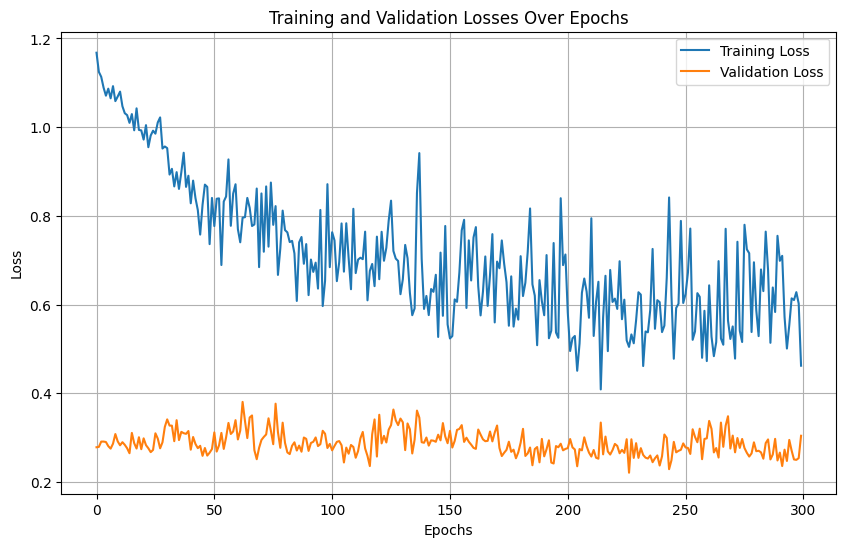

Model weights saved to model_efficientnet.pth
Model size: 42.72 MB
Model size is within the 70 MB limit.


In [ ]:
# train_efficientnet.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler

# Set up device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mean and std for normalization (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Change input dimensions to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),  # RandAugment for increased data diversity
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Change input dimensions to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class BirdDataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.allowed_classes = allowed_classes

        self.samples = []
        for class_idx, class_name in enumerate(allowed_classes):
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, class_idx))

        random.seed(42)  # Fixed seed for reproducibility
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2):
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    dataset = BirdDataset(image_dir=image_dir, allowed_classes=classes, transform=train_transform)

    # Creating data indices for training and validation splits
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

    return train_loader, val_loader

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Using Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    scores = [[], []]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(train_loader))

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"  # Update this path to your dataset
    train_loader, val_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=2)

    model = Model(num_classes=4).to(device)

    # Load pre-trained EfficientNetB0 locally
    pretrained_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    pretrained_dict = pretrained_model.state_dict()
    model_dict = model.state_dict()

    # Filter out the classifier layer
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and not k.startswith('base_model.classifier.')}

    # Update the model's state_dict
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    num_epochs, patience = 300, 100  # Adjust these values as needed

    trained_model, training_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model_efficientnet.pth"
    torch.save(trained_model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # Check model size
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Convert to MB
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


#V12

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # Load EfficientNetB0 without pre-trained weights
        self.base_model = models.efficientnet_b0(weights=None)
        # Replace the classifier with a new one for 4 classes
        num_ftrs = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


Using device: cuda:0


Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 1/300, Training Loss: 1.1520, Validation Loss: 0.2689
F1 Score on Validation set: 0.2703, Accuracy on Validation set: 0.3333
Validation loss improved. Saving best model state.



Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 2/300, Training Loss: 1.1369, Validation Loss: 0.2801
F1 Score on Validation set: 0.1045, Accuracy on Validation set: 0.1667
No improvement in validation loss for 1 epochs.



Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 3/300, Training Loss: 1.1236, Validation Loss: 0.2742
F1 Score on Validation set: 0.2373, Accuracy on Validation set: 0.3000
No improvement in validation loss for 2 epochs.



Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 4/300, Training Loss: 1.0917, Validation Loss: 0.2726
F1 Score on Validation set: 0.3146, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.



Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 5/300, Training Loss: 1.1122, Validation Loss: 0.2819
F1 Score on Validation set: 0.2505, Accuracy on Validation set: 0.2667
No improvement in validation loss for 4 epochs.



Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 6/300, Training Loss: 1.1011, Validation Loss: 0.2774
F1 Score on Validation set: 0.2773, Accuracy on Validation set: 0.3000
No improvement in validation loss for 5 epochs.



Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



Epoch 7/300, Training Loss: 1.0875, Validation Loss: 0.2811
F1 Score on Validation set: 0.2191, Accuracy on Validation set: 0.2667
No improvement in validation loss for 6 epochs.



Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 8/300, Training Loss: 1.1086, Validation Loss: 0.2735
F1 Score on Validation set: 0.1949, Accuracy on Validation set: 0.2333
No improvement in validation loss for 7 epochs.



Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]



Epoch 9/300, Training Loss: 1.0993, Validation Loss: 0.2798
F1 Score on Validation set: 0.2883, Accuracy on Validation set: 0.3000
No improvement in validation loss for 8 epochs.



Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 10/300, Training Loss: 1.0985, Validation Loss: 0.2787
F1 Score on Validation set: 0.3884, Accuracy on Validation set: 0.4000
No improvement in validation loss for 9 epochs.



Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 11/300, Training Loss: 1.1026, Validation Loss: 0.2691
F1 Score on Validation set: 0.3181, Accuracy on Validation set: 0.3333
No improvement in validation loss for 10 epochs.



Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 12/300, Training Loss: 1.0862, Validation Loss: 0.2693
F1 Score on Validation set: 0.2608, Accuracy on Validation set: 0.2667
No improvement in validation loss for 11 epochs.



Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 13/300, Training Loss: 1.0911, Validation Loss: 0.2841
F1 Score on Validation set: 0.1304, Accuracy on Validation set: 0.1667
No improvement in validation loss for 12 epochs.



Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]



Epoch 14/300, Training Loss: 1.0801, Validation Loss: 0.2862
F1 Score on Validation set: 0.2766, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 15/300, Training Loss: 1.0896, Validation Loss: 0.2691
F1 Score on Validation set: 0.2218, Accuracy on Validation set: 0.3000
No improvement in validation loss for 14 epochs.



Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 16/300, Training Loss: 1.0888, Validation Loss: 0.2762
F1 Score on Validation set: 0.3787, Accuracy on Validation set: 0.4000
No improvement in validation loss for 15 epochs.



Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 17/300, Training Loss: 1.0925, Validation Loss: 0.2537
F1 Score on Validation set: 0.4299, Accuracy on Validation set: 0.4333
Validation loss improved. Saving best model state.



Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 18/300, Training Loss: 1.0626, Validation Loss: 0.2719
F1 Score on Validation set: 0.2011, Accuracy on Validation set: 0.2333
No improvement in validation loss for 1 epochs.



Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 19/300, Training Loss: 1.0768, Validation Loss: 0.2651
F1 Score on Validation set: 0.3792, Accuracy on Validation set: 0.4333
No improvement in validation loss for 2 epochs.



Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]



Epoch 20/300, Training Loss: 1.0844, Validation Loss: 0.2835
F1 Score on Validation set: 0.2541, Accuracy on Validation set: 0.2667
No improvement in validation loss for 3 epochs.



Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



Epoch 21/300, Training Loss: 1.0639, Validation Loss: 0.2785
F1 Score on Validation set: 0.3036, Accuracy on Validation set: 0.3000
No improvement in validation loss for 4 epochs.



Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]



Epoch 22/300, Training Loss: 1.0678, Validation Loss: 0.2686
F1 Score on Validation set: 0.3606, Accuracy on Validation set: 0.3667
No improvement in validation loss for 5 epochs.



Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



Epoch 23/300, Training Loss: 1.0735, Validation Loss: 0.2822
F1 Score on Validation set: 0.2883, Accuracy on Validation set: 0.3000
No improvement in validation loss for 6 epochs.



Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 24/300, Training Loss: 1.0700, Validation Loss: 0.2722
F1 Score on Validation set: 0.3126, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.



Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 25/300, Training Loss: 1.0700, Validation Loss: 0.2955
F1 Score on Validation set: 0.2409, Accuracy on Validation set: 0.2333
No improvement in validation loss for 8 epochs.



Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 26/300, Training Loss: 1.0540, Validation Loss: 0.2768
F1 Score on Validation set: 0.2741, Accuracy on Validation set: 0.2667
No improvement in validation loss for 9 epochs.



Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 27/300, Training Loss: 1.0755, Validation Loss: 0.2688
F1 Score on Validation set: 0.3719, Accuracy on Validation set: 0.3667
No improvement in validation loss for 10 epochs.



Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 28/300, Training Loss: 1.0658, Validation Loss: 0.2727
F1 Score on Validation set: 0.3371, Accuracy on Validation set: 0.3333
No improvement in validation loss for 11 epochs.



Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]



Epoch 29/300, Training Loss: 1.0567, Validation Loss: 0.2696
F1 Score on Validation set: 0.3282, Accuracy on Validation set: 0.3333
No improvement in validation loss for 12 epochs.



Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



Epoch 30/300, Training Loss: 1.0613, Validation Loss: 0.2790
F1 Score on Validation set: 0.3313, Accuracy on Validation set: 0.3667
No improvement in validation loss for 13 epochs.



Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 31/300, Training Loss: 1.0580, Validation Loss: 0.2756
F1 Score on Validation set: 0.2315, Accuracy on Validation set: 0.2333
No improvement in validation loss for 14 epochs.



Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]



Epoch 32/300, Training Loss: 1.0820, Validation Loss: 0.2813
F1 Score on Validation set: 0.1667, Accuracy on Validation set: 0.2000
No improvement in validation loss for 15 epochs.



Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 33/300, Training Loss: 1.0472, Validation Loss: 0.2681
F1 Score on Validation set: 0.2905, Accuracy on Validation set: 0.3000
No improvement in validation loss for 16 epochs.



Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 34/300, Training Loss: 1.0585, Validation Loss: 0.2741
F1 Score on Validation set: 0.2155, Accuracy on Validation set: 0.2333
No improvement in validation loss for 17 epochs.



Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]



Epoch 35/300, Training Loss: 1.0607, Validation Loss: 0.2702
F1 Score on Validation set: 0.3034, Accuracy on Validation set: 0.3000
No improvement in validation loss for 18 epochs.



Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



Epoch 36/300, Training Loss: 1.0432, Validation Loss: 0.2723
F1 Score on Validation set: 0.3054, Accuracy on Validation set: 0.3333
No improvement in validation loss for 19 epochs.



Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



Epoch 37/300, Training Loss: 1.0417, Validation Loss: 0.3046
F1 Score on Validation set: 0.1850, Accuracy on Validation set: 0.2333
No improvement in validation loss for 20 epochs.



Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 38/300, Training Loss: 1.0596, Validation Loss: 0.2758
F1 Score on Validation set: 0.4100, Accuracy on Validation set: 0.4667
No improvement in validation loss for 21 epochs.



Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 39/300, Training Loss: 1.0338, Validation Loss: 0.2744
F1 Score on Validation set: 0.2695, Accuracy on Validation set: 0.2667
No improvement in validation loss for 22 epochs.



Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]



Epoch 40/300, Training Loss: 1.0283, Validation Loss: 0.2736
F1 Score on Validation set: 0.3321, Accuracy on Validation set: 0.3333
No improvement in validation loss for 23 epochs.



Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 41/300, Training Loss: 1.0556, Validation Loss: 0.2758
F1 Score on Validation set: 0.2879, Accuracy on Validation set: 0.3333
No improvement in validation loss for 24 epochs.



Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 42/300, Training Loss: 1.0511, Validation Loss: 0.2618
F1 Score on Validation set: 0.5109, Accuracy on Validation set: 0.5333
No improvement in validation loss for 25 epochs.



Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 43/300, Training Loss: 1.0354, Validation Loss: 0.2775
F1 Score on Validation set: 0.2844, Accuracy on Validation set: 0.3333
No improvement in validation loss for 26 epochs.



Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 44/300, Training Loss: 1.0938, Validation Loss: 0.2789
F1 Score on Validation set: 0.2733, Accuracy on Validation set: 0.3000
No improvement in validation loss for 27 epochs.



Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 45/300, Training Loss: 1.0646, Validation Loss: 0.2736
F1 Score on Validation set: 0.2757, Accuracy on Validation set: 0.3000
No improvement in validation loss for 28 epochs.



Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 46/300, Training Loss: 1.0639, Validation Loss: 0.2678
F1 Score on Validation set: 0.2570, Accuracy on Validation set: 0.2667
No improvement in validation loss for 29 epochs.



Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 47/300, Training Loss: 1.0692, Validation Loss: 0.2566
F1 Score on Validation set: 0.4983, Accuracy on Validation set: 0.5000
No improvement in validation loss for 30 epochs.



Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]



Epoch 48/300, Training Loss: 1.0303, Validation Loss: 0.2722
F1 Score on Validation set: 0.2583, Accuracy on Validation set: 0.3000
No improvement in validation loss for 31 epochs.



Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 49/300, Training Loss: 1.0644, Validation Loss: 0.2670
F1 Score on Validation set: 0.2565, Accuracy on Validation set: 0.2667
No improvement in validation loss for 32 epochs.



Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]



Epoch 50/300, Training Loss: 1.0423, Validation Loss: 0.2510
F1 Score on Validation set: 0.4559, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



Epoch 51/300, Training Loss: 1.0401, Validation Loss: 0.2710
F1 Score on Validation set: 0.3575, Accuracy on Validation set: 0.3667
No improvement in validation loss for 1 epochs.



Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 52/300, Training Loss: 1.0222, Validation Loss: 0.2829
F1 Score on Validation set: 0.2198, Accuracy on Validation set: 0.2333
No improvement in validation loss for 2 epochs.



Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 53/300, Training Loss: 1.0409, Validation Loss: 0.2757
F1 Score on Validation set: 0.1885, Accuracy on Validation set: 0.2000
No improvement in validation loss for 3 epochs.



Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 54/300, Training Loss: 1.0504, Validation Loss: 0.2765
F1 Score on Validation set: 0.3525, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 55/300, Training Loss: 0.9974, Validation Loss: 0.2725
F1 Score on Validation set: 0.3684, Accuracy on Validation set: 0.3667
No improvement in validation loss for 5 epochs.



Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 56/300, Training Loss: 1.0495, Validation Loss: 0.2612
F1 Score on Validation set: 0.4121, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 57/300, Training Loss: 1.0633, Validation Loss: 0.2709
F1 Score on Validation set: 0.3919, Accuracy on Validation set: 0.4000
No improvement in validation loss for 7 epochs.



Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 58/300, Training Loss: 1.0155, Validation Loss: 0.2897
F1 Score on Validation set: 0.2399, Accuracy on Validation set: 0.2333
No improvement in validation loss for 8 epochs.



Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 59/300, Training Loss: 1.0131, Validation Loss: 0.2798
F1 Score on Validation set: 0.4422, Accuracy on Validation set: 0.4333
No improvement in validation loss for 9 epochs.



Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 60/300, Training Loss: 1.0209, Validation Loss: 0.2689
F1 Score on Validation set: 0.4546, Accuracy on Validation set: 0.4667
No improvement in validation loss for 10 epochs.



Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 61/300, Training Loss: 1.0379, Validation Loss: 0.2761
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3333
No improvement in validation loss for 11 epochs.



Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]



Epoch 62/300, Training Loss: 1.0132, Validation Loss: 0.2878
F1 Score on Validation set: 0.1455, Accuracy on Validation set: 0.1667
No improvement in validation loss for 12 epochs.



Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 63/300, Training Loss: 1.0388, Validation Loss: 0.2806
F1 Score on Validation set: 0.1800, Accuracy on Validation set: 0.2000
No improvement in validation loss for 13 epochs.



Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]



Epoch 64/300, Training Loss: 1.0310, Validation Loss: 0.2771
F1 Score on Validation set: 0.2892, Accuracy on Validation set: 0.3000
No improvement in validation loss for 14 epochs.



Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



Epoch 65/300, Training Loss: 0.9845, Validation Loss: 0.2924
F1 Score on Validation set: 0.2759, Accuracy on Validation set: 0.2667
No improvement in validation loss for 15 epochs.



Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 66/300, Training Loss: 1.0287, Validation Loss: 0.2923
F1 Score on Validation set: 0.2608, Accuracy on Validation set: 0.2667
No improvement in validation loss for 16 epochs.



Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 67/300, Training Loss: 1.0465, Validation Loss: 0.2838
F1 Score on Validation set: 0.3444, Accuracy on Validation set: 0.3667
No improvement in validation loss for 17 epochs.



Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 68/300, Training Loss: 1.0016, Validation Loss: 0.2696
F1 Score on Validation set: 0.3014, Accuracy on Validation set: 0.3333
No improvement in validation loss for 18 epochs.



Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 69/300, Training Loss: 1.0117, Validation Loss: 0.2829
F1 Score on Validation set: 0.3321, Accuracy on Validation set: 0.3333
No improvement in validation loss for 19 epochs.



Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 70/300, Training Loss: 1.0610, Validation Loss: 0.2653
F1 Score on Validation set: 0.4418, Accuracy on Validation set: 0.4333
No improvement in validation loss for 20 epochs.



Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 71/300, Training Loss: 1.0477, Validation Loss: 0.2750
F1 Score on Validation set: 0.3374, Accuracy on Validation set: 0.3333
No improvement in validation loss for 21 epochs.



Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 72/300, Training Loss: 0.9845, Validation Loss: 0.2588
F1 Score on Validation set: 0.4243, Accuracy on Validation set: 0.4333
No improvement in validation loss for 22 epochs.



Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 73/300, Training Loss: 1.0257, Validation Loss: 0.2848
F1 Score on Validation set: 0.1838, Accuracy on Validation set: 0.2000
No improvement in validation loss for 23 epochs.



Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 74/300, Training Loss: 1.0279, Validation Loss: 0.2576
F1 Score on Validation set: 0.3435, Accuracy on Validation set: 0.3333
No improvement in validation loss for 24 epochs.



Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 75/300, Training Loss: 1.0036, Validation Loss: 0.2900
F1 Score on Validation set: 0.2773, Accuracy on Validation set: 0.2667
No improvement in validation loss for 25 epochs.



Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 76/300, Training Loss: 0.9977, Validation Loss: 0.2813
F1 Score on Validation set: 0.2371, Accuracy on Validation set: 0.2667
No improvement in validation loss for 26 epochs.



Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



Epoch 77/300, Training Loss: 1.0118, Validation Loss: 0.2850
F1 Score on Validation set: 0.2340, Accuracy on Validation set: 0.2333
No improvement in validation loss for 27 epochs.



Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



Epoch 78/300, Training Loss: 0.9854, Validation Loss: 0.2812
F1 Score on Validation set: 0.3351, Accuracy on Validation set: 0.3667
No improvement in validation loss for 28 epochs.



Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]



Epoch 79/300, Training Loss: 1.0355, Validation Loss: 0.2765
F1 Score on Validation set: 0.3975, Accuracy on Validation set: 0.3667
No improvement in validation loss for 29 epochs.



Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 80/300, Training Loss: 1.0164, Validation Loss: 0.2814
F1 Score on Validation set: 0.2875, Accuracy on Validation set: 0.3000
No improvement in validation loss for 30 epochs.



Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 81/300, Training Loss: 0.9842, Validation Loss: 0.2839
F1 Score on Validation set: 0.3014, Accuracy on Validation set: 0.3333
No improvement in validation loss for 31 epochs.



Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 82/300, Training Loss: 0.9387, Validation Loss: 0.2766
F1 Score on Validation set: 0.3833, Accuracy on Validation set: 0.4000
No improvement in validation loss for 32 epochs.



Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 83/300, Training Loss: 1.0279, Validation Loss: 0.2601
F1 Score on Validation set: 0.4290, Accuracy on Validation set: 0.4333
No improvement in validation loss for 33 epochs.



Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]



Epoch 84/300, Training Loss: 1.0028, Validation Loss: 0.2792
F1 Score on Validation set: 0.3962, Accuracy on Validation set: 0.4000
No improvement in validation loss for 34 epochs.



Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 85/300, Training Loss: 0.9920, Validation Loss: 0.2794
F1 Score on Validation set: 0.3657, Accuracy on Validation set: 0.3667
No improvement in validation loss for 35 epochs.



Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]



Epoch 86/300, Training Loss: 1.0468, Validation Loss: 0.2743
F1 Score on Validation set: 0.3028, Accuracy on Validation set: 0.3000
No improvement in validation loss for 36 epochs.



Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 87/300, Training Loss: 1.0023, Validation Loss: 0.2823
F1 Score on Validation set: 0.2647, Accuracy on Validation set: 0.2667
No improvement in validation loss for 37 epochs.



Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 88/300, Training Loss: 1.0264, Validation Loss: 0.2600
F1 Score on Validation set: 0.4362, Accuracy on Validation set: 0.4333
No improvement in validation loss for 38 epochs.



Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 89/300, Training Loss: 1.0089, Validation Loss: 0.2626
F1 Score on Validation set: 0.3100, Accuracy on Validation set: 0.3000
No improvement in validation loss for 39 epochs.



Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 90/300, Training Loss: 0.9681, Validation Loss: 0.2717
F1 Score on Validation set: 0.2983, Accuracy on Validation set: 0.3000
No improvement in validation loss for 40 epochs.



Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 91/300, Training Loss: 0.9937, Validation Loss: 0.2797
F1 Score on Validation set: 0.2491, Accuracy on Validation set: 0.2667
No improvement in validation loss for 41 epochs.



Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]



Epoch 92/300, Training Loss: 1.0336, Validation Loss: 0.2786
F1 Score on Validation set: 0.2685, Accuracy on Validation set: 0.2667
No improvement in validation loss for 42 epochs.



Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]



Epoch 93/300, Training Loss: 0.9821, Validation Loss: 0.2663
F1 Score on Validation set: 0.3041, Accuracy on Validation set: 0.3000
No improvement in validation loss for 43 epochs.



Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 94/300, Training Loss: 1.0011, Validation Loss: 0.2748
F1 Score on Validation set: 0.3251, Accuracy on Validation set: 0.3333
No improvement in validation loss for 44 epochs.



Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 95/300, Training Loss: 1.0330, Validation Loss: 0.2465
F1 Score on Validation set: 0.4575, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Epoch 96/300, Training Loss: 0.9659, Validation Loss: 0.2813
F1 Score on Validation set: 0.2557, Accuracy on Validation set: 0.2667
No improvement in validation loss for 1 epochs.



Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



Epoch 97/300, Training Loss: 0.9709, Validation Loss: 0.2799
F1 Score on Validation set: 0.2120, Accuracy on Validation set: 0.2333
No improvement in validation loss for 2 epochs.



Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



Epoch 98/300, Training Loss: 0.9742, Validation Loss: 0.2855
F1 Score on Validation set: 0.3319, Accuracy on Validation set: 0.3333
No improvement in validation loss for 3 epochs.



Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]



Epoch 99/300, Training Loss: 0.9650, Validation Loss: 0.2783
F1 Score on Validation set: 0.3690, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]



Epoch 100/300, Training Loss: 0.9831, Validation Loss: 0.2581
F1 Score on Validation set: 0.3837, Accuracy on Validation set: 0.3667
No improvement in validation loss for 5 epochs.



Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



Epoch 101/300, Training Loss: 0.9967, Validation Loss: 0.2863
F1 Score on Validation set: 0.3665, Accuracy on Validation set: 0.3667
No improvement in validation loss for 6 epochs.



Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]



Epoch 102/300, Training Loss: 0.9673, Validation Loss: 0.2967
F1 Score on Validation set: 0.2481, Accuracy on Validation set: 0.2333
No improvement in validation loss for 7 epochs.



Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]



Epoch 103/300, Training Loss: 0.9985, Validation Loss: 0.2861
F1 Score on Validation set: 0.2711, Accuracy on Validation set: 0.3000
No improvement in validation loss for 8 epochs.



Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 104/300, Training Loss: 1.0004, Validation Loss: 0.2730
F1 Score on Validation set: 0.3584, Accuracy on Validation set: 0.3667
No improvement in validation loss for 9 epochs.



Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 105/300, Training Loss: 0.9831, Validation Loss: 0.2664
F1 Score on Validation set: 0.3347, Accuracy on Validation set: 0.3333
No improvement in validation loss for 10 epochs.



Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 106/300, Training Loss: 0.9829, Validation Loss: 0.2771
F1 Score on Validation set: 0.3093, Accuracy on Validation set: 0.3333
No improvement in validation loss for 11 epochs.



Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]



Epoch 107/300, Training Loss: 1.0135, Validation Loss: 0.2956
F1 Score on Validation set: 0.2475, Accuracy on Validation set: 0.2667
No improvement in validation loss for 12 epochs.



Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 108/300, Training Loss: 1.0164, Validation Loss: 0.2746
F1 Score on Validation set: 0.3152, Accuracy on Validation set: 0.3333
No improvement in validation loss for 13 epochs.



Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 109/300, Training Loss: 1.0077, Validation Loss: 0.2841
F1 Score on Validation set: 0.4192, Accuracy on Validation set: 0.4333
No improvement in validation loss for 14 epochs.



Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 110/300, Training Loss: 1.0095, Validation Loss: 0.2677
F1 Score on Validation set: 0.3806, Accuracy on Validation set: 0.4333
No improvement in validation loss for 15 epochs.



Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 111/300, Training Loss: 0.9754, Validation Loss: 0.3004
F1 Score on Validation set: 0.2214, Accuracy on Validation set: 0.2333
No improvement in validation loss for 16 epochs.



Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]



Epoch 112/300, Training Loss: 0.9916, Validation Loss: 0.2720
F1 Score on Validation set: 0.3677, Accuracy on Validation set: 0.3667
No improvement in validation loss for 17 epochs.



Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]



Epoch 113/300, Training Loss: 0.9784, Validation Loss: 0.2889
F1 Score on Validation set: 0.2862, Accuracy on Validation set: 0.3000
No improvement in validation loss for 18 epochs.



Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 114/300, Training Loss: 0.9581, Validation Loss: 0.3065
F1 Score on Validation set: 0.2501, Accuracy on Validation set: 0.2667
No improvement in validation loss for 19 epochs.



Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]



Epoch 115/300, Training Loss: 0.9604, Validation Loss: 0.2707
F1 Score on Validation set: 0.2632, Accuracy on Validation set: 0.2667
No improvement in validation loss for 20 epochs.



Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



Epoch 116/300, Training Loss: 0.9372, Validation Loss: 0.2559
F1 Score on Validation set: 0.3611, Accuracy on Validation set: 0.3667
No improvement in validation loss for 21 epochs.



Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 117/300, Training Loss: 0.9554, Validation Loss: 0.2833
F1 Score on Validation set: 0.2897, Accuracy on Validation set: 0.3000
No improvement in validation loss for 22 epochs.



Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 118/300, Training Loss: 1.0128, Validation Loss: 0.2808
F1 Score on Validation set: 0.2924, Accuracy on Validation set: 0.3000
No improvement in validation loss for 23 epochs.



Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 119/300, Training Loss: 0.9715, Validation Loss: 0.2768
F1 Score on Validation set: 0.4083, Accuracy on Validation set: 0.4333
No improvement in validation loss for 24 epochs.



Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 120/300, Training Loss: 0.9992, Validation Loss: 0.2697
F1 Score on Validation set: 0.3492, Accuracy on Validation set: 0.3333
No improvement in validation loss for 25 epochs.



Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 121/300, Training Loss: 0.9224, Validation Loss: 0.2723
F1 Score on Validation set: 0.3084, Accuracy on Validation set: 0.3000
No improvement in validation loss for 26 epochs.



Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 122/300, Training Loss: 0.9156, Validation Loss: 0.2666
F1 Score on Validation set: 0.2650, Accuracy on Validation set: 0.3000
No improvement in validation loss for 27 epochs.



Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 123/300, Training Loss: 0.9313, Validation Loss: 0.3067
F1 Score on Validation set: 0.1947, Accuracy on Validation set: 0.2000
No improvement in validation loss for 28 epochs.



Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]



Epoch 124/300, Training Loss: 0.9073, Validation Loss: 0.2596
F1 Score on Validation set: 0.3540, Accuracy on Validation set: 0.3667
No improvement in validation loss for 29 epochs.



Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]



Epoch 125/300, Training Loss: 0.9859, Validation Loss: 0.2706
F1 Score on Validation set: 0.3427, Accuracy on Validation set: 0.3333
No improvement in validation loss for 30 epochs.



Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 126/300, Training Loss: 0.9639, Validation Loss: 0.3033
F1 Score on Validation set: 0.1775, Accuracy on Validation set: 0.1667
No improvement in validation loss for 31 epochs.



Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 127/300, Training Loss: 0.9629, Validation Loss: 0.2870
F1 Score on Validation set: 0.3033, Accuracy on Validation set: 0.3000
No improvement in validation loss for 32 epochs.



Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 128/300, Training Loss: 0.9606, Validation Loss: 0.2629
F1 Score on Validation set: 0.4348, Accuracy on Validation set: 0.4333
No improvement in validation loss for 33 epochs.



Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 129/300, Training Loss: 0.9127, Validation Loss: 0.2813
F1 Score on Validation set: 0.1647, Accuracy on Validation set: 0.1667
No improvement in validation loss for 34 epochs.



Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]



Epoch 130/300, Training Loss: 0.9335, Validation Loss: 0.2744
F1 Score on Validation set: 0.3994, Accuracy on Validation set: 0.4000
No improvement in validation loss for 35 epochs.



Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 131/300, Training Loss: 0.9429, Validation Loss: 0.2757
F1 Score on Validation set: 0.2888, Accuracy on Validation set: 0.3000
No improvement in validation loss for 36 epochs.



Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 132/300, Training Loss: 0.9469, Validation Loss: 0.2443
F1 Score on Validation set: 0.4957, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 133/300, Training Loss: 0.9670, Validation Loss: 0.2419
F1 Score on Validation set: 0.4732, Accuracy on Validation set: 0.4667
Validation loss improved. Saving best model state.



Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 134/300, Training Loss: 0.9940, Validation Loss: 0.3108
F1 Score on Validation set: 0.0783, Accuracy on Validation set: 0.1000
No improvement in validation loss for 1 epochs.



Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 135/300, Training Loss: 0.9851, Validation Loss: 0.2699
F1 Score on Validation set: 0.2247, Accuracy on Validation set: 0.2333
No improvement in validation loss for 2 epochs.



Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 136/300, Training Loss: 0.9063, Validation Loss: 0.2934
F1 Score on Validation set: 0.2331, Accuracy on Validation set: 0.2333
No improvement in validation loss for 3 epochs.



Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 137/300, Training Loss: 0.9322, Validation Loss: 0.3047
F1 Score on Validation set: 0.1387, Accuracy on Validation set: 0.1667
No improvement in validation loss for 4 epochs.



Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



Epoch 138/300, Training Loss: 0.8978, Validation Loss: 0.2603
F1 Score on Validation set: 0.4540, Accuracy on Validation set: 0.4667
No improvement in validation loss for 5 epochs.



Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]



Epoch 139/300, Training Loss: 0.9336, Validation Loss: 0.2579
F1 Score on Validation set: 0.4008, Accuracy on Validation set: 0.4000
No improvement in validation loss for 6 epochs.



Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]



Epoch 140/300, Training Loss: 0.9403, Validation Loss: 0.2859
F1 Score on Validation set: 0.3315, Accuracy on Validation set: 0.3333
No improvement in validation loss for 7 epochs.



Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 141/300, Training Loss: 0.9241, Validation Loss: 0.2778
F1 Score on Validation set: 0.3964, Accuracy on Validation set: 0.4000
No improvement in validation loss for 8 epochs.



Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



Epoch 142/300, Training Loss: 0.9787, Validation Loss: 0.2705
F1 Score on Validation set: 0.2066, Accuracy on Validation set: 0.2333
No improvement in validation loss for 9 epochs.



Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]



Epoch 143/300, Training Loss: 0.9485, Validation Loss: 0.2932
F1 Score on Validation set: 0.1765, Accuracy on Validation set: 0.2000
No improvement in validation loss for 10 epochs.



Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]



Epoch 144/300, Training Loss: 0.9270, Validation Loss: 0.2434
F1 Score on Validation set: 0.4750, Accuracy on Validation set: 0.5000
No improvement in validation loss for 11 epochs.



Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 145/300, Training Loss: 0.8947, Validation Loss: 0.3277
F1 Score on Validation set: 0.1667, Accuracy on Validation set: 0.2333
No improvement in validation loss for 12 epochs.



Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 146/300, Training Loss: 0.9450, Validation Loss: 0.2872
F1 Score on Validation set: 0.1818, Accuracy on Validation set: 0.2000
No improvement in validation loss for 13 epochs.



Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]



Epoch 147/300, Training Loss: 0.9006, Validation Loss: 0.2747
F1 Score on Validation set: 0.3655, Accuracy on Validation set: 0.3667
No improvement in validation loss for 14 epochs.



Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]



Epoch 148/300, Training Loss: 0.9172, Validation Loss: 0.2913
F1 Score on Validation set: 0.3238, Accuracy on Validation set: 0.3333
No improvement in validation loss for 15 epochs.



Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 149/300, Training Loss: 0.8788, Validation Loss: 0.2672
F1 Score on Validation set: 0.3194, Accuracy on Validation set: 0.3333
No improvement in validation loss for 16 epochs.



Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 150/300, Training Loss: 0.9719, Validation Loss: 0.2696
F1 Score on Validation set: 0.3560, Accuracy on Validation set: 0.3667
No improvement in validation loss for 17 epochs.



Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]



Epoch 151/300, Training Loss: 0.8693, Validation Loss: 0.2748
F1 Score on Validation set: 0.3686, Accuracy on Validation set: 0.4000
No improvement in validation loss for 18 epochs.



Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 152/300, Training Loss: 0.9342, Validation Loss: 0.2852
F1 Score on Validation set: 0.2478, Accuracy on Validation set: 0.2667
No improvement in validation loss for 19 epochs.



Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 153/300, Training Loss: 0.9065, Validation Loss: 0.2937
F1 Score on Validation set: 0.3595, Accuracy on Validation set: 0.3667
No improvement in validation loss for 20 epochs.



Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 154/300, Training Loss: 0.9262, Validation Loss: 0.2573
F1 Score on Validation set: 0.3672, Accuracy on Validation set: 0.3667
No improvement in validation loss for 21 epochs.



Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 155/300, Training Loss: 0.9079, Validation Loss: 0.2778
F1 Score on Validation set: 0.3956, Accuracy on Validation set: 0.4000
No improvement in validation loss for 22 epochs.



Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]



Epoch 156/300, Training Loss: 0.9206, Validation Loss: 0.3035
F1 Score on Validation set: 0.1508, Accuracy on Validation set: 0.1667
No improvement in validation loss for 23 epochs.



Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



Epoch 157/300, Training Loss: 0.9259, Validation Loss: 0.2764
F1 Score on Validation set: 0.3657, Accuracy on Validation set: 0.3667
No improvement in validation loss for 24 epochs.



Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 158/300, Training Loss: 0.9173, Validation Loss: 0.2653
F1 Score on Validation set: 0.3988, Accuracy on Validation set: 0.4000
No improvement in validation loss for 25 epochs.



Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 159/300, Training Loss: 0.9319, Validation Loss: 0.2483
F1 Score on Validation set: 0.3983, Accuracy on Validation set: 0.4333
No improvement in validation loss for 26 epochs.



Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]



Epoch 160/300, Training Loss: 0.8836, Validation Loss: 0.2920
F1 Score on Validation set: 0.3360, Accuracy on Validation set: 0.3333
No improvement in validation loss for 27 epochs.



Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 161/300, Training Loss: 0.9135, Validation Loss: 0.2726
F1 Score on Validation set: 0.2585, Accuracy on Validation set: 0.2667
No improvement in validation loss for 28 epochs.



Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 162/300, Training Loss: 0.8792, Validation Loss: 0.2934
F1 Score on Validation set: 0.1971, Accuracy on Validation set: 0.2000
No improvement in validation loss for 29 epochs.



Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 163/300, Training Loss: 0.8802, Validation Loss: 0.2859
F1 Score on Validation set: 0.3580, Accuracy on Validation set: 0.3667
No improvement in validation loss for 30 epochs.



Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 164/300, Training Loss: 0.9507, Validation Loss: 0.2813
F1 Score on Validation set: 0.2985, Accuracy on Validation set: 0.3000
No improvement in validation loss for 31 epochs.



Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 165/300, Training Loss: 0.9153, Validation Loss: 0.2778
F1 Score on Validation set: 0.2678, Accuracy on Validation set: 0.2667
No improvement in validation loss for 32 epochs.



Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 166/300, Training Loss: 0.9351, Validation Loss: 0.2721
F1 Score on Validation set: 0.2879, Accuracy on Validation set: 0.3000
No improvement in validation loss for 33 epochs.



Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 167/300, Training Loss: 0.8938, Validation Loss: 0.2673
F1 Score on Validation set: 0.3325, Accuracy on Validation set: 0.3333
No improvement in validation loss for 34 epochs.



Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 168/300, Training Loss: 0.8918, Validation Loss: 0.2961
F1 Score on Validation set: 0.3096, Accuracy on Validation set: 0.3333
No improvement in validation loss for 35 epochs.



Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 169/300, Training Loss: 0.9339, Validation Loss: 0.2858
F1 Score on Validation set: 0.2978, Accuracy on Validation set: 0.3000
No improvement in validation loss for 36 epochs.



Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]



Epoch 170/300, Training Loss: 0.8519, Validation Loss: 0.2642
F1 Score on Validation set: 0.3436, Accuracy on Validation set: 0.3667
No improvement in validation loss for 37 epochs.



Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]



Epoch 171/300, Training Loss: 0.8594, Validation Loss: 0.2815
F1 Score on Validation set: 0.2983, Accuracy on Validation set: 0.3000
No improvement in validation loss for 38 epochs.



Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



Epoch 172/300, Training Loss: 0.9187, Validation Loss: 0.2932
F1 Score on Validation set: 0.2394, Accuracy on Validation set: 0.2333
No improvement in validation loss for 39 epochs.



Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 173/300, Training Loss: 0.8647, Validation Loss: 0.2904
F1 Score on Validation set: 0.2320, Accuracy on Validation set: 0.2667
No improvement in validation loss for 40 epochs.



Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]



Epoch 174/300, Training Loss: 0.8859, Validation Loss: 0.2892
F1 Score on Validation set: 0.2643, Accuracy on Validation set: 0.2667
No improvement in validation loss for 41 epochs.



Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 175/300, Training Loss: 0.8886, Validation Loss: 0.2786
F1 Score on Validation set: 0.2395, Accuracy on Validation set: 0.2667
No improvement in validation loss for 42 epochs.



Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]



Epoch 176/300, Training Loss: 0.8560, Validation Loss: 0.2787
F1 Score on Validation set: 0.3467, Accuracy on Validation set: 0.3667
No improvement in validation loss for 43 epochs.



Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 177/300, Training Loss: 0.8572, Validation Loss: 0.2690
F1 Score on Validation set: 0.4603, Accuracy on Validation set: 0.4667
No improvement in validation loss for 44 epochs.



Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 178/300, Training Loss: 0.9247, Validation Loss: 0.2759
F1 Score on Validation set: 0.3627, Accuracy on Validation set: 0.4000
No improvement in validation loss for 45 epochs.



Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 179/300, Training Loss: 0.8700, Validation Loss: 0.2775
F1 Score on Validation set: 0.3099, Accuracy on Validation set: 0.3333
No improvement in validation loss for 46 epochs.



Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 180/300, Training Loss: 0.8605, Validation Loss: 0.2741
F1 Score on Validation set: 0.3982, Accuracy on Validation set: 0.4000
No improvement in validation loss for 47 epochs.



Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 181/300, Training Loss: 0.9184, Validation Loss: 0.2586
F1 Score on Validation set: 0.4402, Accuracy on Validation set: 0.4667
No improvement in validation loss for 48 epochs.



Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 182/300, Training Loss: 0.8872, Validation Loss: 0.2510
F1 Score on Validation set: 0.4122, Accuracy on Validation set: 0.4000
No improvement in validation loss for 49 epochs.



Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 183/300, Training Loss: 0.8420, Validation Loss: 0.2959
F1 Score on Validation set: 0.2983, Accuracy on Validation set: 0.3000
No improvement in validation loss for 50 epochs.



Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]



Epoch 184/300, Training Loss: 0.8141, Validation Loss: 0.2751
F1 Score on Validation set: 0.3027, Accuracy on Validation set: 0.3000
No improvement in validation loss for 51 epochs.



Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]



Epoch 185/300, Training Loss: 0.8172, Validation Loss: 0.2728
F1 Score on Validation set: 0.3042, Accuracy on Validation set: 0.3000
No improvement in validation loss for 52 epochs.



Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]



Epoch 186/300, Training Loss: 0.8528, Validation Loss: 0.2693
F1 Score on Validation set: 0.3629, Accuracy on Validation set: 0.3667
No improvement in validation loss for 53 epochs.



Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 187/300, Training Loss: 0.9309, Validation Loss: 0.2682
F1 Score on Validation set: 0.3911, Accuracy on Validation set: 0.4000
No improvement in validation loss for 54 epochs.



Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]



Epoch 188/300, Training Loss: 0.8337, Validation Loss: 0.2797
F1 Score on Validation set: 0.2838, Accuracy on Validation set: 0.2667
No improvement in validation loss for 55 epochs.



Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]



Epoch 189/300, Training Loss: 0.8866, Validation Loss: 0.2679
F1 Score on Validation set: 0.4381, Accuracy on Validation set: 0.4333
No improvement in validation loss for 56 epochs.



Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



Epoch 190/300, Training Loss: 0.8818, Validation Loss: 0.2699
F1 Score on Validation set: 0.3953, Accuracy on Validation set: 0.4000
No improvement in validation loss for 57 epochs.



Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Epoch 191/300, Training Loss: 0.7773, Validation Loss: 0.3000
F1 Score on Validation set: 0.2869, Accuracy on Validation set: 0.3000
No improvement in validation loss for 58 epochs.



Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch 192/300, Training Loss: 0.9168, Validation Loss: 0.2645
F1 Score on Validation set: 0.4889, Accuracy on Validation set: 0.5000
No improvement in validation loss for 59 epochs.



Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



Epoch 193/300, Training Loss: 0.8643, Validation Loss: 0.2913
F1 Score on Validation set: 0.3684, Accuracy on Validation set: 0.4000
No improvement in validation loss for 60 epochs.



Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]



Epoch 194/300, Training Loss: 0.8775, Validation Loss: 0.2765
F1 Score on Validation set: 0.3192, Accuracy on Validation set: 0.3333
No improvement in validation loss for 61 epochs.



Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 195/300, Training Loss: 0.8741, Validation Loss: 0.2823
F1 Score on Validation set: 0.3225, Accuracy on Validation set: 0.3333
No improvement in validation loss for 62 epochs.



Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]



Epoch 196/300, Training Loss: 0.8598, Validation Loss: 0.2941
F1 Score on Validation set: 0.1908, Accuracy on Validation set: 0.2000
No improvement in validation loss for 63 epochs.



Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]



Epoch 197/300, Training Loss: 0.8951, Validation Loss: 0.2689
F1 Score on Validation set: 0.4844, Accuracy on Validation set: 0.5000
No improvement in validation loss for 64 epochs.



Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]



Epoch 198/300, Training Loss: 0.8255, Validation Loss: 0.2838
F1 Score on Validation set: 0.3309, Accuracy on Validation set: 0.3333
No improvement in validation loss for 65 epochs.



Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]



Epoch 199/300, Training Loss: 0.8385, Validation Loss: 0.2935
F1 Score on Validation set: 0.3612, Accuracy on Validation set: 0.3667
No improvement in validation loss for 66 epochs.



Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 200/300, Training Loss: 0.8781, Validation Loss: 0.2742
F1 Score on Validation set: 0.3617, Accuracy on Validation set: 0.3667
No improvement in validation loss for 67 epochs.



Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 201/300, Training Loss: 0.9016, Validation Loss: 0.2595
F1 Score on Validation set: 0.5336, Accuracy on Validation set: 0.5333
No improvement in validation loss for 68 epochs.



Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 202/300, Training Loss: 0.8668, Validation Loss: 0.2658
F1 Score on Validation set: 0.3700, Accuracy on Validation set: 0.3667
No improvement in validation loss for 69 epochs.



Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 203/300, Training Loss: 0.8962, Validation Loss: 0.2760
F1 Score on Validation set: 0.4341, Accuracy on Validation set: 0.4333
No improvement in validation loss for 70 epochs.



Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]



Epoch 204/300, Training Loss: 0.8628, Validation Loss: 0.2826
F1 Score on Validation set: 0.2648, Accuracy on Validation set: 0.3333
No improvement in validation loss for 71 epochs.



Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 205/300, Training Loss: 0.8250, Validation Loss: 0.2838
F1 Score on Validation set: 0.3135, Accuracy on Validation set: 0.3667
No improvement in validation loss for 72 epochs.



Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 206/300, Training Loss: 0.8575, Validation Loss: 0.2596
F1 Score on Validation set: 0.2761, Accuracy on Validation set: 0.3000
No improvement in validation loss for 73 epochs.



Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]



Epoch 207/300, Training Loss: 0.8984, Validation Loss: 0.2672
F1 Score on Validation set: 0.4210, Accuracy on Validation set: 0.4333
No improvement in validation loss for 74 epochs.



Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 208/300, Training Loss: 0.8212, Validation Loss: 0.2897
F1 Score on Validation set: 0.2995, Accuracy on Validation set: 0.3000
No improvement in validation loss for 75 epochs.



Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 209/300, Training Loss: 0.8575, Validation Loss: 0.2716
F1 Score on Validation set: 0.4463, Accuracy on Validation set: 0.4333
No improvement in validation loss for 76 epochs.



Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 210/300, Training Loss: 0.8699, Validation Loss: 0.2909
F1 Score on Validation set: 0.4394, Accuracy on Validation set: 0.4333
No improvement in validation loss for 77 epochs.



Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]



Epoch 211/300, Training Loss: 0.8308, Validation Loss: 0.2855
F1 Score on Validation set: 0.4384, Accuracy on Validation set: 0.4333
No improvement in validation loss for 78 epochs.



Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]



Epoch 212/300, Training Loss: 0.8008, Validation Loss: 0.2429
F1 Score on Validation set: 0.4300, Accuracy on Validation set: 0.4333
No improvement in validation loss for 79 epochs.



Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]



Epoch 213/300, Training Loss: 0.8785, Validation Loss: 0.2761
F1 Score on Validation set: 0.3906, Accuracy on Validation set: 0.4333
No improvement in validation loss for 80 epochs.



Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 214/300, Training Loss: 0.8734, Validation Loss: 0.2876
F1 Score on Validation set: 0.2698, Accuracy on Validation set: 0.3000
No improvement in validation loss for 81 epochs.



Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 215/300, Training Loss: 0.8739, Validation Loss: 0.2881
F1 Score on Validation set: 0.1710, Accuracy on Validation set: 0.2000
No improvement in validation loss for 82 epochs.



Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]



Epoch 216/300, Training Loss: 0.8986, Validation Loss: 0.2623
F1 Score on Validation set: 0.4212, Accuracy on Validation set: 0.4333
No improvement in validation loss for 83 epochs.



Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 217/300, Training Loss: 0.8507, Validation Loss: 0.2534
F1 Score on Validation set: 0.3984, Accuracy on Validation set: 0.4000
No improvement in validation loss for 84 epochs.



Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 218/300, Training Loss: 0.8839, Validation Loss: 0.2848
F1 Score on Validation set: 0.4579, Accuracy on Validation set: 0.4333
No improvement in validation loss for 85 epochs.



Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 219/300, Training Loss: 0.7745, Validation Loss: 0.2731
F1 Score on Validation set: 0.4466, Accuracy on Validation set: 0.4667
No improvement in validation loss for 86 epochs.



Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 220/300, Training Loss: 0.8500, Validation Loss: 0.2789
F1 Score on Validation set: 0.2978, Accuracy on Validation set: 0.3000
No improvement in validation loss for 87 epochs.



Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]



Epoch 221/300, Training Loss: 0.7979, Validation Loss: 0.2500
F1 Score on Validation set: 0.4091, Accuracy on Validation set: 0.4000
No improvement in validation loss for 88 epochs.



Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 222/300, Training Loss: 0.9459, Validation Loss: 0.2379
F1 Score on Validation set: 0.4709, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 223/300, Training Loss: 0.8604, Validation Loss: 0.2837
F1 Score on Validation set: 0.3773, Accuracy on Validation set: 0.4000
No improvement in validation loss for 1 epochs.



Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 224/300, Training Loss: 0.8483, Validation Loss: 0.2483
F1 Score on Validation set: 0.3637, Accuracy on Validation set: 0.4333
No improvement in validation loss for 2 epochs.



Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]



Epoch 225/300, Training Loss: 0.8311, Validation Loss: 0.2834
F1 Score on Validation set: 0.3379, Accuracy on Validation set: 0.4000
No improvement in validation loss for 3 epochs.



Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]



Epoch 226/300, Training Loss: 0.8376, Validation Loss: 0.2686
F1 Score on Validation set: 0.3179, Accuracy on Validation set: 0.3667
No improvement in validation loss for 4 epochs.



Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]



Epoch 227/300, Training Loss: 0.8663, Validation Loss: 0.3040
F1 Score on Validation set: 0.3016, Accuracy on Validation set: 0.3333
No improvement in validation loss for 5 epochs.



Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 228/300, Training Loss: 0.7316, Validation Loss: 0.2518
F1 Score on Validation set: 0.4729, Accuracy on Validation set: 0.4667
No improvement in validation loss for 6 epochs.



Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]



Epoch 229/300, Training Loss: 0.7673, Validation Loss: 0.2540
F1 Score on Validation set: 0.4107, Accuracy on Validation set: 0.4333
No improvement in validation loss for 7 epochs.



Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]



Epoch 230/300, Training Loss: 0.8765, Validation Loss: 0.3194
F1 Score on Validation set: 0.2830, Accuracy on Validation set: 0.3000
No improvement in validation loss for 8 epochs.



Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 231/300, Training Loss: 0.7413, Validation Loss: 0.2933
F1 Score on Validation set: 0.3747, Accuracy on Validation set: 0.3667
No improvement in validation loss for 9 epochs.



Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 232/300, Training Loss: 0.8409, Validation Loss: 0.3199
F1 Score on Validation set: 0.2701, Accuracy on Validation set: 0.2667
No improvement in validation loss for 10 epochs.



Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 233/300, Training Loss: 0.7410, Validation Loss: 0.2740
F1 Score on Validation set: 0.3604, Accuracy on Validation set: 0.3667
No improvement in validation loss for 11 epochs.



Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 234/300, Training Loss: 0.9000, Validation Loss: 0.2922
F1 Score on Validation set: 0.3609, Accuracy on Validation set: 0.3667
No improvement in validation loss for 12 epochs.



Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



Epoch 235/300, Training Loss: 0.8379, Validation Loss: 0.2824
F1 Score on Validation set: 0.3975, Accuracy on Validation set: 0.4000
No improvement in validation loss for 13 epochs.



Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]



Epoch 236/300, Training Loss: 0.7796, Validation Loss: 0.2736
F1 Score on Validation set: 0.3487, Accuracy on Validation set: 0.3667
No improvement in validation loss for 14 epochs.



Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 237/300, Training Loss: 0.7405, Validation Loss: 0.2855
F1 Score on Validation set: 0.3589, Accuracy on Validation set: 0.3667
No improvement in validation loss for 15 epochs.



Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]



Epoch 238/300, Training Loss: 0.7995, Validation Loss: 0.2742
F1 Score on Validation set: 0.4000, Accuracy on Validation set: 0.4000
No improvement in validation loss for 16 epochs.



Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]



Epoch 239/300, Training Loss: 0.8260, Validation Loss: 0.2859
F1 Score on Validation set: 0.3221, Accuracy on Validation set: 0.3333
No improvement in validation loss for 17 epochs.



Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



Epoch 240/300, Training Loss: 0.8204, Validation Loss: 0.2829
F1 Score on Validation set: 0.3646, Accuracy on Validation set: 0.3667
No improvement in validation loss for 18 epochs.



Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]



Epoch 241/300, Training Loss: 0.8504, Validation Loss: 0.2610
F1 Score on Validation set: 0.3363, Accuracy on Validation set: 0.3333
No improvement in validation loss for 19 epochs.



Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]



Epoch 242/300, Training Loss: 0.8206, Validation Loss: 0.2898
F1 Score on Validation set: 0.3113, Accuracy on Validation set: 0.3000
No improvement in validation loss for 20 epochs.



Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]



Epoch 243/300, Training Loss: 0.8193, Validation Loss: 0.2465
F1 Score on Validation set: 0.3735, Accuracy on Validation set: 0.4000
No improvement in validation loss for 21 epochs.



Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 244/300, Training Loss: 0.7726, Validation Loss: 0.2870
F1 Score on Validation set: 0.3114, Accuracy on Validation set: 0.3333
No improvement in validation loss for 22 epochs.



Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]



Epoch 245/300, Training Loss: 0.7865, Validation Loss: 0.2777
F1 Score on Validation set: 0.4244, Accuracy on Validation set: 0.4333
No improvement in validation loss for 23 epochs.



Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



Epoch 246/300, Training Loss: 0.7011, Validation Loss: 0.2527
F1 Score on Validation set: 0.4400, Accuracy on Validation set: 0.4667
No improvement in validation loss for 24 epochs.



Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 247/300, Training Loss: 0.7110, Validation Loss: 0.2794
F1 Score on Validation set: 0.3684, Accuracy on Validation set: 0.3667
No improvement in validation loss for 25 epochs.



Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 248/300, Training Loss: 0.7693, Validation Loss: 0.2672
F1 Score on Validation set: 0.4977, Accuracy on Validation set: 0.5000
No improvement in validation loss for 26 epochs.



Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]



Epoch 249/300, Training Loss: 0.8136, Validation Loss: 0.2885
F1 Score on Validation set: 0.2860, Accuracy on Validation set: 0.3000
No improvement in validation loss for 27 epochs.



Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 250/300, Training Loss: 0.8079, Validation Loss: 0.2506
F1 Score on Validation set: 0.3595, Accuracy on Validation set: 0.3667
No improvement in validation loss for 28 epochs.



Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 251/300, Training Loss: 0.8584, Validation Loss: 0.2723
F1 Score on Validation set: 0.4071, Accuracy on Validation set: 0.4000
No improvement in validation loss for 29 epochs.



Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]



Epoch 252/300, Training Loss: 0.8635, Validation Loss: 0.2892
F1 Score on Validation set: 0.2793, Accuracy on Validation set: 0.2667
No improvement in validation loss for 30 epochs.



Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



Epoch 253/300, Training Loss: 0.8140, Validation Loss: 0.3034
F1 Score on Validation set: 0.2024, Accuracy on Validation set: 0.2333
No improvement in validation loss for 31 epochs.



Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]



Epoch 254/300, Training Loss: 0.7534, Validation Loss: 0.2981
F1 Score on Validation set: 0.3245, Accuracy on Validation set: 0.4000
No improvement in validation loss for 32 epochs.



Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]



Epoch 255/300, Training Loss: 0.8247, Validation Loss: 0.2933
F1 Score on Validation set: 0.3788, Accuracy on Validation set: 0.4000
No improvement in validation loss for 33 epochs.



Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]



Epoch 256/300, Training Loss: 0.8218, Validation Loss: 0.2809
F1 Score on Validation set: 0.3150, Accuracy on Validation set: 0.3333
No improvement in validation loss for 34 epochs.



Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 257/300, Training Loss: 0.7145, Validation Loss: 0.2719
F1 Score on Validation set: 0.3391, Accuracy on Validation set: 0.3333
No improvement in validation loss for 35 epochs.



Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]



Epoch 258/300, Training Loss: 0.9116, Validation Loss: 0.2757
F1 Score on Validation set: 0.4667, Accuracy on Validation set: 0.4667
No improvement in validation loss for 36 epochs.



Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]



Epoch 259/300, Training Loss: 0.7401, Validation Loss: 0.2394
F1 Score on Validation set: 0.4733, Accuracy on Validation set: 0.4667
No improvement in validation loss for 37 epochs.



Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 260/300, Training Loss: 0.7449, Validation Loss: 0.2746
F1 Score on Validation set: 0.4103, Accuracy on Validation set: 0.4000
No improvement in validation loss for 38 epochs.



Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 261/300, Training Loss: 0.8119, Validation Loss: 0.2951
F1 Score on Validation set: 0.3388, Accuracy on Validation set: 0.3333
No improvement in validation loss for 39 epochs.



Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]



Epoch 262/300, Training Loss: 0.7942, Validation Loss: 0.2690
F1 Score on Validation set: 0.3503, Accuracy on Validation set: 0.3667
No improvement in validation loss for 40 epochs.



Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



Epoch 263/300, Training Loss: 0.8335, Validation Loss: 0.2872
F1 Score on Validation set: 0.3592, Accuracy on Validation set: 0.3667
No improvement in validation loss for 41 epochs.



Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]



Epoch 264/300, Training Loss: 0.8449, Validation Loss: 0.2864
F1 Score on Validation set: 0.2497, Accuracy on Validation set: 0.2667
No improvement in validation loss for 42 epochs.



Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]



Epoch 265/300, Training Loss: 0.7913, Validation Loss: 0.2878
F1 Score on Validation set: 0.3377, Accuracy on Validation set: 0.3333
No improvement in validation loss for 43 epochs.



Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]



Epoch 266/300, Training Loss: 0.7019, Validation Loss: 0.2899
F1 Score on Validation set: 0.3403, Accuracy on Validation set: 0.3333
No improvement in validation loss for 44 epochs.



Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]



Epoch 267/300, Training Loss: 0.7049, Validation Loss: 0.2709
F1 Score on Validation set: 0.3549, Accuracy on Validation set: 0.3667
No improvement in validation loss for 45 epochs.



Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]



Epoch 268/300, Training Loss: 0.7483, Validation Loss: 0.2786
F1 Score on Validation set: 0.3344, Accuracy on Validation set: 0.3333
No improvement in validation loss for 46 epochs.



Epoch 269/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]



Epoch 269/300, Training Loss: 0.8456, Validation Loss: 0.2776
F1 Score on Validation set: 0.4722, Accuracy on Validation set: 0.5000
No improvement in validation loss for 47 epochs.



Epoch 270/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]



Epoch 270/300, Training Loss: 0.7476, Validation Loss: 0.2631
F1 Score on Validation set: 0.3188, Accuracy on Validation set: 0.3333
No improvement in validation loss for 48 epochs.



Epoch 271/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]



Epoch 271/300, Training Loss: 0.8645, Validation Loss: 0.2502
F1 Score on Validation set: 0.4937, Accuracy on Validation set: 0.5000
No improvement in validation loss for 49 epochs.



Epoch 272/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]



Epoch 272/300, Training Loss: 0.7240, Validation Loss: 0.2868
F1 Score on Validation set: 0.2775, Accuracy on Validation set: 0.3000
No improvement in validation loss for 50 epochs.



Epoch 273/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 273/300, Training Loss: 0.7584, Validation Loss: 0.2637
F1 Score on Validation set: 0.4040, Accuracy on Validation set: 0.4000
No improvement in validation loss for 51 epochs.



Epoch 274/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]



Epoch 274/300, Training Loss: 0.8286, Validation Loss: 0.2673
F1 Score on Validation set: 0.4461, Accuracy on Validation set: 0.4333
No improvement in validation loss for 52 epochs.



Epoch 275/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]



Epoch 275/300, Training Loss: 0.7788, Validation Loss: 0.2898
F1 Score on Validation set: 0.2966, Accuracy on Validation set: 0.3000
No improvement in validation loss for 53 epochs.



Epoch 276/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]



Epoch 276/300, Training Loss: 0.8289, Validation Loss: 0.2825
F1 Score on Validation set: 0.3353, Accuracy on Validation set: 0.3667
No improvement in validation loss for 54 epochs.



Epoch 277/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]



Epoch 277/300, Training Loss: 0.7604, Validation Loss: 0.2763
F1 Score on Validation set: 0.3983, Accuracy on Validation set: 0.4000
No improvement in validation loss for 55 epochs.



Epoch 278/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 278/300, Training Loss: 0.6637, Validation Loss: 0.2791
F1 Score on Validation set: 0.4098, Accuracy on Validation set: 0.4333
No improvement in validation loss for 56 epochs.



Epoch 279/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]



Epoch 279/300, Training Loss: 0.7499, Validation Loss: 0.2969
F1 Score on Validation set: 0.4449, Accuracy on Validation set: 0.4333
No improvement in validation loss for 57 epochs.



Epoch 280/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]



Epoch 280/300, Training Loss: 0.7555, Validation Loss: 0.2751
F1 Score on Validation set: 0.4052, Accuracy on Validation set: 0.4333
No improvement in validation loss for 58 epochs.



Epoch 281/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]



Epoch 281/300, Training Loss: 0.8271, Validation Loss: 0.3291
F1 Score on Validation set: 0.2010, Accuracy on Validation set: 0.2000
No improvement in validation loss for 59 epochs.



Epoch 282/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 282/300, Training Loss: 0.7597, Validation Loss: 0.2633
F1 Score on Validation set: 0.4612, Accuracy on Validation set: 0.4667
No improvement in validation loss for 60 epochs.



Epoch 283/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]



Epoch 283/300, Training Loss: 0.7835, Validation Loss: 0.2653
F1 Score on Validation set: 0.3035, Accuracy on Validation set: 0.3000
No improvement in validation loss for 61 epochs.



Epoch 284/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]



Epoch 284/300, Training Loss: 0.7565, Validation Loss: 0.2610
F1 Score on Validation set: 0.3706, Accuracy on Validation set: 0.3667
No improvement in validation loss for 62 epochs.



Epoch 285/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]



Epoch 285/300, Training Loss: 0.6559, Validation Loss: 0.2461
F1 Score on Validation set: 0.4979, Accuracy on Validation set: 0.5000
No improvement in validation loss for 63 epochs.



Epoch 286/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]



Epoch 286/300, Training Loss: 0.9138, Validation Loss: 0.2891
F1 Score on Validation set: 0.4031, Accuracy on Validation set: 0.4333
No improvement in validation loss for 64 epochs.



Epoch 287/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]



Epoch 287/300, Training Loss: 0.7657, Validation Loss: 0.2838
F1 Score on Validation set: 0.4247, Accuracy on Validation set: 0.4333
No improvement in validation loss for 65 epochs.



Epoch 288/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 288/300, Training Loss: 0.6927, Validation Loss: 0.3089
F1 Score on Validation set: 0.3080, Accuracy on Validation set: 0.3333
No improvement in validation loss for 66 epochs.



Epoch 289/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]



Epoch 289/300, Training Loss: 0.7430, Validation Loss: 0.2780
F1 Score on Validation set: 0.3500, Accuracy on Validation set: 0.3667
No improvement in validation loss for 67 epochs.



Epoch 290/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



Epoch 290/300, Training Loss: 0.7739, Validation Loss: 0.2778
F1 Score on Validation set: 0.4030, Accuracy on Validation set: 0.4000
No improvement in validation loss for 68 epochs.



Epoch 291/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 291/300, Training Loss: 0.6447, Validation Loss: 0.2551
F1 Score on Validation set: 0.4620, Accuracy on Validation set: 0.4667
No improvement in validation loss for 69 epochs.



Epoch 292/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 292/300, Training Loss: 0.7642, Validation Loss: 0.3145
F1 Score on Validation set: 0.2938, Accuracy on Validation set: 0.3000
No improvement in validation loss for 70 epochs.



Epoch 293/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]



Epoch 293/300, Training Loss: 0.7270, Validation Loss: 0.2569
F1 Score on Validation set: 0.3854, Accuracy on Validation set: 0.4000
No improvement in validation loss for 71 epochs.



Epoch 294/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]



Epoch 294/300, Training Loss: 0.9013, Validation Loss: 0.3021
F1 Score on Validation set: 0.2696, Accuracy on Validation set: 0.3000
No improvement in validation loss for 72 epochs.



Epoch 295/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]



Epoch 295/300, Training Loss: 0.8846, Validation Loss: 0.3248
F1 Score on Validation set: 0.2081, Accuracy on Validation set: 0.2667
No improvement in validation loss for 73 epochs.



Epoch 296/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]



Epoch 296/300, Training Loss: 0.7623, Validation Loss: 0.2691
F1 Score on Validation set: 0.4341, Accuracy on Validation set: 0.4333
No improvement in validation loss for 74 epochs.



Epoch 297/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 297/300, Training Loss: 0.8328, Validation Loss: 0.2708
F1 Score on Validation set: 0.3060, Accuracy on Validation set: 0.3333
No improvement in validation loss for 75 epochs.



Epoch 298/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]



Epoch 298/300, Training Loss: 0.7947, Validation Loss: 0.2907
F1 Score on Validation set: 0.3294, Accuracy on Validation set: 0.3333
No improvement in validation loss for 76 epochs.



Epoch 299/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



Epoch 299/300, Training Loss: 0.7491, Validation Loss: 0.2803
F1 Score on Validation set: 0.3746, Accuracy on Validation set: 0.4000
No improvement in validation loss for 77 epochs.



Epoch 300/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 300/300, Training Loss: 0.7277, Validation Loss: 0.2822
F1 Score on Validation set: 0.3605, Accuracy on Validation set: 0.3667
No improvement in validation loss for 78 epochs.

Best model loaded based on validation loss.



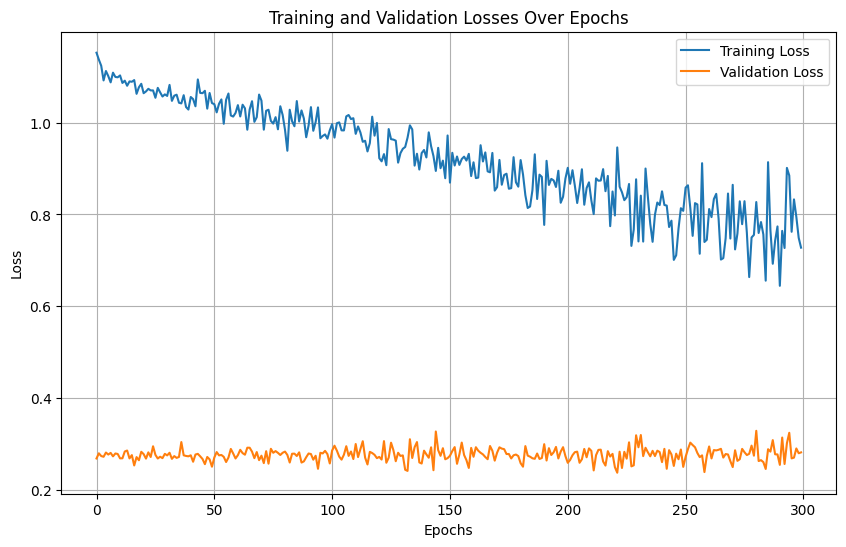

Model weights saved to model.pth
Model size: 42.72 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# Set up device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mean and std for normalization (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Change input dimensions to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),  # RandAugment for increased data diversity
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Change input dimensions to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class BirdDataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.allowed_classes = allowed_classes

        self.samples = []
        for class_idx, class_name in enumerate(allowed_classes):
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, class_idx))

        random.seed(42)  # Fixed seed for reproducibility
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2):
    classes = ["budgie", "canary", "duckling", "rubber duck"]

    dataset = BirdDataset(image_dir=image_dir, allowed_classes=classes, transform=train_transform)

    # Creating data indices for training and validation splits
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)

    return train_loader, val_loader

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Using Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    scores = [[], []]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(train_loader))
            swa_scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        scores[0].append(avg_train_loss)

        # Update SWA model
        swa_model.update_parameters(model)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    # Update BN statistics for SWA
    update_bn(train_loader, swa_model, device=device)
    swa_model.to(device)
    swa_model.eval()

    # Save SWA model
    model = swa_model

    return model, scores

def plot_losses(scores: List[List[float]]):
    train_losses, val_losses = scores
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "/content/Noisy_birds"  # Update this path to your dataset
    train_loader, val_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=2)

    model = Model(num_classes=4).to(device)

    # Load pre-trained EfficientNetB0 locally
    pretrained_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    pretrained_dict = pretrained_model.state_dict()
    model_dict = model.state_dict()

    # Filter out the classifier layer
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and not k.startswith('base_model.classifier.')}

    # Update the model's state_dict
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    num_epochs, patience = 300, 100  # Adjust these values as needed

    trained_model, training_scores = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        patience=patience
    )

    plot_losses(training_scores)

    model_save_path = "model.pth"
    torch.save(trained_model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # Check model size
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Convert to MB
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

    # Optional: Apply Quantization if model size exceeds 70 MB
    if model_size > 70:
        def quantize_model(model):
            model.eval()
            quantized_model = torch.quantization.quantize_dynamic(
                model, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
            )
            return quantized_model

        quantized_model = quantize_model(trained_model)
        quantized_model_save_path = "quantized_model.pth"
        torch.save(quantized_model.state_dict(), quantized_model_save_path)
        print(f'Quantized model weights saved to {quantized_model_save_path}')

        # Check quantized model size
        quantized_model_size = os.path.getsize(quantized_model_save_path) / (1024 * 1024)
        print(f"Quantized Model size: {quantized_model_size:.2f} MB")
        if quantized_model_size > 70:
            print("Warning: Quantized model size still exceeds 70 MB!")
        else:
            print("Quantized model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


#V14


In [ ]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Convolutional layers with increased filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64 filters
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 filters
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 256 filters

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Adjusted based on output size after conv layers
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)  # Output for 4 classes

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth", weights_only=True))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # 64x64

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # 32x32

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # 16x16

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # 8x8

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


Using device: cuda:0
Number of training samples: 88
Number of validation samples: 22


Epoch 1/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



Epoch 1/100, Training Loss: 1.4164, Validation Loss: 1.2314
F1 Score on Validation set: 0.2727, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 2/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 2/100, Training Loss: 3.0357, Validation Loss: 1.2707
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 3/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]



Epoch 3/100, Training Loss: 3.9346, Validation Loss: 1.2022
F1 Score on Validation set: 0.3838, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 4/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]



Epoch 4/100, Training Loss: 2.3495, Validation Loss: 1.2233
F1 Score on Validation set: 0.3333, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 5/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Epoch 5/100, Training Loss: 2.4788, Validation Loss: 1.2219
F1 Score on Validation set: 0.3333, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 6/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



Epoch 6/100, Training Loss: 2.3571, Validation Loss: 1.2216
F1 Score on Validation set: 0.3333, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 7/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



Epoch 7/100, Training Loss: 1.8968, Validation Loss: 1.1766
F1 Score on Validation set: 0.4007, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 8/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]



Epoch 8/100, Training Loss: 1.3420, Validation Loss: 1.2318
F1 Score on Validation set: 0.2078, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 9/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]



Epoch 9/100, Training Loss: 1.4429, Validation Loss: 1.2873
F1 Score on Validation set: 0.2078, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 10/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]



Epoch 10/100, Training Loss: 1.6156, Validation Loss: 1.2953
F1 Score on Validation set: 0.2078, Accuracy on Validation set: 0.3636
No improvement in validation loss for 3 epochs.



Epoch 11/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



Epoch 11/100, Training Loss: 1.5037, Validation Loss: 1.2993
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 4 epochs.



Epoch 12/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Epoch 12/100, Training Loss: 1.4977, Validation Loss: 1.3008
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 5 epochs.



Epoch 13/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]



Epoch 13/100, Training Loss: 1.6190, Validation Loss: 1.3024
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 6 epochs.



Epoch 14/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



Epoch 14/100, Training Loss: 1.5898, Validation Loss: 1.3019
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 7 epochs.



Epoch 15/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Epoch 15/100, Training Loss: 1.6403, Validation Loss: 1.3019
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 8 epochs.



Epoch 16/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]



Epoch 16/100, Training Loss: 1.5871, Validation Loss: 1.3008
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 9 epochs.



Epoch 17/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]



Epoch 17/100, Training Loss: 1.5344, Validation Loss: 1.2984
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 10 epochs.



Epoch 18/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



Epoch 18/100, Training Loss: 1.6042, Validation Loss: 1.2953
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 11 epochs.



Epoch 19/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



Epoch 19/100, Training Loss: 1.5103, Validation Loss: 1.2914
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 12 epochs.



Epoch 20/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



Epoch 20/100, Training Loss: 1.5719, Validation Loss: 1.2878
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 13 epochs.



Epoch 21/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]



Epoch 21/100, Training Loss: 1.5044, Validation Loss: 1.2827
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
No improvement in validation loss for 14 epochs.



Epoch 22/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



Epoch 22/100, Training Loss: 1.4314, Validation Loss: 1.2771
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 15 epochs.



Epoch 23/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]



Epoch 23/100, Training Loss: 1.5675, Validation Loss: 1.2714
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 16 epochs.



Epoch 24/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]



Epoch 24/100, Training Loss: 1.4520, Validation Loss: 1.2641
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 17 epochs.



Epoch 25/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]



Epoch 25/100, Training Loss: 1.5228, Validation Loss: 1.2571
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 18 epochs.



Epoch 26/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]



Epoch 26/100, Training Loss: 1.6219, Validation Loss: 1.2504
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 19 epochs.



Epoch 27/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Epoch 27/100, Training Loss: 1.4547, Validation Loss: 1.2440
F1 Score on Validation set: 0.2006, Accuracy on Validation set: 0.3636
No improvement in validation loss for 20 epochs.

Early stopping triggered after 27 epochs.

Best model loaded based on validation loss.




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


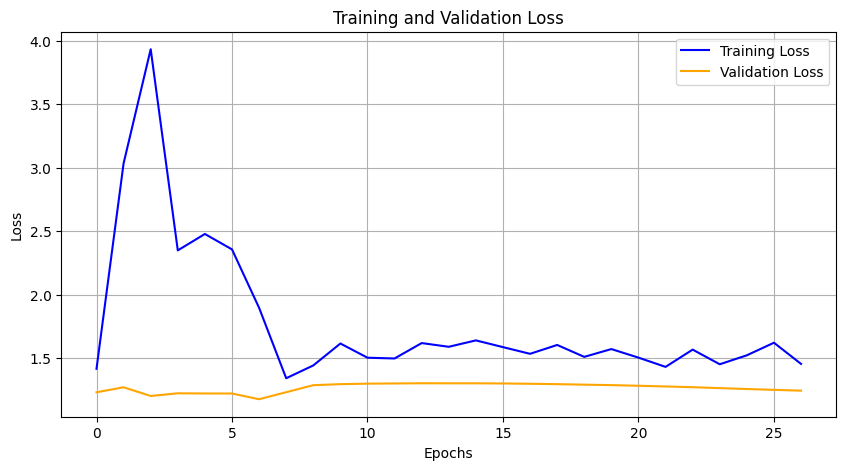

Model weights saved to model.pth
Model size: 34.00 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List, Dict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# میانگین و انحراف معیار برای نرمال‌سازی (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# افزایش تنوع داده‌ها و نرمال‌سازی
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None, dataset_type: str = None):
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.samples = []
        for class_name in allowed_classes:
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, allowed_classes.index(class_name)))

        random.seed(42)
        random.shuffle(self.samples)

        split_ratio = 0.8  # 80% train, 20% val
        split = int(len(self.samples) * split_ratio)
        if dataset_type == 'Train':
            self.samples = self.samples[:split]
        elif dataset_type == 'Val':
            self.samples = self.samples[split:]
        else:
            self.samples = self.samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2) -> Dict[str, DataLoader]:
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]  # مطمئن شوید که نام‌ها صحیح هستند
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=train_transform,
        dataset_type='Train'
    )
    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=test_transform,
        dataset_type='Val'
    )

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    if len(train_dataset) == 0 or len(val_dataset) == 0:
        raise ValueError("One of the datasets is empty. Please check the allowed_classes and dataset structure.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return {'train': train_loader, 'val': val_loader}

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(model: nn.Module, dataloader: Dict[str, DataLoader], num_epochs: int = 30, patience: int = 5, lr: float = 0.001) -> Tuple[nn.Module, List[List[float]]]:
    """
    Function to train the model.

    Input:
        model: The CNN model to be trained.
        dataloader: A dictionary containing 'train' and 'val' DataLoaders.
        num_epochs: Number of epochs to train the model for.
        patience: Patience for early stopping.
        lr: The learning rate.

    Output:
        model: Best version of the trained model.
        scores: A list containing two lists: [training_losses, validation_losses].
    """
    scores = [[], []]
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Using Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(dataloader['train']))
            swa_scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(dataloader['train'].dataset)
        scores[0].append(avg_train_loss)

        # Update SWA model
        swa_model.update_parameters(model)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader['val'], desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(dataloader['val'].dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    # Update BatchNorm statistics for SWA
    update_bn(dataloader['train'], swa_model, device=device)
    swa_model.to(device)
    swa_model.eval()

    # Replace model with SWA model
    model = swa_model

    return model, scores

# تابع رسم نمودارها
def plot_losses(scores: List[List[float]]):
    training_losses, validation_losses = scores
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "./Noisy_birds"  # مسیر به دیتاست خود را به‌روز کنید
    dataloaders = get_data_loaders(image_dir=dataset_path, batch_size=128, num_workers=4)

    model = Model()

    # آموزش مدل
    num_epochs = 100
    patience = 20
    lr = 0.001
    model, training_scores = train(model, dataloaders, num_epochs=num_epochs, patience=patience, lr=lr)

    # رسم نمودارهای خطا
    plot_losses(training_scores)

    # ذخیره بهترین مدل
    model_save_path = "model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

    # اختیاری: اعمال Quantization اگر حجم مدل بیشتر از ۷۰ مگابایت باشد
    if model_size > 70:
        def quantize_model(model):
            model.eval()
            quantized_model = torch.quantization.quantize_dynamic(
                model, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
            )
            return quantized_model

        quantized_model = quantize_model(model)
        quantized_model_save_path = "quantized_model.pth"
        torch.save(quantized_model.state_dict(), quantized_model_save_path)
        print(f'Quantized model weights saved to {quantized_model_save_path}')

        # بررسی حجم مدل کوانتیزه شده
        quantized_model_size = os.path.getsize(quantized_model_save_path) / (1024 * 1024)
        print(f"Quantized Model size: {quantized_model_size:.2f} MB")
        if quantized_model_size > 70:
            print("Warning: Quantized model size still exceeds 70 MB!")
        else:
            print("Quantized model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


#v15

In [ ]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # افزایش تعداد فیلترها و افزودن لایه‌های کانولوشنی بیشتر
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32 فیلتر
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64 فیلتر
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 فیلتر
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 256 فیلتر

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # براساس ابعاد خروجی پس از لایه‌های کانولوشنی
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)  # خروجی برای ۴ کلاس

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth", weights_only=True))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # عبور پیش‌رو
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)  # کاهش ابعاد به 64x64

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)  # کاهش ابعاد به 32x32

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)  # کاهش ابعاد به 16x16

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # کاهش ابعاد به 8x8

        # صاف کردن تنسور برای لایه‌های Fully Connected
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # اعمال Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


Using device: cuda:0
Number of training samples: 88
Number of validation samples: 22


Epoch 1/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]



Epoch 1/100, Training Loss: 1.3630, Validation Loss: 1.2500
F1 Score on Validation set: 0.3333, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 2/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 2/100, Training Loss: 3.3449, Validation Loss: 1.1777
F1 Score on Validation set: 0.1939, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 3/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]



Epoch 3/100, Training Loss: 5.4494, Validation Loss: 1.1650
F1 Score on Validation set: 0.3333, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 4/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Epoch 4/100, Training Loss: 3.2434, Validation Loss: 1.2636
F1 Score on Validation set: 0.3371, Accuracy on Validation set: 0.4091
No improvement in validation loss for 1 epochs.



Epoch 5/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]



Epoch 5/100, Training Loss: 2.6730, Validation Loss: 1.3534
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 2 epochs.



Epoch 6/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]



Epoch 6/100, Training Loss: 2.6642, Validation Loss: 1.3747
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 3 epochs.



Epoch 7/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]



Epoch 7/100, Training Loss: 2.6614, Validation Loss: 1.2395
F1 Score on Validation set: 0.1659, Accuracy on Validation set: 0.2273
No improvement in validation loss for 4 epochs.



Epoch 8/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]



Epoch 8/100, Training Loss: 1.8556, Validation Loss: 1.1724
F1 Score on Validation set: 0.3620, Accuracy on Validation set: 0.4091
No improvement in validation loss for 5 epochs.



Epoch 9/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Epoch 9/100, Training Loss: 1.9149, Validation Loss: 1.1483
F1 Score on Validation set: 0.4199, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 10/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Epoch 10/100, Training Loss: 1.9210, Validation Loss: 1.1441
F1 Score on Validation set: 0.4641, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 11/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Epoch 11/100, Training Loss: 1.8484, Validation Loss: 1.1436
F1 Score on Validation set: 0.4641, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 12/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Epoch 12/100, Training Loss: 1.8346, Validation Loss: 1.1426
F1 Score on Validation set: 0.4641, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 13/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



Epoch 13/100, Training Loss: 1.7840, Validation Loss: 1.1409
F1 Score on Validation set: 0.4225, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 14/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Epoch 14/100, Training Loss: 1.6637, Validation Loss: 1.1391
F1 Score on Validation set: 0.4225, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 15/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Epoch 15/100, Training Loss: 1.7608, Validation Loss: 1.1390
F1 Score on Validation set: 0.4225, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 16/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]



Epoch 16/100, Training Loss: 1.5514, Validation Loss: 1.1382
F1 Score on Validation set: 0.4225, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 17/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 17/100, Training Loss: 1.8716, Validation Loss: 1.1381
F1 Score on Validation set: 0.4225, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 18/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Epoch 18/100, Training Loss: 1.7699, Validation Loss: 1.1404
F1 Score on Validation set: 0.4225, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 19/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Epoch 19/100, Training Loss: 1.8522, Validation Loss: 1.1450
F1 Score on Validation set: 0.4531, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 20/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]



Epoch 20/100, Training Loss: 1.5894, Validation Loss: 1.1458
F1 Score on Validation set: 0.4531, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 21/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]



Epoch 21/100, Training Loss: 1.7905, Validation Loss: 1.1473
F1 Score on Validation set: 0.4531, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 22/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]



Epoch 22/100, Training Loss: 1.6871, Validation Loss: 1.1505
F1 Score on Validation set: 0.4531, Accuracy on Validation set: 0.5000
No improvement in validation loss for 5 epochs.



Epoch 23/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]



Epoch 23/100, Training Loss: 1.7017, Validation Loss: 1.1516
F1 Score on Validation set: 0.4002, Accuracy on Validation set: 0.4545
No improvement in validation loss for 6 epochs.



Epoch 24/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



Epoch 24/100, Training Loss: 1.8255, Validation Loss: 1.1553
F1 Score on Validation set: 0.4002, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 25/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



Epoch 25/100, Training Loss: 1.7508, Validation Loss: 1.1563
F1 Score on Validation set: 0.4316, Accuracy on Validation set: 0.5000
No improvement in validation loss for 8 epochs.



Epoch 26/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]



Epoch 26/100, Training Loss: 1.5114, Validation Loss: 1.1592
F1 Score on Validation set: 0.4316, Accuracy on Validation set: 0.5000
No improvement in validation loss for 9 epochs.



Epoch 27/100 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/100 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Epoch 27/100, Training Loss: 1.7255, Validation Loss: 1.1669
F1 Score on Validation set: 0.3661, Accuracy on Validation set: 0.4545
No improvement in validation loss for 10 epochs.

Early stopping triggered after 27 epochs.

Best model loaded based on validation loss.



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


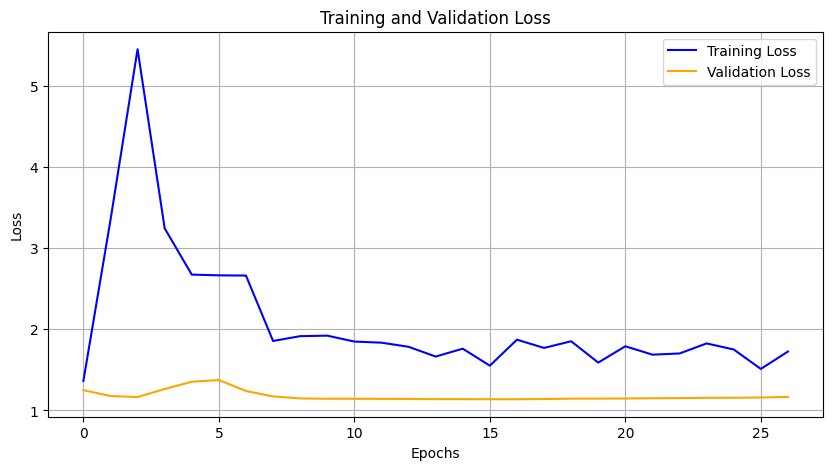

Model weights saved to model.pth
Model size: 34.00 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List, Dict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# میانگین و انحراف معیار برای نرمال‌سازی (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# افزایش تنوع داده‌ها و نرمال‌سازی
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None, dataset_type: str = None):
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.samples = []
        for class_name in allowed_classes:
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, allowed_classes.index(class_name)))

        random.seed(42)
        random.shuffle(self.samples)

        split_ratio = 0.8  # 80% train, 20% val
        split = int(len(self.samples) * split_ratio)
        if dataset_type == 'Train':
            self.samples = self.samples[:split]
        elif dataset_type == 'Val':
            self.samples = self.samples[split:]
        else:
            self.samples = self.samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2) -> Dict[str, DataLoader]:
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]  # مطمئن شوید که نام‌ها صحیح هستند
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=train_transform,
        dataset_type='Train'
    )
    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=test_transform,
        dataset_type='Val'
    )

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    if len(train_dataset) == 0 or len(val_dataset) == 0:
        raise ValueError("One of the datasets is empty. Please check the allowed_classes and dataset structure.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return {'train': train_loader, 'val': val_loader}

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(model: nn.Module, dataloader: Dict[str, DataLoader], num_epochs: int = 30, patience: int = 5, lr: float = 0.001) -> Tuple[nn.Module, List[List[float]]]:
    """
    Function to train the model.

    Input:
        model: The CNN model to be trained.
        dataloader: A dictionary containing 'train' and 'val' DataLoaders.
        num_epochs: Number of epochs to train the model for.
        patience: Patience for early stopping.
        lr: The learning rate.

    Output:
        model: Best version of the trained model.
        scores: A list containing two lists: [training_losses, validation_losses].
    """
    scores = [[], []]
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Using Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(dataloader['train']))
            swa_scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(dataloader['train'].dataset)
        scores[0].append(avg_train_loss)

        # Update SWA model
        swa_model.update_parameters(model)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader['val'], desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(dataloader['val'].dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    # Update BatchNorm statistics for SWA
    update_bn(dataloader['train'], swa_model, device=device)
    swa_model.to(device)
    swa_model.eval()

    # Replace model with SWA model
    model = swa_model

    return model, scores

# تابع رسم نمودارها
def plot_losses(scores: List[List[float]]):
    training_losses, validation_losses = scores
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "./Noisy_birds"  # مسیر به دیتاست خود را به‌روز کنید
    dataloaders = get_data_loaders(image_dir=dataset_path, batch_size=128, num_workers=4)

    model = Model()

    # آموزش مدل
    num_epochs = 100
    patience = 10
    lr = 0.001
    model, training_scores = train(model, dataloaders, num_epochs=num_epochs, patience=patience, lr=lr)

    # رسم نمودارهای خطا
    plot_losses(training_scores)

    # ذخیره بهترین مدل
    model_save_path = "model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

    # اختیاری: اعمال Quantization اگر حجم مدل بیشتر از ۷۰ مگابایت باشد
    if model_size > 70:
        def quantize_model(model):
            model.eval()
            quantized_model = torch.quantization.quantize_dynamic(
                model, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
            )
            return quantized_model

        quantized_model = quantize_model(model)
        quantized_model_save_path = "quantized_model.pth"
        torch.save(quantized_model.state_dict(), quantized_model_save_path)
        print(f'Quantized model weights saved to {quantized_model_save_path}')

        # بررسی حجم مدل کوانتیزه شده
        quantized_model_size = os.path.getsize(quantized_model_save_path) / (1024 * 1024)
        print(f"Quantized Model size: {quantized_model_size:.2f} MB")
        if quantized_model_size > 70:
            print("Warning: Quantized model size still exceeds 70 MB!")
        else:
            print("Quantized model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


#v16

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # بارگذاری مدل پیش‌آموزش‌شده ResNet18
        self.base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # فریز کردن تمام پارامترهای مدل پایه
        for param in self.base_model.parameters():
            param.requires_grad = False

        # جایگزینی لایه Fully Connected نهایی با لایه‌های جدید برای ۴ کلاس
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth"))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.base_model(x)


Using device: cuda:0
Number of training samples: 88
Number of validation samples: 22
Training samples per class:
{'budgie': 28, 'canary': 31, 'duckling': 29, 'rubber_duck': 0}

Validation samples per class:
{'budgie': 11, 'canary': 3, 'duckling': 8, 'rubber_duck': 0}


Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]



Epoch 1/300, Training Loss: 1.4466, Validation Loss: 1.4455
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 2/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 2/300, Training Loss: 1.2501, Validation Loss: 1.4314
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 3/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]



Epoch 3/300, Training Loss: 1.2767, Validation Loss: 1.2310
F1 Score on Validation set: 0.4592, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 4/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 4/300, Training Loss: 1.1595, Validation Loss: 1.1937
F1 Score on Validation set: 0.4797, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 5/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 5/300, Training Loss: 1.2178, Validation Loss: 1.1908
F1 Score on Validation set: 0.4206, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 6/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



Epoch 6/300, Training Loss: 1.1683, Validation Loss: 1.1877
F1 Score on Validation set: 0.4206, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 7/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



Epoch 7/300, Training Loss: 1.2130, Validation Loss: 1.2342
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 8/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]



Epoch 8/300, Training Loss: 1.2237, Validation Loss: 1.2913
F1 Score on Validation set: 0.3693, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 9/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]



Epoch 9/300, Training Loss: 1.2122, Validation Loss: 1.2995
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 3 epochs.



Epoch 10/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]



Epoch 10/300, Training Loss: 1.2347, Validation Loss: 1.2857
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 4 epochs.



Epoch 11/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]



Epoch 11/300, Training Loss: 1.1641, Validation Loss: 1.2804
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 5 epochs.



Epoch 12/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]



Epoch 12/300, Training Loss: 1.2217, Validation Loss: 1.2763
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 6 epochs.



Epoch 13/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 13/300, Training Loss: 1.1515, Validation Loss: 1.2718
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 7 epochs.



Epoch 14/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



Epoch 14/300, Training Loss: 1.1035, Validation Loss: 1.2693
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 8 epochs.



Epoch 15/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]



Epoch 15/300, Training Loss: 1.1456, Validation Loss: 1.2644
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 9 epochs.



Epoch 16/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Epoch 16/300, Training Loss: 1.1560, Validation Loss: 1.2631
F1 Score on Validation set: 0.3407, Accuracy on Validation set: 0.4091
No improvement in validation loss for 10 epochs.



Epoch 17/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Epoch 17/300, Training Loss: 1.1311, Validation Loss: 1.2597
F1 Score on Validation set: 0.3090, Accuracy on Validation set: 0.3636
No improvement in validation loss for 11 epochs.



Epoch 18/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



Epoch 18/300, Training Loss: 1.1256, Validation Loss: 1.2596
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 12 epochs.



Epoch 19/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 19/300, Training Loss: 1.2008, Validation Loss: 1.2558
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 13 epochs.



Epoch 20/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Epoch 20/300, Training Loss: 1.1049, Validation Loss: 1.2538
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 14 epochs.



Epoch 21/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



Epoch 21/300, Training Loss: 1.1850, Validation Loss: 1.2482
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 15 epochs.



Epoch 22/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]



Epoch 22/300, Training Loss: 1.1342, Validation Loss: 1.2454
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 16 epochs.



Epoch 23/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Epoch 23/300, Training Loss: 1.1855, Validation Loss: 1.2408
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 17 epochs.



Epoch 24/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]



Epoch 24/300, Training Loss: 1.0987, Validation Loss: 1.2376
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 18 epochs.



Epoch 25/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]



Epoch 25/300, Training Loss: 1.1557, Validation Loss: 1.2361
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 19 epochs.



Epoch 26/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]



Epoch 26/300, Training Loss: 1.1267, Validation Loss: 1.2333
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 20 epochs.



Epoch 27/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]



Epoch 27/300, Training Loss: 1.2205, Validation Loss: 1.2301
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 21 epochs.



Epoch 28/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Epoch 28/300, Training Loss: 1.1356, Validation Loss: 1.2285
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 22 epochs.



Epoch 29/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



Epoch 29/300, Training Loss: 1.1642, Validation Loss: 1.2240
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 23 epochs.



Epoch 30/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 30/300, Training Loss: 1.1146, Validation Loss: 1.2214
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 24 epochs.



Epoch 31/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 31/300, Training Loss: 1.1366, Validation Loss: 1.2189
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 25 epochs.



Epoch 32/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Epoch 32/300, Training Loss: 1.1244, Validation Loss: 1.2195
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 26 epochs.



Epoch 33/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]



Epoch 33/300, Training Loss: 1.1528, Validation Loss: 1.2183
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 27 epochs.



Epoch 34/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



Epoch 34/300, Training Loss: 1.2356, Validation Loss: 1.2172
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 28 epochs.



Epoch 35/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



Epoch 35/300, Training Loss: 1.1035, Validation Loss: 1.2163
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 29 epochs.



Epoch 36/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



Epoch 36/300, Training Loss: 1.0985, Validation Loss: 1.2129
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 30 epochs.



Epoch 37/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Epoch 37/300, Training Loss: 1.2266, Validation Loss: 1.2112
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 31 epochs.



Epoch 38/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Epoch 38/300, Training Loss: 1.1093, Validation Loss: 1.2084
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 32 epochs.



Epoch 39/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]



Epoch 39/300, Training Loss: 1.2078, Validation Loss: 1.2086
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 33 epochs.



Epoch 40/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]



Epoch 40/300, Training Loss: 1.1799, Validation Loss: 1.2063
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 34 epochs.



Epoch 41/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]



Epoch 41/300, Training Loss: 1.1428, Validation Loss: 1.2065
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 35 epochs.



Epoch 42/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]



Epoch 42/300, Training Loss: 1.1514, Validation Loss: 1.2052
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 36 epochs.



Epoch 43/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 43/300, Training Loss: 1.1644, Validation Loss: 1.2033
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 37 epochs.



Epoch 44/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Epoch 44/300, Training Loss: 1.1833, Validation Loss: 1.1997
F1 Score on Validation set: 0.3598, Accuracy on Validation set: 0.4545
No improvement in validation loss for 38 epochs.



Epoch 45/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 45/300, Training Loss: 1.1525, Validation Loss: 1.1973
F1 Score on Validation set: 0.3598, Accuracy on Validation set: 0.4545
No improvement in validation loss for 39 epochs.



Epoch 46/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



Epoch 46/300, Training Loss: 1.0812, Validation Loss: 1.1968
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 40 epochs.



Epoch 47/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



Epoch 47/300, Training Loss: 1.1372, Validation Loss: 1.1953
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 41 epochs.



Epoch 48/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 48/300, Training Loss: 1.1935, Validation Loss: 1.1929
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 42 epochs.



Epoch 49/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]



Epoch 49/300, Training Loss: 1.1130, Validation Loss: 1.1922
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 43 epochs.



Epoch 50/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Epoch 50/300, Training Loss: 1.1311, Validation Loss: 1.1920
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 44 epochs.



Epoch 51/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



Epoch 51/300, Training Loss: 1.1073, Validation Loss: 1.1911
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 45 epochs.



Epoch 52/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 52/300, Training Loss: 1.1516, Validation Loss: 1.1917
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 46 epochs.



Epoch 53/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 53/300, Training Loss: 1.1268, Validation Loss: 1.1907
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
No improvement in validation loss for 47 epochs.



Epoch 54/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 54/300, Training Loss: 1.1875, Validation Loss: 1.1869
F1 Score on Validation set: 0.3598, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 55/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]



Epoch 55/300, Training Loss: 1.1124, Validation Loss: 1.1859
F1 Score on Validation set: 0.3324, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 56/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 56/300, Training Loss: 1.1985, Validation Loss: 1.1860
F1 Score on Validation set: 0.3324, Accuracy on Validation set: 0.4091
No improvement in validation loss for 1 epochs.



Epoch 57/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



Epoch 57/300, Training Loss: 1.0975, Validation Loss: 1.1841
F1 Score on Validation set: 0.3056, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 58/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 58/300, Training Loss: 1.1390, Validation Loss: 1.1834
F1 Score on Validation set: 0.3056, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 59/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]



Epoch 59/300, Training Loss: 1.1209, Validation Loss: 1.1810
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 60/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]



Epoch 60/300, Training Loss: 1.1222, Validation Loss: 1.1795
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 61/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 61/300, Training Loss: 1.1679, Validation Loss: 1.1774
F1 Score on Validation set: 0.3350, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 62/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 62/300, Training Loss: 1.0809, Validation Loss: 1.1776
F1 Score on Validation set: 0.4093, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 63/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



Epoch 63/300, Training Loss: 1.2119, Validation Loss: 1.1769
F1 Score on Validation set: 0.4032, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 64/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



Epoch 64/300, Training Loss: 1.0998, Validation Loss: 1.1770
F1 Score on Validation set: 0.4093, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 65/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Epoch 65/300, Training Loss: 1.2333, Validation Loss: 1.1745
F1 Score on Validation set: 0.4032, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 66/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]



Epoch 66/300, Training Loss: 1.1191, Validation Loss: 1.1742
F1 Score on Validation set: 0.3753, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 67/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 67/300, Training Loss: 1.1116, Validation Loss: 1.1747
F1 Score on Validation set: 0.3715, Accuracy on Validation set: 0.4091
No improvement in validation loss for 1 epochs.



Epoch 68/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 68/300, Training Loss: 1.1248, Validation Loss: 1.1723
F1 Score on Validation set: 0.4093, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 69/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Epoch 69/300, Training Loss: 1.1425, Validation Loss: 1.1732
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 70/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Epoch 70/300, Training Loss: 1.1810, Validation Loss: 1.1740
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 71/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Epoch 71/300, Training Loss: 1.0972, Validation Loss: 1.1722
F1 Score on Validation set: 0.3715, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 72/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Epoch 72/300, Training Loss: 1.1055, Validation Loss: 1.1697
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 73/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Epoch 73/300, Training Loss: 1.1449, Validation Loss: 1.1693
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 74/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]



Epoch 74/300, Training Loss: 1.1036, Validation Loss: 1.1684
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 75/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]



Epoch 75/300, Training Loss: 1.1638, Validation Loss: 1.1666
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 76/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Epoch 76/300, Training Loss: 1.1492, Validation Loss: 1.1667
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 77/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



Epoch 77/300, Training Loss: 1.1598, Validation Loss: 1.1673
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 78/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 78/300, Training Loss: 1.1511, Validation Loss: 1.1644
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 79/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]



Epoch 79/300, Training Loss: 1.0858, Validation Loss: 1.1624
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 80/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]



Epoch 80/300, Training Loss: 1.1601, Validation Loss: 1.1613
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 81/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Epoch 81/300, Training Loss: 1.1015, Validation Loss: 1.1600
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 82/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]



Epoch 82/300, Training Loss: 1.1241, Validation Loss: 1.1595
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 83/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 83/300, Training Loss: 1.1176, Validation Loss: 1.1599
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 84/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch 84/300, Training Loss: 1.1908, Validation Loss: 1.1603
F1 Score on Validation set: 0.3455, Accuracy on Validation set: 0.4091
No improvement in validation loss for 2 epochs.



Epoch 85/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]



Epoch 85/300, Training Loss: 1.1442, Validation Loss: 1.1598
F1 Score on Validation set: 0.3455, Accuracy on Validation set: 0.4091
No improvement in validation loss for 3 epochs.



Epoch 86/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]



Epoch 86/300, Training Loss: 1.0797, Validation Loss: 1.1573
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 87/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]



Epoch 87/300, Training Loss: 1.2030, Validation Loss: 1.1583
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 88/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]



Epoch 88/300, Training Loss: 1.1270, Validation Loss: 1.1575
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 89/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 89/300, Training Loss: 1.1058, Validation Loss: 1.1560
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 90/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]



Epoch 90/300, Training Loss: 1.1166, Validation Loss: 1.1569
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 91/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]



Epoch 91/300, Training Loss: 1.1446, Validation Loss: 1.1556
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 92/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



Epoch 92/300, Training Loss: 1.0931, Validation Loss: 1.1533
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 93/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]



Epoch 93/300, Training Loss: 1.1594, Validation Loss: 1.1542
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 94/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Epoch 94/300, Training Loss: 1.1078, Validation Loss: 1.1541
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 95/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Epoch 95/300, Training Loss: 1.1049, Validation Loss: 1.1532
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 96/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]



Epoch 96/300, Training Loss: 1.1042, Validation Loss: 1.1544
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 97/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]



Epoch 97/300, Training Loss: 1.2270, Validation Loss: 1.1557
F1 Score on Validation set: 0.3455, Accuracy on Validation set: 0.4091
No improvement in validation loss for 2 epochs.



Epoch 98/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 98/300, Training Loss: 1.0667, Validation Loss: 1.1543
F1 Score on Validation set: 0.3756, Accuracy on Validation set: 0.4545
No improvement in validation loss for 3 epochs.



Epoch 99/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]



Epoch 99/300, Training Loss: 1.2033, Validation Loss: 1.1567
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 4 epochs.



Epoch 100/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Epoch 100/300, Training Loss: 1.1401, Validation Loss: 1.1559
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 5 epochs.



Epoch 101/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 101/300, Training Loss: 1.2048, Validation Loss: 1.1565
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 6 epochs.



Epoch 102/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 102/300, Training Loss: 1.1122, Validation Loss: 1.1539
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 103/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]



Epoch 103/300, Training Loss: 1.0364, Validation Loss: 1.1541
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 104/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]



Epoch 104/300, Training Loss: 1.1354, Validation Loss: 1.1531
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 105/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 105/300, Training Loss: 1.1352, Validation Loss: 1.1519
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 106/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]



Epoch 106/300, Training Loss: 1.0970, Validation Loss: 1.1507
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 107/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]



Epoch 107/300, Training Loss: 1.2126, Validation Loss: 1.1520
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 108/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 108/300, Training Loss: 1.1131, Validation Loss: 1.1519
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 109/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



Epoch 109/300, Training Loss: 1.1382, Validation Loss: 1.1495
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 110/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Epoch 110/300, Training Loss: 1.1040, Validation Loss: 1.1506
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 111/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]



Epoch 111/300, Training Loss: 1.1445, Validation Loss: 1.1495
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 112/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]



Epoch 112/300, Training Loss: 1.1948, Validation Loss: 1.1494
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 113/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 113/300, Training Loss: 1.2187, Validation Loss: 1.1509
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 114/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 114/300, Training Loss: 1.2138, Validation Loss: 1.1533
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 115/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]



Epoch 115/300, Training Loss: 1.1673, Validation Loss: 1.1540
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 3 epochs.



Epoch 116/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Epoch 116/300, Training Loss: 1.1788, Validation Loss: 1.1542
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 4 epochs.



Epoch 117/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 117/300, Training Loss: 1.0838, Validation Loss: 1.1550
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 5 epochs.



Epoch 118/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]



Epoch 118/300, Training Loss: 1.1409, Validation Loss: 1.1558
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 6 epochs.



Epoch 119/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]



Epoch 119/300, Training Loss: 1.1798, Validation Loss: 1.1552
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 120/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]



Epoch 120/300, Training Loss: 1.1766, Validation Loss: 1.1549
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 121/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 121/300, Training Loss: 1.1426, Validation Loss: 1.1553
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 9 epochs.



Epoch 122/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]



Epoch 122/300, Training Loss: 1.1742, Validation Loss: 1.1561
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 10 epochs.



Epoch 123/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



Epoch 123/300, Training Loss: 1.1174, Validation Loss: 1.1553
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 11 epochs.



Epoch 124/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]



Epoch 124/300, Training Loss: 1.1394, Validation Loss: 1.1551
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 12 epochs.



Epoch 125/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Epoch 125/300, Training Loss: 1.1754, Validation Loss: 1.1550
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 13 epochs.



Epoch 126/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 126/300, Training Loss: 1.1109, Validation Loss: 1.1538
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 14 epochs.



Epoch 127/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 127/300, Training Loss: 1.0691, Validation Loss: 1.1513
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 15 epochs.



Epoch 128/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



Epoch 128/300, Training Loss: 1.2071, Validation Loss: 1.1540
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 16 epochs.



Epoch 129/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 129/300, Training Loss: 1.1527, Validation Loss: 1.1539
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 17 epochs.



Epoch 130/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Epoch 130/300, Training Loss: 1.1707, Validation Loss: 1.1518
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 18 epochs.



Epoch 131/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Epoch 131/300, Training Loss: 1.0943, Validation Loss: 1.1496
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 19 epochs.



Epoch 132/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Epoch 132/300, Training Loss: 1.0960, Validation Loss: 1.1501
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
No improvement in validation loss for 20 epochs.



Epoch 133/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]



Epoch 133/300, Training Loss: 1.0930, Validation Loss: 1.1472
F1 Score on Validation set: 0.3715, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 134/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]



Epoch 134/300, Training Loss: 1.1408, Validation Loss: 1.1463
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 135/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]



Epoch 135/300, Training Loss: 1.1514, Validation Loss: 1.1467
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 136/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]



Epoch 136/300, Training Loss: 1.1079, Validation Loss: 1.1468
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 137/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]



Epoch 137/300, Training Loss: 1.1851, Validation Loss: 1.1473
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 3 epochs.



Epoch 138/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Epoch 138/300, Training Loss: 1.1649, Validation Loss: 1.1494
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 4 epochs.



Epoch 139/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 139/300, Training Loss: 1.1125, Validation Loss: 1.1479
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 5 epochs.



Epoch 140/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Epoch 140/300, Training Loss: 1.0445, Validation Loss: 1.1478
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 6 epochs.



Epoch 141/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 141/300, Training Loss: 1.1896, Validation Loss: 1.1489
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 7 epochs.



Epoch 142/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]



Epoch 142/300, Training Loss: 1.0730, Validation Loss: 1.1468
F1 Score on Validation set: 0.4032, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 143/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Epoch 143/300, Training Loss: 1.1789, Validation Loss: 1.1482
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 9 epochs.



Epoch 144/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]



Epoch 144/300, Training Loss: 1.1408, Validation Loss: 1.1474
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 10 epochs.



Epoch 145/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 145/300, Training Loss: 1.1317, Validation Loss: 1.1502
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 11 epochs.



Epoch 146/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 146/300, Training Loss: 1.0879, Validation Loss: 1.1493
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 12 epochs.



Epoch 147/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 147/300, Training Loss: 1.1268, Validation Loss: 1.1498
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 13 epochs.



Epoch 148/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]



Epoch 148/300, Training Loss: 1.1456, Validation Loss: 1.1498
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 14 epochs.



Epoch 149/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 149/300, Training Loss: 1.0910, Validation Loss: 1.1487
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 15 epochs.



Epoch 150/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Epoch 150/300, Training Loss: 1.0958, Validation Loss: 1.1483
F1 Score on Validation set: 0.4004, Accuracy on Validation set: 0.4545
No improvement in validation loss for 16 epochs.



Epoch 151/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]



Epoch 151/300, Training Loss: 1.1101, Validation Loss: 1.1481
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 17 epochs.



Epoch 152/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Epoch 152/300, Training Loss: 1.1086, Validation Loss: 1.1485
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 18 epochs.



Epoch 153/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Epoch 153/300, Training Loss: 1.1687, Validation Loss: 1.1488
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 19 epochs.



Epoch 154/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Epoch 154/300, Training Loss: 1.1304, Validation Loss: 1.1461
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 155/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 155/300, Training Loss: 1.0979, Validation Loss: 1.1455
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 156/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 156/300, Training Loss: 1.0485, Validation Loss: 1.1466
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 157/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 157/300, Training Loss: 1.1176, Validation Loss: 1.1455
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 158/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]



Epoch 158/300, Training Loss: 1.0682, Validation Loss: 1.1457
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 159/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Epoch 159/300, Training Loss: 1.0571, Validation Loss: 1.1444
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 160/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Epoch 160/300, Training Loss: 1.1172, Validation Loss: 1.1444
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 161/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 161/300, Training Loss: 1.0748, Validation Loss: 1.1438
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 162/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 162/300, Training Loss: 1.1800, Validation Loss: 1.1446
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 163/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]



Epoch 163/300, Training Loss: 1.1080, Validation Loss: 1.1449
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 164/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 164/300, Training Loss: 1.1036, Validation Loss: 1.1437
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 165/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



Epoch 165/300, Training Loss: 1.1101, Validation Loss: 1.1417
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 166/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 166/300, Training Loss: 1.1645, Validation Loss: 1.1432
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 167/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 167/300, Training Loss: 1.0648, Validation Loss: 1.1443
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 168/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 168/300, Training Loss: 1.1239, Validation Loss: 1.1454
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 169/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 169/300, Training Loss: 1.0606, Validation Loss: 1.1442
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 170/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Epoch 170/300, Training Loss: 1.0700, Validation Loss: 1.1434
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 5 epochs.



Epoch 171/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Epoch 171/300, Training Loss: 1.0706, Validation Loss: 1.1426
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 6 epochs.



Epoch 172/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 172/300, Training Loss: 1.1096, Validation Loss: 1.1427
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 7 epochs.



Epoch 173/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 173/300, Training Loss: 1.1092, Validation Loss: 1.1433
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 8 epochs.



Epoch 174/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Epoch 174/300, Training Loss: 1.1651, Validation Loss: 1.1435
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 9 epochs.



Epoch 175/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 175/300, Training Loss: 1.1668, Validation Loss: 1.1427
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 10 epochs.



Epoch 176/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 176/300, Training Loss: 1.0735, Validation Loss: 1.1411
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 177/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]



Epoch 177/300, Training Loss: 1.0485, Validation Loss: 1.1415
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 178/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]



Epoch 178/300, Training Loss: 1.1099, Validation Loss: 1.1400
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 179/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]



Epoch 179/300, Training Loss: 1.0582, Validation Loss: 1.1400
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 180/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]



Epoch 180/300, Training Loss: 1.0431, Validation Loss: 1.1395
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 181/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 181/300, Training Loss: 1.0316, Validation Loss: 1.1403
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 182/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]



Epoch 182/300, Training Loss: 1.0514, Validation Loss: 1.1409
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 183/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Epoch 183/300, Training Loss: 1.1095, Validation Loss: 1.1399
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 184/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 184/300, Training Loss: 1.0550, Validation Loss: 1.1396
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 185/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Epoch 185/300, Training Loss: 1.0978, Validation Loss: 1.1388
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 186/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 186/300, Training Loss: 1.1589, Validation Loss: 1.1388
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 187/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]



Epoch 187/300, Training Loss: 1.0592, Validation Loss: 1.1391
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 188/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Epoch 188/300, Training Loss: 1.1235, Validation Loss: 1.1405
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 189/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Epoch 189/300, Training Loss: 1.0931, Validation Loss: 1.1411
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 190/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



Epoch 190/300, Training Loss: 1.1088, Validation Loss: 1.1398
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 5 epochs.



Epoch 191/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 191/300, Training Loss: 1.1382, Validation Loss: 1.1394
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 6 epochs.



Epoch 192/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 192/300, Training Loss: 1.0846, Validation Loss: 1.1410
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 7 epochs.



Epoch 193/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 193/300, Training Loss: 1.0911, Validation Loss: 1.1394
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 8 epochs.



Epoch 194/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]



Epoch 194/300, Training Loss: 1.1536, Validation Loss: 1.1404
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 9 epochs.



Epoch 195/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 195/300, Training Loss: 1.0911, Validation Loss: 1.1406
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 10 epochs.



Epoch 196/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]



Epoch 196/300, Training Loss: 1.0906, Validation Loss: 1.1404
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 11 epochs.



Epoch 197/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 197/300, Training Loss: 1.1031, Validation Loss: 1.1397
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 12 epochs.



Epoch 198/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 198/300, Training Loss: 1.0275, Validation Loss: 1.1383
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 199/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



Epoch 199/300, Training Loss: 1.0808, Validation Loss: 1.1391
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 200/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]



Epoch 200/300, Training Loss: 1.0483, Validation Loss: 1.1398
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 201/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 201/300, Training Loss: 1.1558, Validation Loss: 1.1412
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 202/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Epoch 202/300, Training Loss: 1.1422, Validation Loss: 1.1433
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 203/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]



Epoch 203/300, Training Loss: 1.0755, Validation Loss: 1.1428
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 5 epochs.



Epoch 204/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



Epoch 204/300, Training Loss: 1.1374, Validation Loss: 1.1429
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 6 epochs.



Epoch 205/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Epoch 205/300, Training Loss: 1.1210, Validation Loss: 1.1422
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 206/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 206/300, Training Loss: 1.1521, Validation Loss: 1.1417
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 207/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 207/300, Training Loss: 1.1043, Validation Loss: 1.1411
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 9 epochs.



Epoch 208/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]



Epoch 208/300, Training Loss: 1.2019, Validation Loss: 1.1407
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 10 epochs.



Epoch 209/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 209/300, Training Loss: 1.0993, Validation Loss: 1.1401
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 11 epochs.



Epoch 210/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]



Epoch 210/300, Training Loss: 1.0823, Validation Loss: 1.1391
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 12 epochs.



Epoch 211/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 211/300, Training Loss: 1.1594, Validation Loss: 1.1380
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 212/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 212/300, Training Loss: 1.1423, Validation Loss: 1.1381
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 213/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Epoch 213/300, Training Loss: 1.1134, Validation Loss: 1.1385
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 214/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 214/300, Training Loss: 1.0567, Validation Loss: 1.1385
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 3 epochs.



Epoch 215/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]



Epoch 215/300, Training Loss: 1.1324, Validation Loss: 1.1361
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 216/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 216/300, Training Loss: 1.1042, Validation Loss: 1.1343
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 217/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 217/300, Training Loss: 1.1524, Validation Loss: 1.1354
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 218/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 218/300, Training Loss: 1.1198, Validation Loss: 1.1349
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 219/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Epoch 219/300, Training Loss: 1.1025, Validation Loss: 1.1351
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 3 epochs.



Epoch 220/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]



Epoch 220/300, Training Loss: 1.0463, Validation Loss: 1.1354
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 4 epochs.



Epoch 221/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]



Epoch 221/300, Training Loss: 1.1006, Validation Loss: 1.1361
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 5 epochs.



Epoch 222/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]



Epoch 222/300, Training Loss: 1.1108, Validation Loss: 1.1348
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 6 epochs.



Epoch 223/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]



Epoch 223/300, Training Loss: 1.0964, Validation Loss: 1.1360
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 224/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 224/300, Training Loss: 1.1444, Validation Loss: 1.1354
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 225/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]



Epoch 225/300, Training Loss: 1.1508, Validation Loss: 1.1366
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 9 epochs.



Epoch 226/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 226/300, Training Loss: 1.1610, Validation Loss: 1.1362
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 10 epochs.



Epoch 227/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 227/300, Training Loss: 1.0914, Validation Loss: 1.1347
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 11 epochs.



Epoch 228/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 228/300, Training Loss: 1.0492, Validation Loss: 1.1332
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 229/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 229/300, Training Loss: 1.1820, Validation Loss: 1.1358
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 230/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 230/300, Training Loss: 1.1396, Validation Loss: 1.1362
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 231/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]



Epoch 231/300, Training Loss: 1.1107, Validation Loss: 1.1372
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 3 epochs.



Epoch 232/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]



Epoch 232/300, Training Loss: 1.1163, Validation Loss: 1.1356
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 4 epochs.



Epoch 233/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 233/300, Training Loss: 1.1450, Validation Loss: 1.1346
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 5 epochs.



Epoch 234/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Epoch 234/300, Training Loss: 1.1202, Validation Loss: 1.1323
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 235/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]



Epoch 235/300, Training Loss: 1.1379, Validation Loss: 1.1335
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 1 epochs.



Epoch 236/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 236/300, Training Loss: 1.1334, Validation Loss: 1.1324
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 237/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]



Epoch 237/300, Training Loss: 1.1147, Validation Loss: 1.1320
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 238/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



Epoch 238/300, Training Loss: 1.0933, Validation Loss: 1.1300
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 239/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 239/300, Training Loss: 1.1334, Validation Loss: 1.1305
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 1 epochs.



Epoch 240/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 240/300, Training Loss: 1.0689, Validation Loss: 1.1304
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 2 epochs.



Epoch 241/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Epoch 241/300, Training Loss: 1.0525, Validation Loss: 1.1315
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 3 epochs.



Epoch 242/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 242/300, Training Loss: 1.1448, Validation Loss: 1.1293
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 243/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]



Epoch 243/300, Training Loss: 1.0891, Validation Loss: 1.1289
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 244/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



Epoch 244/300, Training Loss: 1.0783, Validation Loss: 1.1280
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 245/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 245/300, Training Loss: 1.1299, Validation Loss: 1.1265
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 246/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Epoch 246/300, Training Loss: 1.0599, Validation Loss: 1.1242
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 247/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 247/300, Training Loss: 1.0453, Validation Loss: 1.1250
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 1 epochs.



Epoch 248/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]



Epoch 248/300, Training Loss: 1.1094, Validation Loss: 1.1241
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 249/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]



Epoch 249/300, Training Loss: 1.1371, Validation Loss: 1.1238
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 250/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]



Epoch 250/300, Training Loss: 1.1473, Validation Loss: 1.1231
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 251/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 251/300, Training Loss: 1.1098, Validation Loss: 1.1237
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 1 epochs.



Epoch 252/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Epoch 252/300, Training Loss: 1.1089, Validation Loss: 1.1239
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 2 epochs.



Epoch 253/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 253/300, Training Loss: 1.0509, Validation Loss: 1.1249
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 3 epochs.



Epoch 254/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Epoch 254/300, Training Loss: 1.0414, Validation Loss: 1.1257
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 4 epochs.



Epoch 255/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 255/300, Training Loss: 1.1151, Validation Loss: 1.1263
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 5 epochs.



Epoch 256/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Epoch 256/300, Training Loss: 1.1303, Validation Loss: 1.1269
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 6 epochs.



Epoch 257/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Epoch 257/300, Training Loss: 1.1503, Validation Loss: 1.1268
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 258/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



Epoch 258/300, Training Loss: 1.1151, Validation Loss: 1.1275
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 259/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



Epoch 259/300, Training Loss: 1.1255, Validation Loss: 1.1274
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 9 epochs.



Epoch 260/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 260/300, Training Loss: 1.0260, Validation Loss: 1.1262
F1 Score on Validation set: 0.4352, Accuracy on Validation set: 0.5000
No improvement in validation loss for 10 epochs.



Epoch 261/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



Epoch 261/300, Training Loss: 1.1609, Validation Loss: 1.1257
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 11 epochs.



Epoch 262/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]



Epoch 262/300, Training Loss: 1.0536, Validation Loss: 1.1248
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 12 epochs.



Epoch 263/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]



Epoch 263/300, Training Loss: 1.1131, Validation Loss: 1.1263
F1 Score on Validation set: 0.4352, Accuracy on Validation set: 0.5000
No improvement in validation loss for 13 epochs.



Epoch 264/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Epoch 264/300, Training Loss: 1.1506, Validation Loss: 1.1261
F1 Score on Validation set: 0.4352, Accuracy on Validation set: 0.5000
No improvement in validation loss for 14 epochs.



Epoch 265/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 265/300, Training Loss: 1.0716, Validation Loss: 1.1251
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 15 epochs.



Epoch 266/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 266/300, Training Loss: 1.1476, Validation Loss: 1.1249
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 16 epochs.



Epoch 267/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 267/300, Training Loss: 1.0901, Validation Loss: 1.1243
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
No improvement in validation loss for 17 epochs.



Epoch 268/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 268/300, Training Loss: 1.1893, Validation Loss: 1.1245
F1 Score on Validation set: 0.4352, Accuracy on Validation set: 0.5000
No improvement in validation loss for 18 epochs.



Epoch 269/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 269/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 269/300, Training Loss: 1.1470, Validation Loss: 1.1237
F1 Score on Validation set: 0.4352, Accuracy on Validation set: 0.5000
No improvement in validation loss for 19 epochs.



Epoch 270/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 270/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 270/300, Training Loss: 1.0636, Validation Loss: 1.1226
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 271/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 271/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 271/300, Training Loss: 1.0960, Validation Loss: 1.1221
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 272/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 272/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 272/300, Training Loss: 1.0763, Validation Loss: 1.1201
F1 Score on Validation set: 0.5022, Accuracy on Validation set: 0.5455
Validation loss improved. Saving best model state.



Epoch 273/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 273/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Epoch 273/300, Training Loss: 1.1491, Validation Loss: 1.1215
F1 Score on Validation set: 0.4352, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 274/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 274/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 274/300, Training Loss: 1.1603, Validation Loss: 1.1230
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 2 epochs.



Epoch 275/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 275/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]



Epoch 275/300, Training Loss: 1.1106, Validation Loss: 1.1234
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 3 epochs.



Epoch 276/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 276/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



Epoch 276/300, Training Loss: 1.1301, Validation Loss: 1.1257
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 4 epochs.



Epoch 277/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 277/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]



Epoch 277/300, Training Loss: 1.1325, Validation Loss: 1.1264
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 5 epochs.



Epoch 278/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 278/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Epoch 278/300, Training Loss: 1.1008, Validation Loss: 1.1283
F1 Score on Validation set: 0.3280, Accuracy on Validation set: 0.4091
No improvement in validation loss for 6 epochs.



Epoch 279/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 279/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 279/300, Training Loss: 1.0261, Validation Loss: 1.1282
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 7 epochs.



Epoch 280/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 280/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 280/300, Training Loss: 1.0771, Validation Loss: 1.1262
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 8 epochs.



Epoch 281/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 281/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]



Epoch 281/300, Training Loss: 1.0740, Validation Loss: 1.1265
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 9 epochs.



Epoch 282/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 282/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Epoch 282/300, Training Loss: 1.0354, Validation Loss: 1.1248
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 10 epochs.



Epoch 283/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 283/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Epoch 283/300, Training Loss: 1.0717, Validation Loss: 1.1255
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 11 epochs.



Epoch 284/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 284/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 284/300, Training Loss: 1.0770, Validation Loss: 1.1245
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 12 epochs.



Epoch 285/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 285/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 285/300, Training Loss: 1.0404, Validation Loss: 1.1237
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 13 epochs.



Epoch 286/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 286/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 286/300, Training Loss: 1.0985, Validation Loss: 1.1238
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 14 epochs.



Epoch 287/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 287/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 287/300, Training Loss: 1.0862, Validation Loss: 1.1206
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 15 epochs.



Epoch 288/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 288/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 288/300, Training Loss: 1.1013, Validation Loss: 1.1209
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
No improvement in validation loss for 16 epochs.



Epoch 289/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 289/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 289/300, Training Loss: 1.0749, Validation Loss: 1.1205
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 17 epochs.



Epoch 290/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 290/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]



Epoch 290/300, Training Loss: 1.0347, Validation Loss: 1.1191
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 291/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 291/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]



Epoch 291/300, Training Loss: 1.0219, Validation Loss: 1.1190
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 292/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 292/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 292/300, Training Loss: 1.0723, Validation Loss: 1.1183
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 293/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 293/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 293/300, Training Loss: 1.0448, Validation Loss: 1.1186
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 294/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 294/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]



Epoch 294/300, Training Loss: 1.0485, Validation Loss: 1.1192
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 295/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 295/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch 295/300, Training Loss: 1.0843, Validation Loss: 1.1198
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.



Epoch 296/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 296/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]



Epoch 296/300, Training Loss: 1.1687, Validation Loss: 1.1180
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
Validation loss improved. Saving best model state.



Epoch 297/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 297/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 297/300, Training Loss: 1.1534, Validation Loss: 1.1169
F1 Score on Validation set: 0.3550, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 298/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 298/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 298/300, Training Loss: 1.0847, Validation Loss: 1.1178
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 1 epochs.



Epoch 299/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 299/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 299/300, Training Loss: 1.0532, Validation Loss: 1.1182
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 2 epochs.



Epoch 300/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 300/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch 300/300, Training Loss: 1.0836, Validation Loss: 1.1180
F1 Score on Validation set: 0.4320, Accuracy on Validation set: 0.5000
No improvement in validation loss for 3 epochs.

Best model loaded based on validation loss.




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


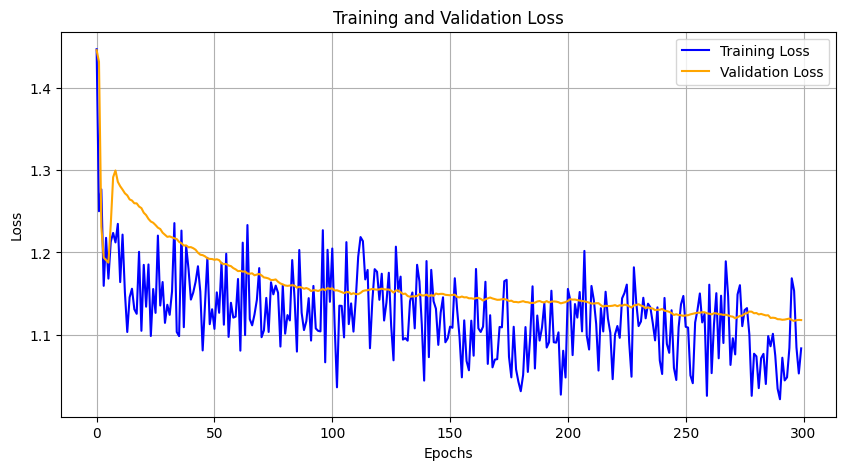

Model weights saved to model.pth
Model size: 43.21 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List, Dict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تنظیم بذر برای قابلیت تکرارپذیری
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# میانگین و انحراف معیار برای نرمال‌سازی (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# افزایش تنوع داده‌ها و نرمال‌سازی
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None, dataset_type: str = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            allowed_classes (List[str]): List of class names.
            transform (callable, optional): Optional transform to be applied on a sample.
            dataset_type (str, optional): 'Train' یا 'Val'.
        """
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.samples = []
        for class_name in allowed_classes:
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, allowed_classes.index(class_name)))

        random.seed(42)
        random.shuffle(self.samples)

        split_ratio = 0.8  # 80% train, 20% val
        split = int(len(self.samples) * split_ratio)
        if dataset_type == 'Train':
            self.samples = self.samples[:split]
        elif dataset_type == 'Val':
            self.samples = self.samples[split:]
        else:
            self.samples = self.samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def count_samples_per_class(dataset: Dataset, allowed_classes: List[str]):
    class_counts = {cls: 0 for cls in allowed_classes}
    for _, label in dataset.samples:
        class_counts[allowed_classes[label]] += 1
    return class_counts

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2) -> Dict[str, DataLoader]:
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]  # اطمینان از تطابق نام کلاس‌ها با پوشه‌های دیتاست
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=train_transform,
        dataset_type='Train'
    )
    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=test_transform,
        dataset_type='Val'
    )

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    # بررسی خالی بودن مجموعه‌ها
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print("Dataset is empty. لطفاً نام کلاس‌ها و ساختار دیتاست را بررسی کنید.")
        raise ValueError("یکی از مجموعه‌ها خالی است.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return {'train': train_loader, 'val': val_loader}

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(model: nn.Module, dataloader: Dict[str, DataLoader], num_epochs: int = 30, patience: int = 5, lr: float = 0.001) -> Tuple[nn.Module, List[List[float]]]:
    """
    تابع برای آموزش مدل.

    ورودی:
        model: مدل CNN برای آموزش.
        dataloader: دیکشنری شامل DataLoaderهای 'train' و 'val'.
        num_epochs: تعداد اپوک‌های آموزش.
        patience: صبر برای Early Stopping.
        lr: نرخ یادگیری.

    خروجی:
        model: بهترین نسخه‌ی مدل آموزش‌دیده.
        scores: لیستی شامل دو لیست: [training_losses, validation_losses].
    """
    scores = [[], []]
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # استفاده از Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0  # شمارنده برای Early Stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # اعمال MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(dataloader['train']))
            swa_scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(dataloader['train'].dataset)
        scores[0].append(avg_train_loss)

        # Update SWA model
        swa_model.update_parameters(model)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader['val'], desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(dataloader['val'].dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    # Update BatchNorm statistics for SWA
    update_bn(dataloader['train'], swa_model, device=device)
    swa_model.to(device)
    swa_model.eval()

    # Replace model with SWA model
    model = swa_model

    return model, scores

# تابع برای رسم نمودارها
def plot_losses(scores: List[List[float]]):
    training_losses, validation_losses = scores
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "./Noisy_birds"  # مسیر به دیتاست خود را به‌روز کنید
    dataloaders = get_data_loaders(image_dir=dataset_path, batch_size=128, num_workers=4)

    # شمارش و چاپ تعداد نمونه‌ها در هر کلاس
    train_dataset = dataloaders['train'].dataset
    val_dataset = dataloaders['val'].dataset
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]

    print("Training samples per class:")
    print(count_samples_per_class(train_dataset, allowed_classes))
    print("\nValidation samples per class:")
    print(count_samples_per_class(val_dataset, allowed_classes))

    model = Model()

    # اگر تمایل دارید برخی از لایه‌های پایه را برای Fine-Tuning آزاد کنید، می‌توانید این کار را انجام دهید.
    # در اینجا تنها لایه‌های Fully Connected نهایی آموزش داده می‌شوند.
    for param in model.base_model.fc.parameters():
        param.requires_grad = True

    # آموزش مدل
    num_epochs = 300
    patience = 100
    lr = 0.001
    model, training_scores = train(model, dataloaders, num_epochs=num_epochs, patience=patience, lr=lr)

    # رسم نمودارهای خطا
    plot_losses(training_scores)

    # ذخیره بهترین مدل
    model_save_path = "model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

    # اختیاری: اعمال Quantization اگر حجم مدل بیشتر از ۷۰ مگابایت باشد
    if model_size > 70:
        def quantize_model(model):
            model.eval()
            quantized_model = torch.quantization.quantize_dynamic(
                model, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
            )
            return quantized_model

        quantized_model = quantize_model(model)
        quantized_model_save_path = "quantized_model.pth"
        torch.save(quantized_model.state_dict(), quantized_model_save_path)
        print(f'Quantized model weights saved to {quantized_model_save_path}')

        # بررسی حجم مدل کوانتیزه شده
        quantized_model_size = os.path.getsize(quantized_model_save_path) / (1024 * 1024)
        print(f"Quantized Model size: {quantized_model_size:.2f} MB")
        if quantized_model_size > 70:
            print("Warning: Quantized model size still exceeds 70 MB!")
        else:
            print("Quantized model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


# pre-trained with weight

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # بارگذاری مدل ResNet18 بدون وزن‌های پیش‌آموزش‌شده
        self.base_model = models.resnet18(weights=None)

        # فریز کردن تمام پارامترهای مدل پایه
        for param in self.base_model.parameters():
            param.requires_grad = False

        # جایگزینی لایه Fully Connected نهایی با لایه‌های جدید برای ۴ کلاس
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.base_model(x)


Using device: cuda:0
Number of training samples: 88
Number of validation samples: 22
Training samples per class:
{'budgie': 28, 'canary': 31, 'duckling': 29, 'rubber_duck': 0}

Validation samples per class:
{'budgie': 11, 'canary': 3, 'duckling': 8, 'rubber_duck': 0}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 1/300, Training Loss: 1.3939, Validation Loss: 1.2713
F1 Score on Validation set: 0.1745, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 2/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]



Epoch 2/300, Training Loss: 1.1947, Validation Loss: 1.2621
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
Validation loss improved. Saving best model state.



Epoch 3/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]



Epoch 3/300, Training Loss: 1.2650, Validation Loss: 1.2243
F1 Score on Validation set: 0.1607, Accuracy on Validation set: 0.2273
Validation loss improved. Saving best model state.



Epoch 4/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 4/300, Training Loss: 1.2173, Validation Loss: 1.2174
F1 Score on Validation set: 0.3781, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 5/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Epoch 5/300, Training Loss: 1.2477, Validation Loss: 1.2147
F1 Score on Validation set: 0.3242, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 6/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Epoch 6/300, Training Loss: 1.2526, Validation Loss: 1.2111
F1 Score on Validation set: 0.2348, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 7/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Epoch 7/300, Training Loss: 1.2225, Validation Loss: 1.2218
F1 Score on Validation set: 0.2087, Accuracy on Validation set: 0.2727
No improvement in validation loss for 1 epochs.



Epoch 8/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]



Epoch 8/300, Training Loss: 1.2186, Validation Loss: 1.2306
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 2 epochs.



Epoch 9/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 9/300, Training Loss: 1.2955, Validation Loss: 1.2310
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 3 epochs.



Epoch 10/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Epoch 10/300, Training Loss: 1.2686, Validation Loss: 1.2265
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 4 epochs.



Epoch 11/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]



Epoch 11/300, Training Loss: 1.2379, Validation Loss: 1.2246
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 5 epochs.



Epoch 12/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 12/300, Training Loss: 1.2480, Validation Loss: 1.2232
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 6 epochs.



Epoch 13/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 13/300, Training Loss: 1.2265, Validation Loss: 1.2222
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 7 epochs.



Epoch 14/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 14/300, Training Loss: 1.2232, Validation Loss: 1.2210
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 8 epochs.



Epoch 15/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Epoch 15/300, Training Loss: 1.2083, Validation Loss: 1.2204
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 9 epochs.



Epoch 16/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]



Epoch 16/300, Training Loss: 1.2695, Validation Loss: 1.2199
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 10 epochs.



Epoch 17/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]



Epoch 17/300, Training Loss: 1.2095, Validation Loss: 1.2192
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 11 epochs.



Epoch 18/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]



Epoch 18/300, Training Loss: 1.2440, Validation Loss: 1.2194
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 12 epochs.



Epoch 19/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



Epoch 19/300, Training Loss: 1.2619, Validation Loss: 1.2188
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 13 epochs.



Epoch 20/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Epoch 20/300, Training Loss: 1.2269, Validation Loss: 1.2173
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 14 epochs.



Epoch 21/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



Epoch 21/300, Training Loss: 1.2481, Validation Loss: 1.2160
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 15 epochs.



Epoch 22/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]



Epoch 22/300, Training Loss: 1.2253, Validation Loss: 1.2148
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 16 epochs.



Epoch 23/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



Epoch 23/300, Training Loss: 1.2246, Validation Loss: 1.2152
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 17 epochs.



Epoch 24/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Epoch 24/300, Training Loss: 1.1927, Validation Loss: 1.2146
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 18 epochs.



Epoch 25/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Epoch 25/300, Training Loss: 1.2142, Validation Loss: 1.2139
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 19 epochs.



Epoch 26/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



Epoch 26/300, Training Loss: 1.2186, Validation Loss: 1.2138
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 20 epochs.



Epoch 27/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]



Epoch 27/300, Training Loss: 1.2394, Validation Loss: 1.2160
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 21 epochs.



Epoch 28/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Epoch 28/300, Training Loss: 1.2281, Validation Loss: 1.2174
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 22 epochs.



Epoch 29/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]



Epoch 29/300, Training Loss: 1.2036, Validation Loss: 1.2199
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 23 epochs.



Epoch 30/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 30/300, Training Loss: 1.2208, Validation Loss: 1.2203
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 24 epochs.



Epoch 31/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]



Epoch 31/300, Training Loss: 1.2280, Validation Loss: 1.2204
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 25 epochs.



Epoch 32/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]



Epoch 32/300, Training Loss: 1.2169, Validation Loss: 1.2207
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
No improvement in validation loss for 26 epochs.



Epoch 33/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]



Epoch 33/300, Training Loss: 1.2525, Validation Loss: 1.2207
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
No improvement in validation loss for 27 epochs.



Epoch 34/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



Epoch 34/300, Training Loss: 1.2091, Validation Loss: 1.2245
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 28 epochs.



Epoch 35/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Epoch 35/300, Training Loss: 1.2386, Validation Loss: 1.2253
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 29 epochs.



Epoch 36/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Epoch 36/300, Training Loss: 1.2191, Validation Loss: 1.2260
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 30 epochs.



Epoch 37/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Epoch 37/300, Training Loss: 1.2776, Validation Loss: 1.2291
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 31 epochs.



Epoch 38/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Epoch 38/300, Training Loss: 1.2183, Validation Loss: 1.2285
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 32 epochs.



Epoch 39/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 39/300, Training Loss: 1.2276, Validation Loss: 1.2322
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 33 epochs.



Epoch 40/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 40/300, Training Loss: 1.2330, Validation Loss: 1.2359
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 34 epochs.



Epoch 41/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Epoch 41/300, Training Loss: 1.2032, Validation Loss: 1.2374
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 35 epochs.



Epoch 42/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Epoch 42/300, Training Loss: 1.2418, Validation Loss: 1.2358
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 36 epochs.



Epoch 43/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]



Epoch 43/300, Training Loss: 1.1929, Validation Loss: 1.2383
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 37 epochs.



Epoch 44/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



Epoch 44/300, Training Loss: 1.2280, Validation Loss: 1.2395
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 38 epochs.



Epoch 45/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]



Epoch 45/300, Training Loss: 1.2156, Validation Loss: 1.2415
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 39 epochs.



Epoch 46/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Epoch 46/300, Training Loss: 1.2298, Validation Loss: 1.2398
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 40 epochs.



Epoch 47/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]



Epoch 47/300, Training Loss: 1.2136, Validation Loss: 1.2383
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 41 epochs.



Epoch 48/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]



Epoch 48/300, Training Loss: 1.2647, Validation Loss: 1.2399
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 42 epochs.



Epoch 49/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Epoch 49/300, Training Loss: 1.1977, Validation Loss: 1.2393
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 43 epochs.



Epoch 50/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



Epoch 50/300, Training Loss: 1.2217, Validation Loss: 1.2399
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 44 epochs.



Epoch 51/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 51/300, Training Loss: 1.2029, Validation Loss: 1.2392
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 45 epochs.



Epoch 52/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Epoch 52/300, Training Loss: 1.2012, Validation Loss: 1.2398
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 46 epochs.



Epoch 53/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Epoch 53/300, Training Loss: 1.2053, Validation Loss: 1.2393
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 47 epochs.



Epoch 54/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Epoch 54/300, Training Loss: 1.2656, Validation Loss: 1.2404
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 48 epochs.



Epoch 55/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]



Epoch 55/300, Training Loss: 1.2070, Validation Loss: 1.2396
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 49 epochs.



Epoch 56/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]



Epoch 56/300, Training Loss: 1.2533, Validation Loss: 1.2394
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 50 epochs.



Epoch 57/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]



Epoch 57/300, Training Loss: 1.2320, Validation Loss: 1.2376
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 51 epochs.



Epoch 58/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 58/300, Training Loss: 1.2422, Validation Loss: 1.2383
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 52 epochs.



Epoch 59/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Epoch 59/300, Training Loss: 1.2300, Validation Loss: 1.2369
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 53 epochs.



Epoch 60/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]



Epoch 60/300, Training Loss: 1.2334, Validation Loss: 1.2357
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 54 epochs.



Epoch 61/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]



Epoch 61/300, Training Loss: 1.2417, Validation Loss: 1.2369
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 55 epochs.



Epoch 62/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]



Epoch 62/300, Training Loss: 1.2114, Validation Loss: 1.2353
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 56 epochs.



Epoch 63/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]



Epoch 63/300, Training Loss: 1.2314, Validation Loss: 1.2361
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 57 epochs.



Epoch 64/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]



Epoch 64/300, Training Loss: 1.1996, Validation Loss: 1.2345
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 58 epochs.



Epoch 65/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]



Epoch 65/300, Training Loss: 1.2497, Validation Loss: 1.2363
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 59 epochs.



Epoch 66/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 66/300, Training Loss: 1.2441, Validation Loss: 1.2347
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 60 epochs.



Epoch 67/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Epoch 67/300, Training Loss: 1.1964, Validation Loss: 1.2332
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 61 epochs.



Epoch 68/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



Epoch 68/300, Training Loss: 1.2157, Validation Loss: 1.2319
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 62 epochs.



Epoch 69/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 69/300, Training Loss: 1.2282, Validation Loss: 1.2314
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 63 epochs.



Epoch 70/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 70/300, Training Loss: 1.2049, Validation Loss: 1.2336
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 64 epochs.



Epoch 71/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]



Epoch 71/300, Training Loss: 1.1849, Validation Loss: 1.2331
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 65 epochs.



Epoch 72/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



Epoch 72/300, Training Loss: 1.2364, Validation Loss: 1.2334
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 66 epochs.



Epoch 73/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]



Epoch 73/300, Training Loss: 1.2136, Validation Loss: 1.2345
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 67 epochs.



Epoch 74/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 74/300, Training Loss: 1.1893, Validation Loss: 1.2325
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 68 epochs.



Epoch 75/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]



Epoch 75/300, Training Loss: 1.2195, Validation Loss: 1.2330
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 69 epochs.



Epoch 76/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]



Epoch 76/300, Training Loss: 1.2012, Validation Loss: 1.2313
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 70 epochs.



Epoch 77/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Epoch 77/300, Training Loss: 1.2747, Validation Loss: 1.2300
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 71 epochs.



Epoch 78/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 78/300, Training Loss: 1.2332, Validation Loss: 1.2295
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 72 epochs.



Epoch 79/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 79/300, Training Loss: 1.2007, Validation Loss: 1.2287
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 73 epochs.



Epoch 80/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]



Epoch 80/300, Training Loss: 1.2346, Validation Loss: 1.2288
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 74 epochs.



Epoch 81/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



Epoch 81/300, Training Loss: 1.2233, Validation Loss: 1.2271
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 75 epochs.



Epoch 82/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Epoch 82/300, Training Loss: 1.1780, Validation Loss: 1.2265
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 76 epochs.



Epoch 83/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 83/300, Training Loss: 1.2028, Validation Loss: 1.2263
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 77 epochs.



Epoch 84/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 84/300, Training Loss: 1.2234, Validation Loss: 1.2282
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 78 epochs.



Epoch 85/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Epoch 85/300, Training Loss: 1.2096, Validation Loss: 1.2283
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 79 epochs.



Epoch 86/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 86/300, Training Loss: 1.1792, Validation Loss: 1.2255
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 80 epochs.



Epoch 87/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Epoch 87/300, Training Loss: 1.2265, Validation Loss: 1.2276
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 81 epochs.



Epoch 88/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]



Epoch 88/300, Training Loss: 1.1968, Validation Loss: 1.2253
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 82 epochs.



Epoch 89/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]



Epoch 89/300, Training Loss: 1.2184, Validation Loss: 1.2242
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 83 epochs.



Epoch 90/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]



Epoch 90/300, Training Loss: 1.2177, Validation Loss: 1.2226
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 84 epochs.



Epoch 91/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]



Epoch 91/300, Training Loss: 1.2498, Validation Loss: 1.2212
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 85 epochs.



Epoch 92/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



Epoch 92/300, Training Loss: 1.2079, Validation Loss: 1.2196
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 86 epochs.



Epoch 93/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]



Epoch 93/300, Training Loss: 1.2096, Validation Loss: 1.2219
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 87 epochs.



Epoch 94/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]



Epoch 94/300, Training Loss: 1.2137, Validation Loss: 1.2219
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 88 epochs.



Epoch 95/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]



Epoch 95/300, Training Loss: 1.1931, Validation Loss: 1.2213
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 89 epochs.



Epoch 96/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



Epoch 96/300, Training Loss: 1.2052, Validation Loss: 1.2211
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 90 epochs.



Epoch 97/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 97/300, Training Loss: 1.2021, Validation Loss: 1.2230
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 91 epochs.



Epoch 98/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



Epoch 98/300, Training Loss: 1.2201, Validation Loss: 1.2218
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 92 epochs.



Epoch 99/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 99/300, Training Loss: 1.2467, Validation Loss: 1.2234
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 93 epochs.



Epoch 100/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]



Epoch 100/300, Training Loss: 1.2221, Validation Loss: 1.2238
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 94 epochs.



Epoch 101/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 101/300, Training Loss: 1.2244, Validation Loss: 1.2244
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 95 epochs.



Epoch 102/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 102/300, Training Loss: 1.1901, Validation Loss: 1.2238
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 96 epochs.



Epoch 103/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]



Epoch 103/300, Training Loss: 1.2168, Validation Loss: 1.2226
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 97 epochs.



Epoch 104/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]



Epoch 104/300, Training Loss: 1.1969, Validation Loss: 1.2218
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 98 epochs.



Epoch 105/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]



Epoch 105/300, Training Loss: 1.2178, Validation Loss: 1.2218
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 99 epochs.



Epoch 106/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch 106/300, Training Loss: 1.2130, Validation Loss: 1.2209
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 100 epochs.

Early stopping triggered after 106 epochs.

Best model loaded based on validation loss.




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


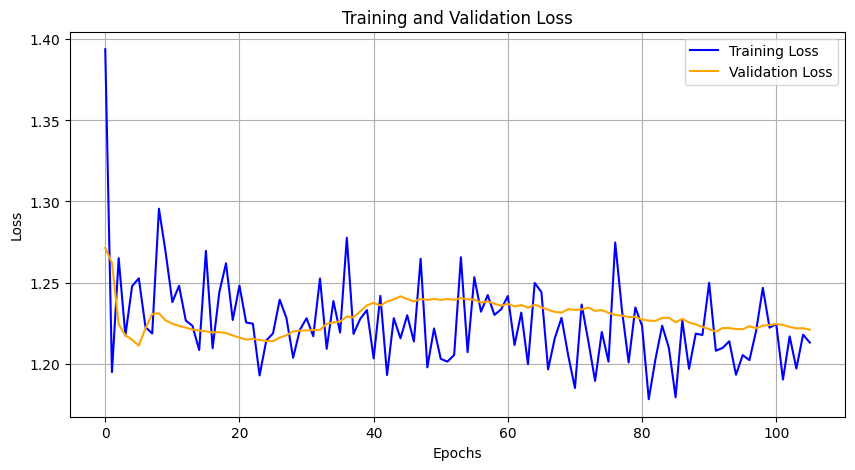

Model weights saved to model.pth
Model size: 43.21 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List, Dict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تنظیم بذر برای قابلیت تکرارپذیری
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# میانگین و انحراف معیار برای نرمال‌سازی (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# افزایش تنوع داده‌ها و نرمال‌سازی
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None, dataset_type: str = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            allowed_classes (List[str]): List of class names.
            transform (callable, optional): Optional transform to be applied on a sample.
            dataset_type (str, optional): 'Train' یا 'Val'.
        """
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.samples = []
        for class_name in allowed_classes:
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, allowed_classes.index(class_name)))

        random.seed(42)
        random.shuffle(self.samples)

        split_ratio = 0.8  # 80% train, 20% val
        split = int(len(self.samples) * split_ratio)
        if dataset_type == 'Train':
            self.samples = self.samples[:split]
        elif dataset_type == 'Val':
            self.samples = self.samples[split:]
        else:
            self.samples = self.samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def count_samples_per_class(dataset: Dataset, allowed_classes: List[str]):
    class_counts = {cls: 0 for cls in allowed_classes}
    for _, label in dataset.samples:
        class_counts[allowed_classes[label]] += 1
    return class_counts

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2) -> Dict[str, DataLoader]:
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]  # اطمینان از تطابق نام کلاس‌ها با پوشه‌های دیتاست
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=train_transform,
        dataset_type='Train'
    )
    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=test_transform,
        dataset_type='Val'
    )

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    # بررسی خالی بودن مجموعه‌ها
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print("Dataset is empty. لطفاً نام کلاس‌ها و ساختار دیتاست را بررسی کنید.")
        raise ValueError("یکی از مجموعه‌ها خالی است.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return {'train': train_loader, 'val': val_loader}

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(model: nn.Module, dataloader: Dict[str, DataLoader], num_epochs: int = 30, patience: int = 5, lr: float = 0.001) -> Tuple[nn.Module, List[List[float]]]:
    """
    تابع برای آموزش مدل.

    ورودی:
        model: مدل CNN برای آموزش.
        dataloader: دیکشنری شامل DataLoaderهای 'train' و 'val'.
        num_epochs: تعداد اپوک‌های آموزش.
        patience: صبر برای Early Stopping.
        lr: نرخ یادگیری.

    خروجی:
        model: بهترین نسخه‌ی مدل آموزش‌دیده.
        scores: لیستی شامل دو لیست: [training_losses, validation_losses].
    """
    scores = [[], []]
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # استفاده از Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0  # شمارنده برای Early Stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # اعمال MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(dataloader['train']))
            swa_scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(dataloader['train'].dataset)
        scores[0].append(avg_train_loss)

        # Update SWA model
        swa_model.update_parameters(model)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader['val'], desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(dataloader['val'].dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    # Update BatchNorm statistics for SWA
    update_bn(dataloader['train'], swa_model, device=device)
    swa_model.to(device)
    swa_model.eval()

    # Replace model with SWA model
    model = swa_model

    return model, scores

# تابع برای رسم نمودارها
def plot_losses(scores: List[List[float]]):
    training_losses, validation_losses = scores
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "./Noisy_birds"  # مسیر به دیتاست خود را به‌روز کنید
    dataloaders = get_data_loaders(image_dir=dataset_path, batch_size=128, num_workers=4)

    # شمارش و چاپ تعداد نمونه‌ها در هر کلاس
    train_dataset = dataloaders['train'].dataset
    val_dataset = dataloaders['val'].dataset
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]

    print("Training samples per class:")
    print(count_samples_per_class(train_dataset, allowed_classes))
    print("\nValidation samples per class:")
    print(count_samples_per_class(val_dataset, allowed_classes))

    model = Model()

    # فریز کردن لایه‌های پایه و آزاد کردن لایه‌های Fully Connected
    for param in model.base_model.parameters():
        param.requires_grad = False  # فریز کردن لایه‌های پایه

    for param in model.base_model.fc.parameters():
        param.requires_grad = True  # آزاد کردن لایه‌های Fully Connected

    # آموزش مدل
    num_epochs = 300  # افزایش تعداد اپوک‌ها برای اطمینان از آموزش کامل
    patience = 100    # افزایش patience برای جلوگیری از early stopping زودهنگام
    lr = 0.001
    model, training_scores = train(model, dataloaders, num_epochs=num_epochs, patience=patience, lr=lr)

    # رسم نمودارهای خطا
    plot_losses(training_scores)

    # ذخیره بهترین مدل
    model_save_path = "model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

    # اختیاری: اعمال Quantization اگر حجم مدل بیشتر از ۷۰ مگابایت باشد
    if model_size > 70:
        def quantize_model(model):
            model.eval()
            quantized_model = torch.quantization.quantize_dynamic(
                model, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
            )
            return quantized_model

        quantized_model = quantize_model(model)
        quantized_model_save_path = "quantized_model.pth"
        torch.save(quantized_model.state_dict(), quantized_model_save_path)
        print(f'Quantized model weights saved to {quantized_model_save_path}')

        # بررسی حجم مدل کوانتیزه شده
        quantized_model_size = os.path.getsize(quantized_model_save_path) / (1024 * 1024)
        print(f"Quantized Model size: {quantized_model_size:.2f} MB")
        if quantized_model_size > 70:
            print("Warning: Quantized model size still exceeds 70 MB!")
        else:
            print("Quantized model size is within the 70 MB limit.")

if __name__ == "__main__":
    main()


#V18

In [ ]:
# model.py
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # بارگذاری مدل ResNet18 بدون وزن‌های پیش‌آموزش‌شده
        self.base_model = models.resnet18(weights=None)

        # فریز کردن تمام پارامترهای مدل پایه
        for param in self.base_model.parameters():
            param.requires_grad = False

        # جایگزینی لایه Fully Connected نهایی با لایه‌های جدید برای ۴ کلاس
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')))
    ####################################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.base_model(x)


Using device: cuda:0
Number of training samples: 88
Number of validation samples: 22
Training samples per class:
{'budgie': 28, 'canary': 31, 'duckling': 29, 'rubber_duck': 0}

Validation samples per class:
{'budgie': 11, 'canary': 3, 'duckling': 8, 'rubber_duck': 0}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.9MB/s]


Pre-trained weights loaded into the model.


Epoch 1/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 1/300, Training Loss: 1.4040, Validation Loss: 1.2515
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
Validation loss improved. Saving best model state.



Epoch 2/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 2/300, Training Loss: 1.2192, Validation Loss: 1.2603
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 1 epochs.



Epoch 3/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Epoch 3/300, Training Loss: 1.2358, Validation Loss: 1.2294
F1 Score on Validation set: 0.1174, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 4/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 4/300, Training Loss: 1.2277, Validation Loss: 1.2193
F1 Score on Validation set: 0.2970, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 5/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]



Epoch 5/300, Training Loss: 1.1855, Validation Loss: 1.2127
F1 Score on Validation set: 0.5876, Accuracy on Validation set: 0.5909
Validation loss improved. Saving best model state.



Epoch 6/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Epoch 6/300, Training Loss: 1.2465, Validation Loss: 1.2081
F1 Score on Validation set: 0.4049, Accuracy on Validation set: 0.4545
Validation loss improved. Saving best model state.



Epoch 7/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Epoch 7/300, Training Loss: 1.2464, Validation Loss: 1.2166
F1 Score on Validation set: 0.2087, Accuracy on Validation set: 0.2727
No improvement in validation loss for 1 epochs.



Epoch 8/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]



Epoch 8/300, Training Loss: 1.2478, Validation Loss: 1.2287
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 2 epochs.



Epoch 9/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 9/300, Training Loss: 1.2124, Validation Loss: 1.2315
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 3 epochs.



Epoch 10/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Epoch 10/300, Training Loss: 1.2527, Validation Loss: 1.2287
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 4 epochs.



Epoch 11/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 11/300, Training Loss: 1.2319, Validation Loss: 1.2274
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 5 epochs.



Epoch 12/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 12/300, Training Loss: 1.2665, Validation Loss: 1.2258
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 6 epochs.



Epoch 13/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 13/300, Training Loss: 1.2549, Validation Loss: 1.2247
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 7 epochs.



Epoch 14/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]



Epoch 14/300, Training Loss: 1.2410, Validation Loss: 1.2237
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 8 epochs.



Epoch 15/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]



Epoch 15/300, Training Loss: 1.2012, Validation Loss: 1.2227
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 9 epochs.



Epoch 16/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]



Epoch 16/300, Training Loss: 1.2895, Validation Loss: 1.2221
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 10 epochs.



Epoch 17/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]



Epoch 17/300, Training Loss: 1.2119, Validation Loss: 1.2213
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 11 epochs.



Epoch 18/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 18/300, Training Loss: 1.2241, Validation Loss: 1.2203
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 12 epochs.



Epoch 19/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Epoch 19/300, Training Loss: 1.2152, Validation Loss: 1.2187
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 13 epochs.



Epoch 20/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



Epoch 20/300, Training Loss: 1.2208, Validation Loss: 1.2163
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 14 epochs.



Epoch 21/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 21/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 21/300, Training Loss: 1.2118, Validation Loss: 1.2138
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 15 epochs.



Epoch 22/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 22/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]



Epoch 22/300, Training Loss: 1.2195, Validation Loss: 1.2113
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 16 epochs.



Epoch 23/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 23/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]



Epoch 23/300, Training Loss: 1.2149, Validation Loss: 1.2099
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 17 epochs.



Epoch 24/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 24/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 24/300, Training Loss: 1.2369, Validation Loss: 1.2082
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 18 epochs.



Epoch 25/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 25/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 25/300, Training Loss: 1.2159, Validation Loss: 1.2066
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
Validation loss improved. Saving best model state.



Epoch 26/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 26/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 26/300, Training Loss: 1.1606, Validation Loss: 1.2055
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 27/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 27/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 27/300, Training Loss: 1.2825, Validation Loss: 1.2052
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 28/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 28/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 28/300, Training Loss: 1.2123, Validation Loss: 1.2048
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 29/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 29/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 29/300, Training Loss: 1.2380, Validation Loss: 1.2045
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 30/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 30/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 30/300, Training Loss: 1.2127, Validation Loss: 1.2039
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 31/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 31/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 31/300, Training Loss: 1.1951, Validation Loss: 1.2038
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 32/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 32/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 32/300, Training Loss: 1.2017, Validation Loss: 1.2036
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 33/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 33/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 33/300, Training Loss: 1.1825, Validation Loss: 1.2036
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
Validation loss improved. Saving best model state.



Epoch 34/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 34/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 34/300, Training Loss: 1.2406, Validation Loss: 1.2050
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
No improvement in validation loss for 1 epochs.



Epoch 35/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 35/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]



Epoch 35/300, Training Loss: 1.2066, Validation Loss: 1.2055
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
No improvement in validation loss for 2 epochs.



Epoch 36/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 36/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]



Epoch 36/300, Training Loss: 1.2213, Validation Loss: 1.2059
F1 Score on Validation set: 0.1149, Accuracy on Validation set: 0.1818
No improvement in validation loss for 3 epochs.



Epoch 37/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 37/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 37/300, Training Loss: 1.2204, Validation Loss: 1.2057
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 4 epochs.



Epoch 38/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 38/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 38/300, Training Loss: 1.2284, Validation Loss: 1.2051
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 5 epochs.



Epoch 39/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 39/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 39/300, Training Loss: 1.2172, Validation Loss: 1.2052
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 6 epochs.



Epoch 40/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 40/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 40/300, Training Loss: 1.2179, Validation Loss: 1.2059
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 7 epochs.



Epoch 41/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 41/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Epoch 41/300, Training Loss: 1.2090, Validation Loss: 1.2062
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 8 epochs.



Epoch 42/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 42/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]



Epoch 42/300, Training Loss: 1.2355, Validation Loss: 1.2063
F1 Score on Validation set: 0.0341, Accuracy on Validation set: 0.1364
No improvement in validation loss for 9 epochs.



Epoch 43/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 43/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 43/300, Training Loss: 1.2240, Validation Loss: 1.2057
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 10 epochs.



Epoch 44/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 44/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]



Epoch 44/300, Training Loss: 1.2049, Validation Loss: 1.2054
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 11 epochs.



Epoch 45/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 45/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 45/300, Training Loss: 1.2379, Validation Loss: 1.2057
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 12 epochs.



Epoch 46/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 46/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 46/300, Training Loss: 1.2225, Validation Loss: 1.2051
F1 Score on Validation set: 0.0327, Accuracy on Validation set: 0.1364
No improvement in validation loss for 13 epochs.



Epoch 47/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 47/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 47/300, Training Loss: 1.2039, Validation Loss: 1.2047
F1 Score on Validation set: 0.0341, Accuracy on Validation set: 0.1364
No improvement in validation loss for 14 epochs.



Epoch 48/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 48/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 48/300, Training Loss: 1.2451, Validation Loss: 1.2041
F1 Score on Validation set: 0.1894, Accuracy on Validation set: 0.2273
No improvement in validation loss for 15 epochs.



Epoch 49/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 49/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



Epoch 49/300, Training Loss: 1.2514, Validation Loss: 1.2042
F1 Score on Validation set: 0.1800, Accuracy on Validation set: 0.2273
No improvement in validation loss for 16 epochs.



Epoch 50/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 50/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]



Epoch 50/300, Training Loss: 1.2118, Validation Loss: 1.2035
F1 Score on Validation set: 0.1800, Accuracy on Validation set: 0.2273
Validation loss improved. Saving best model state.



Epoch 51/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 51/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Epoch 51/300, Training Loss: 1.2586, Validation Loss: 1.2032
F1 Score on Validation set: 0.1800, Accuracy on Validation set: 0.2273
Validation loss improved. Saving best model state.



Epoch 52/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 52/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 52/300, Training Loss: 1.2011, Validation Loss: 1.2023
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 53/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 53/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 53/300, Training Loss: 1.1663, Validation Loss: 1.2019
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 54/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 54/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 54/300, Training Loss: 1.2385, Validation Loss: 1.2014
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 55/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 55/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 55/300, Training Loss: 1.2115, Validation Loss: 1.2015
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
No improvement in validation loss for 1 epochs.



Epoch 56/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 56/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]



Epoch 56/300, Training Loss: 1.2507, Validation Loss: 1.2012
F1 Score on Validation set: 0.2515, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 57/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 57/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Epoch 57/300, Training Loss: 1.2335, Validation Loss: 1.2013
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
No improvement in validation loss for 1 epochs.



Epoch 58/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 58/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]



Epoch 58/300, Training Loss: 1.2039, Validation Loss: 1.2011
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 59/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 59/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 59/300, Training Loss: 1.2217, Validation Loss: 1.2008
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 60/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 60/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 60/300, Training Loss: 1.2207, Validation Loss: 1.2003
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
Validation loss improved. Saving best model state.



Epoch 61/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 61/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 61/300, Training Loss: 1.2282, Validation Loss: 1.2005
F1 Score on Validation set: 0.2515, Accuracy on Validation set: 0.2727
No improvement in validation loss for 1 epochs.



Epoch 62/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 62/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]



Epoch 62/300, Training Loss: 1.2021, Validation Loss: 1.2003
F1 Score on Validation set: 0.2390, Accuracy on Validation set: 0.2727
No improvement in validation loss for 2 epochs.



Epoch 63/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 63/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Epoch 63/300, Training Loss: 1.2284, Validation Loss: 1.2001
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 64/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 64/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 64/300, Training Loss: 1.2673, Validation Loss: 1.1999
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 65/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 65/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]



Epoch 65/300, Training Loss: 1.2156, Validation Loss: 1.1994
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 66/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 66/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 66/300, Training Loss: 1.2771, Validation Loss: 1.1996
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 67/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 67/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]



Epoch 67/300, Training Loss: 1.2764, Validation Loss: 1.1994
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 68/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 68/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 68/300, Training Loss: 1.2000, Validation Loss: 1.1988
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 69/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 69/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 69/300, Training Loss: 1.2427, Validation Loss: 1.1984
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 70/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 70/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 70/300, Training Loss: 1.2286, Validation Loss: 1.1981
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 71/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 71/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]



Epoch 71/300, Training Loss: 1.2205, Validation Loss: 1.1981
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 72/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 72/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



Epoch 72/300, Training Loss: 1.2137, Validation Loss: 1.1977
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 73/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 73/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 73/300, Training Loss: 1.2067, Validation Loss: 1.1972
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 74/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 74/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 74/300, Training Loss: 1.2286, Validation Loss: 1.1969
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 75/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 75/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 75/300, Training Loss: 1.2215, Validation Loss: 1.1968
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 76/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 76/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Epoch 76/300, Training Loss: 1.2381, Validation Loss: 1.1967
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 77/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 77/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]



Epoch 77/300, Training Loss: 1.1918, Validation Loss: 1.1964
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 78/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 78/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 78/300, Training Loss: 1.2154, Validation Loss: 1.1960
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 79/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 79/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 79/300, Training Loss: 1.1779, Validation Loss: 1.1955
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 80/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 80/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]



Epoch 80/300, Training Loss: 1.2023, Validation Loss: 1.1955
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 81/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 81/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 81/300, Training Loss: 1.1941, Validation Loss: 1.1952
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 82/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 82/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 82/300, Training Loss: 1.2180, Validation Loss: 1.1948
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 83/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 83/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 83/300, Training Loss: 1.2239, Validation Loss: 1.1941
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 84/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 84/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



Epoch 84/300, Training Loss: 1.1873, Validation Loss: 1.1936
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 85/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 85/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 85/300, Training Loss: 1.2134, Validation Loss: 1.1934
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 86/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 86/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]



Epoch 86/300, Training Loss: 1.1702, Validation Loss: 1.1933
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 87/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 87/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



Epoch 87/300, Training Loss: 1.2296, Validation Loss: 1.1929
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 88/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 88/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 88/300, Training Loss: 1.2220, Validation Loss: 1.1928
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 89/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 89/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 89/300, Training Loss: 1.2480, Validation Loss: 1.1928
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 90/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 90/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 90/300, Training Loss: 1.2068, Validation Loss: 1.1924
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 91/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 91/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]



Epoch 91/300, Training Loss: 1.2372, Validation Loss: 1.1924
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 92/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 92/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 92/300, Training Loss: 1.1486, Validation Loss: 1.1926
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 93/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 93/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 93/300, Training Loss: 1.1872, Validation Loss: 1.1923
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 94/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 94/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 94/300, Training Loss: 1.2194, Validation Loss: 1.1925
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 95/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 95/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]



Epoch 95/300, Training Loss: 1.1839, Validation Loss: 1.1924
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 96/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 96/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 96/300, Training Loss: 1.2245, Validation Loss: 1.1920
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 97/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 97/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Epoch 97/300, Training Loss: 1.2344, Validation Loss: 1.1914
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 98/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 98/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]



Epoch 98/300, Training Loss: 1.2093, Validation Loss: 1.1915
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 99/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 99/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



Epoch 99/300, Training Loss: 1.1980, Validation Loss: 1.1917
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 100/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 100/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 100/300, Training Loss: 1.1931, Validation Loss: 1.1918
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 3 epochs.



Epoch 101/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 101/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 101/300, Training Loss: 1.2337, Validation Loss: 1.1912
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 102/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 102/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 102/300, Training Loss: 1.2147, Validation Loss: 1.1915
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 103/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 103/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 103/300, Training Loss: 1.2304, Validation Loss: 1.1920
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 104/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 104/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 104/300, Training Loss: 1.1911, Validation Loss: 1.1918
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 3 epochs.



Epoch 105/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 105/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 105/300, Training Loss: 1.2237, Validation Loss: 1.1915
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 4 epochs.



Epoch 106/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 106/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Epoch 106/300, Training Loss: 1.2037, Validation Loss: 1.1915
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 5 epochs.



Epoch 107/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 107/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 107/300, Training Loss: 1.2438, Validation Loss: 1.1913
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 6 epochs.



Epoch 108/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 108/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]



Epoch 108/300, Training Loss: 1.2241, Validation Loss: 1.1917
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 7 epochs.



Epoch 109/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 109/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 109/300, Training Loss: 1.2291, Validation Loss: 1.1919
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 8 epochs.



Epoch 110/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 110/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]



Epoch 110/300, Training Loss: 1.2370, Validation Loss: 1.1914
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 9 epochs.



Epoch 111/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 111/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 111/300, Training Loss: 1.1923, Validation Loss: 1.1912
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 112/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 112/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]



Epoch 112/300, Training Loss: 1.2212, Validation Loss: 1.1910
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 113/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 113/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



Epoch 113/300, Training Loss: 1.1757, Validation Loss: 1.1909
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 114/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 114/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



Epoch 114/300, Training Loss: 1.2026, Validation Loss: 1.1903
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 115/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 115/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 115/300, Training Loss: 1.2080, Validation Loss: 1.1902
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 116/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 116/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 116/300, Training Loss: 1.2387, Validation Loss: 1.1901
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 117/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 117/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 117/300, Training Loss: 1.2312, Validation Loss: 1.1897
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 118/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 118/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 118/300, Training Loss: 1.1977, Validation Loss: 1.1900
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 119/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 119/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]



Epoch 119/300, Training Loss: 1.2140, Validation Loss: 1.1906
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 120/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 120/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



Epoch 120/300, Training Loss: 1.2152, Validation Loss: 1.1898
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 3 epochs.



Epoch 121/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 121/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 121/300, Training Loss: 1.2272, Validation Loss: 1.1898
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 4 epochs.



Epoch 122/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 122/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 122/300, Training Loss: 1.1925, Validation Loss: 1.1894
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 123/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 123/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



Epoch 123/300, Training Loss: 1.2103, Validation Loss: 1.1889
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 124/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 124/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 124/300, Training Loss: 1.1870, Validation Loss: 1.1893
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 125/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 125/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 125/300, Training Loss: 1.2014, Validation Loss: 1.1894
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 126/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 126/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



Epoch 126/300, Training Loss: 1.1851, Validation Loss: 1.1899
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 3 epochs.



Epoch 127/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 127/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



Epoch 127/300, Training Loss: 1.1594, Validation Loss: 1.1899
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 4 epochs.



Epoch 128/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 128/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



Epoch 128/300, Training Loss: 1.2118, Validation Loss: 1.1899
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 5 epochs.



Epoch 129/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 129/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



Epoch 129/300, Training Loss: 1.1946, Validation Loss: 1.1898
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 6 epochs.



Epoch 130/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 130/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



Epoch 130/300, Training Loss: 1.2848, Validation Loss: 1.1901
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 7 epochs.



Epoch 131/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 131/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 131/300, Training Loss: 1.2321, Validation Loss: 1.1908
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 8 epochs.



Epoch 132/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 132/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 132/300, Training Loss: 1.1806, Validation Loss: 1.1905
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 9 epochs.



Epoch 133/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 133/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 133/300, Training Loss: 1.2086, Validation Loss: 1.1904
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 10 epochs.



Epoch 134/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 134/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 134/300, Training Loss: 1.2183, Validation Loss: 1.1905
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 11 epochs.



Epoch 135/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 135/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 135/300, Training Loss: 1.1921, Validation Loss: 1.1899
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 12 epochs.



Epoch 136/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 136/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 136/300, Training Loss: 1.1769, Validation Loss: 1.1901
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 13 epochs.



Epoch 137/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 137/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 137/300, Training Loss: 1.1915, Validation Loss: 1.1893
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 14 epochs.



Epoch 138/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 138/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



Epoch 138/300, Training Loss: 1.2223, Validation Loss: 1.1892
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 15 epochs.



Epoch 139/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 139/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]



Epoch 139/300, Training Loss: 1.2114, Validation Loss: 1.1896
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 16 epochs.



Epoch 140/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 140/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



Epoch 140/300, Training Loss: 1.1990, Validation Loss: 1.1901
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 17 epochs.



Epoch 141/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 141/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 141/300, Training Loss: 1.2298, Validation Loss: 1.1892
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 18 epochs.



Epoch 142/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 142/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 142/300, Training Loss: 1.1834, Validation Loss: 1.1895
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 19 epochs.



Epoch 143/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 143/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]



Epoch 143/300, Training Loss: 1.2473, Validation Loss: 1.1888
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 144/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 144/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 144/300, Training Loss: 1.2262, Validation Loss: 1.1890
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 145/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 145/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 145/300, Training Loss: 1.1927, Validation Loss: 1.1888
F1 Score on Validation set: 0.3372, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 146/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 146/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 146/300, Training Loss: 1.2106, Validation Loss: 1.1892
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 147/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 147/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 147/300, Training Loss: 1.2037, Validation Loss: 1.1889
F1 Score on Validation set: 0.3372, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 148/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 148/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 148/300, Training Loss: 1.1946, Validation Loss: 1.1885
F1 Score on Validation set: 0.3372, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 149/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 149/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 149/300, Training Loss: 1.1949, Validation Loss: 1.1891
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 150/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 150/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 150/300, Training Loss: 1.2317, Validation Loss: 1.1892
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 151/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 151/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 151/300, Training Loss: 1.2089, Validation Loss: 1.1897
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 3 epochs.



Epoch 152/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 152/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]



Epoch 152/300, Training Loss: 1.2262, Validation Loss: 1.1892
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 4 epochs.



Epoch 153/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 153/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 153/300, Training Loss: 1.1961, Validation Loss: 1.1879
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
Validation loss improved. Saving best model state.



Epoch 154/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 154/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 154/300, Training Loss: 1.1940, Validation Loss: 1.1881
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 155/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 155/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 155/300, Training Loss: 1.2102, Validation Loss: 1.1887
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 156/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 156/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Epoch 156/300, Training Loss: 1.1672, Validation Loss: 1.1888
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 3 epochs.



Epoch 157/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 157/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



Epoch 157/300, Training Loss: 1.1956, Validation Loss: 1.1893
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 4 epochs.



Epoch 158/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 158/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 158/300, Training Loss: 1.1993, Validation Loss: 1.1895
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 5 epochs.



Epoch 159/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 159/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]



Epoch 159/300, Training Loss: 1.2266, Validation Loss: 1.1898
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 6 epochs.



Epoch 160/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 160/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 160/300, Training Loss: 1.1956, Validation Loss: 1.1901
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 7 epochs.



Epoch 161/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 161/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 161/300, Training Loss: 1.1942, Validation Loss: 1.1901
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 8 epochs.



Epoch 162/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 162/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 162/300, Training Loss: 1.1998, Validation Loss: 1.1897
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 9 epochs.



Epoch 163/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 163/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 163/300, Training Loss: 1.2227, Validation Loss: 1.1897
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 10 epochs.



Epoch 164/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 164/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 164/300, Training Loss: 1.2256, Validation Loss: 1.1897
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 11 epochs.



Epoch 165/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 165/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]



Epoch 165/300, Training Loss: 1.1960, Validation Loss: 1.1894
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 12 epochs.



Epoch 166/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 166/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 166/300, Training Loss: 1.2154, Validation Loss: 1.1886
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 13 epochs.



Epoch 167/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 167/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



Epoch 167/300, Training Loss: 1.2039, Validation Loss: 1.1892
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 14 epochs.



Epoch 168/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 168/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]



Epoch 168/300, Training Loss: 1.2152, Validation Loss: 1.1891
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 15 epochs.



Epoch 169/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 169/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 169/300, Training Loss: 1.1984, Validation Loss: 1.1898
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 16 epochs.



Epoch 170/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 170/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 170/300, Training Loss: 1.2334, Validation Loss: 1.1902
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 17 epochs.



Epoch 171/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 171/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 171/300, Training Loss: 1.2128, Validation Loss: 1.1905
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 18 epochs.



Epoch 172/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 172/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 172/300, Training Loss: 1.1883, Validation Loss: 1.1908
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 19 epochs.



Epoch 173/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 173/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 173/300, Training Loss: 1.2080, Validation Loss: 1.1904
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 20 epochs.



Epoch 174/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 174/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]



Epoch 174/300, Training Loss: 1.1900, Validation Loss: 1.1896
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 21 epochs.



Epoch 175/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 175/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 175/300, Training Loss: 1.2308, Validation Loss: 1.1887
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 22 epochs.



Epoch 176/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 176/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]



Epoch 176/300, Training Loss: 1.1840, Validation Loss: 1.1894
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 23 epochs.



Epoch 177/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 177/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 177/300, Training Loss: 1.2226, Validation Loss: 1.1899
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 24 epochs.



Epoch 178/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 178/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]



Epoch 178/300, Training Loss: 1.2016, Validation Loss: 1.1896
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 25 epochs.



Epoch 179/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 179/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 179/300, Training Loss: 1.1805, Validation Loss: 1.1894
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 26 epochs.



Epoch 180/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 180/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 180/300, Training Loss: 1.2082, Validation Loss: 1.1899
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 27 epochs.



Epoch 181/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 181/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



Epoch 181/300, Training Loss: 1.2081, Validation Loss: 1.1901
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 28 epochs.



Epoch 182/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 182/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 182/300, Training Loss: 1.2514, Validation Loss: 1.1905
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 29 epochs.



Epoch 183/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 183/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 183/300, Training Loss: 1.2038, Validation Loss: 1.1908
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 30 epochs.



Epoch 184/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 184/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 184/300, Training Loss: 1.2273, Validation Loss: 1.1912
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 31 epochs.



Epoch 185/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 185/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]



Epoch 185/300, Training Loss: 1.2064, Validation Loss: 1.1916
F1 Score on Validation set: 0.2955, Accuracy on Validation set: 0.3182
No improvement in validation loss for 32 epochs.



Epoch 186/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 186/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 186/300, Training Loss: 1.2003, Validation Loss: 1.1906
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 33 epochs.



Epoch 187/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 187/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]



Epoch 187/300, Training Loss: 1.2020, Validation Loss: 1.1912
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 34 epochs.



Epoch 188/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 188/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 188/300, Training Loss: 1.2469, Validation Loss: 1.1905
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 35 epochs.



Epoch 189/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 189/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 189/300, Training Loss: 1.1988, Validation Loss: 1.1902
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 36 epochs.



Epoch 190/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 190/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]



Epoch 190/300, Training Loss: 1.1830, Validation Loss: 1.1902
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 37 epochs.



Epoch 191/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 191/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 191/300, Training Loss: 1.1882, Validation Loss: 1.1907
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 38 epochs.



Epoch 192/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 192/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 192/300, Training Loss: 1.1898, Validation Loss: 1.1903
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 39 epochs.



Epoch 193/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 193/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]



Epoch 193/300, Training Loss: 1.1977, Validation Loss: 1.1910
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 40 epochs.



Epoch 194/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 194/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Epoch 194/300, Training Loss: 1.2051, Validation Loss: 1.1900
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 41 epochs.



Epoch 195/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 195/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 195/300, Training Loss: 1.2299, Validation Loss: 1.1894
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 42 epochs.



Epoch 196/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 196/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 196/300, Training Loss: 1.2382, Validation Loss: 1.1898
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 43 epochs.



Epoch 197/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 197/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 197/300, Training Loss: 1.2388, Validation Loss: 1.1899
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 44 epochs.



Epoch 198/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 198/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 198/300, Training Loss: 1.2036, Validation Loss: 1.1902
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 45 epochs.



Epoch 199/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 199/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 199/300, Training Loss: 1.1996, Validation Loss: 1.1909
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 46 epochs.



Epoch 200/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 200/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 200/300, Training Loss: 1.1960, Validation Loss: 1.1909
F1 Score on Validation set: 0.2931, Accuracy on Validation set: 0.3182
No improvement in validation loss for 47 epochs.



Epoch 201/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 201/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 201/300, Training Loss: 1.1916, Validation Loss: 1.1903
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 48 epochs.



Epoch 202/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 202/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 202/300, Training Loss: 1.2177, Validation Loss: 1.1894
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 49 epochs.



Epoch 203/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 203/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]



Epoch 203/300, Training Loss: 1.2034, Validation Loss: 1.1899
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 50 epochs.



Epoch 204/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 204/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 204/300, Training Loss: 1.2230, Validation Loss: 1.1897
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 51 epochs.



Epoch 205/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 205/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 205/300, Training Loss: 1.2141, Validation Loss: 1.1891
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 52 epochs.



Epoch 206/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 206/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]



Epoch 206/300, Training Loss: 1.1934, Validation Loss: 1.1879
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 53 epochs.



Epoch 207/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 207/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



Epoch 207/300, Training Loss: 1.2310, Validation Loss: 1.1888
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 54 epochs.



Epoch 208/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 208/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



Epoch 208/300, Training Loss: 1.2189, Validation Loss: 1.1880
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 55 epochs.



Epoch 209/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 209/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]



Epoch 209/300, Training Loss: 1.2194, Validation Loss: 1.1881
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 56 epochs.



Epoch 210/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 210/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Epoch 210/300, Training Loss: 1.1974, Validation Loss: 1.1885
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 57 epochs.



Epoch 211/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 211/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]



Epoch 211/300, Training Loss: 1.2017, Validation Loss: 1.1885
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 58 epochs.



Epoch 212/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 212/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



Epoch 212/300, Training Loss: 1.2223, Validation Loss: 1.1881
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 59 epochs.



Epoch 213/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 213/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 213/300, Training Loss: 1.1969, Validation Loss: 1.1883
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 60 epochs.



Epoch 214/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 214/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 214/300, Training Loss: 1.1838, Validation Loss: 1.1889
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 61 epochs.



Epoch 215/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 215/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 215/300, Training Loss: 1.1828, Validation Loss: 1.1887
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 62 epochs.



Epoch 216/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 216/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]



Epoch 216/300, Training Loss: 1.2320, Validation Loss: 1.1883
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 63 epochs.



Epoch 217/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 217/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 217/300, Training Loss: 1.2013, Validation Loss: 1.1872
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 218/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 218/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 218/300, Training Loss: 1.2051, Validation Loss: 1.1880
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 219/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 219/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 219/300, Training Loss: 1.2057, Validation Loss: 1.1885
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 220/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 220/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



Epoch 220/300, Training Loss: 1.2262, Validation Loss: 1.1887
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 3 epochs.



Epoch 221/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 221/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]



Epoch 221/300, Training Loss: 1.1959, Validation Loss: 1.1893
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 4 epochs.



Epoch 222/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 222/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



Epoch 222/300, Training Loss: 1.2216, Validation Loss: 1.1886
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 5 epochs.



Epoch 223/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 223/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 223/300, Training Loss: 1.2293, Validation Loss: 1.1888
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 6 epochs.



Epoch 224/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 224/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 224/300, Training Loss: 1.1782, Validation Loss: 1.1883
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 7 epochs.



Epoch 225/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 225/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 225/300, Training Loss: 1.2164, Validation Loss: 1.1878
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 8 epochs.



Epoch 226/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 226/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 226/300, Training Loss: 1.2054, Validation Loss: 1.1861
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 227/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 227/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]



Epoch 227/300, Training Loss: 1.1852, Validation Loss: 1.1857
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 228/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 228/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]



Epoch 228/300, Training Loss: 1.2235, Validation Loss: 1.1865
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 229/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 229/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



Epoch 229/300, Training Loss: 1.1968, Validation Loss: 1.1854
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 230/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 230/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



Epoch 230/300, Training Loss: 1.2043, Validation Loss: 1.1865
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 231/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 231/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Epoch 231/300, Training Loss: 1.2127, Validation Loss: 1.1871
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 2 epochs.



Epoch 232/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 232/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 232/300, Training Loss: 1.2049, Validation Loss: 1.1867
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 3 epochs.



Epoch 233/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 233/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]



Epoch 233/300, Training Loss: 1.2033, Validation Loss: 1.1855
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 4 epochs.



Epoch 234/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 234/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]



Epoch 234/300, Training Loss: 1.2110, Validation Loss: 1.1859
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 5 epochs.



Epoch 235/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 235/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 235/300, Training Loss: 1.2220, Validation Loss: 1.1850
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 236/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 236/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]



Epoch 236/300, Training Loss: 1.2227, Validation Loss: 1.1843
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 237/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 237/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 237/300, Training Loss: 1.2307, Validation Loss: 1.1848
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 1 epochs.



Epoch 238/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 238/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 238/300, Training Loss: 1.2274, Validation Loss: 1.1845
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 239/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 239/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



Epoch 239/300, Training Loss: 1.1939, Validation Loss: 1.1837
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 240/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 240/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]



Epoch 240/300, Training Loss: 1.2301, Validation Loss: 1.1839
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 241/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 241/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Epoch 241/300, Training Loss: 1.2064, Validation Loss: 1.1838
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 242/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 242/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



Epoch 242/300, Training Loss: 1.1923, Validation Loss: 1.1826
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
Validation loss improved. Saving best model state.



Epoch 243/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 243/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]



Epoch 243/300, Training Loss: 1.1762, Validation Loss: 1.1838
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 244/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 244/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



Epoch 244/300, Training Loss: 1.2313, Validation Loss: 1.1841
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 2 epochs.



Epoch 245/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 245/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]



Epoch 245/300, Training Loss: 1.2326, Validation Loss: 1.1834
F1 Score on Validation set: 0.4067, Accuracy on Validation set: 0.4091
No improvement in validation loss for 3 epochs.



Epoch 246/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 246/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 246/300, Training Loss: 1.2055, Validation Loss: 1.1846
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 4 epochs.



Epoch 247/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 247/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Epoch 247/300, Training Loss: 1.1688, Validation Loss: 1.1853
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 5 epochs.



Epoch 248/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 248/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]



Epoch 248/300, Training Loss: 1.1739, Validation Loss: 1.1849
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 6 epochs.



Epoch 249/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 249/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]



Epoch 249/300, Training Loss: 1.2047, Validation Loss: 1.1846
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 7 epochs.



Epoch 250/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 250/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]



Epoch 250/300, Training Loss: 1.2304, Validation Loss: 1.1852
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 8 epochs.



Epoch 251/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 251/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 251/300, Training Loss: 1.2225, Validation Loss: 1.1849
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 9 epochs.



Epoch 252/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 252/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 252/300, Training Loss: 1.2025, Validation Loss: 1.1842
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 10 epochs.



Epoch 253/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 253/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]



Epoch 253/300, Training Loss: 1.1951, Validation Loss: 1.1848
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 11 epochs.



Epoch 254/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 254/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 254/300, Training Loss: 1.2087, Validation Loss: 1.1856
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 12 epochs.



Epoch 255/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 255/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]



Epoch 255/300, Training Loss: 1.2011, Validation Loss: 1.1862
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 13 epochs.



Epoch 256/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 256/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]



Epoch 256/300, Training Loss: 1.2006, Validation Loss: 1.1854
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 14 epochs.



Epoch 257/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 257/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]



Epoch 257/300, Training Loss: 1.1911, Validation Loss: 1.1846
F1 Score on Validation set: 0.3739, Accuracy on Validation set: 0.3636
No improvement in validation loss for 15 epochs.



Epoch 258/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 258/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]



Epoch 258/300, Training Loss: 1.1981, Validation Loss: 1.1845
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 16 epochs.



Epoch 259/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 259/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 259/300, Training Loss: 1.1918, Validation Loss: 1.1845
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 17 epochs.



Epoch 260/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 260/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 260/300, Training Loss: 1.1817, Validation Loss: 1.1858
F1 Score on Validation set: 0.3739, Accuracy on Validation set: 0.3636
No improvement in validation loss for 18 epochs.



Epoch 261/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 261/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]



Epoch 261/300, Training Loss: 1.1815, Validation Loss: 1.1844
F1 Score on Validation set: 0.3372, Accuracy on Validation set: 0.3636
No improvement in validation loss for 19 epochs.



Epoch 262/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 262/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]



Epoch 262/300, Training Loss: 1.1717, Validation Loss: 1.1850
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 20 epochs.



Epoch 263/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 263/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]



Epoch 263/300, Training Loss: 1.1943, Validation Loss: 1.1854
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 21 epochs.



Epoch 264/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 264/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]



Epoch 264/300, Training Loss: 1.2222, Validation Loss: 1.1847
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 22 epochs.



Epoch 265/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 265/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



Epoch 265/300, Training Loss: 1.2001, Validation Loss: 1.1859
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 23 epochs.



Epoch 266/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 266/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]



Epoch 266/300, Training Loss: 1.1953, Validation Loss: 1.1851
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 24 epochs.



Epoch 267/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 267/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]



Epoch 267/300, Training Loss: 1.2000, Validation Loss: 1.1861
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 25 epochs.



Epoch 268/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 268/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]



Epoch 268/300, Training Loss: 1.1846, Validation Loss: 1.1851
F1 Score on Validation set: 0.2909, Accuracy on Validation set: 0.3182
No improvement in validation loss for 26 epochs.



Epoch 269/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 269/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]



Epoch 269/300, Training Loss: 1.2100, Validation Loss: 1.1844
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 27 epochs.



Epoch 270/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 270/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 270/300, Training Loss: 1.1998, Validation Loss: 1.1855
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 28 epochs.



Epoch 271/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 271/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 271/300, Training Loss: 1.2036, Validation Loss: 1.1843
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 29 epochs.



Epoch 272/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 272/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 272/300, Training Loss: 1.2053, Validation Loss: 1.1848
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 30 epochs.



Epoch 273/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 273/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



Epoch 273/300, Training Loss: 1.2268, Validation Loss: 1.1841
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 31 epochs.



Epoch 274/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 274/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 274/300, Training Loss: 1.2405, Validation Loss: 1.1839
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 32 epochs.



Epoch 275/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 275/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



Epoch 275/300, Training Loss: 1.1992, Validation Loss: 1.1841
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 33 epochs.



Epoch 276/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 276/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



Epoch 276/300, Training Loss: 1.2055, Validation Loss: 1.1835
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 34 epochs.



Epoch 277/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 277/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]



Epoch 277/300, Training Loss: 1.2164, Validation Loss: 1.1830
F1 Score on Validation set: 0.3113, Accuracy on Validation set: 0.3636
No improvement in validation loss for 35 epochs.



Epoch 278/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 278/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 278/300, Training Loss: 1.2131, Validation Loss: 1.1829
F1 Score on Validation set: 0.3113, Accuracy on Validation set: 0.3636
No improvement in validation loss for 36 epochs.



Epoch 279/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 279/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



Epoch 279/300, Training Loss: 1.1992, Validation Loss: 1.1833
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 37 epochs.



Epoch 280/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 280/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]



Epoch 280/300, Training Loss: 1.2393, Validation Loss: 1.1845
F1 Score on Validation set: 0.3232, Accuracy on Validation set: 0.3636
No improvement in validation loss for 38 epochs.



Epoch 281/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 281/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



Epoch 281/300, Training Loss: 1.2150, Validation Loss: 1.1851
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 39 epochs.



Epoch 282/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 282/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



Epoch 282/300, Training Loss: 1.1861, Validation Loss: 1.1851
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 40 epochs.



Epoch 283/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 283/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



Epoch 283/300, Training Loss: 1.1991, Validation Loss: 1.1860
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 41 epochs.



Epoch 284/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 284/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]



Epoch 284/300, Training Loss: 1.2378, Validation Loss: 1.1858
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 42 epochs.



Epoch 285/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 285/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]



Epoch 285/300, Training Loss: 1.1942, Validation Loss: 1.1863
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 43 epochs.



Epoch 286/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 286/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]



Epoch 286/300, Training Loss: 1.2069, Validation Loss: 1.1850
F1 Score on Validation set: 0.3616, Accuracy on Validation set: 0.3636
No improvement in validation loss for 44 epochs.



Epoch 287/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 287/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]



Epoch 287/300, Training Loss: 1.2094, Validation Loss: 1.1849
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 45 epochs.



Epoch 288/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 288/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]



Epoch 288/300, Training Loss: 1.2164, Validation Loss: 1.1853
F1 Score on Validation set: 0.2784, Accuracy on Validation set: 0.3182
No improvement in validation loss for 46 epochs.



Epoch 289/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 289/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]



Epoch 289/300, Training Loss: 1.1819, Validation Loss: 1.1850
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 47 epochs.



Epoch 290/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 290/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



Epoch 290/300, Training Loss: 1.2191, Validation Loss: 1.1848
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 48 epochs.



Epoch 291/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 291/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]



Epoch 291/300, Training Loss: 1.2046, Validation Loss: 1.1846
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 49 epochs.



Epoch 292/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 292/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]



Epoch 292/300, Training Loss: 1.2238, Validation Loss: 1.1844
F1 Score on Validation set: 0.3561, Accuracy on Validation set: 0.3636
No improvement in validation loss for 50 epochs.



Epoch 293/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 293/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]



Epoch 293/300, Training Loss: 1.1860, Validation Loss: 1.1851
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 51 epochs.



Epoch 294/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 294/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



Epoch 294/300, Training Loss: 1.2072, Validation Loss: 1.1848
F1 Score on Validation set: 0.2807, Accuracy on Validation set: 0.3182
No improvement in validation loss for 52 epochs.



Epoch 295/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 295/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



Epoch 295/300, Training Loss: 1.2149, Validation Loss: 1.1846
F1 Score on Validation set: 0.3525, Accuracy on Validation set: 0.3636
No improvement in validation loss for 53 epochs.



Epoch 296/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 296/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]



Epoch 296/300, Training Loss: 1.2214, Validation Loss: 1.1831
F1 Score on Validation set: 0.3525, Accuracy on Validation set: 0.3636
No improvement in validation loss for 54 epochs.



Epoch 297/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 297/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



Epoch 297/300, Training Loss: 1.2043, Validation Loss: 1.1814
F1 Score on Validation set: 0.3877, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 298/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 298/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



Epoch 298/300, Training Loss: 1.2161, Validation Loss: 1.1809
F1 Score on Validation set: 0.3904, Accuracy on Validation set: 0.4091
Validation loss improved. Saving best model state.



Epoch 299/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 299/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 299/300, Training Loss: 1.2234, Validation Loss: 1.1819
F1 Score on Validation set: 0.3525, Accuracy on Validation set: 0.3636
No improvement in validation loss for 1 epochs.



Epoch 300/300 - Training:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 300/300 - Validation: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch 300/300, Training Loss: 1.1634, Validation Loss: 1.1825
F1 Score on Validation set: 0.4111, Accuracy on Validation set: 0.4091
No improvement in validation loss for 2 epochs.

Best model loaded based on validation loss.




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


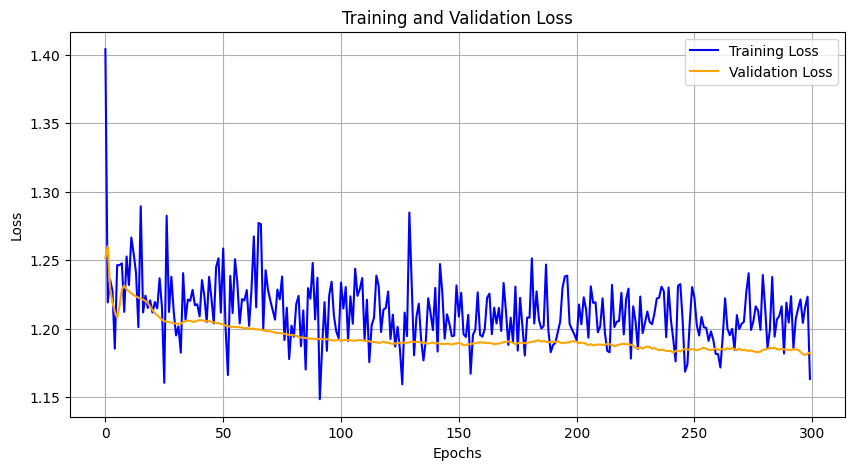

Model weights saved to model.pth
Model size: 43.21 MB
Model size is within the 70 MB limit.


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import Tuple, List, Dict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# تنظیم دستگاه (CPU یا GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تنظیم بذر برای قابلیت تکرارپذیری
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# میانگین و انحراف معیار برای نرمال‌سازی (ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# افزایش تنوع داده‌ها و نرمال‌سازی
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class Birddataset(Dataset):
    def __init__(self, image_dir: str, allowed_classes: List[str], transform=None, dataset_type: str = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            allowed_classes (List[str]): List of class names.
            transform (callable, optional): Optional transform to be applied on a sample.
            dataset_type (str, optional): 'Train' یا 'Val'.
        """
        self.allowed_classes = allowed_classes
        self.image_dir = image_dir
        self.dataset_type = dataset_type
        self.transform = transform

        self.samples = []
        for class_name in allowed_classes:
            class_folder = os.path.join(image_dir, class_name)
            if os.path.isdir(class_folder):
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, allowed_classes.index(class_name)))

        random.seed(42)
        random.shuffle(self.samples)

        split_ratio = 0.8  # 80% train, 20% val
        split = int(len(self.samples) * split_ratio)
        if dataset_type == 'Train':
            self.samples = self.samples[:split]
        elif dataset_type == 'Val':
            self.samples = self.samples[split:]
        else:
            self.samples = self.samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img_path, class_idx = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx

def count_samples_per_class(dataset: Dataset, allowed_classes: List[str]):
    class_counts = {cls: 0 for cls in allowed_classes}
    for _, label in dataset.samples:
        class_counts[allowed_classes[label]] += 1
    return class_counts

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2, validation_split: float = 0.2) -> Dict[str, DataLoader]:
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]  # اطمینان از تطابق نام کلاس‌ها با پوشه‌های دیتاست
    train_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=train_transform,
        dataset_type='Train'
    )
    val_dataset = Birddataset(
        image_dir=image_dir,
        allowed_classes=allowed_classes,
        transform=test_transform,
        dataset_type='Val'
    )

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    # بررسی خالی بودن مجموعه‌ها
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        print("Dataset is empty. لطفاً نام کلاس‌ها و ساختار دیتاست را بررسی کنید.")
        raise ValueError("یکی از مجموعه‌ها خالی است.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return {'train': train_loader, 'val': val_loader}

def mixup_data(x, y, alpha=1.0):
    '''MixUp data augmentation'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    if torch.cuda.is_available():
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train(model: nn.Module, dataloader: Dict[str, DataLoader], num_epochs: int = 30, patience: int = 5, lr: float = 0.001) -> Tuple[nn.Module, List[List[float]]]:
    """
    تابع برای آموزش مدل.

    ورودی:
        model: مدل CNN برای آموزش.
        dataloader: دیکشنری شامل DataLoaderهای 'train' و 'val'.
        num_epochs: تعداد اپوک‌های آموزش.
        patience: صبر برای Early Stopping.
        lr: نرخ یادگیری.

    خروجی:
        model: بهترین نسخه‌ی مدل آموزش‌دیده.
        scores: لیستی شامل دو لیست: [training_losses, validation_losses].
    """
    scores = [[], []]
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # استفاده از Label Smoothing
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Initialize SWA
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=1e-5)

    best_val_loss = float('inf')
    best_model_state = None
    counter = 0  # شمارنده برای Early Stopping

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(dataloader['train'], desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # اعمال MixUp
            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(mixed_inputs)

            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / len(dataloader['train']))
            swa_scheduler.step()

            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(dataloader['train'].dataset)
        scores[0].append(avg_train_loss)

        # Update SWA model
        swa_model.update_parameters(model)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader['val'], desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(dataloader['val'].dataset)
        scores[1].append(avg_val_loss)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        accuracy = accuracy_score(all_labels, all_preds)
        print(f'\nEpoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'F1 Score on Validation set: {f1:.4f}, Accuracy on Validation set: {accuracy:.4f}')

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
            print("Validation loss improved. Saving best model state.\n")
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epochs.\n")
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.\n")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('Best model loaded based on validation loss.\n')

    # Update BatchNorm statistics for SWA
    update_bn(dataloader['train'], swa_model, device=device)
    swa_model.to(device)
    swa_model.eval()

    # Replace model with SWA model
    model = swa_model

    return model, scores

# تابع برای رسم نمودارها
def plot_losses(scores: List[List[float]]):
    training_losses, validation_losses = scores
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    dataset_path = "./Noisy_birds"  # مسیر به دیتاست خود را به‌روز کنید
    dataloaders = get_data_loaders(image_dir=dataset_path, batch_size=128, num_workers=4)

    # شمارش و چاپ تعداد نمونه‌ها در هر کلاس
    train_dataset = dataloaders['train'].dataset
    val_dataset = dataloaders['val'].dataset
    allowed_classes = ["budgie", "canary", "duckling", "rubber_duck"]

    print("Training samples per class:")
    print(count_samples_per_class(train_dataset, allowed_classes))
    print("\nValidation samples per class:")
    print(count_samples_per_class(val_dataset, allowed_classes))

    model = Model()

    # بارگذاری وزن‌های پیش‌آموزش‌شده از ResNet18
    pretrained_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    pretrained_dict = pretrained_model.state_dict()
    model_dict = model.state_dict()

    # فیلتر کردن کلیدهای نامناسب
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    # بروزرسانی state_dict مدل
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print("Pre-trained weights loaded into the model.")

    # فریز کردن لایه‌های پایه و آزاد کردن لایه‌های Fully Connected
    for param in model.base_model.parameters():
        param.requires_grad = False  # فریز کردن لایه‌های پایه

    for param in model.base_model.fc.parameters():
        param.requires_grad = True  # آزاد کردن لایه‌های Fully Connected

    # آموزش مدل
    num_epochs = 300  # افزایش تعداد اپوک‌ها برای اطمینان از آموزش کامل
    patience = 100    # افزایش patience برای جلوگیری از early stopping زودهنگام
    lr = 0.001
    model, training_scores = train(model, dataloaders, num_epochs=num_epochs, patience=patience, lr=lr)

    # رسم نمودارهای خطا
    plot_losses(training_scores)

    # ذخیره بهترین مدل
    model_save_path = "model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')

    # بررسی حجم مدل
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # تبدیل به مگابایت
    print(f"Model size: {model_size:.2f} MB")
    if model_size > 70:
        print("Warning: Model size exceeds 70 MB!")
    else:
        print("Model size is within the 70 MB limit.")

    # اختیاری: اعمال Quantization اگر حجم مدل بیشتر از ۷۰ مگابایت باشد
    if model_size > 70:
        def quantize_model(model):
            model.eval()
            quantized_model = torch.quantization.quantize_dynamic(
                model, {nn.Linear, nn.Conv2d}, dtype=torch.qint8
            )
            return quantized_model

        quantized_model = quantize_model(model)
        quantized_model_save_path = "quantized_model.pth"
        torch.save(quantized_model.state_dict(), quantized_model_save_path)
        print(f'Quantized model weights saved to {quantized_model_save_path}')

        # بررسی حجم مدل کوانتیزه شده
        quantized_model_size = os.path.getsize(quantized_model_save_path) / (1024 * 1024)
        print(f"Quantized Model size: {quantized_model_size:.2f} MB")
        if quantized_model_size > 70:
            print("Warning: Quantized model size still exceeds 70 MB!")
        else:
            print("Quantized model size is within the 70 MB limit.")

if __name__ == "__main__":
        main()


In [ ]:
# model.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    A basic Residual Block with two convolutional layers and a skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # To match dimensions if needed

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # If dimensions change, adjust the identity
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Residual connection
        out = self.relu(out)

        return out

class AttentionBlock(nn.Module):
    """
    A simple Attention Mechanism to enhance feature representation.
    """
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, channels // 8, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 8, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attn = self.attention(x)
        return x * attn

class Model(nn.Module):
    def __init__(self, num_classes=4):
        super(Model, self).__init__()
        # Initial Convolutional Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Blocks
        self.layer1 = self._make_layer(64, 64, blocks=2)
        self.attention1 = AttentionBlock(64)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.attention2 = AttentionBlock(128)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.attention3 = AttentionBlock(256)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        self.attention4 = AttentionBlock(512)

        # Global Average Pooling and Fully Connected Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, num_classes)

        # Weight Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """
        Creates a layer with residual blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    ###########DO NOT CHANGE THIS PART##################
    def init(self):
        self.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')))
    ####################################################

    def forward(self, x):
        # Initial Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual Layers with Attention
        x = self.layer1(x)
        x = self.attention1(x)
        x = self.layer2(x)
        x = self.attention2(x)
        x = self.layer3(x)
        x = self.attention3(x)
        x = self.layer4(x)
        x = self.attention4(x)

        # Classification Layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from albumentations import (
    Compose, RandomResizedCrop, HorizontalFlip, RandomBrightnessContrast,
    HueSaturationValue, ShiftScaleRotate, Normalize, CoarseDropout
)
from albumentations.pytorch import ToTensorV2

# تنظیم دستگاه
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تنظیم بذر برای قابلیت تکرار
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# تبدیلات افزایش داده (Data Augmentation) با استفاده از albumentations
def get_train_transforms():
    return Compose([
        RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(p=0.5),
        RandomBrightnessContrast(p=0.5),
        HueSaturationValue(p=0.5),
        CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
        Normalize(),
        ToTensorV2(),
    ])

def get_valid_transforms():
    return Compose([
        Normalize(),
        ToTensorV2(),
    ])

# کلاس Dataset
class BirdDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        image = Image.open(self.image_paths[index]).convert('RGB')
        image = np.array(image)
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        label = self.labels[index]
        return image, label

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2):
    allowed_classes = ["budgie", "canary", "duckling", "rubber duck"]
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(allowed_classes)}
    train_image_paths = []
    train_labels = []
    val_image_paths = []
    val_labels = []
    unlabeled_image_paths = []

    for cls in allowed_classes:
        cls_dir = os.path.join(image_dir, cls)
        if not os.path.isdir(cls_dir):
            print(f"Warning: Class folder '{cls}' not found in '{image_dir}'.")
            continue
        images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_image_paths.extend(images[:split_idx])
        train_labels.extend([class_to_idx[cls]] * split_idx)
        val_image_paths.extend(images[split_idx:])
        val_labels.extend([class_to_idx[cls]] * (len(images) - split_idx))

    unlabeled_dir = os.path.join(image_dir, 'unlabeled')
    if os.path.exists(unlabeled_dir):
        unlabeled_image_paths = [os.path.join(unlabeled_dir, img) for img in os.listdir(unlabeled_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    else:
        print(f"Warning: 'unlabeled' folder not found in '{image_dir}'.")

    train_dataset = BirdDataset(train_image_paths, train_labels, transforms=get_train_transforms())
    val_dataset = BirdDataset(val_image_paths, val_labels, transforms=get_valid_transforms())
    unlabeled_dataset = BirdDataset(unlabeled_image_paths, [-1]*len(unlabeled_image_paths), transforms=get_valid_transforms())

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of unlabeled samples: {len(unlabeled_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, unlabeled_loader

# MixUp Function
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Label Smoothing Cross Entropy Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, targets):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = F.one_hot(targets, num_classes=n_classes).float()
        targets = targets * (1 - self.epsilon) + self.epsilon / n_classes
        loss = - (targets * log_preds).sum(dim=-1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    val_acc_history = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Training Phase
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # MixUp
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Training Loss: {epoch_loss:.4f}')

        # Validation Phase
        model.eval()
        running_corrects = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

        epoch_acc = running_corrects.double() / total_samples
        val_acc_history.append(epoch_acc)
        print(f'Validation Accuracy: {epoch_acc:.4f}')

        # Scheduler Step
        scheduler.step(epoch_acc)

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_no_improve = 0
            print('Validation accuracy improved, saving model...')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs.')

        # Early Stopping
        if epochs_no_improve >= patience:
            print('Early stopping.')
            break

    print(f'\nBest validation accuracy: {best_acc:.4f} at epoch {best_epoch + 1}')
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# Pseudo-Labeling Function
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.9):
    model.eval()
    pseudo_image_paths = []
    pseudo_labels = []
    with torch.no_grad():
        for inputs, _ in tqdm(unlabeled_loader, desc='Generating Pseudo-Labels'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            mask = max_probs >= threshold
            pseudo_labels.extend(preds[mask].cpu().tolist())
            pseudo_image_paths.extend([unlabeled_loader.dataset.image_paths[idx] for idx in range(len(mask)) if mask[idx]])

    return pseudo_image_paths, pseudo_labels

# Main Function
def main():
    # تعریف مسیر دیتاست
    dataset_path = "./Noisy_birds"  # تنظیم به مسیر مورد نیاز

    # دریافت DataLoader‌ها
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=4)

    # شمارش نمونه‌ها در هر کلاس
    allowed_classes = ["budgie", "canary", "duckling", "rubber duck"]
    print("Training samples per class:")
    print(count_samples_per_class(train_loader.dataset, allowed_classes))
    print("\nValidation samples per class:")
    print(count_samples_per_class(val_loader.dataset, allowed_classes))

    # مقداردهی اولیه مدل
    model = Model(num_classes=len(allowed_classes))
    model = model.to(device)

    # تعریف بهینه‌ساز و scheduler
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

    # تعریف تابع ضرر
    criterion = LabelSmoothingCrossEntropy()

    # آموزش اولیه مدل بر روی داده‌های دارای برچسب
    print('\nStarting initial training...')
    model, val_acc_history = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=100, patience=50)

    # تولید برچسب‌های فرضی
    print('\nGenerating pseudo-labels...')
    pseudo_image_paths, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold=0.9)
    print(f'Generated {len(pseudo_labels)} pseudo-labels.')

    # ایجاد Dataset برای داده‌های با برچسب فرضی
    if len(pseudo_labels) > 0:
        pseudo_dataset = BirdDataset(pseudo_image_paths, pseudo_labels, transforms=get_train_transforms())
        combined_dataset = ConcatDataset([train_loader.dataset, pseudo_dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=4)

        # تنظیم مجدد بهینه‌ساز و scheduler
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        # آموزش مجدد مدل با داده‌های ترکیبی
        print('\nStarting retraining with pseudo-labeled data...')
        model, val_acc_history = train_model(model, combined_loader, val_loader, optimizer, scheduler, criterion, num_epochs=20, patience=5)

    # ذخیره مدل
    torch.save(model.state_dict(), 'model.pth')
    print('Model saved as model.pth')

    # بررسی اندازه مدل
    model_size = os.path.getsize('model.pth') / (1024 * 1024)
    print(f'Model size: {model_size:.2f} MB')
    if model_size > 70:
        print('Applying quantization to reduce model size...')
        model_int8 = torch.quantization.quantize_dynamic(
            model, {nn.Linear}, dtype=torch.qint8
        )
        torch.save(model_int8.state_dict(), 'model.pth')
        print('Quantized model saved.')

    # بسته‌بندی برای ارسال
    print('Packaging model for submission...')
    import zipfile

    with zipfile.ZipFile('submission.zip', 'w') as zipf:
        zipf.write('model.pth')
        zipf.write('model.py')

    print('Submission package created as submission.zip')

# تابع شمارش نمونه‌ها در هر کلاس
def count_samples_per_class(dataset: Dataset, allowed_classes: List[str]):
    class_counts = {cls: 0 for cls in allowed_classes}
    for _, label in dataset:
        if label >=0 and label < len(allowed_classes):
            class_counts[allowed_classes[label]] +=1
    return class_counts

if __name__ == "__main__":
    main()


Using device: cuda:0
Number of training samples: 119
Number of validation samples: 31
Number of unlabeled samples: 1208
Training samples per class:
{'budgie': 31, 'canary': 27, 'duckling': 29, 'rubber duck': 32}

Validation samples per class:
{'budgie': 8, 'canary': 7, 'duckling': 8, 'rubber duck': 8}

Starting initial training...

Epoch 1/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.77it/s]


Training Loss: 1.3998


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Validation Accuracy: 0.3548
Validation accuracy improved, saving model...

Epoch 2/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.75it/s]


Training Loss: 1.3995


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Validation Accuracy: 0.4516
Validation accuracy improved, saving model...

Epoch 3/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.61it/s]


Training Loss: 1.3822


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Validation Accuracy: 0.4839
Validation accuracy improved, saving model...

Epoch 4/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


Training Loss: 1.3375


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


Validation Accuracy: 0.4194
No improvement for 1 epochs.

Epoch 5/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.00it/s]


Training Loss: 1.3126


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Validation Accuracy: 0.3548
No improvement for 2 epochs.

Epoch 6/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.71it/s]


Training Loss: 1.3040


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Validation Accuracy: 0.2581
No improvement for 3 epochs.

Epoch 7/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.92it/s]


Training Loss: 1.2785


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Validation Accuracy: 0.3871
No improvement for 4 epochs.

Epoch 8/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Training Loss: 1.2517


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Validation Accuracy: 0.3548
No improvement for 5 epochs.

Epoch 9/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.71it/s]


Training Loss: 1.2570


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Validation Accuracy: 0.3871
No improvement for 6 epochs.

Epoch 10/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.22it/s]


Training Loss: 1.2840


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Validation Accuracy: 0.4194
No improvement for 7 epochs.

Epoch 11/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s]


Training Loss: 1.2683


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Validation Accuracy: 0.4194
No improvement for 8 epochs.

Epoch 12/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


Training Loss: 1.2147


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Validation Accuracy: 0.4194
No improvement for 9 epochs.

Epoch 13/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.43it/s]


Training Loss: 1.1845


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Validation Accuracy: 0.4516
No improvement for 10 epochs.

Epoch 14/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


Training Loss: 1.1847


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Validation Accuracy: 0.3548
No improvement for 11 epochs.

Epoch 15/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]


Training Loss: 1.1915


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Validation Accuracy: 0.3871
No improvement for 12 epochs.

Epoch 16/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.42it/s]


Training Loss: 1.2095


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Validation Accuracy: 0.3871
No improvement for 13 epochs.

Epoch 17/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Training Loss: 1.1413


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Validation Accuracy: 0.4194
No improvement for 14 epochs.

Epoch 18/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Training Loss: 1.2174


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Validation Accuracy: 0.4194
No improvement for 15 epochs.

Epoch 19/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.70it/s]


Training Loss: 1.1884


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Validation Accuracy: 0.4194
No improvement for 16 epochs.

Epoch 20/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


Training Loss: 1.1672


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Validation Accuracy: 0.4194
No improvement for 17 epochs.

Epoch 21/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Training Loss: 1.1179


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Validation Accuracy: 0.4194
No improvement for 18 epochs.

Epoch 22/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00,  9.86it/s]


Training Loss: 1.2036


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Validation Accuracy: 0.3871
No improvement for 19 epochs.

Epoch 23/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.61it/s]


Training Loss: 1.0471


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Validation Accuracy: 0.3871
No improvement for 20 epochs.

Epoch 24/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.22it/s]


Training Loss: 1.1680


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Validation Accuracy: 0.4194
No improvement for 21 epochs.

Epoch 25/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


Training Loss: 1.2136


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Validation Accuracy: 0.4516
No improvement for 22 epochs.

Epoch 26/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.44it/s]


Training Loss: 1.0921


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Validation Accuracy: 0.4516
No improvement for 23 epochs.

Epoch 27/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.79it/s]


Training Loss: 1.1387


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Validation Accuracy: 0.4516
No improvement for 24 epochs.

Epoch 28/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.12it/s]


Training Loss: 1.1133


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Validation Accuracy: 0.4516
No improvement for 25 epochs.

Epoch 29/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Training Loss: 1.3013


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


Validation Accuracy: 0.4194
No improvement for 26 epochs.

Epoch 30/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Training Loss: 1.0744


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Validation Accuracy: 0.4839
No improvement for 27 epochs.

Epoch 31/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.79it/s]


Training Loss: 1.1218


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Validation Accuracy: 0.5161
Validation accuracy improved, saving model...

Epoch 32/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Training Loss: 1.0315


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Validation Accuracy: 0.5161
No improvement for 1 epochs.

Epoch 33/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


Training Loss: 1.0449


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Validation Accuracy: 0.4516
No improvement for 2 epochs.

Epoch 34/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.14it/s]


Training Loss: 1.1734


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Validation Accuracy: 0.5161
No improvement for 3 epochs.

Epoch 35/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.05it/s]


Training Loss: 1.1427


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Validation Accuracy: 0.4839
No improvement for 4 epochs.

Epoch 36/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.24it/s]


Training Loss: 1.2025


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Validation Accuracy: 0.4194
No improvement for 5 epochs.

Epoch 37/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.03it/s]


Training Loss: 1.1274


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Validation Accuracy: 0.4194
No improvement for 6 epochs.

Epoch 38/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.05it/s]


Training Loss: 1.0277


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Validation Accuracy: 0.5161
No improvement for 7 epochs.

Epoch 39/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]


Training Loss: 1.1219


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Validation Accuracy: 0.5484
Validation accuracy improved, saving model...

Epoch 40/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Training Loss: 1.0129


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Validation Accuracy: 0.4839
No improvement for 1 epochs.

Epoch 41/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Training Loss: 1.0620


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Validation Accuracy: 0.5161
No improvement for 2 epochs.

Epoch 42/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.93it/s]


Training Loss: 1.1247


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Validation Accuracy: 0.5806
Validation accuracy improved, saving model...

Epoch 43/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.79it/s]


Training Loss: 0.9714


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Validation Accuracy: 0.5484
No improvement for 1 epochs.

Epoch 44/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.41it/s]


Training Loss: 1.2171


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


Validation Accuracy: 0.5806
No improvement for 2 epochs.

Epoch 45/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.83it/s]


Training Loss: 0.9645


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Validation Accuracy: 0.5161
No improvement for 3 epochs.

Epoch 46/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.92it/s]


Training Loss: 0.9111


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Validation Accuracy: 0.5161
No improvement for 4 epochs.

Epoch 47/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Training Loss: 1.0948


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Validation Accuracy: 0.5484
No improvement for 5 epochs.

Epoch 48/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s]


Training Loss: 0.9912


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Validation Accuracy: 0.5161
No improvement for 6 epochs.

Epoch 49/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Training Loss: 1.0449


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Validation Accuracy: 0.5161
No improvement for 7 epochs.

Epoch 50/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.76it/s]


Training Loss: 0.9459


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Validation Accuracy: 0.4194
No improvement for 8 epochs.

Epoch 51/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.72it/s]


Training Loss: 1.1608


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Validation Accuracy: 0.5484
No improvement for 9 epochs.

Epoch 52/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Training Loss: 1.0831


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Validation Accuracy: 0.5484
No improvement for 10 epochs.

Epoch 53/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Training Loss: 1.0481


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Validation Accuracy: 0.5161
No improvement for 11 epochs.

Epoch 54/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]


Training Loss: 1.1361


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Validation Accuracy: 0.5484
No improvement for 12 epochs.

Epoch 55/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Training Loss: 1.0369


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Validation Accuracy: 0.4516
No improvement for 13 epochs.

Epoch 56/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.65it/s]


Training Loss: 1.0673


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


Validation Accuracy: 0.4839
No improvement for 14 epochs.

Epoch 57/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


Training Loss: 1.1718


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Validation Accuracy: 0.4839
No improvement for 15 epochs.

Epoch 58/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.48it/s]


Training Loss: 1.0582


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Validation Accuracy: 0.5484
No improvement for 16 epochs.

Epoch 59/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.64it/s]


Training Loss: 1.1376


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Validation Accuracy: 0.5484
No improvement for 17 epochs.

Epoch 60/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.80it/s]


Training Loss: 1.0954


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Validation Accuracy: 0.5161
No improvement for 18 epochs.

Epoch 61/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.13it/s]


Training Loss: 1.0686


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


Validation Accuracy: 0.5161
No improvement for 19 epochs.

Epoch 62/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.21it/s]


Training Loss: 1.0858


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Validation Accuracy: 0.5161
No improvement for 20 epochs.

Epoch 63/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.07it/s]


Training Loss: 1.1068


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Validation Accuracy: 0.4839
No improvement for 21 epochs.

Epoch 64/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.10it/s]


Training Loss: 0.9518


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Validation Accuracy: 0.4839
No improvement for 22 epochs.

Epoch 65/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]


Training Loss: 1.1001


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Validation Accuracy: 0.4839
No improvement for 23 epochs.

Epoch 66/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Training Loss: 1.1280


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Validation Accuracy: 0.4516
No improvement for 24 epochs.

Epoch 67/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.86it/s]


Training Loss: 1.0968


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Validation Accuracy: 0.4516
No improvement for 25 epochs.

Epoch 68/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.00it/s]


Training Loss: 1.0754


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Validation Accuracy: 0.4839
No improvement for 26 epochs.

Epoch 69/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.92it/s]


Training Loss: 1.2096


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Validation Accuracy: 0.4839
No improvement for 27 epochs.

Epoch 70/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.07it/s]


Training Loss: 1.0588


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Validation Accuracy: 0.5161
No improvement for 28 epochs.

Epoch 71/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]


Training Loss: 1.0093


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Validation Accuracy: 0.5161
No improvement for 29 epochs.

Epoch 72/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.96it/s]


Training Loss: 1.0324


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Validation Accuracy: 0.5161
No improvement for 30 epochs.

Epoch 73/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.14it/s]


Training Loss: 0.9650


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Validation Accuracy: 0.5161
No improvement for 31 epochs.

Epoch 74/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.90it/s]


Training Loss: 1.0280


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Validation Accuracy: 0.4839
No improvement for 32 epochs.

Epoch 75/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Training Loss: 1.0423


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


Validation Accuracy: 0.5161
No improvement for 33 epochs.

Epoch 76/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.30it/s]


Training Loss: 1.0139


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Validation Accuracy: 0.5161
No improvement for 34 epochs.

Epoch 77/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.41it/s]


Training Loss: 1.0752


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


Validation Accuracy: 0.5161
No improvement for 35 epochs.

Epoch 78/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.99it/s]


Training Loss: 1.1961


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Validation Accuracy: 0.5161
No improvement for 36 epochs.

Epoch 79/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.40it/s]


Training Loss: 1.0049


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Validation Accuracy: 0.5161
No improvement for 37 epochs.

Epoch 80/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Training Loss: 1.0484


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


Validation Accuracy: 0.5161
No improvement for 38 epochs.

Epoch 81/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.49it/s]


Training Loss: 0.9028


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Validation Accuracy: 0.5161
No improvement for 39 epochs.

Epoch 82/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Training Loss: 1.1584


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


Validation Accuracy: 0.4839
No improvement for 40 epochs.

Epoch 83/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.47it/s]


Training Loss: 1.1500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


Validation Accuracy: 0.5161
No improvement for 41 epochs.

Epoch 84/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.39it/s]


Training Loss: 1.0333


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Validation Accuracy: 0.5161
No improvement for 42 epochs.

Epoch 85/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.11it/s]


Training Loss: 1.0389


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Validation Accuracy: 0.5484
No improvement for 43 epochs.

Epoch 86/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.01it/s]


Training Loss: 1.0858


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Validation Accuracy: 0.5161
No improvement for 44 epochs.

Epoch 87/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.70it/s]


Training Loss: 1.0963


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Validation Accuracy: 0.5161
No improvement for 45 epochs.

Epoch 88/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.94it/s]


Training Loss: 1.0543


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Validation Accuracy: 0.5161
No improvement for 46 epochs.

Epoch 89/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.95it/s]


Training Loss: 0.9731


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Validation Accuracy: 0.5484
No improvement for 47 epochs.

Epoch 90/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]


Training Loss: 0.9326


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Validation Accuracy: 0.5161
No improvement for 48 epochs.

Epoch 91/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.01it/s]


Training Loss: 1.2075


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Validation Accuracy: 0.5161
No improvement for 49 epochs.

Epoch 92/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


Training Loss: 1.1175


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Validation Accuracy: 0.5161
No improvement for 50 epochs.
Early stopping.

Best validation accuracy: 0.5806 at epoch 42

Generating pseudo-labels...


Generating Pseudo-Labels: 100%|██████████| 38/38 [00:00<00:00, 51.36it/s]


Generated 0 pseudo-labels.
Model saved as model.pth
Model size: 15.58 MB
Packaging model for submission...
Submission package created as submission.zip


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import List, Dict
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# تنظیم دستگاه
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# تنظیم بذر برای قابلیت تکرار
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# تبدیلات افزایش داده (Data Augmentation) با استفاده از torchvision
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_valid_transforms():
    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# کلاس Dataset
class BirdDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        image = Image.open(self.image_paths[index]).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        label = self.labels[index]
        return image, label

def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 2):
    allowed_classes = ["budgie", "canary", "duckling", "rubber duck"]
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(allowed_classes)}
    train_image_paths = []
    train_labels = []
    val_image_paths = []
    val_labels = []
    unlabeled_image_paths = []

    for cls in allowed_classes:
        cls_dir = os.path.join(image_dir, cls)
        if not os.path.isdir(cls_dir):
            print(f"Warning: Class folder '{cls}' not found in '{image_dir}'.")
            continue
        images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_image_paths.extend(images[:split_idx])
        train_labels.extend([class_to_idx[cls]] * split_idx)
        val_image_paths.extend(images[split_idx:])
        val_labels.extend([class_to_idx[cls]] * (len(images) - split_idx))

    unlabeled_dir = os.path.join(image_dir, 'unlabeled')
    if os.path.exists(unlabeled_dir):
        unlabeled_image_paths = [os.path.join(unlabeled_dir, img) for img in os.listdir(unlabeled_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    else:
        print(f"Warning: 'unlabeled' folder not found in '{image_dir}'.")

    train_dataset = BirdDataset(train_image_paths, train_labels, transforms=get_train_transforms())
    val_dataset = BirdDataset(val_image_paths, val_labels, transforms=get_valid_transforms())
    unlabeled_dataset = BirdDataset(unlabeled_image_paths, [-1]*len(unlabeled_image_paths), transforms=get_valid_transforms())

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of unlabeled samples: {len(unlabeled_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, unlabeled_loader

# MixUp Function
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Label Smoothing Cross Entropy Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, targets):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = F.one_hot(targets, num_classes=n_classes).float()
        targets = targets * (1 - self.epsilon) + self.epsilon / n_classes
        loss = - (targets * log_preds).sum(dim=-1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    val_acc_history = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Training Phase
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # MixUp
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Training Loss: {epoch_loss:.4f}')

        # Validation Phase
        model.eval()
        running_corrects = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

        epoch_acc = running_corrects.double() / total_samples
        val_acc_history.append(epoch_acc)
        print(f'Validation Accuracy: {epoch_acc:.4f}')

        # Scheduler Step
        scheduler.step(epoch_acc)

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_no_improve = 0
            print('Validation accuracy improved, saving model...')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs.')

        # Early Stopping
        if epochs_no_improve >= patience:
            print('Early stopping.')
            break

    print(f'\nBest validation accuracy: {best_acc:.4f} at epoch {best_epoch + 1}')
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# Pseudo-Labeling Function
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.7):
    model.eval()
    pseudo_image_paths = []
    pseudo_labels = []
    total_images = len(unlabeled_loader.dataset)
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(tqdm(unlabeled_loader, desc='Generating Pseudo-Labels')):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            mask = max_probs >= threshold
            selected_preds = preds[mask].cpu().tolist()
            selected_indices = mask.nonzero(as_tuple=False).squeeze().tolist()
            # Handle single element case
            if isinstance(selected_indices, int):
                selected_indices = [selected_indices]
            for i in selected_indices:
                global_idx = batch_idx * unlabeled_loader.batch_size + i
                if global_idx < total_images:
                    pseudo_image_paths.append(unlabeled_loader.dataset.image_paths[global_idx])
                    pseudo_labels.append(selected_preds[selected_indices.index(i)])
    return pseudo_image_paths, pseudo_labels

# Function to count samples per class
def count_samples_per_class(dataset: Dataset, allowed_classes: List[str]):
    class_counts = {cls: 0 for cls in allowed_classes}
    for _, label in dataset:
        if label >=0 and label < len(allowed_classes):
            class_counts[allowed_classes[label]] +=1
    return class_counts

# Main Function
def main():
    # Define dataset path
    dataset_path = "./Noisy_birds"  # Adjust as needed

    # Get DataLoaders
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=4)

    # Count samples per class
    allowed_classes = ["budgie", "canary", "duckling", "rubber duck"]
    print("Training samples per class:")
    print(count_samples_per_class(train_loader.dataset, allowed_classes))
    print("\nValidation samples per class:")
    print(count_samples_per_class(val_loader.dataset, allowed_classes))

    # Initialize model
    model = Model(num_classes=len(allowed_classes))
    model = model.to(device)

    # Define optimizer and scheduler
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

    # Define loss function
    criterion = LabelSmoothingCrossEntropy()

    # Initial Training
    print('\nStarting initial training...')
    model, val_acc_history = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=100, patience=50)

    # Pseudo-Labeling
    print('\nGenerating pseudo-labels...')
    pseudo_image_paths, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold=0.7)
    print(f'Generated {len(pseudo_labels)} pseudo-labels.')

    # Create Dataset for pseudo-labeled data
    if len(pseudo_labels) > 0:
        pseudo_dataset = BirdDataset(pseudo_image_paths, pseudo_labels, transforms=get_train_transforms())
        combined_dataset = ConcatDataset([train_loader.dataset, pseudo_dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=4)

        # Re-initialize optimizer and scheduler
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        # Retrain with combined dataset
        print('\nStarting retraining with pseudo-labeled data...')
        model, val_acc_history = train_model(model, combined_loader, val_loader, optimizer, scheduler, criterion, num_epochs=20, patience=5)

    # Save the model
    torch.save(model.state_dict(), 'model.pth')
    print('Model saved as model.pth')

    # Check model size
    model_size = os.path.getsize('model.pth') / (1024 * 1024)
    print(f'Model size: {model_size:.2f} MB')
    if model_size > 70:
        print('Applying quantization to reduce model size...')
        model_int8 = torch.quantization.quantize_dynamic(
            model, {nn.Linear}, dtype=torch.qint8
        )
        torch.save(model_int8.state_dict(), 'model.pth')
        print('Quantized model saved.')
    else:
        print('Model size is within the 70 MB limit.')

    # Package for submission
    print('Packaging model for submission...')
    import zipfile

    with zipfile.ZipFile('submission.zip', 'w') as zipf:
        zipf.write('model.pth')
        zipf.write('model.py')

    print('Submission package created as submission.zip')

if __name__ == "__main__":
    main()


Using device: cuda:0
Number of training samples: 119
Number of validation samples: 31
Number of unlabeled samples: 1208
Training samples per class:
{'budgie': 31, 'canary': 27, 'duckling': 29, 'rubber duck': 32}

Validation samples per class:
{'budgie': 8, 'canary': 7, 'duckling': 8, 'rubber duck': 8}

Starting initial training...

Epoch 1/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Training Loss: 1.4479


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Validation Accuracy: 0.2903
Validation accuracy improved, saving model...

Epoch 2/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.01it/s]


Training Loss: 1.4302


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Validation Accuracy: 0.3871
Validation accuracy improved, saving model...

Epoch 3/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.54it/s]


Training Loss: 1.4122


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


Validation Accuracy: 0.4194
Validation accuracy improved, saving model...

Epoch 4/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Training Loss: 1.3661


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Validation Accuracy: 0.2903
No improvement for 1 epochs.

Epoch 5/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.65it/s]


Training Loss: 1.3397


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Validation Accuracy: 0.3548
No improvement for 2 epochs.

Epoch 6/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.80it/s]


Training Loss: 1.3318


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


Validation Accuracy: 0.3871
No improvement for 3 epochs.

Epoch 7/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.74it/s]


Training Loss: 1.2593


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


Validation Accuracy: 0.4839
Validation accuracy improved, saving model...

Epoch 8/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.28it/s]


Training Loss: 1.2305


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Validation Accuracy: 0.4194
No improvement for 1 epochs.

Epoch 9/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.63it/s]


Training Loss: 1.2690


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Validation Accuracy: 0.4839
No improvement for 2 epochs.

Epoch 10/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Training Loss: 1.2971


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Validation Accuracy: 0.4194
No improvement for 3 epochs.

Epoch 11/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.61it/s]


Training Loss: 1.2298


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Validation Accuracy: 0.4194
No improvement for 4 epochs.

Epoch 12/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.19it/s]


Training Loss: 1.2416


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


Validation Accuracy: 0.4516
No improvement for 5 epochs.

Epoch 13/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.17it/s]


Training Loss: 1.1476


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Validation Accuracy: 0.4839
No improvement for 6 epochs.

Epoch 14/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


Training Loss: 1.1929


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Validation Accuracy: 0.4839
No improvement for 7 epochs.

Epoch 15/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.44it/s]


Training Loss: 1.1339


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Validation Accuracy: 0.5161
Validation accuracy improved, saving model...

Epoch 16/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Training Loss: 1.1835


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Validation Accuracy: 0.5161
No improvement for 1 epochs.

Epoch 17/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.65it/s]


Training Loss: 1.1680


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Validation Accuracy: 0.5484
Validation accuracy improved, saving model...

Epoch 18/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.99it/s]


Training Loss: 1.1947


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Validation Accuracy: 0.5161
No improvement for 1 epochs.

Epoch 19/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Training Loss: 1.1620


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Validation Accuracy: 0.5484
No improvement for 2 epochs.

Epoch 20/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.79it/s]


Training Loss: 1.0999


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Validation Accuracy: 0.5484
No improvement for 3 epochs.

Epoch 21/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 12.01it/s]


Training Loss: 1.1133


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Validation Accuracy: 0.5484
No improvement for 4 epochs.

Epoch 22/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


Training Loss: 1.2164


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


Validation Accuracy: 0.5161
No improvement for 5 epochs.

Epoch 23/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.21it/s]


Training Loss: 1.1139


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Validation Accuracy: 0.5161
No improvement for 6 epochs.

Epoch 24/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


Training Loss: 1.1555


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Validation Accuracy: 0.4839
No improvement for 7 epochs.

Epoch 25/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Training Loss: 1.2032


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Validation Accuracy: 0.4839
No improvement for 8 epochs.

Epoch 26/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s]


Training Loss: 1.0779


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Validation Accuracy: 0.5806
Validation accuracy improved, saving model...

Epoch 27/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Training Loss: 1.1313


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


Validation Accuracy: 0.5484
No improvement for 1 epochs.

Epoch 28/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.75it/s]


Training Loss: 1.1287


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Validation Accuracy: 0.5161
No improvement for 2 epochs.

Epoch 29/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]


Training Loss: 1.2553


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


Validation Accuracy: 0.4839
No improvement for 3 epochs.

Epoch 30/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.41it/s]


Training Loss: 1.0748


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Validation Accuracy: 0.5161
No improvement for 4 epochs.

Epoch 31/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Training Loss: 1.1159


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Validation Accuracy: 0.5484
No improvement for 5 epochs.

Epoch 32/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Training Loss: 0.9904


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Validation Accuracy: 0.5484
No improvement for 6 epochs.

Epoch 33/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]


Training Loss: 1.0464


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Validation Accuracy: 0.5806
No improvement for 7 epochs.

Epoch 34/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


Training Loss: 1.1919


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


Validation Accuracy: 0.5806
No improvement for 8 epochs.

Epoch 35/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.33it/s]


Training Loss: 1.1752


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Validation Accuracy: 0.6129
Validation accuracy improved, saving model...

Epoch 36/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.20it/s]


Training Loss: 1.1795


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Validation Accuracy: 0.5484
No improvement for 1 epochs.

Epoch 37/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.76it/s]


Training Loss: 1.0861


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Validation Accuracy: 0.5806
No improvement for 2 epochs.

Epoch 38/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.91it/s]


Training Loss: 1.0548


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Validation Accuracy: 0.5806
No improvement for 3 epochs.

Epoch 39/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]


Training Loss: 1.0870


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Validation Accuracy: 0.5806
No improvement for 4 epochs.

Epoch 40/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.82it/s]


Training Loss: 1.0143


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Validation Accuracy: 0.6452
Validation accuracy improved, saving model...

Epoch 41/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]


Training Loss: 1.0509


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Validation Accuracy: 0.6129
No improvement for 1 epochs.

Epoch 42/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.61it/s]


Training Loss: 1.1258


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Validation Accuracy: 0.6129
No improvement for 2 epochs.

Epoch 43/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]


Training Loss: 1.1111


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Validation Accuracy: 0.6452
No improvement for 3 epochs.

Epoch 44/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.42it/s]


Training Loss: 1.1714


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


Validation Accuracy: 0.6129
No improvement for 4 epochs.

Epoch 45/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s]


Training Loss: 0.9639


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Validation Accuracy: 0.6129
No improvement for 5 epochs.

Epoch 46/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s]


Training Loss: 0.9723


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


Validation Accuracy: 0.6129
No improvement for 6 epochs.

Epoch 47/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Training Loss: 1.0964


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Validation Accuracy: 0.6129
No improvement for 7 epochs.

Epoch 48/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Training Loss: 0.9911


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Validation Accuracy: 0.6129
No improvement for 8 epochs.

Epoch 49/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.54it/s]


Training Loss: 1.0940


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


Validation Accuracy: 0.6129
No improvement for 9 epochs.

Epoch 50/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.72it/s]


Training Loss: 0.9695


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Validation Accuracy: 0.6452
No improvement for 10 epochs.

Epoch 51/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.19it/s]


Training Loss: 1.2053


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Validation Accuracy: 0.6129
No improvement for 11 epochs.

Epoch 52/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Training Loss: 1.1855


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Validation Accuracy: 0.6129
No improvement for 12 epochs.

Epoch 53/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.67it/s]


Training Loss: 1.0888


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Validation Accuracy: 0.6129
No improvement for 13 epochs.

Epoch 54/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.08it/s]


Training Loss: 1.0337


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Validation Accuracy: 0.6129
No improvement for 14 epochs.

Epoch 55/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Training Loss: 1.0818


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Validation Accuracy: 0.5806
No improvement for 15 epochs.

Epoch 56/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


Training Loss: 1.0442


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


Validation Accuracy: 0.6129
No improvement for 16 epochs.

Epoch 57/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.21it/s]


Training Loss: 1.1610


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Validation Accuracy: 0.5806
No improvement for 17 epochs.

Epoch 58/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Training Loss: 1.0611


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Validation Accuracy: 0.6452
No improvement for 18 epochs.

Epoch 59/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Training Loss: 1.1276


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Validation Accuracy: 0.6129
No improvement for 19 epochs.

Epoch 60/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.44it/s]


Training Loss: 1.0251


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Validation Accuracy: 0.6129
No improvement for 20 epochs.

Epoch 61/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.52it/s]


Training Loss: 1.0602


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Validation Accuracy: 0.6129
No improvement for 21 epochs.

Epoch 62/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.98it/s]


Training Loss: 0.9971


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Validation Accuracy: 0.5806
No improvement for 22 epochs.

Epoch 63/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]


Training Loss: 1.1043


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Validation Accuracy: 0.5806
No improvement for 23 epochs.

Epoch 64/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


Training Loss: 0.9764


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Validation Accuracy: 0.5806
No improvement for 24 epochs.

Epoch 65/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.79it/s]


Training Loss: 1.1111


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


Validation Accuracy: 0.5806
No improvement for 25 epochs.

Epoch 66/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]


Training Loss: 1.0828


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Validation Accuracy: 0.5806
No improvement for 26 epochs.

Epoch 67/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.85it/s]


Training Loss: 1.0940


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Validation Accuracy: 0.5806
No improvement for 27 epochs.

Epoch 68/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.73it/s]


Training Loss: 1.0880


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Validation Accuracy: 0.5806
No improvement for 28 epochs.

Epoch 69/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.72it/s]


Training Loss: 1.1434


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


Validation Accuracy: 0.5484
No improvement for 29 epochs.

Epoch 70/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.36it/s]


Training Loss: 1.0384


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Validation Accuracy: 0.5806
No improvement for 30 epochs.

Epoch 71/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


Training Loss: 0.9885


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


Validation Accuracy: 0.5484
No improvement for 31 epochs.

Epoch 72/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Training Loss: 0.9940


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Validation Accuracy: 0.6129
No improvement for 32 epochs.

Epoch 73/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.12it/s]


Training Loss: 0.9226


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Validation Accuracy: 0.6129
No improvement for 33 epochs.

Epoch 74/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s]


Training Loss: 1.0134


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Validation Accuracy: 0.5484
No improvement for 34 epochs.

Epoch 75/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.38it/s]


Training Loss: 1.0668


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Validation Accuracy: 0.4839
No improvement for 35 epochs.

Epoch 76/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.26it/s]


Training Loss: 1.0448


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


Validation Accuracy: 0.5806
No improvement for 36 epochs.

Epoch 77/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.93it/s]


Training Loss: 1.1111


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Validation Accuracy: 0.5484
No improvement for 37 epochs.

Epoch 78/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]


Training Loss: 1.1354


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Validation Accuracy: 0.5484
No improvement for 38 epochs.

Epoch 79/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.45it/s]


Training Loss: 1.0463


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Validation Accuracy: 0.4839
No improvement for 39 epochs.

Epoch 80/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Training Loss: 1.0079


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Validation Accuracy: 0.5484
No improvement for 40 epochs.

Epoch 81/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.34it/s]


Training Loss: 0.9218


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Validation Accuracy: 0.5161
No improvement for 41 epochs.

Epoch 82/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.28it/s]


Training Loss: 1.2450


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Validation Accuracy: 0.5484
No improvement for 42 epochs.

Epoch 83/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 10.22it/s]


Training Loss: 1.0890


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

Validation Accuracy: 0.5484


No improvement for 43 epochs.

Epoch 84/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


Training Loss: 1.0885


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Validation Accuracy: 0.5484
No improvement for 44 epochs.

Epoch 85/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s]


Training Loss: 1.0831


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Validation Accuracy: 0.5484
No improvement for 45 epochs.

Epoch 86/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


Training Loss: 1.0688


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Validation Accuracy: 0.5484
No improvement for 46 epochs.

Epoch 87/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]


Training Loss: 1.1961


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Validation Accuracy: 0.5484
No improvement for 47 epochs.

Epoch 88/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.61it/s]


Training Loss: 1.0500


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Validation Accuracy: 0.5161
No improvement for 48 epochs.

Epoch 89/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.81it/s]


Training Loss: 1.0422


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Validation Accuracy: 0.5161
No improvement for 49 epochs.

Epoch 90/100
----------


Training: 100%|██████████| 4/4 [00:00<00:00, 11.59it/s]


Training Loss: 0.9610


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Validation Accuracy: 0.5806
No improvement for 50 epochs.
Early stopping.

Best validation accuracy: 0.6452 at epoch 40

Generating pseudo-labels...


Generating Pseudo-Labels: 100%|██████████| 38/38 [00:00<00:00, 51.90it/s]


Generated 43 pseudo-labels.

Starting retraining with pseudo-labeled data...

Epoch 1/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 13.03it/s]


Training Loss: 1.2508


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Validation Accuracy: 0.4839
Validation accuracy improved, saving model...

Epoch 2/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 14.30it/s]


Training Loss: 1.0245


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Validation Accuracy: 0.5806
Validation accuracy improved, saving model...

Epoch 3/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 14.01it/s]


Training Loss: 0.9886


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Validation Accuracy: 0.6452
Validation accuracy improved, saving model...

Epoch 4/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 13.84it/s]


Training Loss: 1.0586


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Validation Accuracy: 0.6129
No improvement for 1 epochs.

Epoch 5/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 13.55it/s]


Training Loss: 1.1017


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Validation Accuracy: 0.5484
No improvement for 2 epochs.

Epoch 6/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 13.84it/s]


Training Loss: 1.0449


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


Validation Accuracy: 0.6129
No improvement for 3 epochs.

Epoch 7/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 14.07it/s]


Training Loss: 1.0875


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Validation Accuracy: 0.5484
No improvement for 4 epochs.

Epoch 8/20
----------


Training: 100%|██████████| 6/6 [00:00<00:00, 14.20it/s]


Training Loss: 1.0385


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Validation Accuracy: 0.5161
No improvement for 5 epochs.
Early stopping.

Best validation accuracy: 0.6452 at epoch 3
Model saved as model.pth
Model size: 15.58 MB
Model size is within the 70 MB limit.
Packaging model for submission...
Submission package created as submission.zip


In [ ]:
# train.py
import os
import copy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
from typing import List
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from model import Model
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau

# کلاس سفارشی برای افزودن نویز گوسی
class GaussNoise(object):
    def __init__(self, mean=0.0, std=0.1, p=0.2):
        """
        mean: میانگین نویز گوسی
        std: انحراف معیار نویز گوسی
        p: احتمال اعمال نویز
        """
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        """
        img: تصویر ورودی به صورت Tensor
        """
        if random.random() < self.p:
            # اطمینان از اینکه img یک Tensor است
            if not isinstance(img, torch.Tensor):
                raise TypeError(f"GaussNoise expects a Tensor but got {type(img)}")
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0., 1.)
        return img

# تنظیم دستگاه
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"در حال استفاده از دستگاه: {device}")

# تنظیم بذر برای قابلیت تکرار
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# تبدیلات افزایش داده (Data Augmentation) با استفاده از torchvision
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        GaussNoise(mean=0.0, std=0.1, p=0.2),  # استفاده از کلاس سفارشی GaussNoise
        transforms.RandomErasing(p=0.2),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def get_valid_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

# کلاس Dataset
class BirdDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], transforms=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int):
        image = Image.open(self.image_paths[index]).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        label = self.labels[index]
        return image, label

# تابع بارگذاری داده‌ها
def get_data_loaders(image_dir: str, batch_size: int = 32, num_workers: int = 4, k_folds: int = 5):
    allowed_classes = ["budgie", "canary", "duckling", "rubber duck"]
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(allowed_classes)}
    all_image_paths = []
    all_labels = []

    for cls in allowed_classes:
        cls_dir = os.path.join(image_dir, cls)
        if not os.path.isdir(cls_dir):
            print(f"هشدار: پوشه کلاس '{cls}' در '{image_dir}' پیدا نشد.")
            continue
        images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir)
                  if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        labels = [class_to_idx[cls]] * len(images)
        all_image_paths.extend(images)
        all_labels.extend(labels)

    unlabeled_dir = os.path.join(image_dir, 'unlabeled')
    if os.path.exists(unlabeled_dir):
        unlabeled_image_paths = [os.path.join(unlabeled_dir, img) for img in os.listdir(unlabeled_dir)
                                 if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    else:
        print(f"هشدار: پوشه 'unlabeled' در '{image_dir}' پیدا نشد.")
        unlabeled_image_paths = []

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    train_loader = None
    val_loader = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(all_image_paths, all_labels)):
        print(f'فولد {fold+1}')
        train_subset = Subset(BirdDataset([all_image_paths[i] for i in train_idx],
                                         [all_labels[i] for i in train_idx],
                                         transforms=get_train_transforms()),
                              list(range(len(train_idx))))
        val_subset = Subset(BirdDataset([all_image_paths[i] for i in val_idx],
                                       [all_labels[i] for i in val_idx],
                                       transforms=get_valid_transforms()),
                            list(range(len(val_idx))))

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        # در این مثال، فقط از اولین Fold استفاده شده است. می‌توانید تمام Foldها را تکرار کرده و نتایج را میانگین‌گیری کنید.
        break

    unlabeled_dataset = BirdDataset(unlabeled_image_paths, [-1]*len(unlabeled_image_paths), transforms=get_valid_transforms())
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print(f"تعداد نمونه‌های آموزشی: {len(train_loader.dataset)}")
    print(f"تعداد نمونه‌های ارزیابی: {len(val_loader.dataset)}")
    print(f"تعداد نمونه‌های بدون برچسب: {len(unlabeled_dataset)}")

    return train_loader, val_loader, unlabeled_loader

# MixUp function
def mixup_data(x, y, alpha=1.0):
    '''برمی‌گرداند: ورودی‌های مخلوط شده، دو هدف و لامبدا'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# CutMix function
def cutmix_data(x, y, alpha=1.0):
    '''برمی‌گرداند: ورودی‌های CutMix شده، دو هدف و لامبدا'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size, C, H, W = x.size()
    index = torch.randperm(batch_size).to(device)

    y_a, y_b = y, y[index]

    # محاسبه اندازه پچ
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # نمونه‌برداری مرکز پچ
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # محاسبه محدوده پچ
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # جایگزینی پچ
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    # تنظیم لامبدا به منظور تطبیق دقیق نسبت پیکسل‌ها
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return x, y_a, y_b, lam

# Label Smoothing Cross Entropy Loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, targets):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = F.one_hot(targets, num_classes=n_classes).float()
        targets = targets * (1 - self.epsilon) + self.epsilon / n_classes
        loss = - (targets * log_preds).sum(dim=-1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Focal Loss (اختیاری، می‌تواند به جای Label Smoothing Cross Entropy استفاده شود)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, preds, targets):
        BCE_loss = F.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# تابع آموزش مدل
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_epoch = 0
    val_f1_history = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'\nاپک {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # مرحله آموزش
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc='آموزش'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            r = np.random.rand()
            if r < 0.5:
                # اعمال MixUp
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=1.0)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            elif r < 0.75:
                # اعمال CutMix
                inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, alpha=1.0)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                # بدون افزایش داده
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'خسارت آموزش: {epoch_loss:.4f}')

        # مرحله ارزیابی
        model.eval()
        running_corrects = 0
        total_samples = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='ارزیابی'):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())

        epoch_acc = running_corrects.double() / total_samples
        f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1_history.append(f1)
        print(f'دقت ارزیابی: {epoch_acc:.4f}')
        print(f'امتیاز F1 ارزیابی: {f1:.4f}')

        # تنظیم Scheduler
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(f1)
        else:
            scheduler.step()

        # ذخیره مدل بهترین F1
        if f1 > best_f1:
            best_f1 = f1
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_no_improve = 0
            print('امتیاز F1 ارزیابی بهبود یافت، ذخیره مدل...')
        else:
            epochs_no_improve += 1
            print(f'بدون بهبود برای {epochs_no_improve} اپک.')

        # توقف زودهنگام
        if epochs_no_improve >= patience:
            print('توقف زودهنگام.')
            break

    print(f'\nبهترین امتیاز F1 ارزیابی: {best_f1:.4f} در اپک {best_epoch + 1}')
    model.load_state_dict(best_model_wts)
    return model, val_f1_history

# تابع Pseudo-Labeling
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.6):
    model.eval()
    pseudo_image_paths = []
    pseudo_labels = []
    total_images = len(unlabeled_loader.dataset)
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(tqdm(unlabeled_loader, desc='تولید Pseudo-Labels')):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            mask = max_probs >= threshold
            selected_preds = preds[mask].cpu().tolist()
            selected_indices = mask.nonzero(as_tuple=False).squeeze().tolist()
            # مدیریت حالت تک نمونه
            if isinstance(selected_indices, int):
                selected_indices = [selected_indices]
            for i in selected_indices:
                global_idx = batch_idx * unlabeled_loader.batch_size + i
                if global_idx < total_images:
                    pseudo_image_paths.append(unlabeled_loader.dataset.image_paths[global_idx])
                    pseudo_labels.append(selected_preds[selected_indices.index(i)])
    return pseudo_image_paths, pseudo_labels

# تابع شمارش نمونه‌ها در هر کلاس
def count_samples_per_class(dataset: Dataset, allowed_classes: List[str]):
    class_counts = {cls: 0 for cls in allowed_classes}
    for _, label in dataset:
        if label >=0 and label < len(allowed_classes):
            class_counts[allowed_classes[label]] +=1
    return class_counts

# تابع آزادسازی لایه‌های آخر Backbone
def unfreeze_backbone(model, num_layers=2):
    """
    آزادسازی آخرین 'num_layers' لایه از Backbone.
    """
    layers = list(model.backbone.children())
    # در ResNet50، layer4 آخرین لایه است
    for layer in layers[-num_layers:]:
        for param in layer.parameters():
            param.requires_grad = True
    print(f"آخرین {num_layers} لایه از Backbone آزادسازی شدند.")

# تابع اصلی
def main():
    # تعریف مسیر دیتاست
    dataset_path = "./Noisy_birds"  # در صورت نیاز، تنظیم شود

    # دریافت DataLoaders
    train_loader, val_loader, unlabeled_loader = get_data_loaders(image_dir=dataset_path, batch_size=32, num_workers=4, k_folds=5)

    # شمارش نمونه‌ها در هر کلاس
    allowed_classes = ["budgie", "canary", "duckling", "rubber duck"]
    print("تعداد نمونه‌های آموزشی در هر کلاس:")
    print(count_samples_per_class(train_loader.dataset, allowed_classes))
    print("\nتعداد نمونه‌های ارزیابی در هر کلاس:")
    print(count_samples_per_class(val_loader.dataset, allowed_classes))

    # مقداردهی اولیه مدل
    model = Model(num_classes=len(allowed_classes), pretrained=False)
    model = model.to(device)

    # تعریف بهینه‌ساز و Scheduler
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # تعریف تابع خسارت
    criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')
    # یا می‌توانید از LabelSmoothingCrossEntropy استفاده کنید:
    # criterion = LabelSmoothingCrossEntropy()

    # آموزش اولیه
    print('\nشروع آموزش اولیه...')
    model, val_f1_history = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=50, patience=10)

    # آزادسازی Backbone برای فاین‌تیونینگ
    print('\nشروع فاین‌تیونینگ Backbone...')
    unfreeze_backbone(model, num_layers=1)  # آزادسازی فقط layer4 در ResNet50
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)  # کاهش نرخ یادگیری
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    model, val_f1_history = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=20, patience=5)

    # تولید Pseudo-Labels
    print('\nتولید Pseudo-Labels...')
    pseudo_image_paths, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold=0.5)
    print(f'تعداد Pseudo-Label های تولید شده: {len(pseudo_labels)}')

    # Pseudo-Labeling چند مرحله‌ای
    for iteration in range(3):  # تعداد تکرارها را می‌توانید تنظیم کنید
        if len(pseudo_labels) == 0:
            print("در این تکرار، Pseudo-Label تولید نشد.")
            break
        print(f'\nتکرار {iteration+1} از Pseudo-Labeling')
        pseudo_dataset = BirdDataset(pseudo_image_paths, pseudo_labels, transforms=get_train_transforms())
        combined_dataset = ConcatDataset([train_loader.dataset, pseudo_dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True, num_workers=4)

        # تعریف مجدد بهینه‌ساز و Scheduler
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

        # بازآموزی با داده‌های ترکیبی
        print('\nشروع بازآموزی با داده‌های Pseudo-Label شده...')
        model, val_f1_history = train_model(model, combined_loader, val_loader, optimizer, scheduler, criterion, num_epochs=30, patience=10)

        # تولید Pseudo-Label های جدید
        print('\nتولید Pseudo-Label های جدید...')
        pseudo_image_paths, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold=0.5)
        print(f'تعداد Pseudo-Label های تولید شده: {len(pseudo_labels)}')

    # ذخیره مدل
    torch.save(model.state_dict(), 'model.pth')
    print('مدل به نام model.pth ذخیره شد.')

    # بررسی حجم مدل
    model_size = os.path.getsize('model.pth') / (1024 * 1024)
    print(f'حجم مدل: {model_size:.2f} MB')
    if model_size > 70:
        print('اعمال کوانتیزاسیون برای کاهش حجم مدل...')
        model_int8 = torch.quantization.quantize_dynamic(
            model, {nn.Linear}, dtype=torch.qint8
        )
        torch.save(model_int8.state_dict(), 'model.pth')
        print('مدل کوانتیزه شده ذخیره شد.')
    else:
        print('حجم مدل در محدوده 70 MB قرار دارد.')

    # بسته‌بندی مدل برای ارسال
    print('بسته‌بندی مدل برای ارسال...')
    import zipfile

    with zipfile.ZipFile('submission.zip', 'w') as zipf:
        zipf.write('model.pth')
        zipf.write('model.py')
        zipf.write('resnet50.pth')  # اضافه کردن وزن‌های پیش‌تربیت‌شده محلی

    print('بسته‌بندی ارسال شده به عنوان submission.zip ایجاد شد.')

if __name__ == "__main__":
    main()




ModuleNotFoundError: No module named 'dataset'

In [ ]:
import torch
from torchvision import models

# دانلود وزن‌های پیش‌تربیت‌شده ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
torch.save(model.state_dict(), 'resnet18.pth')


In [ ]:
import torch
from torchvision import models

# دانلود وزن‌های پیش‌تربیت‌شده ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
torch.save(model.state_dict(), 'resnet50.pth')
print("resnet50.pth has been saved.")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


resnet50.pth has been saved.


In [ ]:
!ls

drive  model.py  Noisy_birds  resnet18.pth  resnet50.pth  sample_data  submission32.zip


In [ ]:
import subprocess
import sys

def install_and_upgrade(package):
    try:
        # Check if the package is installed
        subprocess.check_call([sys.executable, '-m', 'pip', 'show', package])
        # Upgrade the package if it is already installed
        print(f"Upgrading {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', package])
    except subprocess.CalledProcessError:
        # Install the package if not already installed
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

packages = [
    'albumentations',
    'torch',
    'torchvision',
    'matplotlib',
    'scikit-learn',
    'tqdm'
]

for package in packages:
    install_and_upgrade(package)


Upgrading albumentations...
Upgrading torch...
Upgrading torchvision...
Upgrading matplotlib...
Upgrading scikit-learn...
Upgrading tqdm...


In [ ]:
import albumentations
print(albumentations.__version__)


1.4.20


In [ ]:
!rm -rf __pycache__

In [ ]:
!touch model.py

In [ ]:
!rm model.py model.pth submission0.18.zip

rm: cannot remove 'model.pth': No such file or directory
rm: cannot remove 'submission0.18.zip': No such file or directory


In [ ]:
!ls

In [ ]:
!cat model.py

In [ ]:
!touch model.py

In [ ]:
num_epochs=#TODO
patience=#TODO
model, training_scores = train(model,train_loader, num_epochs=num_epochs,patience = patience)
plot_losses(training_scores)

In [ ]:
model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)

In [ ]:
import zipfile
import os

def zip_multiple_files(input_paths, output_zip_path, compression_level=5):
    # Ensure compression level is within 1-9
    compression_level = max(1, min(compression_level, 1))

    # Create a zip file with the specified compression level
    compression = zipfile.ZIP_DEFLATED

    # Create the zip file
    with zipfile.ZipFile(output_zip_path, 'w', compression) as zipf:
        for input_path in input_paths:
            # Check if the file or directory exists
            if not os.path.exists(input_path):
                print(f"{input_path} does not exist.")
                continue

            # If it's a directory, recursively add files
            if os.path.isdir(input_path):
                for root, dirs, files in os.walk(input_path):
                    for file in files:
                        file_full_path = os.path.join(root, file)
                        zipf.write(file_full_path,
                                   os.path.relpath(file_full_path,
                                                   os.path.join(input_path, '..')))
            # If it's a single file, add it to the zip file
            else:
                zipf.write(input_path, os.path.basename(input_path))

    print(f"Successfully zipped files to {output_zip_path} with compression level {compression_level}")

# Example usage:
input_paths = ['/content/model.py', '/content/model.pth']  # List of files or directories to zip
output_zip_path = '/content/submission0.19.zip'  # Path to save the output zip file
compression_level = 5  # Compression level from 1 (fastest) to 9 (most compressed)
zip_multiple_files(input_paths, output_zip_path, compression_level)


Successfully zipped files to /content/submission0.18.zip with compression level 1


In [ ]:
!cp /content/submission0.19.zip /content/drive/MyDrive/ML/Rayan/Q1/submission

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/submission32.zip /content/drive/MyDrive/ML/Rayan/Q1/submission

In [ ]:
!mv /content/submission.zip /content/submission32.zip

In [ ]:
!git clone https://github.com/RakshithaKalkura/Noisy-Birds-Classification.git

Cloning into 'Noisy-Birds-Classification'...
remote: Enumerating objects: 1408, done.
remote: Counting objects: 100% (1408/1408), done.
remote: Compressing objects: 100% (1400/1400), done.
remote: Total 1408 (delta 14), reused 1393 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (1408/1408), 23.12 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Filtering content: 100% (1358/1358), 7.55 MiB | 273.00 KiB/s, done.


In [ ]:
# test_model.py

import torch
from model import Model  # اطمینان حاصل کنید که model.py در همان دایرکتوری قرار دارد

def test_model():
    # تعریف دستگاه (CPU یا GPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ایجاد نمونه‌ای از مدل و انتقال آن به دستگاه انتخاب شده
    model = Model()
    model.to(device)

    # تنظیم مدل در حالت ارزیابی
    model.eval()

    # ایجاد ورودی تصادفی با ابعاد (Batch_size=128, Channels=3, Height=128, Width=128)
    batch_size = 128
    dummy_input = torch.randn(batch_size, 3, 128, 128).to(device)

    # عبور ورودی از مدل
    with torch.no_grad():
        output = model(dummy_input)

    # چاپ شکل ورودی و خروجی
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

    # بررسی اینکه آیا خروجی دارای شکل مورد نظر است
    assert output.shape == (batch_size, 4), f"Expected output shape {(batch_size, 4)}, but got {output.shape}"
    print("مدل به درستی کار می‌کند و خروجی دارای شکل صحیح است.")

if __name__ == "__main__":
    test_model()


Using device: cuda:0
Input shape: torch.Size([128, 3, 128, 128])
Output shape: torch.Size([128, 4])
مدل به درستی کار می‌کند و خروجی دارای شکل صحیح است.
